# PyMEOS Demo for ACM Demo

In [1]:
from functools import partial

import contextily as cx
import pandas as pd
import pyproj
import shapely as shp
from matplotlib import pyplot as plt
from pymeos import *
from pymeos.plotters import TemporalPointSequencePlotter, TemporalSequencePlotter
from shapely.ops import transform
from tqdm.auto import tqdm
import plotly.express as px

tqdm.pandas()
pymeos_initialize()

In [2]:
data = 'selection'
# data = 'full'

## Preprocessing

In [15]:
raw = pd.read_csv(f'{data}/singapore.csv', header=0,
                  names=['ID', 'Trajectory ID', 'Driving Mode', 'OS Name', 'Timestamp', 'Latitude', 'Longitude',
                         'Speed', 'Bearing', 'Accuracy'],
                  usecols=['Trajectory ID', 'Timestamp', 'Latitude', 'Longitude', 'Speed', 'Bearing', 'Accuracy'])
raw.head()

Trajectory ID   Timestamp  Latitude   Longitude      Speed  Bearing   
0           8372  1554816841  1.272560  103.802258   7.926254      312  \
1          78872  1555327308  1.337353  103.887384  16.915829      335   
2           8372  1554817378  1.330298  103.815009  17.113640       33   
3           3671  1555383449  1.298167  103.781857  18.855305      118   
4          78872  1555326377  1.353826  103.968034   9.147378      237   

   Accuracy  
0      18.0  
1      15.0  
2       8.0  
3       3.9  
4      10.0

We preprocess the row data so that:
- Rows that have null values are deleted.
- Timestamps are converted from millis since epoch to `datetime` objects.
- A new column with Shapely Points is generated.
- Points are transformed from EPSG:4326 to EPSG:3414

In [16]:
raw = raw.dropna()
raw['Timestamp'] = pd.to_datetime(raw['Timestamp'], origin='unix', unit='s')
raw['Location'] = shp.points(raw['Longitude'], raw['Latitude'])
raw.head()

Trajectory ID           Timestamp  Latitude   Longitude      Speed   
0           8372 2019-04-09 13:34:01  1.272560  103.802258   7.926254  \
1          78872 2019-04-15 11:21:48  1.337353  103.887384  16.915829   
2           8372 2019-04-09 13:42:58  1.330298  103.815009  17.113640   
3           3671 2019-04-16 02:57:29  1.298167  103.781857  18.855305   
4          78872 2019-04-15 11:06:17  1.353826  103.968034   9.147378   

   Bearing  Accuracy                                       Location  
0      312      18.0  POINT (103.80225795977768 1.2725603991465335)  
1      335      15.0  POINT (103.88738391756964 1.3373532194158333)  
2       33       8.0   POINT (103.8150094268266 1.3302980845939048)  
3      118       3.9                  POINT (103.7818567 1.2981667)  
4      237      10.0     POINT (103.96803368289672 1.3538260973655)

In [17]:
wgs84 = pyproj.CRS('EPSG:4326')
svy21 = pyproj.CRS('EPSG:3414')

project = partial(transform, pyproj.Transformer.from_crs(wgs84, svy21, always_xy=True).transform)

raw['Location'] = raw['Location'].progress_map(project)
raw.head()

  0%|          | 0/324540 [00:00<?, ?it/s]

Trajectory ID           Timestamp  Latitude   Longitude      Speed   
0           8372 2019-04-09 13:34:01  1.272560  103.802258   7.926254  \
1          78872 2019-04-15 11:21:48  1.337353  103.887384  16.915829   
2           8372 2019-04-09 13:42:58  1.330298  103.815009  17.113640   
3           3671 2019-04-16 02:57:29  1.298167  103.781857  18.855305   
4          78872 2019-04-15 11:06:17  1.353826  103.968034   9.147378   

   Bearing  Accuracy                                       Location  
0      312      18.0  POINT (24543.194560346834 28338.805006464638)  
1      335      15.0   POINT (34016.89841692408 35503.306897206625)  
2       33       8.0   POINT (25962.38012885203 34723.127579826876)  
3      118       3.9     POINT (22272.7495547345 31170.25496218118)  
4      237      10.0     POINT (42992.2724982164 37325.14364276941)

## PyMEOS objects generation
Now, we use the original dataset to build the PyMEOS temporal objects.

In [18]:
trajectories = raw[['Trajectory ID', 'Timestamp']].copy()

We start by generating an instant object (`TFloatInst` and `TGeomPointInst`) from the original data

In [19]:
trajectories['Speed'] = raw.progress_apply(lambda row: TFloatInst(value=row['Speed'], timestamp=row['Timestamp']),
                                           axis=1)
trajectories['Bearing'] = raw.progress_apply(lambda row: TFloatInst(value=row['Bearing'], timestamp=row['Timestamp']),
                                             axis=1)
trajectories['Location'] = raw.progress_apply(
    lambda row: TGeomPointInst(point=row['Location'], timestamp=row['Timestamp']), axis=1)
trajectories.head()

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

Trajectory ID           Timestamp   
0           8372 2019-04-09 13:34:01  \
1          78872 2019-04-15 11:21:48   
2           8372 2019-04-09 13:42:58   
3           3671 2019-04-16 02:57:29   
4          78872 2019-04-15 11:06:17   

                                       Speed                     Bearing   
0   7.926253795623779@2019-04-09 13:34:01+02  312@2019-04-09 13:34:01+02  \
1  16.915828704833984@2019-04-15 11:21:48+02  335@2019-04-15 11:21:48+02   
2   17.11363983154297@2019-04-09 13:42:58+02   33@2019-04-09 13:42:58+02   
3           18.855305@2019-04-16 02:57:29+02  118@2019-04-16 02:57:29+02   
4   9.147377967834473@2019-04-15 11:06:17+02  237@2019-04-15 11:06:17+02   

                                            Location  
0  POINT(24543.194560346834 28338.805006464638)@2...  
1  POINT(34016.89841692408 35503.306897206625)@20...  
2  POINT(25962.38012885203 34723.127579826876)@20...  
3  POINT(22272.7495547345 31170.25496218118)@2019...  
4  POINT(42992.2724982164 37325.14364276941)@2019...

In [22]:
t = trajectories[['Trajectory ID', 'Timestamp']].copy()
t['Speed'] = trajectories['Speed'].progress_map(lambda x: x.as_hexwkb())
t['Bearing'] = trajectories['Bearing'].progress_map(lambda x: x.as_hexwkb())
t['Location'] = trajectories['Location'].progress_map(lambda x: x.as_hexwkb())
t.to_csv(f'{data}/singapore_instants.csv', index=False)

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

In [23]:
trajectories = pd.read_csv(f'{data}/singapore_instants.csv', parse_dates=['Timestamp'], converters={
    'Speed': TFloatInst.from_hexwkb,
    'Bearing': TFloatInst.from_hexwkb,
    'Location': partial(TGeomPointInst.from_hexwkb, srid=3414)
})
trajectories.head()

Trajectory ID           Timestamp   
0           8372 2019-04-09 13:34:01  \
1          78872 2019-04-15 11:21:48   
2           8372 2019-04-09 13:42:58   
3           3671 2019-04-16 02:57:29   
4          78872 2019-04-15 11:06:17   

                                       Speed                     Bearing   
0   7.926253795623779@2019-04-09 13:34:01+02  312@2019-04-09 13:34:01+02  \
1  16.915828704833984@2019-04-15 11:21:48+02  335@2019-04-15 11:21:48+02   
2   17.11363983154297@2019-04-09 13:42:58+02   33@2019-04-09 13:42:58+02   
3           18.855305@2019-04-16 02:57:29+02  118@2019-04-16 02:57:29+02   
4   9.147377967834473@2019-04-15 11:06:17+02  237@2019-04-15 11:06:17+02   

                                            Location  
0  POINT(24543.194560346834 28338.805006464638)@2...  
1  POINT(34016.89841692408 35503.306897206625)@20...  
2  POINT(25962.38012885203 34723.127579826876)@20...  
3  POINT(22272.7495547345 31170.25496218118)@2019...  
4  POINT(42992.2724982164 37325.14364276941)@2019...

Now, we sort the rows by time, and aggregate them by Trajectory ID, aggregating the columns in lists

In [24]:
trajectories = trajectories.sort_values(by='Timestamp').groupby('Trajectory ID').agg(list)
trajectories.head()

Timestamp   
Trajectory ID                                                      
10             [2019-04-09 11:25:50, 2019-04-09 11:25:54, 201...  \
23             [2019-04-21 02:42:49, 2019-04-21 02:42:51, 201...   
24             [2019-04-12 13:11:46, 2019-04-12 13:11:47, 201...   
66             [2019-04-15 04:24:31, 2019-04-15 04:24:42, 201...   
83             [2019-04-21 14:21:17, 2019-04-21 14:21:23, 201...   

                                                           Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                        Location  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

Finally, instants are merged into PyMEOS Sequences

In [25]:
trajectories['Speed'] = trajectories['Speed'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Bearing'] = trajectories['Bearing'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Trajectory'] = trajectories['Location'].progress_apply(
    lambda x: TGeomPointSeq(instant_list=x, upper_inc=True).set_srid(3414))
trajectories = trajectories.drop(['Location', 'Timestamp'], axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We store the DataFrame in a csv file to save the processing.
Sequence objects need to be transformed to text to be able to be parsed later.
HexWKB format is chosen here.

In [26]:
t = trajectories[['Speed', 'Bearing', 'Trajectory']].copy()
t['Speed'] = t['Speed'].map(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].map(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].map(lambda x: x.as_hexwkb())
t.to_csv(f'{data}/singapore_trajectories.csv')

## Extracting interesting trips

In [27]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

We now plot the trajectories in a map to take an overall look at them.

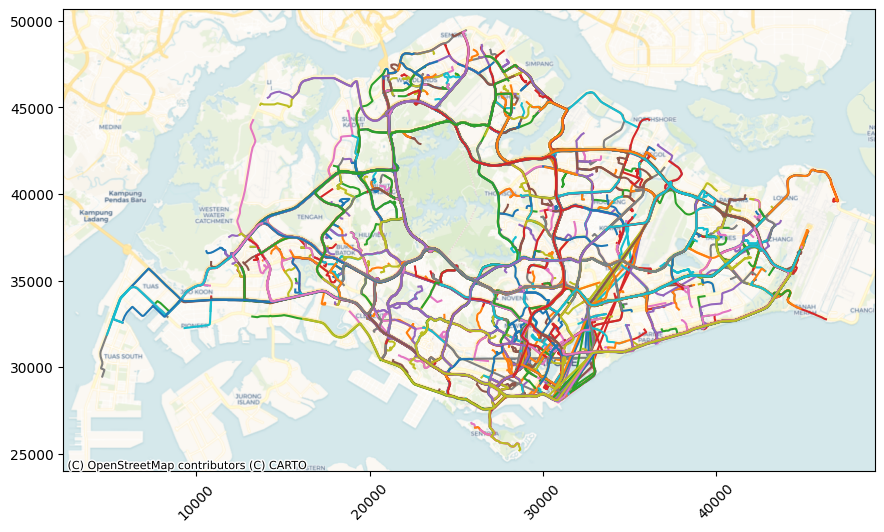

In [28]:
_, ax = plt.subplots(figsize=(12, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trajectories['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In this demo we will work cars that go (or pass by) the Singapore Airport and Gardens by the Bay, so we'll start creating a bounding box for each area.
We start by manually getting two points, one for each port, and creating a box for each. Then, we expand this bounding boxes.
From these two boxes we create another one that contains both. We'll use this bigger one ase a prefilter to detect the cars.

In [29]:
bay = shp.set_srid(shp.Point(32232.5740, 30189.7942), 3414)
airport = shp.set_srid(shp.Point(44452.1091, 35088.7227), 3414)

bay_bb = STBox.from_geometry_time(bay, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(1000)
airport_bb = STBox.from_geometry_time(airport, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(
    1000)

joined_bb = (bay_bb + airport_bb).expand(100)

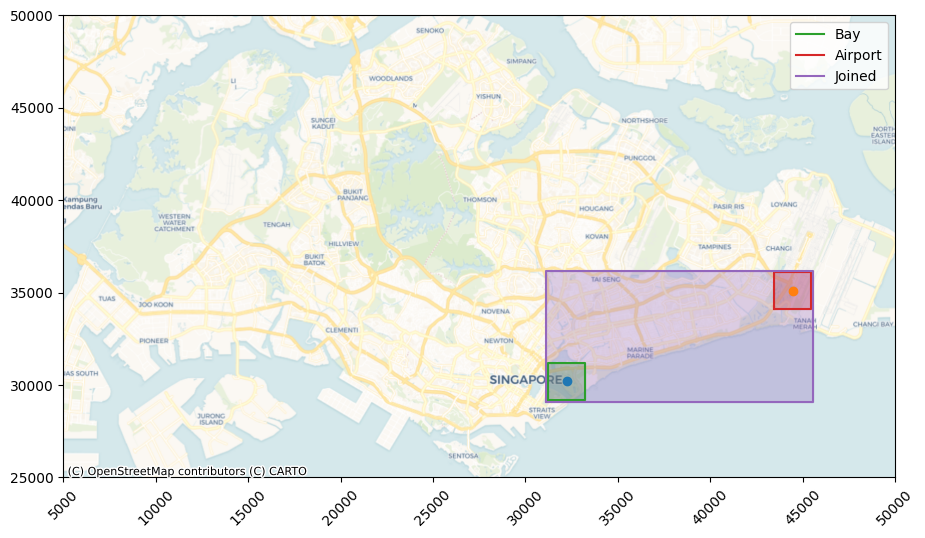

In [30]:
_, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(25000, 50000)
ax.set_xlim(5000, 50000)
_ = ax.plot(bay.x, bay.y, marker="o")
_ = ax.plot(airport.x, airport.y, marker="o")
_ = bay_bb.plot_xy(axes=ax, label='Bay')
_ = airport_bb.plot_xy(axes=ax, label='Airport')
_ = joined_bb.plot_xy(axes=ax, label='Joined')
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)
_ = plt.legend()

In [31]:
intersect_index = trajectories['Trajectory'].progress_map(lambda trip: trip.ever_intersects(joined_bb))
possible_trips = trajectories[intersect_index]
external_trips = trajectories[~intersect_index]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [42]:
trips_index = possible_trips['Trajectory'].progress_map(lambda trip: trip.ever_intersects(bay_bb)
                                                                     and trip.ever_intersects(airport_bb))
trips = possible_trips[trips_index]
non_trips_internal = possible_trips[~trips_index]

bay_trips = non_trips_internal[non_trips_internal['Trajectory'].map(lambda trip: trip.ever_intersects(bay_bb))]
airport_trips = non_trips_internal[non_trips_internal['Trajectory'].map(lambda trip: trip.ever_intersects(airport_bb))]

  0%|          | 0/567 [00:00<?, ?it/s]

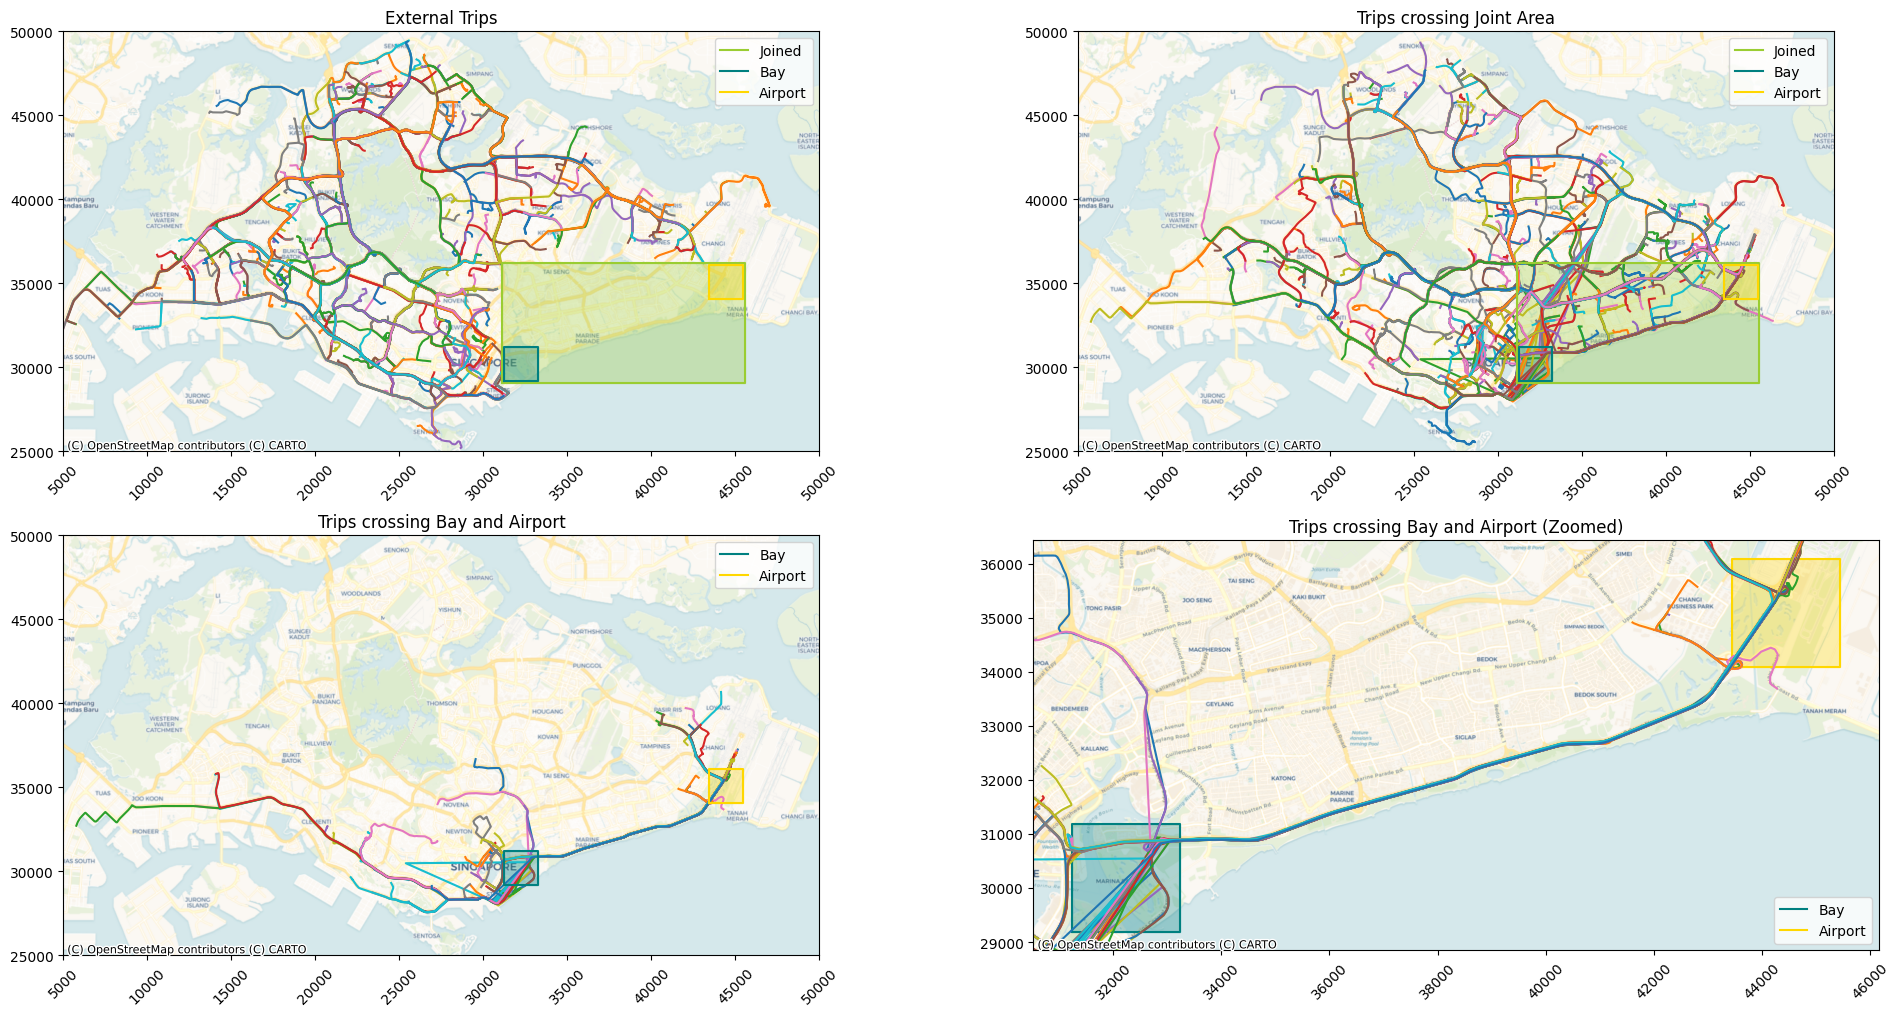

In [33]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))
_ = TemporalPointSequencePlotter.plot_sequences_xy(external_trips['Trajectory'], axes=ax[0][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(possible_trips['Trajectory'], axes=ax[0][1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   show_grid=False)
ax[0][0].set_title('External Trips')
ax[0][1].set_title('Trips crossing Joint Area')
ax[1][0].set_title('Trips crossing Bay and Airport')
ax[1][1].set_title('Trips crossing Bay and Airport (Zoomed)')
_ = joined_bb.plot_xy(axes=ax[0][0], color='yellowgreen', label='Joined')
_ = joined_bb.plot_xy(axes=ax[0][1], color='yellowgreen', label='Joined')
for a in [ax[0][0], ax[0][1], ax[1][0]]:
    _ = bay_bb.plot_xy(axes=a, color='teal', label='Bay')
    _ = airport_bb.plot_xy(axes=a, color='gold', label='Airport')
    _ = a.set_ylim(25000, 50000)
    _ = a.set_xlim(5000, 50000)
    _ = cx.add_basemap(a, crs=3414, source=cx.providers.CartoDB.Voyager)
    _ = a.legend()
_ = bay_bb.plot_xy(axes=ax[1][1], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[1][1], color='gold', label='Airport')
_ = cx.add_basemap(ax[1][1], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][1], show_markers=False,
                                                   show_grid=False)
_ = plt.legend()

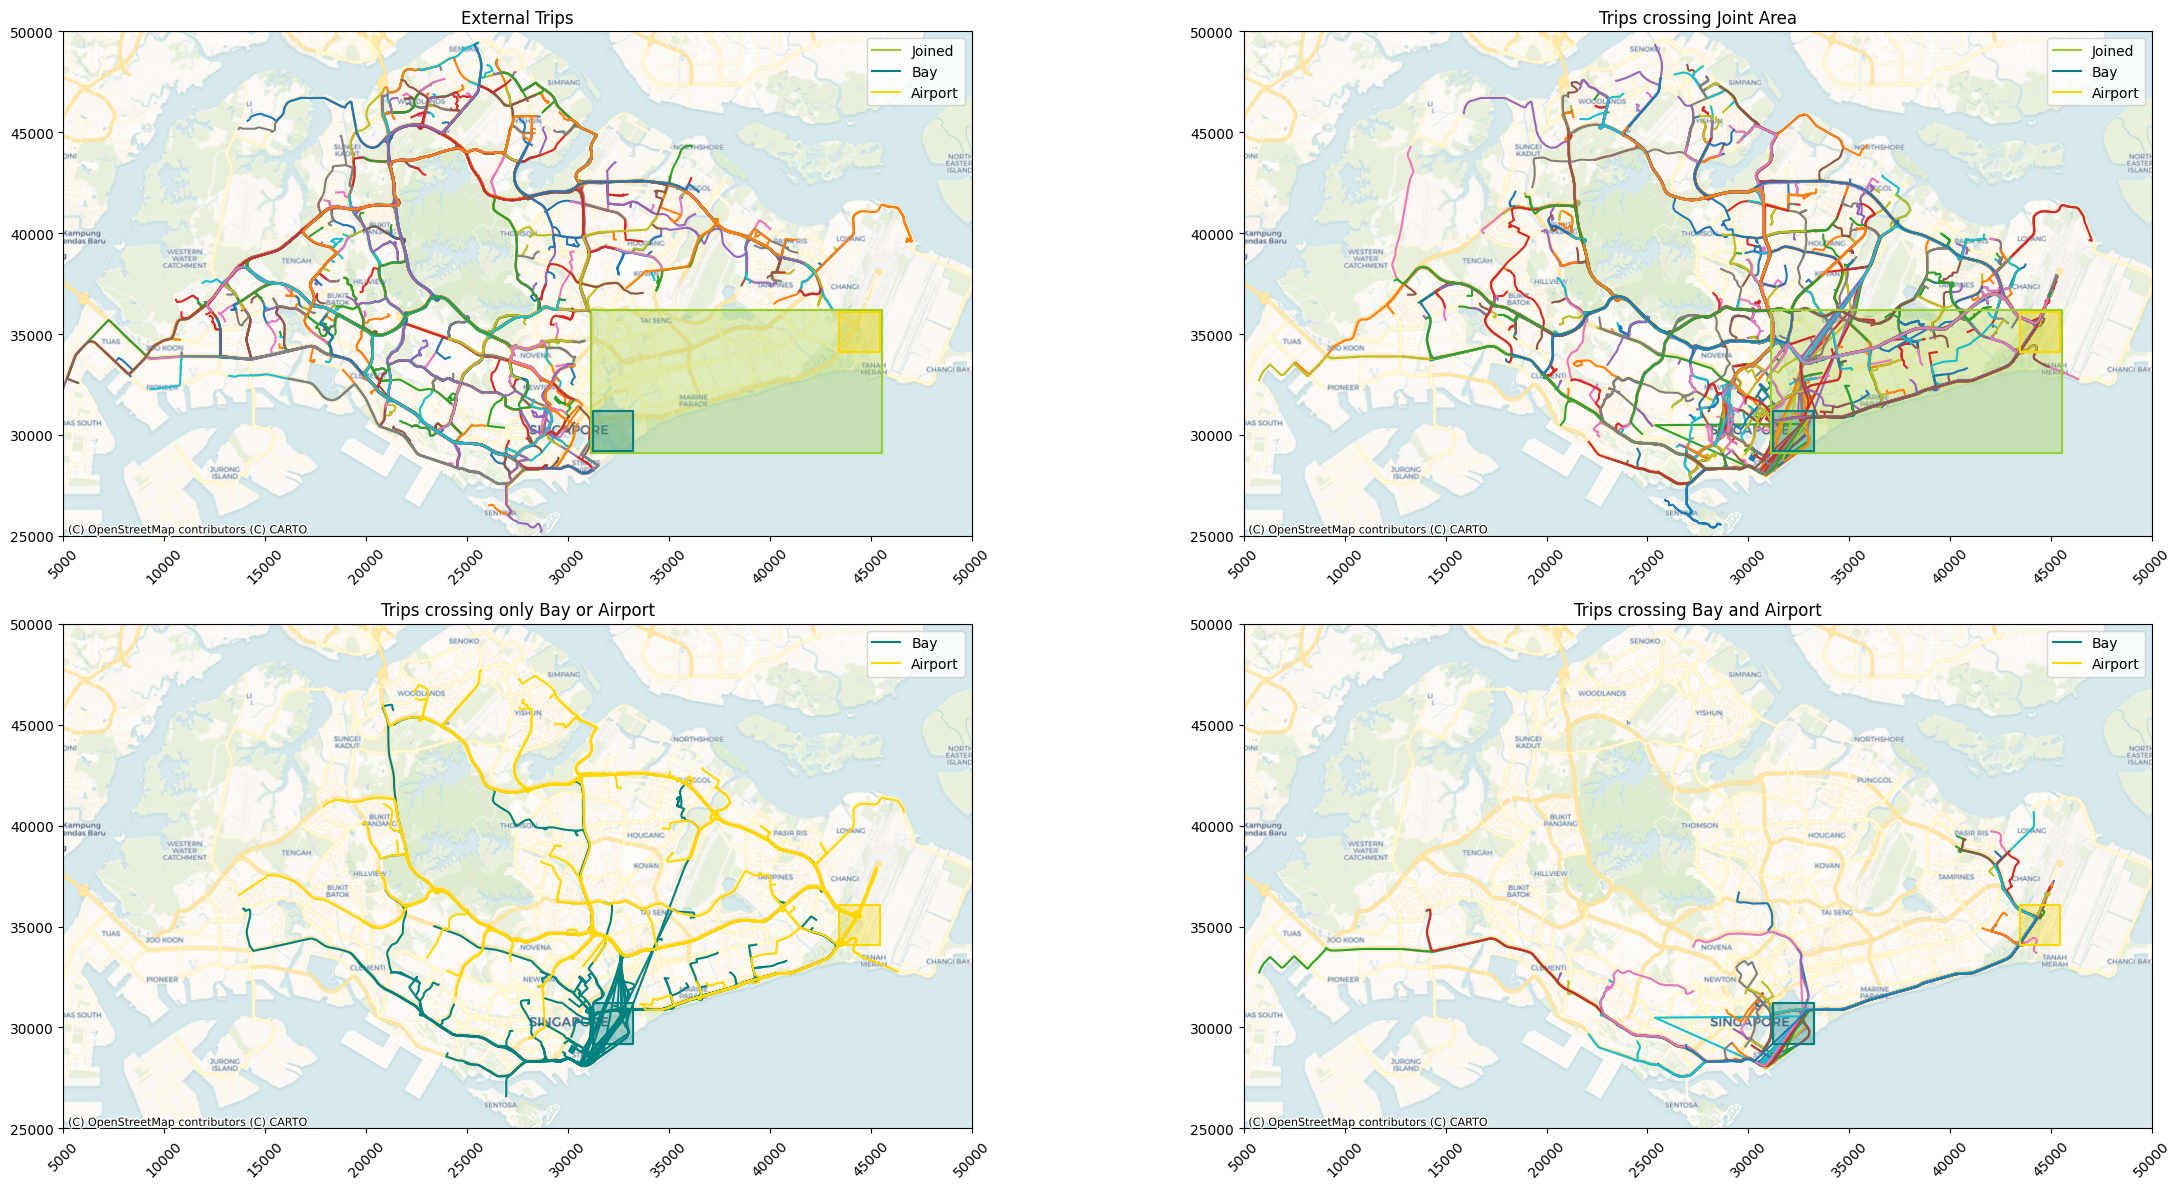

In [43]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))
_ = TemporalPointSequencePlotter.plot_sequences_xy(external_trips['Trajectory'], axes=ax[0][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(possible_trips['Trajectory'], axes=ax[0][1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(bay_trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   color='teal', show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(airport_trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   color='gold', show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][1], show_markers=False,
                                                   show_grid=False)
ax[0][0].set_title('External Trips')
ax[0][1].set_title('Trips crossing Joint Area')
ax[1][0].set_title('Trips crossing only Bay or Airport')
ax[1][1].set_title('Trips crossing Bay and Airport')
_ = joined_bb.plot_xy(axes=ax[0][0], color='yellowgreen', label='Joined')
_ = joined_bb.plot_xy(axes=ax[0][1], color='yellowgreen', label='Joined')
for r in ax:
    for a in r:
        _ = bay_bb.plot_xy(axes=a, color='teal', label='Bay')
        _ = airport_bb.plot_xy(axes=a, color='gold', label='Airport')
        _ = a.set_ylim(25000, 50000)
        _ = a.set_xlim(5000, 50000)
        _ = cx.add_basemap(a, crs=3414, source=cx.providers.CartoDB.Voyager)
        _ = a.legend()
_ = plt.legend()
_ = plt.tight_layout()

In [44]:
t = trips.copy()
t['Speed'] = t['Speed'].apply(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].apply(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].apply(lambda x: x.as_hexwkb())
t.to_csv(f'{data}/trips.csv')

nt = pd.concat([
    external_trips.copy(),
    non_trips_internal.copy(),
])
nt['Speed'] = nt['Speed'].apply(lambda x: x.as_hexwkb())
nt['Bearing'] = nt['Bearing'].apply(lambda x: x.as_hexwkb())
nt['Trajectory'] = nt['Trajectory'].apply(lambda x: x.as_hexwkb())
nt.to_csv(f'{data}/non_trips.csv')

## Splitting trajectories into one-leg trips

In [45]:
trips = pd.read_csv(f'{data}/trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
non_trips = pd.read_csv(f'{data}/non_trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trips.head()

Speed   
Trajectory ID                                                      
307            [17.44@2019-04-15 09:20:32+02, 19.09@2019-04-1...  \
558            [12.947844@2019-04-13 09:26:04+02, 13.4163065@...   
587            [13.172646522521973@2019-04-18 15:29:21+02, 13...   
2667           [5.2587247@2019-04-08 15:53:50+02, 6.253172@20...   
4887           [3.48@2019-04-18 11:17:55+02, 3.56@2019-04-18 ...   

                                                         Bearing   
Trajectory ID                                                      
307            [121@2019-04-15 09:20:32+02, 125@2019-04-15 09...  \
558            [123@2019-04-13 09:26:04+02, 121@2019-04-13 09...   
587            [125@2019-04-18 15:29:21+02, 125@2019-04-18 15...   
2667           [143@2019-04-08 15:53:50+02, 149@2019-04-08 15...   
4887           [285@2019-04-18 11:17:55+02, 289@2019-04-18 11...   

                                                      Trajectory  
Trajectory ID                                                     
307            [POINT(42785.54134319292 34504.381721159094)@2...  
558            [POINT(41607.49359226519 34913.5484173436)@201...  
587            [POINT(30597.0248582485 29070.689170268586)@20...  
2667           [POINT(28892.932740888984 28472.34898658451)@2...  
4887           [POINT(42285.252753209694 35054.245528254985)@...

In [46]:
geometry_trips = trips.copy()
geometry_trips['Is Inside'] = geometry_trips['Trajectory'].map(
    lambda trip: trip.is_spatially_contained_in(bay_bb).temporal_or(
        trip.is_spatially_contained_in(airport_bb)))
geometry_trips['Time Inside'] = geometry_trips['Is Inside'].map(lambda t: t.when_true())
geometry_trips['Period'] = geometry_trips['Time Inside'].map(lambda t: t.to_period())
geometry_trips['Time Outside'] = geometry_trips.apply(lambda row: row['Is Inside'].at(row['Period']).when_false(),
                                                      axis=1)
geometry_trips['Single Trips'] = geometry_trips.apply(lambda row: row['Trajectory'].at(row['Time Outside']), axis=1)
geometry_trips.head()

Speed   
Trajectory ID                                                      
307            [17.44@2019-04-15 09:20:32+02, 19.09@2019-04-1...  \
558            [12.947844@2019-04-13 09:26:04+02, 13.4163065@...   
587            [13.172646522521973@2019-04-18 15:29:21+02, 13...   
2667           [5.2587247@2019-04-08 15:53:50+02, 6.253172@20...   
4887           [3.48@2019-04-18 11:17:55+02, 3.56@2019-04-18 ...   

                                                         Bearing   
Trajectory ID                                                      
307            [121@2019-04-15 09:20:32+02, 125@2019-04-15 09...  \
558            [123@2019-04-13 09:26:04+02, 121@2019-04-13 09...   
587            [125@2019-04-18 15:29:21+02, 125@2019-04-18 15...   
2667           [143@2019-04-08 15:53:50+02, 149@2019-04-08 15...   
4887           [285@2019-04-18 11:17:55+02, 289@2019-04-18 11...   

                                                      Trajectory   
Trajectory ID                                                      
307            [POINT(42785.54134319292 34504.381721159094)@2...  \
558            [POINT(41607.49359226519 34913.5484173436)@201...   
587            [POINT(30597.0248582485 29070.689170268586)@20...   
2667           [POINT(28892.932740888984 28472.34898658451)@2...   
4887           [POINT(42285.252753209694 35054.245528254985)@...   

                                                       Is Inside   
Trajectory ID                                                      
307            {[f@2019-04-15 09:20:32+02, f@2019-04-15 09:21...  \
558            {[f@2019-04-13 09:26:04+02, f@2019-04-13 09:28...   
587            {[f@2019-04-18 15:29:21+02, f@2019-04-18 15:31...   
2667           {[f@2019-04-08 15:53:50+02, f@2019-04-08 15:59...   
4887           {[f@2019-04-18 11:17:55+02, f@2019-04-18 11:21...   

                                                     Time Inside   
Trajectory ID                                                      
307            {(2019-04-15 09:21:31.393074+02, 2019-04-15 09...  \
558            {(2019-04-13 09:28:46.834542+02, 2019-04-13 09...   
587            {(2019-04-18 15:31:24.894614+02, 2019-04-18 15...   
2667           {(2019-04-08 15:59:42.593122+02, 2019-04-08 16...   
4887           {(2019-04-18 11:21:31.71048+02, 2019-04-18 11:...   

                                                          Period   
Trajectory ID                                                      
307            (2019-04-15 09:21:31.393074+02, 2019-04-15 09:...  \
558            (2019-04-13 09:28:46.834542+02, 2019-04-13 09:...   
587            (2019-04-18 15:31:24.894614+02, 2019-04-18 15:...   
2667           (2019-04-08 15:59:42.593122+02, 2019-04-08 16:...   
4887           (2019-04-18 11:21:31.71048+02, 2019-04-18 11:3...   

                                                    Time Outside   
Trajectory ID                                                      
307            {[2019-04-15 09:21:56.079923+02, 2019-04-15 09...  \
558            {[2019-04-13 09:29:16.48236+02, 2019-04-13 09:...   
587            {[2019-04-18 15:32:58.602575+02, 2019-04-18 15...   
2667           {[2019-04-08 16:02:19.582652+02, 2019-04-08 16...   
4887           {[2019-04-18 11:21:54.955721+02, 2019-04-18 11...   

                                                    Single Trips  
Trajectory ID                                                     
307            {[POINT(43452.1091071125 34102.63668181222)@20...  
558            {[POINT(43452.10910577187 34107.51561859604)@2...  
587            {[POINT(33232.57398532677 30888.75409305662)@2...  
2667           {[POINT(33232.573990247314 30881.22062351536)@...  
4887           {[POINT(43452.10910188905 34102.30547075576)@2...

In [49]:
geometry_one_leg_trips = geometry_trips[['Single Trips', 'Speed', 'Bearing']].copy()
geometry_one_leg_trips['Single Trips'] = geometry_one_leg_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
geometry_one_leg_trips = geometry_one_leg_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                               axis=1)
geometry_one_leg_trips.insert(0, 'Trip #', geometry_one_leg_trips.groupby('Trajectory ID').cumcount() + 1)
geometry_one_leg_trips.head()

Trip #                                               Trip   
Trajectory ID                                                              
307                 1  [POINT(43452.1091071125 34102.63668181222)@201...  \
558                 1  [POINT(43452.10910577187 34107.51561859604)@20...   
587                 1  [POINT(33232.57398532677 30888.75409305662)@20...   
2667                1  [POINT(33232.573990247314 30881.22062351536)@2...   
4887                1  [POINT(43452.10910188905 34102.30547075576)@20...   

                                                           Speed   
Trajectory ID                                                      
307            [17.44@2019-04-15 09:20:32+02, 19.09@2019-04-1...  \
558            [12.947844@2019-04-13 09:26:04+02, 13.4163065@...   
587            [13.172646522521973@2019-04-18 15:29:21+02, 13...   
2667           [5.2587247@2019-04-08 15:53:50+02, 6.253172@20...   
4887           [3.48@2019-04-18 11:17:55+02, 3.56@2019-04-18 ...   

                                                         Bearing  
Trajectory ID                                                     
307            [121@2019-04-15 09:20:32+02, 125@2019-04-15 09...  
558            [123@2019-04-13 09:26:04+02, 121@2019-04-13 09...  
587            [125@2019-04-18 15:29:21+02, 125@2019-04-18 15...  
2667           [143@2019-04-08 15:53:50+02, 149@2019-04-08 15...  
4887           [285@2019-04-18 11:17:55+02, 289@2019-04-18 11...

In [50]:
geometry_one_leg_trips['Speed'] = geometry_one_leg_trips.apply(
    lambda row: row['Speed'].at(row['Trip'].period()), axis=1)
geometry_one_leg_trips['Bearing'] = geometry_one_leg_trips.apply(
    lambda row: row['Bearing'].at(row['Trip'].period()), axis=1)
geometry_one_leg_trips.head()

Trip #                                               Trip   
Trajectory ID                                                              
307                 1  [POINT(43452.1091071125 34102.63668181222)@201...  \
558                 1  [POINT(43452.10910577187 34107.51561859604)@20...   
587                 1  [POINT(33232.57398532677 30888.75409305662)@20...   
2667                1  [POINT(33232.573990247314 30881.22062351536)@2...   
4887                1  [POINT(43452.10910188905 34102.30547075576)@20...   

                                                           Speed   
Trajectory ID                                                      
307            [12.560212268181818@2019-04-15 09:21:56.079923...  \
558            [14.242468538639999@2019-04-13 09:29:16.48236+...   
587            [21.036578833560945@2019-04-18 15:32:58.602575...   
2667           [20.619674702083998@2019-04-08 16:02:19.582652...   
4887           [14.745135582000001@2019-04-18 11:21:54.955721...   

                                                         Bearing  
Trajectory ID                                                     
307            [224.1382238181818@2019-04-15 09:21:56.079923+...  
558            [213@2019-04-13 09:29:16.48236+02, 213@2019-04...  
587            [88.038455@2019-04-18 15:32:58.602575+02, 86@2...  
2667           [88@2019-04-08 16:02:19.582652+02, 88@2019-04-...  
4887           [214.7734326@2019-04-18 11:21:54.955721+02, 21...

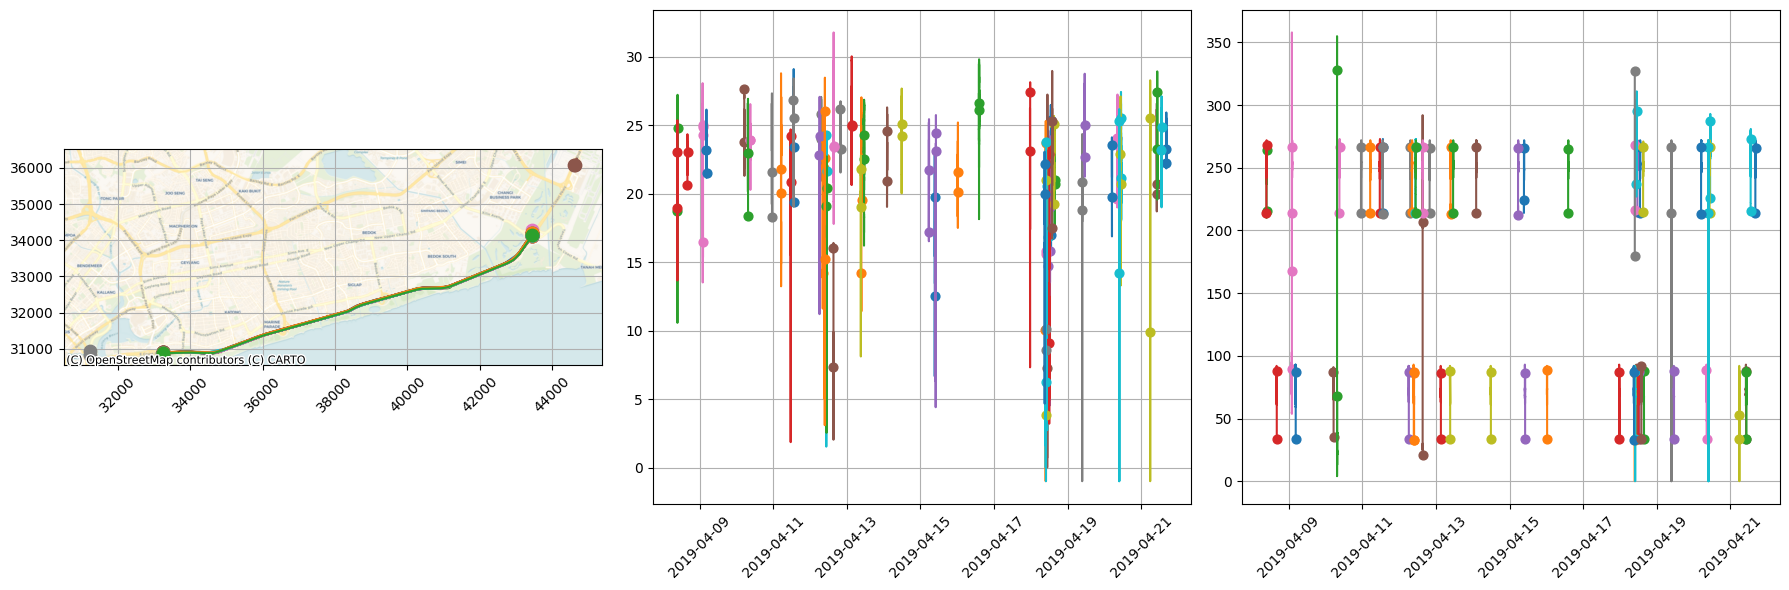

In [70]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_one_leg_trips['Trip'], axes=ax[0])
_ = cx.add_basemap(ax[0], crs=3414, source=cx.providers.CartoDB.Voyager)

_ = TemporalSequencePlotter.plot_sequences(geometry_one_leg_trips['Speed'], axes=ax[1])
_ = TemporalSequencePlotter.plot_sequences(geometry_one_leg_trips['Bearing'], axes=ax[2])
plt.tight_layout()

## Trajectory Heatmap

In [54]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

In [55]:
bbox: STBox = TemporalPointExtentAggregator.aggregate(trips['Trajectory'])

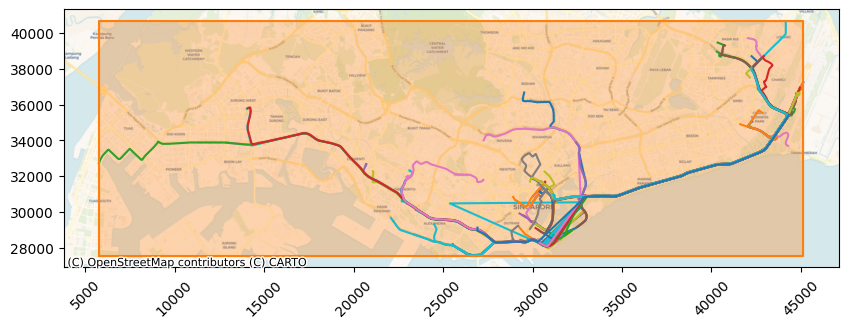

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = bbox.plot_xy(axes=ax)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In [57]:
heat_df = pd.DataFrame(data={'Tile': bbox.tile_flat(size=500)})
heat_df['# Trajectories'] = heat_df['Tile'].progress_map(
    lambda tile: sum(trips['Trajectory'].map(lambda tp: tp.ever_intersects(tile))))
heat_df['X'] = heat_df['Tile'].map(lambda tile: (tile.xmin() + tile.xmax()) / 2)
heat_df['Y'] = heat_df['Tile'].map(lambda tile: (tile.ymin() + tile.ymax()) / 2)
heat_df.head()

  0%|          | 0/2160 [00:00<?, ?it/s]

Tile  # Trajectories       X   
0  SRID=3414;STBOX X((5500,27500),(6000,28000))               0  5750.0  \
1  SRID=3414;STBOX X((6000,27500),(6500,28000))               0  6250.0   
2  SRID=3414;STBOX X((6500,27500),(7000,28000))               0  6750.0   
3  SRID=3414;STBOX X((7000,27500),(7500,28000))               0  7250.0   
4  SRID=3414;STBOX X((7500,27500),(8000,28000))               0  7750.0   

         Y  
0  27750.0  
1  27750.0  
2  27750.0  
3  27750.0  
4  27750.0

In [58]:
svy21 = pyproj.CRS('EPSG:3414')
wgs84 = pyproj.CRS('EPSG:4326')

project = partial(transform, pyproj.Transformer.from_crs(svy21, wgs84, always_xy=True).transform)

heat_df['Coords'] = pd.Series(shp.points(heat_df['X'], heat_df['Y'])).map(project)
heat_df['Lat'] = heat_df['Coords'].map(lambda p: p.y)
heat_df['Lon'] = heat_df['Coords'].map(lambda p: p.x)
heat_df.head()

Tile  # Trajectories       X   
0  SRID=3414;STBOX X((5500,27500),(6000,28000))               0  5750.0  \
1  SRID=3414;STBOX X((6000,27500),(6500,28000))               0  6250.0   
2  SRID=3414;STBOX X((6500,27500),(7000,28000))               0  6750.0   
3  SRID=3414;STBOX X((7000,27500),(7500,28000))               0  7250.0   
4  SRID=3414;STBOX X((7500,27500),(8000,28000))               0  7750.0   

         Y                                         Coords       Lat   
0  27750.0   POINT (103.6333952671853 1.2672278759264077)  1.267228  \
1  27750.0   POINT (103.63788790813453 1.267228220971269)  1.267228   
2  27750.0  POINT (103.64238055029409 1.2672285581749374)  1.267229   
3  27750.0  POINT (103.64687319363618 1.2672288875374023)  1.267229   
4  27750.0  POINT (103.65136583813299 1.2672292090586534)  1.267229   

          Lon  
0  103.633395  
1  103.637888  
2  103.642381  
3  103.646873  
4  103.651366

In [59]:
heat_df.to_csv(f'{data}/heatmap.csv', index=False)

In [60]:
heat_df = pd.read_csv(f'{data}/heatmap.csv')

In [62]:
fig = px.density_mapbox(heat_df, lat='Lat', lon='Lon', z='# Trajectories',
                        radius=20,
                        zoom=11,
                        mapbox_style='open-street-map',
                        width=1500,
                        height=800,
                        )
fig.show()

In [63]:
fig.write_image('heatmap.png')

## Metric extraction

In [64]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

In [65]:
trajectories['Distance'] = trajectories['Trajectory'].map(lambda t: t.length())
trajectories['Avg Speed'] = trajectories['Speed'].map(lambda s: s.time_weighted_average())
trajectories['Avg Direction'] = trajectories['Bearing'].map(lambda b: b.time_weighted_average())
trajectories['Travel Time'] = trajectories['Trajectory'].map(lambda t: t.duration())
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory   
Trajectory ID                                                      
10             [POINT(24215.820244986906 31560.706204192793)@...  \
23             [POINT(39193.172144329044 35077.03281919307)@2...   
24             [POINT(39245.69537137267 34777.94277160995)@20...   
66             [POINT(21696.95171721036 47355.26736557279)@20...   
83             [POINT(22378.434417648372 46630.44463095692)@2...   

                   Distance  Avg Speed  Avg Direction     Travel Time  
Trajectory ID                                                          
10              9981.788426   8.826872      66.015734 0 days 00:19:04  
23             26175.446781  20.932771     270.597551 0 days 00:21:06  
24             17238.537375  17.090260     280.790227 0 days 00:16:53  
66             11050.764649   9.190391     136.770070 0 days 00:23:40  
83             30706.466229  15.394563      99.915604 0 days 00:33:58

## Close cars identification

In [66]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

In [67]:
data = []
for i, trip in trajectories['Trajectory'].items():
    for j, other in trajectories['Trajectory'].items():
        if j <= i:
            continue
        if trip.is_ever_within_distance(other, 10):
            print(f'{i} within {j}')
            data.append((i, trip, j, other))

14836 within 38532
19166 within 55507
20431 within 81088
24960 within 62922
25897 within 71255
28866 within 48191
58860 within 75134
65640 within 66797
65895 within 69835
73899 within 83488


In [68]:
close_cars = pd.DataFrame(data, columns=['ID 1', 'Trajectory 1', 'ID 2', 'Trajectory 2'])
close_cars.head()

ID 1                                       Trajectory 1   ID 2   
0  14836  [POINT(18218.211306723046 38102.225979641924)@...  38532  \
1  19166  [POINT(21481.87197524448 33634.75479134711)@20...  55507   
2  20431  [POINT(13387.937864608457 37121.1783856671)@20...  81088   
3  24960  [POINT(31548.415428967895 34103.23967082107)@2...  62922   
4  25897  [POINT(26228.36037967567 31372.277784147558)@2...  71255   

                                        Trajectory 2  
0  [POINT(36857.22242170114 32046.71707625586)@20...  
1  [POINT(44706.81773674855 36329.72243829873)@20...  
2  [POINT(26055.032483416482 32097.4279062861)@20...  
3  [POINT(20540.815202953247 37777.07131678395)@2...  
4  [POINT(44562.94314598582 36000.43349028984)@20...

In [69]:
close_cars.to_csv(f'{data}/close_cars.csv', index=False)

OSError: [Errno 36] File name too long: '[(14836, TGeomPointSeq([POINT(18218.211306723046 38102.225979641924)@2019-04-11 06:43:55+02, POINT(18184.619456987293 38121.6847269218)@2019-04-11 06:43:59+02, POINT(18162.226488022392 38130.798703830704)@2019-04-11 06:44:01+02, POINT(18116.01953842429 38149.2143907047)@2019-04-11 06:44:05+02, POINT(18064.595714131632 38169.49667948025)@2019-04-11 06:44:11+02, POINT(18041.675356908607 38180.7729275802)@2019-04-11 06:44:15+02, POINT(18033.224004884603 38184.99899875149)@2019-04-11 06:44:16+02, POINT(18013.21003891639 38194.20049662879)@2019-04-11 06:44:18+02, POINT(17942.0922588816 38232.57609692816)@2019-04-11 06:44:24+02, POINT(17859.101132829983 38286.24627383826)@2019-04-11 06:44:33+02, POINT(17852.301117474915 38283.897042168705)@2019-04-11 06:44:34+02, POINT(17846.003862958372 38279.18188193588)@2019-04-11 06:44:35+02, POINT(17812.70179775856 38239.75699612031)@2019-04-11 06:44:40+02, POINT(17804.702740848268 38229.97985400358)@2019-04-11 06:44:41+02, POINT(17754.972138895697 38170.53351536341)@2019-04-11 06:44:47+02, POINT(17665.58690720492 38060.59523246123)@2019-04-11 06:45:00+02, POINT(17639.417738938297 38031.35594618207)@2019-04-11 06:45:27+02, POINT(17626.870442159772 38015.53186037701)@2019-04-11 06:45:29+02, POINT(17595.181622888966 37974.70347875872)@2019-04-11 06:45:33+02, POINT(17540.035245352978 37908.564761471855)@2019-04-11 06:45:39+02, POINT(17465.845190758504 37831.71260501979)@2019-04-11 06:45:46+02, POINT(17443.69862783044 37809.014384887305)@2019-04-11 06:45:48+02, POINT(17422.00367838337 37787.35660160524)@2019-04-11 06:45:50+02, POINT(17358.19368968688 37723.02258343223)@2019-04-11 06:45:56+02, POINT(17315.44504145212 37672.34773210598)@2019-04-11 06:46:00+02, POINT(17266.352751707782 37578.51447619142)@2019-04-11 06:46:06+02, POINT(17243.971650531268 37407.46270467274)@2019-04-11 06:46:16+02, POINT(17248.030960975284 37360.63848578615)@2019-04-11 06:46:18+02, POINT(17256.154348989825 37319.788682978935)@2019-04-11 06:46:20+02, POINT(17268.662030007778 37282.068540479435)@2019-04-11 06:46:22+02, POINT(17297.858720589393 37210.1558864376)@2019-04-11 06:46:26+02, POINT(17312.12886237652 37176.442052740145)@2019-04-11 06:46:28+02, POINT(17319.376574089132 37159.43779726082)@2019-04-11 06:46:29+02, POINT(17334.125123708272 37126.52585561893)@2019-04-11 06:46:31+02, POINT(17344.021010499142 37108.67529580137)@2019-04-11 06:46:32+02, POINT(17370.189057033233 37043.1616785186)@2019-04-11 06:46:36+02, POINT(17379.835526761795 37011.82231453618)@2019-04-11 06:46:38+02, POINT(17384.11759200318 36997.68060122261)@2019-04-11 06:46:39+02, POINT(17392.200251325878 36970.4783321245)@2019-04-11 06:46:41+02, POINT(17406.93265727981 36939.02121437003)@2019-04-11 06:46:45+02, POINT(17430.95818604665 36851.72628625058)@2019-04-11 06:46:57+02, POINT(17433.139335103588 36844.347959840474)@2019-04-11 06:46:58+02, POINT(17439.22812628154 36807.52954077727)@2019-04-11 06:47:02+02, POINT(17440.671159905392 36793.88428523587)@2019-04-11 06:47:03+02, POINT(17442.736694337946 36765.99318970218)@2019-04-11 06:47:05+02, POINT(17433.465339234557 36673.76583006742)@2019-04-11 06:47:11+02, POINT(17429.464186372286 36659.41375299328)@2019-04-11 06:47:12+02, POINT(17421.081151995277 36631.76543270075)@2019-04-11 06:47:14+02, POINT(17416.452844778825 36618.83441462426)@2019-04-11 06:47:15+02, POINT(17411.638250492128 36606.87692743171)@2019-04-11 06:47:16+02, POINT(17405.45354924941 36593.89657114062)@2019-04-11 06:47:17+02, POINT(17398.271519083908 36580.504801862)@2019-04-11 06:47:18+02, POINT(17377.40738031472 36541.60108353331)@2019-04-11 06:47:21+02, POINT(17362.836133896893 36511.952729023425)@2019-04-11 06:47:23+02, POINT(17357.36788885587 36500.81338702941)@2019-04-11 06:47:24+02, POINT(17374.361725570947 36462.23636965958)@2019-04-11 06:47:29+02, POINT(17381.478811232693 36457.458004423555)@2019-04-11 06:47:30+02, POINT(17389.01188042121 36451.2493166681)@2019-04-11 06:47:31+02, POINT(17407.106499612033 36440.448462334876)@2019-04-11 06:47:33+02, POINT(17417.757486497816 36436.384525796544)@2019-04-11 06:47:34+02, POINT(17440.850264268047 36427.84114750128)@2019-04-11 06:47:36+02, POINT(17552.306326826198 36390.99949654793)@2019-04-11 06:47:44+02, POINT(17588.56449967408 36380.4868789481)@2019-04-11 06:47:46+02, POINT(17691.15657432917 36364.23885104916)@2019-04-11 06:47:52+02, POINT(17748.076494202047 36359.06309589028)@2019-04-11 06:47:55+02, POINT(17768.129134059716 36356.86946874496)@2019-04-11 06:47:56+02, POINT(17790.828045772258 36353.968234598426)@2019-04-11 06:47:57+02, POINT(17857.487152273257 36345.01001462404)@2019-04-11 06:48:00+02, POINT(17901.108728742045 36335.26137771429)@2019-04-11 06:48:02+02, POINT(18153.792118038284 36238.66268103474)@2019-04-11 06:48:13+02, POINT(18323.928565329858 36134.89813046374)@2019-04-11 06:48:21+02, POINT(18367.795528860523 36111.57724061419)@2019-04-11 06:48:23+02, POINT(18389.95803151434 36100.58013562651)@2019-04-11 06:48:24+02, POINT(18456.536902765052 36064.62591233714)@2019-04-11 06:48:27+02, POINT(18478.078036939212 36051.80753171092)@2019-04-11 06:48:28+02, POINT(18616.566230329187 35976.25029325545)@2019-04-11 06:48:34+02, POINT(18638.75916795228 35964.35417546633)@2019-04-11 06:48:35+02, POINT(18719.39745345325 35915.77972535039)@2019-04-11 06:48:39+02, POINT(18759.707395976635 35891.61499618238)@2019-04-11 06:48:41+02, POINT(18841.569259546268 35848.21644594852)@2019-04-11 06:48:45+02, POINT(18860.64794589094 35834.97157404721)@2019-04-11 06:48:46+02, POINT(18880.671233193418 35824.02092309591)@2019-04-11 06:48:47+02, POINT(18941.445464518474 35783.80254116146)@2019-04-11 06:48:50+02, POINT(19217.81458035724 35633.19757617766)@2019-04-11 06:49:04+02, POINT(19266.779112975597 35602.14836006351)@2019-04-11 06:49:07+02, POINT(19303.37485024007 35580.659798650326)@2019-04-11 06:49:09+02, POINT(19321.537036220216 35569.93599203371)@2019-04-11 06:49:10+02, POINT(19339.098112539254 35559.54152107586)@2019-04-11 06:49:11+02, POINT(19392.405324538944 35529.73586837048)@2019-04-11 06:49:14+02, POINT(19410.78824457361 35518.827590836976)@2019-04-11 06:49:15+02, POINT(19537.137835081296 35469.5719910925)@2019-04-11 06:49:21+02, POINT(19593.29578029255 35430.38344915203)@2019-04-11 06:49:24+02, POINT(19631.37626664208 35401.656765008534)@2019-04-11 06:49:26+02, POINT(19651.985418972952 35390.10239536613)@2019-04-11 06:49:27+02, POINT(19736.363568284432 35345.80171976118)@2019-04-11 06:49:31+02, POINT(19820.281757880497 35297.17244367308)@2019-04-11 06:49:35+02, POINT(19920.51796020478 35241.069419450396)@2019-04-11 06:49:40+02, POINT(19960.630504549452 35217.27101264469)@2019-04-11 06:49:42+02, POINT(20168.66504728517 35098.840426199866)@2019-04-11 06:49:52+02, POINT(20253.042000022222 35052.243798134106)@2019-04-11 06:49:56+02, POINT(20292.77808512115 35027.94013444628)@2019-04-11 06:49:58+02, POINT(20330.874118508982 35005.97152884946)@2019-04-11 06:50:00+02, POINT(20522.927522907037 34951.8453559235)@2019-04-11 06:50:09+02, POINT(20544.678973657596 34948.62927724329)@2019-04-11 06:50:10+02, POINT(20567.72307424728 34946.36319061653)@2019-04-11 06:50:11+02, POINT(20589.946949615914 34944.00421140342)@2019-04-11 06:50:12+02, POINT(20678.97291304558 34943.839356236465)@2019-04-11 06:50:16+02, POINT(20722.224776662457 34945.33557041098)@2019-04-11 06:50:18+02, POINT(20742.52544257456 34948.60773850851)@2019-04-11 06:50:19+02, POINT(20781.43272128349 34954.55253324245)@2019-04-11 06:50:21+02, POINT(20892.257580468722 34984.86902827881)@2019-04-11 06:50:27+02, POINT(20911.728824241858 34990.13852428102)@2019-04-11 06:50:28+02, POINT(20930.98362095586 34997.10115072891)@2019-04-11 06:50:29+02, POINT(21039.52504842746 35041.910110460245)@2019-04-11 06:50:35+02, POINT(21137.169523345143 35085.09354624025)@2019-04-11 06:50:40+02, POINT(21157.126445839313 35092.54493002591)@2019-04-11 06:50:41+02, POINT(21194.93032768627 35107.078423333645)@2019-04-11 06:50:43+02, POINT(21214.312202670488 35115.0374275409)@2019-04-11 06:50:44+02, POINT(21251.7649839937 35132.6214999996)@2019-04-11 06:50:46+02, POINT(21362.918012528833 35184.97104527471)@2019-04-11 06:50:52+02, POINT(21437.269473760818 35237.953607650816)@2019-04-11 06:50:56+02, POINT(21475.81410028638 35265.345974176984)@2019-04-11 06:50:58+02, POINT(21511.904612209735 35293.52531002644)@2019-04-11 06:51:00+02, POINT(21678.683394390013 35422.48181926834)@2019-04-11 06:51:09+02, POINT(21864.03360360104 35727.99706509901)@2019-04-11 06:51:25+02, POINT(21915.409508474288 35841.50547828678)@2019-04-11 06:51:31+02, POINT(21957.35780879499 35917.501357897025)@2019-04-11 06:51:36+02, POINT(21969.022429776323 35934.86336635039)@2019-04-11 06:51:37+02, POINT(22024.51487429029 35990.39648776349)@2019-04-11 06:51:41+02, POINT(22122.035054882126 36036.857066832796)@2019-04-11 06:51:46+02, POINT(22232.365947412283 36067.57475509034)@2019-04-11 06:51:51+02, POINT(22276.916848963727 36076.83769944221)@2019-04-11 06:51:53+02, POINT(22318.27263486997 36089.41813068425)@2019-04-11 06:51:55+02, POINT(22338.68658215002 36096.47589106428)@2019-04-11 06:51:56+02, POINT(22359.93306088389 36103.74617406802)@2019-04-11 06:51:57+02, POINT(22380.2191953113 36112.51795726664)@2019-04-11 06:51:58+02, POINT(22420.01781380743 36128.83909663581)@2019-04-11 06:52:00+02, POINT(22486.091573376012 36155.06943616639)@2019-04-11 06:52:03+02, POINT(22507.253248258166 36164.04287500023)@2019-04-11 06:52:04+02, POINT(22550.490613354912 36175.931458415034)@2019-04-11 06:52:06+02, POINT(22573.145088573357 36182.82010959791)@2019-04-11 06:52:07+02, POINT(22595.14618501842 36191.65572368452)@2019-04-11 06:52:08+02, POINT(22635.482161699438 36206.0040426163)@2019-04-11 06:52:10+02, POINT(22673.41550764294 36222.899377171525)@2019-04-11 06:52:12+02, POINT(22691.416110041388 36230.93084306214)@2019-04-11 06:52:13+02, POINT(22711.875608300248 36239.895190499854)@2019-04-11 06:52:14+02, POINT(22731.525285225838 36246.33074703294)@2019-04-11 06:52:15+02, POINT(22771.778168198354 36263.51007484183)@2019-04-11 06:52:17+02, POINT(22883.192736427416 36313.55129559948)@2019-04-11 06:52:23+02, POINT(22899.203434366813 36323.323195023586)@2019-04-11 06:52:24+02, POINT(22913.615801551423 36331.854557756946)@2019-04-11 06:52:25+02, POINT(22924.68054484637 36340.636188229)@2019-04-11 06:52:26+02, POINT(22938.545546627116 36354.057561631664)@2019-04-11 06:52:27+02, POINT(22985.01684164958 36414.151241166146)@2019-04-11 06:52:31+02, POINT(22995.00672646344 36430.773171077)@2019-04-11 06:52:32+02, POINT(23004.064562714993 36446.65121414267)@2019-04-11 06:52:33+02, POINT(23019.981915821027 36483.431841332924)@2019-04-11 06:52:35+02, POINT(23040.37793740865 36540.74522936465)@2019-04-11 06:52:38+02, POINT(23058.81169989825 36582.588890297724)@2019-04-11 06:52:40+02, POINT(23091.085559182487 36644.27422603871)@2019-04-11 06:52:43+02, POINT(23112.964777887846 36684.923417962564)@2019-04-11 06:52:45+02, POINT(23151.904129149105 36733.744319827114)@2019-04-11 06:52:48+02, POINT(23166.807109965805 36746.16514689589)@2019-04-11 06:52:49+02, POINT(23197.41595055515 36767.60469511423)@2019-04-11 06:52:51+02, POINT(23229.259939702428 36783.940532086985)@2019-04-11 06:52:53+02, POINT(23263.042642381948 36797.49420738262)@2019-04-11 06:52:55+02, POINT(23367.4049437963 36828.6934597404)@2019-04-11 06:53:01+02, POINT(23402.672546937392 36835.70247383844)@2019-04-11 06:53:03+02, POINT(23460.48831401806 36848.519060793755)@2019-04-11 06:53:06+02, POINT(23576.283245695256 36854.93566314924)@2019-04-11 06:53:12+02, POINT(23706.536558331456 36841.23621071174)@2019-04-11 06:53:18+02, POINT(23792.215113685324 36821.395594011585)@2019-04-11 06:53:22+02, POINT(23833.115348382147 36804.948741325985)@2019-04-11 06:53:24+02, POINT(23874.80989953711 36786.64646996123)@2019-04-11 06:53:26+02, POINT(23895.76563557224 36777.90651704001)@2019-04-11 06:53:27+02, POINT(23934.503027446302 36758.45241242835)@2019-04-11 06:53:29+02, POINT(24008.541068037295 36715.058781428765)@2019-04-11 06:53:33+02, POINT(24026.92497790605 36701.912488355585)@2019-04-11 06:53:34+02, POINT(24059.813421738872 36672.685434550185)@2019-04-11 06:53:36+02, POINT(24095.79822904072 36642.12733700487)@2019-04-11 06:53:38+02, POINT(24131.111499240906 36609.69153606006)@2019-04-11 06:53:40+02, POINT(24163.614650440082 36576.13134352873)@2019-04-11 06:53:42+02, POINT(24192.28913362042 36544.05807206517)@2019-04-11 06:53:44+02, POINT(24222.646001465706 36512.6766553143)@2019-04-11 06:53:46+02, POINT(24237.462027472284 36495.45124921294)@2019-04-11 06:53:47+02, POINT(24252.425325537173 36477.72965441241)@2019-04-11 06:53:48+02, POINT(24330.203945122856 36398.58481487747)@2019-04-11 06:53:53+02, POINT(24344.48395582276 36383.46839399307)@2019-04-11 06:53:54+02, POINT(24446.99091334877 36274.21157358508)@2019-04-11 06:54:01+02, POINT(24480.18480718084 36240.89028217523)@2019-04-11 06:54:03+02, POINT(24515.952344369965 36202.677589636354)@2019-04-11 06:54:05+02, POINT(24566.912142404333 36147.88169450492)@2019-04-11 06:54:08+02, POINT(24584.27538994931 36129.90985286623)@2019-04-11 06:54:09+02, POINT(24618.657424562585 36094.3226873507)@2019-04-11 06:54:11+02, POINT(24742.942668806383 35965.76808053825)@2019-04-11 06:54:18+02, POINT(24912.17829575574 35801.37709218446)@2019-04-11 06:54:27+02, POINT(24949.20399307337 35767.21642615326)@2019-04-11 06:54:29+02, POINT(24967.382743334943 35750.444344170246)@2019-04-11 06:54:30+02, POINT(25004.20401592508 35717.45086830178)@2019-04-11 06:54:32+02, POINT(25070.734846943775 35660.50925096922)@2019-04-11 06:54:36+02, POINT(25172.56205328076 35571.26551496204)@2019-04-11 06:54:43+02, POINT(25203.29329148417 35540.73441538242)@2019-04-11 06:54:45+02, POINT(25271.69995872033 35481.97105164)@2019-04-11 06:54:49+02, POINT(25415.708412614127 35350.8199534872)@2019-04-11 06:54:59+02, POINT(25444.340336414392 35322.5600005138)@2019-04-11 06:55:01+02, POINT(25504.263865482797 35264.21240456072)@2019-04-11 06:55:05+02, POINT(25533.936740191228 35236.33751982253)@2019-04-11 06:55:07+02, POINT(25563.457612413255 35210.92756839001)@2019-04-11 06:55:09+02, POINT(25719.8770107713 35130.25005981402)@2019-04-11 06:55:18+02, POINT(25777.820808549426 35115.544219052696)@2019-04-11 06:55:21+02, POINT(25797.131117584508 35110.05155014373)@2019-04-11 06:55:22+02, POINT(25837.271160080338 35100.52461682867)@2019-04-11 06:55:24+02, POINT(25857.42009764203 35095.441002404055)@2019-04-11 06:55:25+02, POINT(25878.736983424595 35089.76488286844)@2019-04-11 06:55:26+02, POINT(26020.192712735294 35029.79531054199)@2019-04-11 06:55:33+02, POINT(26037.97399695804 35018.636904402905)@2019-04-11 06:55:34+02, POINT(26073.132567085275 34998.14134616039)@2019-04-11 06:55:36+02, POINT(26157.804527653352 34950.64930625217)@2019-04-11 06:55:41+02, POINT(26174.122037959452 34939.61732866215)@2019-04-11 06:55:42+02, POINT(26220.404752370017 34910.63396489442)@2019-04-11 06:55:45+02, POINT(26270.43707152226 34883.81614648936)@2019-04-11 06:55:48+02, POINT(26304.295137307196 34869.64815571613)@2019-04-11 06:55:50+02, POINT(26336.62491508629 34853.673712687065)@2019-04-11 06:55:52+02, POINT(26350.707519307252 34847.32939938411)@2019-04-11 06:55:53+02, POINT(26364.637650147644 34840.40076559568)@2019-04-11 06:55:54+02, POINT(26405.682042074604 34821.642195173976)@2019-04-11 06:55:57+02, POINT(26418.391774778214 34814.20602179304)@2019-04-11 06:55:58+02, POINT(26511.079857699933 34761.78972552545)@2019-04-11 06:56:04+02, POINT(26545.011790534027 34743.0122816005)@2019-04-11 06:56:06+02, POINT(26562.8604795756 34732.79912900313)@2019-04-11 06:56:07+02, POINT(26599.70342182377 34714.91179954422)@2019-04-11 06:56:09+02, POINT(26639.56950282362 34698.589498313086)@2019-04-11 06:56:11+02, POINT(26678.12898099156 34682.55077044133)@2019-04-11 06:56:13+02, POINT(26729.84499098242 34661.59896100777)@2019-04-11 06:56:16+02, POINT(26745.344754431386 34655.52116335233)@2019-04-11 06:56:17+02, POINT(26759.761425526016 34650.21595786898)@2019-04-11 06:56:18+02, POINT(26783.168052472483 34641.94026016811)@2019-04-11 06:56:20+02, POINT(26805.531546698363 34636.84730344983)@2019-04-11 06:56:22+02, POINT(26826.010675368874 34629.961071063684)@2019-04-11 06:56:24+02, POINT(26859.6439436569 34614.50132481568)@2019-04-11 06:56:28+02, POINT(26864.79404413518 34611.90769816893)@2019-04-11 06:56:29+02, POINT(26885.923962269582 34601.63785723688)@2019-04-11 06:56:32+02, POINT(26894.940761751386 34596.932289002085)@2019-04-11 06:56:33+02, POINT(26946.155424819237 34565.594280056655)@2019-04-11 06:56:40+02, POINT(26998.251057968042 34525.12102319961)@2019-04-11 06:56:45+02, POINT(27095.272375685665 34424.951359493934)@2019-04-11 06:56:59+02, POINT(27098.55515659941 34419.97311061282)@2019-04-11 06:57:06+02, POINT(27107.542940434338 34412.074903067405)@2019-04-11 06:57:08+02, POINT(27115.20313785202 34402.90130587101)@2019-04-11 06:57:10+02, POINT(27164.71199756438 34362.652077600986)@2019-04-11 06:57:23+02, POINT(27176.101963157373 34356.32934343197)@2019-04-11 06:57:24+02, POINT(27186.725471132344 34348.874878185314)@2019-04-11 06:57:25+02, POINT(27232.129688772875 34321.65481052491)@2019-04-11 06:57:29+02, POINT(27301.7798924396 34311.49013966991)@2019-04-11 06:57:33+02, POINT(27368.876457445676 34318.993708830814)@2019-04-11 06:57:37+02, POINT(27399.020965929554 34325.759646007515)@2019-04-11 06:57:39+02, POINT(27450.494899265603 34337.30882778851)@2019-04-11 06:57:43+02, POINT(27492.69789746515 34340.004269397854)@2019-04-11 06:57:46+02, POINT(27563.732430323988 34351.87385874613)@2019-04-11 06:57:51+02, POINT(27581.129726515075 34352.015990585845)@2019-04-11 06:57:52+02, POINT(27634.390274584133 34340.07414259035)@2019-04-11 06:57:55+02, POINT(27688.346065830247 34316.359328955084)@2019-04-11 06:57:58+02, POINT(27706.57641243632 34308.118762468126)@2019-04-11 06:57:59+02, POINT(27759.79963393235 34282.489051524215)@2019-04-11 06:58:02+02, POINT(27942.074166307237 34235.04503275596)@2019-04-11 06:58:11+02, POINT(28001.676462700503 34252.09596394847)@2019-04-11 06:58:14+02, POINT(28118.039216515943 34286.9727633535)@2019-04-11 06:58:20+02, POINT(28211.136373598005 34314.24115860482)@2019-04-11 06:58:25+02, POINT(28348.414538143938 34362.45021504746)@2019-04-11 06:58:33+02, POINT(28368.502808506622 34368.111613119356)@2019-04-11 06:58:34+02, POINT(28427.543357799404 34385.96283038968)@2019-04-11 06:58:37+02, POINT(28468.945971203015 34397.82555264418)@2019-04-11 06:58:39+02, POINT(28510.70104746015 34408.56716984189)@2019-04-11 06:58:41+02, POINT(28551.4589003362 34424.23714171963)@2019-04-11 06:58:43+02, POINT(28571.45301913145 34433.58266723567)@2019-04-11 06:58:44+02, POINT(28631.500223786188 34467.62513144172)@2019-04-11 06:58:47+02, POINT(28713.496398034335 34516.57363973487)@2019-04-11 06:58:51+02, POINT(28750.616321630296 34540.11231344625)@2019-04-11 06:58:53+02, POINT(28801.166570467147 34571.206665422134)@2019-04-11 06:58:56+02, POINT(28885.89970815075 34615.11145383334)@2019-04-11 06:59:01+02, POINT(29011.760430108185 34642.86185496521)@2019-04-11 06:59:07+02, POINT(29056.423558035556 34651.51733029208)@2019-04-11 06:59:09+02, POINT(29163.67818601096 34658.20891777915)@2019-04-11 06:59:14+02, POINT(29185.094396038672 34660.15279397691)@2019-04-11 06:59:15+02, POINT(29205.444187957266 34662.591300712564)@2019-04-11 06:59:16+02, POINT(29228.142606736557 34665.07863694355)@2019-04-11 06:59:17+02, POINT(29246.586889941125 34667.93588339293)@2019-04-11 06:59:18+02, POINT(29269.328298003453 34667.80788818901)@2019-04-11 06:59:19+02, POINT(29389.968342278014 34668.53310092682)@2019-04-11 06:59:25+02, POINT(29530.24794610166 34670.965843616854)@2019-04-11 06:59:32+02, POINT(29649.527453792376 34669.25839679086)@2019-04-11 06:59:38+02, POINT(29711.010127072954 34662.10300727533)@2019-04-11 06:59:41+02, POINT(29748.931622491822 34658.67484930355)@2019-04-11 06:59:43+02, POINT(29805.49148178038 34654.510662787885)@2019-04-11 06:59:46+02, POINT(29961.17689577943 34643.70551703858)@2019-04-11 06:59:54+02, POINT(30077.938710364575 34633.88851393634)@2019-04-11 07:00:00+02, POINT(30247.354497655317 34619.61319938592)@2019-04-11 07:00:08+02, POINT(30288.813155064683 34616.16650184492)@2019-04-11 07:00:10+02, POINT(30331.684432335354 34610.89373272871)@2019-04-11 07:00:12+02, POINT(30374.817549377214 34609.49886731045)@2019-04-11 07:00:14+02, POINT(30396.99180988962 34606.71279930296)@2019-04-11 07:00:15+02, POINT(30481.02708493577 34600.25264627471)@2019-04-11 07:00:19+02, POINT(30586.616312414968 34596.34219914283)@2019-04-11 07:00:24+02, POINT(30659.72349159921 34610.366753277965)@2019-04-11 07:00:28+02, POINT(30715.150153094048 34628.265668991895)@2019-04-11 07:00:32+02, POINT(30729.593454756236 34633.13658048668)@2019-04-11 07:00:33+02, POINT(30771.235379914207 34644.780668740714)@2019-04-11 07:00:36+02, POINT(30784.062579173 34649.12801401884)@2019-04-11 07:00:37+02, POINT(30816.425388304968 34660.54228364193)@2019-04-11 07:00:40+02, POINT(30850.792595821007 34678.476578522)@2019-04-11 07:00:44+02, POINT(30857.68128918154 34682.16573121659)@2019-04-11 07:00:45+02, POINT(30869.489567106626 34685.66782839043)@2019-04-11 07:00:47+02, POINT(30875.457579275986 34687.544157881755)@2019-04-11 07:00:48+02, POINT(30913.867433277308 34704.31623748071)@2019-04-11 07:00:53+02, POINT(30950.371387179228 34713.71267515276)@2019-04-11 07:00:56+02, POINT(30962.67136764698 34717.0437033272)@2019-04-11 07:00:57+02, POINT(30976.50395838441 34720.68304338699)@2019-04-11 07:00:58+02, POINT(30989.667438175195 34723.94691207526)@2019-04-11 07:00:59+02, POINT(31056.112047841532 34743.67877477417)@2019-04-11 07:01:04+02, POINT(31077.42478890156 34752.413188239865)@2019-04-11 07:01:06+02, POINT(31098.46716066212 34756.814154621316)@2019-04-11 07:01:08+02, POINT(31118.3618657653 34759.170856896904)@2019-04-11 07:01:10+02, POINT(31168.239572963343 34756.462734483954)@2019-04-11 07:01:15+02, POINT(31192.08030032338 34752.42140641295)@2019-04-11 07:01:18+02, POINT(31212.916018773874 34751.549603177904)@2019-04-11 07:01:21+02, POINT(31223.934786818485 34750.66937928853)@2019-04-11 07:01:23+02, POINT(31246.254672312687 34747.14485469877)@2019-04-11 07:01:26+02, POINT(31259.437334450784 34741.17870735584)@2019-04-11 07:01:28+02, POINT(31275.965374969423 34733.66540498658)@2019-04-11 07:01:30+02, POINT(31337.349910433983 34709.209659454595)@2019-04-11 07:01:37+02, POINT(31366.687462587513 34691.76040848522)@2019-04-11 07:01:41+02, POINT(31403.850383061494 34677.21988518448)@2019-04-11 07:01:46+02, POINT(31412.5655062767 34674.48395075129)@2019-04-11 07:01:47+02, POINT(31431.95352854574 34664.98400707996)@2019-04-11 07:01:49+02, POINT(31452.724747088618 34653.53074945422)@2019-04-11 07:01:51+02, POINT(31463.370378372547 34648.732974505794)@2019-04-11 07:01:52+02, POINT(31475.446508459918 34642.667164021586)@2019-04-11 07:01:53+02, POINT(31487.217098370846 34636.50085070687)@2019-04-11 07:01:54+02, POINT(31512.92760555454 34624.820234867366)@2019-04-11 07:01:56+02, POINT(31526.423660609424 34619.26397685263)@2019-04-11 07:01:57+02, POINT(31540.17854566648 34614.33801437323)@2019-04-11 07:01:58+02, POINT(31619.52704921719 34591.636545933834)@2019-04-11 07:02:04+02, POINT(31633.400127004377 34587.621955374474)@2019-04-11 07:02:05+02, POINT(31648.505598905263 34582.35313782643)@2019-04-11 07:02:06+02, POINT(31679.681039738283 34572.570896254685)@2019-04-11 07:02:08+02, POINT(31775.569747387883 34549.24519998265)@2019-04-11 07:02:14+02, POINT(31840.884333385096 34523.351471575486)@2019-04-11 07:02:18+02, POINT(31857.481863615267 34515.653827334405)@2019-04-11 07:02:19+02, POINT(31872.87791435307 34505.20555224341)@2019-04-11 07:02:20+02, POINT(31904.92058363185 34489.069315793204)@2019-04-11 07:02:22+02, POINT(31967.41642760145 34452.62911053107)@2019-04-11 07:02:26+02, POINT(31996.189976754777 34433.836235505325)@2019-04-11 07:02:28+02]), 38532, TGeomPointSeq([POINT(36857.22242170114 32046.71707625586)@2019-04-11 06:40:59+02, POINT(36847.47831258914 32046.73170923884)@2019-04-11 06:41:00+02, POINT(36736.70229273404 32025.29907738583)@2019-04-11 06:41:10+02, POINT(36722.66578613754 32022.301114528884)@2019-04-11 06:41:11+02, POINT(36694.662526127315 32014.04334942452)@2019-04-11 06:41:13+02, POINT(36649.591863315414 32004.093196088055)@2019-04-11 06:41:18+02, POINT(36640.23648282649 32002.027829699873)@2019-04-11 06:41:19+02, POINT(36630.43495414758 31999.863968599064)@2019-04-11 06:41:20+02, POINT(36599.98353361726 31991.037412190086)@2019-04-11 06:41:23+02, POINT(36593.36230028121 31988.898537638637)@2019-04-11 06:41:24+02, POINT(36579.87133921332 31857.466614551675)@2019-04-11 06:41:44+02, POINT(36583.24005832403 31839.53848716001)@2019-04-11 06:41:45+02, POINT(36594.338051276034 31732.757696661865)@2019-04-11 06:41:51+02, POINT(36594.01838075767 31717.47746819465)@2019-04-11 06:41:52+02, POINT(36594.492295148266 31704.812929432745)@2019-04-11 06:41:53+02, POINT(36594.2176361286 31644.932658728634)@2019-04-11 06:41:57+02, POINT(36595.951196809714 31629.06597093334)@2019-04-11 06:41:58+02, POINT(36601.37484067575 31601.272908235987)@2019-04-11 06:42:00+02, POINT(36602.87720779861 31574.481783584288)@2019-04-11 06:42:02+02, POINT(36603.92506230731 31562.015495541065)@2019-04-11 06:42:03+02, POINT(36605.392596114616 31548.290950229137)@2019-04-11 06:42:04+02, POINT(36608.43590861987 31479.315281504958)@2019-04-11 06:42:09+02, POINT(36608.35522951337 31469.760461625156)@2019-04-11 06:42:10+02, POINT(36580.79601929585 31411.91191798544)@2019-04-11 06:42:15+02, POINT(36571.35040560991 31402.506690386665)@2019-04-11 06:42:16+02, POINT(36518.94740080608 31383.320488534155)@2019-04-11 06:42:20+02, POINT(36506.22596776421 31383.939966630882)@2019-04-11 06:42:21+02, POINT(36493.11800426653 31388.68162704216)@2019-04-11 06:42:22+02, POINT(36460.81673031382 31412.67665889354)@2019-04-11 06:42:25+02, POINT(36393.66813454029 31449.518874808753)@2019-04-11 06:42:31+02, POINT(36382.6882076721 31450.426053129795)@2019-04-11 06:42:32+02, POINT(36357.72602974751 31447.081897362743)@2019-04-11 06:42:34+02, POINT(36329.9775690247 31441.78346953544)@2019-04-11 06:42:36+02, POINT(36188.7879162472 31403.410972843107)@2019-04-11 06:42:45+02, POINT(36170.917457036056 31399.029512087924)@2019-04-11 06:42:46+02, POINT(36156.27653516198 31394.720031707126)@2019-04-11 06:42:47+02, POINT(36110.999005037214 31382.758065856393)@2019-04-11 06:42:50+02, POINT(36031.42251441996 31363.037809745074)@2019-04-11 06:42:55+02, POINT(35994.25577589203 31349.156995866404)@2019-04-11 06:42:57+02, POINT(35973.669633555815 31338.551734553177)@2019-04-11 06:42:58+02, POINT(35821.33179201156 31286.523712499333)@2019-04-11 06:43:05+02, POINT(35537.92592198148 31182.208935415732)@2019-04-11 06:43:17+02, POINT(35427.73817004708 31143.564499607106)@2019-04-11 06:43:22+02, POINT(35406.38895980493 31135.463154867197)@2019-04-11 06:43:23+02, POINT(35385.11649700687 31127.318447362464)@2019-04-11 06:43:24+02, POINT(35361.95191878703 31118.674882839114)@2019-04-11 06:43:25+02, POINT(35293.5802964063 31095.934039338397)@2019-04-11 06:43:28+02, POINT(35092.61151295753 31015.83704138238)@2019-04-11 06:43:37+02, POINT(34982.9374498151 30976.62968982958)@2019-04-11 06:43:42+02, POINT(34961.389268176084 30967.765780417947)@2019-04-11 06:43:43+02, POINT(34923.016080415524 30953.574258539986)@2019-04-11 06:43:45+02, POINT(34883.797214911814 30940.646872150846)@2019-04-11 06:43:47+02, POINT(34682.30743436845 30888.44556448614)@2019-04-11 06:43:57+02, POINT(34640.14143013302 30885.850397777973)@2019-04-11 06:43:59+02, POINT(34578.56429471321 30882.965015187336)@2019-04-11 06:44:02+02, POINT(34557.67304363438 30882.12123998654)@2019-04-11 06:44:03+02, POINT(34492.21642718506 30881.633017821838)@2019-04-11 06:44:06+02, POINT(34360.36014100693 30886.18067958638)@2019-04-11 06:44:11+02, POINT(34193.819638450834 30895.108450064625)@2019-04-11 06:44:17+02, POINT(34138.27590039416 30895.072878830422)@2019-04-11 06:44:19+02, POINT(34109.97213929269 30893.505357136633)@2019-04-11 06:44:20+02, POINT(34054.83895423568 30896.794267930945)@2019-04-11 06:44:22+02, POINT(33999.036453740824 30898.39753282298)@2019-04-11 06:44:24+02, POINT(33918.728479983154 30900.2372597415)@2019-04-11 06:44:27+02, POINT(33892.72257000907 30900.779728437174)@2019-04-11 06:44:28+02, POINT(33762.59821940255 30902.48821199374)@2019-04-11 06:44:33+02, POINT(33738.2879478773 30900.899315792296)@2019-04-11 06:44:34+02, POINT(33551.39154348957 30893.88476177488)@2019-04-11 06:44:41+02, POINT(33525.76979781197 30892.25619261549)@2019-04-11 06:44:42+02, POINT(33472.7679300038 30889.962893038028)@2019-04-11 06:44:44+02, POINT(33325.712314110366 30882.209025302003)@2019-04-11 06:44:50+02, POINT(33302.469277604076 30880.258550994215)@2019-04-11 06:44:51+02, POINT(33255.76710581345 30878.950683565236)@2019-04-11 06:44:53+02, POINT(33180.90073205895 30875.63670663718)@2019-04-11 06:44:56+02, POINT(33135.83353268186 30872.302886030902)@2019-04-11 06:44:58+02, POINT(33082.691875885044 30869.803014632515)@2019-04-11 06:45:00+02, POINT(33007.53661453227 30864.6203051033)@2019-04-11 06:45:03+02, POINT(32911.33809674239 30859.811258879337)@2019-04-11 06:45:07+02, POINT(32843.52264623212 30858.29243199642)@2019-04-11 06:45:10+02, POINT(32801.416047377665 30855.939575455464)@2019-04-11 06:45:12+02, POINT(32722.595750771918 30852.709657170613)@2019-04-11 06:45:16+02, POINT(32703.955278844493 30850.808423686474)@2019-04-11 06:45:17+02, POINT(32686.181575687275 30847.038003277845)@2019-04-11 06:45:18+02, POINT(32570.776959406252 30789.178658196335)@2019-04-11 06:45:27+02, POINT(32561.59687323439 30747.063618786335)@2019-04-11 06:45:30+02, POINT(32593.339160246695 30708.022186538103)@2019-04-11 06:45:34+02, POINT(32607.140547579496 30701.15204108012)@2019-04-11 06:45:35+02, POINT(32667.436482357545 30712.51251650664)@2019-04-11 06:45:40+02, POINT(32679.100722836905 30720.55332415038)@2019-04-11 06:45:41+02, POINT(32701.6437449464 30751.155104858153)@2019-04-11 06:45:44+02, POINT(32734.24873943289 30812.105092786864)@2019-04-11 06:45:49+02, POINT(32771.33454225388 30918.596197777937)@2019-04-11 06:45:58+02, POINT(32779.74230099129 30943.85391376588)@2019-04-11 06:46:00+02, POINT(32783.839269664575 30956.14632862566)@2019-04-11 06:46:01+02, POINT(32799.91978381262 31004.593265256102)@2019-04-11 06:46:05+02, POINT(32803.46210765907 31015.270610521064)@2019-04-11 06:46:06+02, POINT(32812.47457910684 31042.43619109751)@2019-04-11 06:46:08+02, POINT(32833.04773251991 31100.57929362912)@2019-04-11 06:46:13+02, POINT(32842.47112250965 31124.853968644577)@2019-04-11 06:46:15+02, POINT(32865.738065209436 31183.90983258976)@2019-04-11 06:46:20+02, POINT(32870.21030966075 31195.26449891137)@2019-04-11 06:46:21+02, POINT(32875.16111706288 31207.8341990149)@2019-04-11 06:46:22+02, POINT(32879.53312087706 31218.934364618653)@2019-04-11 06:46:23+02, POINT(32898.46724506389 31267.006592662976)@2019-04-11 06:46:27+02, POINT(32903.08274217198 31278.724973767443)@2019-04-11 06:46:28+02, POINT(32588.852042892744 33287.37028906857)@2019-04-11 06:48:16+02, POINT(32608.084057331755 33388.49431413651)@2019-04-11 06:48:23+02, POINT(32615.180726484123 33433.036752572705)@2019-04-11 06:48:26+02, POINT(32621.522952264473 33488.494735349705)@2019-04-11 06:48:30+02, POINT(32623.795696966063 33504.18571053272)@2019-04-11 06:48:31+02, POINT(32625.599251072374 33519.01830103489)@2019-04-11 06:48:32+02, POINT(32627.166743137703 33535.789218549995)@2019-04-11 06:48:33+02, POINT(32626.731826206327 33580.08142129714)@2019-04-11 06:48:36+02, POINT(32624.84629481511 33595.70614345006)@2019-04-11 06:48:37+02, POINT(32578.1434132456 33690.9354866224)@2019-04-11 06:48:44+02, POINT(32569.19207101701 33703.15638902436)@2019-04-11 06:48:45+02, POINT(32541.627689136774 33740.78353420282)@2019-04-11 06:48:48+02, POINT(32496.427024742974 33803.91662032761)@2019-04-11 06:48:53+02, POINT(32488.705129720835 33814.86301594342)@2019-04-11 06:48:54+02, POINT(32461.71914687835 33854.89157364359)@2019-04-11 06:48:58+02, POINT(32450.09140717401 33872.442821887904)@2019-04-11 06:49:00+02, POINT(32444.919014704414 33880.24536834283)@2019-04-11 06:49:01+02, POINT(32433.949951951294 33896.30690854514)@2019-04-11 06:49:03+02, POINT(32427.389593655666 33905.672027474946)@2019-04-11 06:49:04+02, POINT(32406.55014316117 33935.25150995573)@2019-04-11 06:49:07+02, POINT(32196.768616914764 34220.904668404415)@2019-04-11 06:49:30+02, POINT(32185.513016658093 34233.57242264644)@2019-04-11 06:49:31+02, POINT(32131.17753214673 34294.83842483451)@2019-04-11 06:49:36+02, POINT(32119.284099973243 34305.813156486336)@2019-04-11 06:49:37+02, POINT(32072.83946465657 34348.73986869516)@2019-04-11 06:49:41+02, POINT(32035.995441069168 34379.96973649701)@2019-04-11 06:49:44+02, POINT(32027.038223947253 34389.98730876408)@2019-04-11 06:49:45+02, POINT(31937.667721869286 34451.01885727177)@2019-04-11 06:49:52+02, POINT(31909.39073682081 34471.82716079206)@2019-04-11 06:49:54+02, POINT(31879.129832616556 34492.52972385321)@2019-04-11 06:49:56+02, POINT(31843.583506547773 34510.8112996459)@2019-04-11 06:49:58+02, POINT(31822.362582498386 34519.91556929547)@2019-04-11 06:49:59+02, POINT(31780.772350094874 34534.04718451069)@2019-04-11 06:50:01+02, POINT(31757.961666871404 34539.9580976325)@2019-04-11 06:50:02+02, POINT(31623.959716951227 34581.37587381993)@2019-04-11 06:50:09+02, POINT(31604.0754872246 34585.13282076541)@2019-04-11 06:50:10+02, POINT(31585.549695954003 34591.562950637046)@2019-04-11 06:50:11+02, POINT(31565.35878906588 34596.67727641229)@2019-04-11 06:50:12+02, POINT(31461.027688818038 34639.20997889171)@2019-04-11 06:50:17+02, POINT(31441.0482588111 34650.01699779568)@2019-04-11 06:50:18+02, POINT(31339.53081536326 34697.01146215659)@2019-04-11 06:50:23+02, POINT(31286.893672904986 34720.0456771968)@2019-04-11 06:50:26+02, POINT(31250.80419608118 34732.98687847782)@2019-04-11 06:50:28+02, POINT(31172.559337179388 34748.34746306976)@2019-04-11 06:50:32+02, POINT(31125.205082302342 34749.30639595973)@2019-04-11 06:50:34+02, POINT(30970.41296287523 34709.39800948791)@2019-04-11 06:50:41+02, POINT(30903.026620272223 34684.82332959414)@2019-04-11 06:50:44+02, POINT(30762.505245090833 34637.59437444488)@2019-04-11 06:50:50+02, POINT(30739.087333242718 34630.50917125108)@2019-04-11 06:50:51+02, POINT(30693.242543757355 34616.78673647051)@2019-04-11 06:50:53+02, POINT(30548.056577528976 34584.61833024617)@2019-04-11 06:51:00+02, POINT(30503.426385447525 34587.45578612799)@2019-04-11 06:51:02+02, POINT(30411.078926928643 34591.67680818389)@2019-04-11 06:51:06+02, POINT(30388.14600196348 34591.75862647102)@2019-04-11 06:51:07+02, POINT(30299.709323489693 34595.59281340499)@2019-04-11 06:51:11+02, POINT(30257.315517163137 34600.01928940661)@2019-04-11 06:51:13+02, POINT(30188.06122500331 34605.55541713328)@2019-04-11 06:51:16+02, POINT(30122.075889198077 34611.749648069606)@2019-04-11 06:51:19+02, POINT(30078.937502121127 34616.31746611425)@2019-04-11 06:51:21+02, POINT(30058.737943957658 34619.761945895174)@2019-04-11 06:51:22+02, POINT(29885.0686774007 34635.238754769816)@2019-04-11 06:51:31+02, POINT(29862.492256902926 34636.44949861349)@2019-04-11 06:51:32+02, POINT(29843.563415036424 34640.08091994283)@2019-04-11 06:51:33+02, POINT(29820.14688896488 34641.474531194006)@2019-04-11 06:51:34+02, POINT(29798.473830166433 34641.77257404403)@2019-04-11 06:51:35+02, POINT(29735.01723273048 34650.33317686846)@2019-04-11 06:51:38+02, POINT(29540.101654229362 34659.58370867709)@2019-04-11 06:51:47+02, POINT(29518.663684755695 34662.36341253037)@2019-04-11 06:51:48+02, POINT(29473.709800968656 34658.757939089825)@2019-04-11 06:51:50+02, POINT(29408.714975015653 34656.98728151078)@2019-04-11 06:51:53+02, POINT(29301.93016722813 34652.42594777308)@2019-04-11 06:51:58+02, POINT(29096.599235982787 34644.25554656745)@2019-04-11 06:52:07+02, POINT(28925.669699558188 34616.569962159236)@2019-04-11 06:52:15+02, POINT(28888.82592008887 34599.85491830575)@2019-04-11 06:52:17+02, POINT(28730.436737695316 34523.57157167334)@2019-04-11 06:52:26+02, POINT(28713.50890495603 34513.07803121493)@2019-04-11 06:52:27+02, POINT(28639.950367951016 34468.61323344793)@2019-04-11 06:52:31+02, POINT(28548.523921917757 34416.73191367082)@2019-04-11 06:52:36+02, POINT(28488.393768788395 34393.31938715909)@2019-04-11 06:52:39+02, POINT(28467.95255002422 34387.0684067301)@2019-04-11 06:52:40+02, POINT(28448.12955752565 34381.68707464784)@2019-04-11 06:52:41+02, POINT(28330.919499070533 34343.26533373737)@2019-04-11 06:52:47+02, POINT(28240.946942319064 34310.46384476318)@2019-04-11 06:52:52+02, POINT(28161.11317127282 34286.971217311395)@2019-04-11 06:52:56+02, POINT(28142.804495360113 34282.03491224196)@2019-04-11 06:52:57+02, POINT(27987.876326554677 34233.75011269847)@2019-04-11 06:53:05+02, POINT(27859.140699866184 34225.226285268385)@2019-04-11 06:53:12+02, POINT(27718.19628991218 34284.10259981943)@2019-04-11 06:53:21+02, POINT(27646.978015080527 34322.69295692067)@2019-04-11 06:53:26+02, POINT(27600.164103341926 34332.09525427275)@2019-04-11 06:53:29+02, POINT(27581.770530119105 34337.40103075484)@2019-04-11 06:53:30+02, POINT(27561.36953113026 34340.845664515546)@2019-04-11 06:53:31+02, POINT(27489.676667521882 34335.203855779066)@2019-04-11 06:53:35+02, POINT(27451.999885390982 34329.23328359331)@2019-04-11 06:53:37+02, POINT(27342.95119334465 34304.73484891476)@2019-04-11 06:53:43+02, POINT(27288.80816813973 34301.40830438908)@2019-04-11 06:53:46+02, POINT(27270.902218611707 34301.16225781615)@2019-04-11 06:53:47+02, POINT(27237.1270471245 34305.26299475813)@2019-04-11 06:53:49+02, POINT(27091.235664684893 34416.82618198599)@2019-04-11 06:53:59+02, POINT(26941.608948266316 34553.21482187364)@2019-04-11 06:54:11+02, POINT(26868.64010261706 34596.43642889844)@2019-04-11 06:54:15+02, POINT(26829.33284918159 34614.3002188255)@2019-04-11 06:54:17+02, POINT(26510.48413510094 34745.52276960925)@2019-04-11 06:54:33+02, POINT(26436.621737001606 34787.45114777657)@2019-04-11 06:54:37+02, POINT(26399.093249718724 34807.99074399848)@2019-04-11 06:54:39+02, POINT(26286.380468294137 34872.90970192271)@2019-04-11 06:54:45+02, POINT(26264.1884153196 34885.06270617607)@2019-04-11 06:54:46+02, POINT(26143.747903019364 34950.11354674966)@2019-04-11 06:54:51+02, POINT(26076.404620458903 34989.775893120765)@2019-04-11 06:54:54+02, POINT(26056.212686236227 35000.5650431691)@2019-04-11 06:54:55+02, POINT(26034.150159226432 35011.08091931388)@2019-04-11 06:54:56+02, POINT(25991.758331635465 35031.804512122006)@2019-04-11 06:54:58+02, POINT(25972.007218469247 35043.271643657004)@2019-04-11 06:54:59+02, POINT(25952.371699734857 35053.67047754517)@2019-04-11 06:55:00+02, POINT(25912.378649433493 35068.84701315381)@2019-04-11 06:55:02+02, POINT(25895.138424901445 35077.48426005058)@2019-04-11 06:55:03+02, POINT(25809.367111348613 35100.0935366655)@2019-04-11 06:55:08+02, POINT(25669.20092214679 35144.061195516384)@2019-04-11 06:55:16+02, POINT(25635.8576499059 35158.310154103165)@2019-04-11 06:55:18+02, POINT(25589.310820242696 35184.67332812369)@2019-04-11 06:55:21+02, POINT(25554.46146847864 35207.19741984154)@2019-04-11 06:55:23+02, POINT(25324.133936682294 35398.031172231866)@2019-04-11 06:55:39+02, POINT(25249.576909296666 35466.15525829558)@2019-04-11 06:55:44+02, POINT(25219.57625114111 35492.03542141941)@2019-04-11 06:55:46+02, POINT(25175.57035146748 35533.96337644716)@2019-04-11 06:55:49+02, POINT(25159.313038895016 35546.375850316566)@2019-04-11 06:55:50+02, POINT(25147.777964071218 35559.7316552524)@2019-04-11 06:55:51+02, POINT(25130.87522624392 35573.160778520636)@2019-04-11 06:55:52+02, POINT(25086.86434498586 35609.978474965)@2019-04-11 06:55:55+02, POINT(24971.03156187296 35719.9845986916)@2019-04-11 06:56:03+02, POINT(24954.136065084258 35733.82172050214)@2019-04-11 06:56:04+02, POINT(24800.783944170653 35873.30394168646)@2019-04-11 06:56:14+02, POINT(24788.331557274716 35886.55592488992)@2019-04-11 06:56:15+02, POINT(24762.165448920667 35910.36159057795)@2019-04-11 06:56:17+02, POINT(24716.005312795078 35960.96447825941)@2019-04-11 06:56:21+02, POINT(24662.146770129963 36013.266493862466)@2019-04-11 06:56:26+02, POINT(24578.73214483454 36103.57201194776)@2019-04-11 06:56:34+02, POINT(24556.25534144206 36127.05471152048)@2019-04-11 06:56:36+02, POINT(24519.095844329255 36163.32677305165)@2019-04-11 06:56:39+02, POINT(24440.963263637655 36246.40718937319)@2019-04-11 06:56:46+02, POINT(24431.139978950538 36258.32594064476)@2019-04-11 06:56:47+02, POINT(24297.220779743453 36396.497471980154)@2019-04-11 06:56:59+02, POINT(24271.528857572528 36421.17209363876)@2019-04-11 06:57:01+02, POINT(24258.362753012418 36434.927498558296)@2019-04-11 06:57:02+02, POINT(24238.20583373366 36460.52346791161)@2019-04-11 06:57:04+02, POINT(24212.44139730586 36486.70860562122)@2019-04-11 06:57:07+02, POINT(24197.199802033407 36503.70592231976)@2019-04-11 06:57:09+02, POINT(24130.42153729894 36569.15294573045)@2019-04-11 06:57:15+02, POINT(24092.72906820992 36609.36475035268)@2019-04-11 06:57:18+02, POINT(24082.166609437896 36621.74895821588)@2019-04-11 06:57:19+02, POINT(24040.922877385285 36651.78687647711)@2019-04-11 06:57:22+02, POINT(23998.32021153107 36686.181690350866)@2019-04-11 06:57:25+02, POINT(23913.15399638343 36736.17221171989)@2019-04-11 06:57:31+02, POINT(23814.921687379887 36776.48954301974)@2019-04-11 06:57:37+02, POINT(23766.623367498716 36789.467433379614)@2019-04-11 06:57:40+02, POINT(23722.744089015578 36794.268302631375)@2019-04-11 06:57:43+02])), (19166, TGeomPointSeq([POINT(21481.87197524448 33634.75479134711)@2019-04-21 21:57:33+02, POINT(21511.074834306146 33648.15578549443)@2019-04-21 21:57:35+02, POINT(21555.858384325562 33664.54194206605)@2019-04-21 21:57:38+02, POINT(21571.19424846894 33667.914120303045)@2019-04-21 21:57:39+02, POINT(21601.053454970057 33670.23550120564)@2019-04-21 21:57:41+02, POINT(21699.478475500495 33670.03420659052)@2019-04-21 21:57:51+02, POINT(21702.127184514182 33670.1668361663)@2019-04-21 21:57:52+02, POINT(21708.047822689565 33670.2219888666)@2019-04-21 21:57:54+02, POINT(21713.723621734396 33670.24397478254)@2019-04-21 21:57:56+02, POINT(21721.079627673425 33658.16902644944)@2019-04-21 21:58:01+02, POINT(21716.360861820864 33655.41581811119)@2019-04-21 21:58:02+02, POINT(21701.637121763055 33653.21571208943)@2019-04-21 21:58:04+02, POINT(21691.732299502466 33653.35968520398)@2019-04-21 21:58:05+02, POINT(21681.21539365391 33654.04548976514)@2019-04-21 21:58:06+02, POINT(21669.596722200367 33655.04092971967)@2019-04-21 21:58:07+02, POINT(21643.399063140896 33657.131396550365)@2019-04-21 21:58:09+02, POINT(21584.738053220382 33658.90194966603)@2019-04-21 21:58:13+02, POINT(21554.9789407445 33653.76090761)@2019-04-21 21:58:15+02, POINT(21485.522037642437 33623.89624787652)@2019-04-21 21:58:20+02, POINT(21471.08753688049 33616.985655412944)@2019-04-21 21:58:21+02, POINT(21456.630763731944 33609.500074595984)@2019-04-21 21:58:22+02, POINT(21441.96254285273 33602.202476885635)@2019-04-21 21:58:23+02, POINT(21412.34788344759 33588.038532533006)@2019-04-21 21:58:25+02, POINT(21384.814395177185 33575.85383262851)@2019-04-21 21:58:27+02, POINT(21344.983180692354 33557.233970126406)@2019-04-21 21:58:32+02, POINT(21342.32325720891 33553.60717653755)@2019-04-21 21:58:33+02, POINT(21343.43595360041 33545.04865054594)@2019-04-21 21:58:35+02, POINT(21348.165576097006 33536.22465781115)@2019-04-21 21:58:39+02, POINT(21351.381669817623 33528.152611012396)@2019-04-21 21:58:42+02, POINT(21352.405426036785 33523.408922140756)@2019-04-21 21:58:44+02, POINT(21352.639069417608 33520.65560089657)@2019-04-21 21:58:45+02, POINT(21352.73914965501 33517.28306328)@2019-04-21 21:58:46+02, POINT(21358.74799171412 33482.65085263592)@2019-04-21 21:58:54+02, POINT(21363.244042252605 33479.49935949813)@2019-04-21 21:58:56+02, POINT(21396.675257934614 33463.75269116628)@2019-04-21 21:59:04+02, POINT(21412.600723140673 33456.587056885866)@2019-04-21 21:59:07+02, POINT(21419.31145270027 33453.51291449457)@2019-04-21 21:59:08+02, POINT(21424.508656904567 33451.367637554205)@2019-04-21 21:59:09+02, POINT(21429.06037425965 33449.07862862733)@2019-04-21 21:59:10+02, POINT(21448.3467733136 33440.48650027609)@2019-04-21 21:59:14+02, POINT(21450.93980510415 33439.159539886765)@2019-04-21 21:59:15+02, POINT(21459.9319519955 33434.64787060256)@2019-04-21 21:59:17+02, POINT(21469.0798951162 33429.69389826295)@2019-04-21 21:59:19+02, POINT(21558.71254811218 33406.957595986314)@2019-04-21 21:59:36+02, POINT(21577.576314197402 33409.73258857586)@2019-04-21 21:59:41+02, POINT(21580.79261414842 33410.207986195346)@2019-04-21 21:59:51+02, POINT(21581.86099540204 33409.975754112)@2019-04-21 21:59:57+02, POINT(21582.62890316178 33410.185828672475)@2019-04-21 21:59:58+02, POINT(21598.15408803015 33418.47858849318)@2019-04-21 22:00:03+02, POINT(21621.403047400072 33436.80031640237)@2019-04-21 22:00:10+02, POINT(21629.761126176607 33444.62882836828)@2019-04-21 22:00:15+02, POINT(21631.630833043862 33445.955684409295)@2019-04-21 22:00:21+02, POINT(21631.820030043433 33446.11048494679)@2019-04-21 22:00:22+02, POINT(21632.17616446544 33446.35374158211)@2019-04-21 22:00:25+02, POINT(21632.409885191424 33446.84026585484)@2019-04-21 22:00:28+02, POINT(21632.84392482754 33447.17198063564)@2019-04-21 22:00:31+02, POINT(21633.099898012588 33447.41523957453)@2019-04-21 22:00:32+02, POINT(21633.611842860686 33447.83541250132)@2019-04-21 22:00:33+02, POINT(21635.292353454235 33449.04064050287)@2019-04-21 22:00:35+02, POINT(21636.627857123 33449.936266665616)@2019-04-21 22:00:36+02, POINT(21637.874333911575 33451.06410221006)@2019-04-21 22:00:37+02, POINT(21639.143068994694 33452.20299474056)@2019-04-21 22:00:38+02, POINT(21642.849113206245 33455.63073215567)@2019-04-21 22:00:40+02, POINT(21666.476143016138 33460.38491238625)@2019-04-21 22:00:44+02, POINT(21673.58757222223 33459.59966793168)@2019-04-21 22:00:45+02, POINT(21681.422371959346 33458.10672767819)@2019-04-21 22:00:46+02, POINT(21713.473901327434 33455.30845289974)@2019-04-21 22:00:50+02, POINT(21740.49529860709 33460.7812993321)@2019-04-21 22:00:56+02, POINT(21741.721267578403 33539.366865858545)@2019-04-21 22:01:06+02, POINT(21741.409840471115 33547.57153184246)@2019-04-21 22:01:07+02, POINT(21734.87884491655 33624.4323056638)@2019-04-21 22:01:15+02, POINT(21733.910924613283 33637.86718026854)@2019-04-21 22:01:19+02, POINT(21733.81078474104 33638.80706935068)@2019-04-21 22:01:20+02, POINT(21733.655014058844 33640.37723673305)@2019-04-21 22:01:23+02, POINT(21734.20034620372 33640.83058154912)@2019-04-21 22:01:31+02, POINT(21734.5119574528 33640.77528703124)@2019-04-21 22:01:33+02, POINT(21734.64550466569 33640.73105403875)@2019-04-21 22:01:34+02, POINT(21734.767923363263 33640.7089362822)@2019-04-21 22:01:35+02, POINT(21734.97937595515 33640.764218952645)@2019-04-21 22:01:38+02, POINT(21734.990510732794 33641.01854101476)@2019-04-21 22:01:41+02, POINT(21734.94599666429 33641.10700195838)@2019-04-21 22:01:43+02, POINT(21734.95712643466 33641.14017418209)@2019-04-21 22:01:44+02, POINT(21735.190843071694 33641.460836154736)@2019-04-21 22:01:50+02, POINT(21735.69166164552 33642.024756900995)@2019-04-21 22:02:01+02, POINT(21735.60263376029 33642.21273627984)@2019-04-21 22:02:03+02, POINT(21736.11497373929 33660.103746625005)@2019-04-21 22:02:14+02, POINT(21737.628652510553 33665.95312558453)@2019-04-21 22:02:15+02, POINT(21739.832310481834 33670.928947069675)@2019-04-21 22:02:16+02, POINT(21751.918566466655 33677.29778910322)@2019-04-21 22:02:19+02, POINT(21758.70728393196 33678.071660244306)@2019-04-21 22:02:20+02, POINT(21784.003580054163 33679.939806630486)@2019-04-21 22:02:23+02, POINT(21817.190421827967 33685.10291135235)@2019-04-21 22:02:26+02, POINT(21830.03334917097 33687.02662808085)@2019-04-21 22:02:27+02, POINT(22083.407781830912 33693.24645850566)@2019-04-21 22:02:43+02, POINT(22132.76460979435 33676.548594965076)@2019-04-21 22:02:46+02, POINT(22180.685703273113 33655.239796864094)@2019-04-21 22:02:49+02, POINT(22210.622374755323 33636.939020780694)@2019-04-21 22:02:51+02, POINT(22239.20123693744 33615.13305171675)@2019-04-21 22:02:53+02, POINT(22293.39853707973 33565.78234630392)@2019-04-21 22:02:57+02, POINT(22306.7976278389 33553.66306029076)@2019-04-21 22:02:58+02, POINT(22333.662574542395 33528.81632701549)@2019-04-21 22:03:00+02, POINT(22428.213104016322 33447.51973632879)@2019-04-21 22:03:07+02, POINT(22527.984007505896 33406.98098717265)@2019-04-21 22:03:13+02, POINT(22545.890560263364 33404.43741128398)@2019-04-21 22:03:14+02, POINT(22563.80825101126 33402.3361359627)@2019-04-21 22:03:15+02, POINT(22672.60533337122 33387.9592853182)@2019-04-21 22:03:21+02, POINT(22691.30205156523 33385.537336123954)@2019-04-21 22:03:22+02, POINT(22727.42677953954 33380.68240820328)@2019-04-21 22:03:24+02, POINT(22859.249331106395 33339.203286499986)@2019-04-21 22:03:33+02, POINT(22876.94423584931 33325.66859124763)@2019-04-21 22:03:35+02, POINT(22889.73129195866 33314.931532558985)@2019-04-21 22:03:38+02, POINT(22891.111272219012 33313.88104558723)@2019-04-21 22:03:39+02, POINT(22892.936408566333 33312.55411317535)@2019-04-21 22:03:42+02, POINT(22893.081082280012 33312.355075692845)@2019-04-21 22:03:48+02, POINT(22892.702700377078 33312.63151990985)@2019-04-21 22:03:54+02, POINT(22892.62479819106 33312.68680879439)@2019-04-21 22:03:56+02, POINT(22892.546898653378 33312.88584504692)@2019-04-21 22:03:58+02, POINT(22892.769481276384 33312.99641584489)@2019-04-21 22:04:04+02, POINT(22905.589913065458 33301.57379295501)@2019-04-21 22:04:08+02, POINT(22911.165459721407 33296.27715293631)@2019-04-21 22:04:09+02, POINT(22917.653572871655 33290.20647202383)@2019-04-21 22:04:10+02, POINT(22933.055897776863 33276.37327041412)@2019-04-21 22:04:12+02, POINT(22941.691874491647 33268.09105291725)@2019-04-21 22:04:13+02, POINT(23052.89135229089 33167.21156959719)@2019-04-21 22:04:23+02, POINT(23105.6310629508 33122.67106696812)@2019-04-21 22:04:27+02, POINT(23131.127253457325 33098.023474785965)@2019-04-21 22:04:29+02, POINT(23155.933430157507 33072.347550670995)@2019-04-21 22:04:31+02, POINT(23180.739603968657 33046.24038689123)@2019-04-21 22:04:33+02, POINT(23205.968698201184 33020.84089754004)@2019-04-21 22:04:35+02, POINT(23219.623821992514 33008.699539093286)@2019-04-21 22:04:36+02, POINT(23264.940713172437 32975.6258130844)@2019-04-21 22:04:39+02, POINT(23398.387997920752 32911.60071038018)@2019-04-21 22:04:47+02, POINT(23445.552656811225 32897.424232997066)@2019-04-21 22:04:50+02, POINT(23489.523286327425 32883.38050544011)@2019-04-21 22:04:54+02, POINT(23502.544187479572 32878.29384970487)@2019-04-21 22:04:56+02, POINT(23507.07367644605 32876.27025604366)@2019-04-21 22:04:57+02, POINT(23527.450806393506 32866.749429774645)@2019-04-21 22:05:02+02, POINT(23542.085373381382 32858.710400524586)@2019-04-21 22:05:04+02, POINT(23592.955726747266 32825.99048100177)@2019-04-21 22:05:09+02, POINT(23615.81452642529 32809.204852179304)@2019-04-21 22:05:11+02, POINT(23627.800365131094 32799.883200731965)@2019-04-21 22:05:12+02, POINT(23690.14456226789 32752.478775117816)@2019-04-21 22:05:17+02, POINT(23755.115445773426 32718.774552160976)@2019-04-21 22:05:22+02, POINT(23855.143528712142 32729.830532819025)@2019-04-21 22:05:29+02, POINT(23926.258668543443 32764.10769595168)@2019-04-21 22:05:34+02, POINT(23997.351532375542 32798.38487716631)@2019-04-21 22:05:39+02, POINT(24025.17429415104 32808.22564258761)@2019-04-21 22:05:41+02, POINT(24038.9520943662 32810.945588107614)@2019-04-21 22:05:42+02, POINT(24079.90700094807 32811.674802123656)@2019-04-21 22:05:45+02, POINT(24093.896185366404 32809.62897004987)@2019-04-21 22:05:46+02, POINT(24107.618260132538 32806.67642841041)@2019-04-21 22:05:47+02, POINT(24133.92720546167 32797.741611271085)@2019-04-21 22:05:49+02, POINT(24193.545069974618 32765.04379755738)@2019-04-21 22:05:54+02, POINT(24206.054019343475 32757.53559248615)@2019-04-21 22:05:55+02, POINT(24244.91635872929 32735.099422654253)@2019-04-21 22:05:58+02, POINT(24257.781443250118 32727.80130745676)@2019-04-21 22:05:59+02, POINT(24283.31129593125 32713.54786370211)@2019-04-21 22:06:01+02, POINT(24388.491391825024 32669.61508095797)@2019-04-21 22:06:09+02, POINT(24508.65135531668 32635.84398163058)@2019-04-21 22:06:18+02, POINT(24593.499014938498 32615.30917684388)@2019-04-21 22:06:24+02, POINT(24627.987854228362 32606.82766440626)@2019-04-21 22:06:27+02, POINT(24644.803826295534 32604.27318177596)@2019-04-21 22:06:29+02, POINT(24675.620315507047 32615.529334275187)@2019-04-21 22:06:34+02, POINT(24698.268584265395 32669.64440741905)@2019-04-21 22:06:40+02, POINT(24709.39808250544 32707.31713477408)@2019-04-21 22:06:43+02, POINT(24739.837151624946 32802.35587986247)@2019-04-21 22:06:53+02, POINT(24743.042416117874 32810.79270514719)@2019-04-21 22:06:54+02, POINT(24753.50400835901 32835.45077959881)@2019-04-21 22:06:57+02, POINT(24757.799924762458 32844.41835171748)@2019-04-21 22:06:58+02, POINT(24762.340686206022 32853.92773793137)@2019-04-21 22:06:59+02, POINT(24781.038033284327 32901.48577396331)@2019-04-21 22:07:03+02, POINT(24838.966109793917 33024.96407065472)@2019-04-21 22:07:11+02, POINT(24862.42645792432 33054.597870891266)@2019-04-21 22:07:13+02, POINT(24964.547569182698 33151.957912082005)@2019-04-21 22:07:20+02, POINT(24994.184475313283 33178.74988143018)@2019-04-21 22:07:22+02, POINT(25009.242202259382 33192.31725574108)@2019-04-21 22:07:23+02, POINT(25039.468953124706 33220.49140939201)@2019-04-21 22:07:25+02, POINT(25102.18163724481 33277.613726866606)@2019-04-21 22:07:29+02, POINT(25213.851317940534 33378.25783204232)@2019-04-21 22:07:36+02, POINT(25261.962523989536 33422.25509465123)@2019-04-21 22:07:39+02, POINT(25330.061535993606 33476.66832510906)@2019-04-21 22:07:43+02, POINT(25426.55062316789 33528.670774314174)@2019-04-21 22:07:48+02, POINT(25526.879149316017 33576.780986802856)@2019-04-21 22:07:53+02, POINT(25595.189503826456 33629.115471978104)@2019-04-21 22:07:57+02, POINT(25739.47862990879 33808.01334203898)@2019-04-21 22:08:08+02, POINT(25744.954254765864 33826.833140813214)@2019-04-21 22:08:09+02, POINT(25753.190027613782 33864.76025549021)@2019-04-21 22:08:11+02, POINT(25756.79597816461 33883.61324223272)@2019-04-21 22:08:12+02, POINT(25765.165298072367 33921.8167934743)@2019-04-21 22:08:14+02, POINT(25780.50170481783 34001.64067185567)@2019-04-21 22:08:18+02, POINT(25784.452661093677 34021.77632486948)@2019-04-21 22:08:19+02, POINT(25802.003907131293 34124.17957673454)@2019-04-21 22:08:24+02, POINT(25815.036954584328 34249.726187832915)@2019-04-21 22:08:30+02, POINT(25819.889725180707 34316.84509983913)@2019-04-21 22:08:33+02, POINT(25823.596032208083 34361.69424088016)@2019-04-21 22:08:35+02, POINT(25825.25443020206 34384.38419271486)@2019-04-21 22:08:36+02, POINT(25827.057499915707 34406.46598162035)@2019-04-21 22:08:37+02, POINT(25828.782664312876 34428.27133398831)@2019-04-21 22:08:38+02, POINT(25833.74653385157 34471.91519938265)@2019-04-21 22:08:40+02, POINT(25842.39408724378 34514.751839423145)@2019-04-21 22:08:42+02, POINT(25848.348252468943 34535.45141009615)@2019-04-21 22:08:43+02, POINT(25855.370791196052 34555.21108610175)@2019-04-21 22:08:44+02, POINT(25863.650901347155 34574.73854527181)@2019-04-21 22:08:45+02, POINT(25902.135432208757 34644.63262995721)@2019-04-21 22:08:49+02, POINT(25961.442423185275 34738.377566275085)@2019-04-21 22:08:55+02, POINT(25988.463861748794 34779.632854635456)@2019-04-21 22:08:58+02, POINT(25996.610363427822 34793.02341302497)@2019-04-21 22:08:59+02, POINT(26004.27832022994 34806.613009924906)@2019-04-21 22:09:00+02, POINT(26018.27875004204 34832.9960748852)@2019-04-21 22:09:02+02, POINT(26033.202884434555 34859.83249095775)@2019-04-21 22:09:04+02, POINT(26080.445914261698 34942.45370704193)@2019-04-21 22:09:10+02, POINT(26135.022946037967 35032.052156377176)@2019-04-21 22:09:17+02, POINT(26139.10735071156 35043.46345637093)@2019-04-21 22:09:18+02, POINT(26142.646513625874 35066.28608792632)@2019-04-21 22:09:20+02, POINT(26141.644983456914 35077.454157790045)@2019-04-21 22:09:21+02, POINT(26138.462177475412 35088.500610122566)@2019-04-21 22:09:22+02, POINT(26050.92174062539 35077.12306402806)@2019-04-21 22:09:32+02, POINT(26117.105103016434 34999.66489619356)@2019-04-21 22:09:40+02, POINT(26145.762064540293 34984.08469993553)@2019-04-21 22:09:42+02, POINT(26160.797232998488 34975.93522984319)@2019-04-21 22:09:43+02, POINT(26176.945293490266 34967.067016457935)@2019-04-21 22:09:44+02, POINT(26225.011094958805 34940.21911983379)@2019-04-21 22:09:47+02, POINT(26340.384615529583 34872.21484577957)@2019-04-21 22:09:54+02, POINT(26510.668317468913 34768.704724215466)@2019-04-21 22:10:05+02, POINT(26564.009305767842 34739.73382187719)@2019-04-21 22:10:08+02, POINT(26583.03979586177 34730.85456028054)@2019-04-21 22:10:09+02, POINT(26603.02737683225 34721.64357051404)@2019-04-21 22:10:10+02, POINT(26709.075111150072 34676.539558902085)@2019-04-21 22:10:15+02, POINT(26754.080589387446 34658.90265813899)@2019-04-21 22:10:17+02, POINT(26776.939456348813 34649.76907056556)@2019-04-21 22:10:18+02, POINT(26822.16752018524 34631.54613323062)@2019-04-21 22:10:20+02, POINT(26947.512881659004 34564.33821498027)@2019-04-21 22:10:26+02, POINT(27021.53148734344 34505.56739560319)@2019-04-21 22:10:30+02, POINT(27038.647797644626 34489.158023887816)@2019-04-21 22:10:31+02, POINT(27087.615130768918 34437.45304607163)@2019-04-21 22:10:34+02, POINT(27211.32459946853 34340.61118972272)@2019-04-21 22:10:41+02, POINT(27324.361644494464 34320.707411598785)@2019-04-21 22:10:46+02, POINT(27394.797012823532 34330.43783608978)@2019-04-21 22:10:49+02, POINT(27721.354782041188 34301.86476342591)@2019-04-21 22:11:04+02, POINT(27823.440936402898 34251.21033019842)@2019-04-21 22:11:09+02, POINT(27935.23161712319 34240.56192055709)@2019-04-21 22:11:14+02, POINT(27982.26272236731 34249.69539753076)@2019-04-21 22:11:16+02, POINT(28006.301336226446 34255.445290152384)@2019-04-21 22:11:17+02, POINT(28303.322789932223 34346.19425187436)@2019-04-21 22:11:29+02, POINT(28670.957278197457 34499.0536037324)@2019-04-21 22:11:45+02, POINT(28691.434567439108 34511.073143032074)@2019-04-21 22:11:46+02, POINT(28711.032666542207 34522.772014473485)@2019-04-21 22:11:47+02, POINT(28730.486088489637 34534.01752996487)@2019-04-21 22:11:48+02, POINT(28749.249512846083 34545.07506768755)@2019-04-21 22:11:49+02, POINT(28805.217039237115 34577.352031215865)@2019-04-21 22:11:52+02, POINT(28968.935173412177 34638.201911988355)@2019-04-21 22:12:00+02, POINT(29012.627491700692 34645.59952838807)@2019-04-21 22:12:02+02, POINT(29034.306719243505 34648.27552097821)@2019-04-21 22:12:03+02, POINT(29101.102791804962 34652.58820024929)@2019-04-21 22:12:06+02, POINT(29123.516537386044 34653.48394733442)@2019-04-21 22:12:07+02, POINT(29168.199347956303 34656.115815433055)@2019-04-21 22:12:09+02, POINT(29213.17151074535 34658.80297951858)@2019-04-21 22:12:11+02, POINT(29306.432273017916 34662.983136861454)@2019-04-21 22:12:15+02, POINT(29403.68833705263 34666.45566703337)@2019-04-21 22:12:19+02, POINT(29576.20963602754 34669.16568602161)@2019-04-21 22:12:26+02, POINT(29698.873205996046 34661.42617491483)@2019-04-21 22:12:31+02, POINT(29748.897957473513 34657.70011507839)@2019-04-21 22:12:33+02, POINT(29774.249768582362 34655.654642210524)@2019-04-21 22:12:34+02, POINT(29849.97133510029 34649.52929285684)@2019-04-21 22:12:37+02, POINT(29951.4119763978 34641.203705515996)@2019-04-21 22:12:41+02, POINT(29976.997499993766 34639.04767809636)@2019-04-21 22:12:42+02, POINT(30054.010038521323 34632.74547432943)@2019-04-21 22:12:45+02, POINT(30079.2728219454 34630.81060375999)@2019-04-21 22:12:46+02, POINT(30104.402061040317 34628.48872240776)@2019-04-21 22:12:47+02, POINT(30479.571165344798 34597.011180060654)@2019-04-21 22:13:02+02, POINT(30670.08789865449 34616.21982062227)@2019-04-21 22:13:10+02, POINT(30693.39189939971 34623.473760205336)@2019-04-21 22:13:11+02, POINT(30741.05714568054 34638.39078298591)@2019-04-21 22:13:13+02, POINT(30859.157414550333 34676.45186100075)@2019-04-21 22:13:18+02, POINT(31022.730403423106 34734.616001325674)@2019-04-21 22:13:25+02, POINT(31069.115798898474 34748.02924932947)@2019-04-21 22:13:27+02, POINT(31092.408678304288 34752.72894322733)@2019-04-21 22:13:28+02, POINT(31115.44561073224 34755.65943801182)@2019-04-21 22:13:29+02, POINT(31182.85380058764 34753.448712898484)@2019-04-21 22:13:32+02, POINT(31205.312101367654 34749.899520070976)@2019-04-21 22:13:33+02, POINT(31373.415882285837 34692.7785446048)@2019-04-21 22:13:41+02, POINT(31415.68396941029 34672.422229414646)@2019-04-21 22:13:43+02, POINT(31458.931409644265 34652.298140201296)@2019-04-21 22:13:45+02, POINT(31480.73319716298 34642.12552546663)@2019-04-21 22:13:46+02, POINT(31568.552349304868 34609.76138072792)@2019-04-21 22:13:50+02, POINT(31681.745622833558 34574.887552060114)@2019-04-21 22:13:55+02, POINT(31729.12188134246 34559.78366004136)@2019-04-21 22:13:57+02, POINT(31752.826709554633 34551.97739502582)@2019-04-21 22:13:58+02, POINT(31867.800837904986 34505.062060352575)@2019-04-21 22:14:03+02, POINT(31889.747336206925 34494.425064974435)@2019-04-21 22:14:04+02, POINT(32090.004278299893 34354.970911103315)@2019-04-21 22:14:14+02, POINT(32108.100262658023 34337.99793411337)@2019-04-21 22:14:15+02, POINT(32194.89667078066 34243.369247106915)@2019-04-21 22:14:20+02, POINT(32242.040023422247 34181.73552220961)@2019-04-21 22:14:23+02, POINT(32257.031093828817 34161.22411026481)@2019-04-21 22:14:24+02, POINT(32334.490491620043 34059.43006833623)@2019-04-21 22:14:29+02, POINT(32364.995715875535 34018.949080103484)@2019-04-21 22:14:31+02, POINT(32427.642134267444 33939.24769332768)@2019-04-21 22:14:35+02, POINT(32443.06725189597 33919.39974738001)@2019-04-21 22:14:36+02, POINT(32489.0421355255 33859.81167963538)@2019-04-21 22:14:39+02, POINT(32578.220807216494 33742.493178397344)@2019-04-21 22:14:45+02, POINT(32667.643827276363 33658.678901957705)@2019-04-21 22:14:50+02, POINT(32688.666772776793 33644.71364799647)@2019-04-21 22:14:51+02, POINT(32730.311969705286 33620.056154776576)@2019-04-21 22:14:53+02, POINT(32844.78568211972 33582.97131396945)@2019-04-21 22:14:58+02, POINT(33017.819734756515 33578.650917011044)@2019-04-21 22:15:05+02, POINT(33068.668121429604 33584.04789824825)@2019-04-21 22:15:07+02, POINT(33094.18687743296 33588.55982250543)@2019-04-21 22:15:08+02, POINT(33118.95996619406 33594.27700177922)@2019-04-21 22:15:09+02, POINT(33306.48254977593 33665.811437702614)@2019-04-21 22:15:17+02, POINT(33329.80877985289 33675.47613264226)@2019-04-21 22:15:18+02, POINT(33353.12387891711 33685.16294438084)@2019-04-21 22:15:19+02, POINT(33376.53914656059 33694.3853454948)@2019-04-21 22:15:20+02, POINT(33400.054569083826 33703.8510154026)@2019-04-21 22:15:21+02, POINT(33447.552826081905 33722.88188803534)@2019-04-21 22:15:23+02, POINT(33517.98779768193 33750.63758598617)@2019-04-21 22:15:26+02, POINT(33565.697505518656 33768.91657442344)@2019-04-21 22:15:28+02, POINT(33636.277150793416 33795.732419674016)@2019-04-21 22:15:31+02, POINT(33682.60689464629 33811.66721270098)@2019-04-21 22:15:33+02, POINT(33705.198655011074 33817.970447965134)@2019-04-21 22:15:34+02, POINT(33728.068653169204 33823.621298904734)@2019-04-21 22:15:35+02, POINT(33750.4156074933 33828.288024175075)@2019-04-21 22:15:36+02, POINT(33794.130222464046 33834.702281997226)@2019-04-21 22:15:38+02, POINT(34020.99485796473 33844.93531056968)@2019-04-21 22:15:48+02, POINT(34093.82294329005 33851.81466662785)@2019-04-21 22:15:51+02, POINT(34143.26897949888 33858.62717632188)@2019-04-21 22:15:53+02, POINT(34514.23039539205 33937.04435147575)@2019-04-21 22:16:08+02, POINT(34539.19261332525 33943.1044473057)@2019-04-21 22:16:09+02, POINT(34563.954512618824 33948.976563307064)@2019-04-21 22:16:10+02, POINT(34688.87688663685 33978.69104410671)@2019-04-21 22:16:15+02, POINT(34739.324372760595 33990.733880697)@2019-04-21 22:16:17+02, POINT(34790.41735181763 34002.17963796612)@2019-04-21 22:16:19+02, POINT(34841.566004135064 34012.33167956816)@2019-04-21 22:16:21+02, POINT(34867.162595302885 34017.075979747264)@2019-04-21 22:16:22+02, POINT(35020.55289169808 34047.167278334)@2019-04-21 22:16:28+02, POINT(35046.149472234916 34052.11063031258)@2019-04-21 22:16:29+02, POINT(35071.401056566225 34056.91022845282)@2019-04-21 22:16:30+02, POINT(35122.49405518888 34066.69742441757)@2019-04-21 22:16:32+02, POINT(35147.823518716345 34072.32634373855)@2019-04-21 22:16:33+02, POINT(35302.39341439158 34103.20291476048)@2019-04-21 22:16:39+02, POINT(35406.20419822583 34123.3303219717)@2019-04-21 22:16:43+02, POINT(35456.95218109877 34132.95170945297)@2019-04-21 22:16:45+02, POINT(35482.18148807786 34137.994610227695)@2019-04-21 22:16:46+02, POINT(35532.72914157374 34147.71552395513)@2019-04-21 22:16:48+02, POINT(35686.15270601839 34177.497591235515)@2019-04-21 22:16:54+02, POINT(35763.52109814348 34192.0403649561)@2019-04-21 22:16:57+02, POINT(35914.640739186645 34228.01469476894)@2019-04-21 22:17:03+02, POINT(35961.693744203694 34241.7384020115)@2019-04-21 22:17:05+02, POINT(36216.62342866448 34317.40127379332)@2019-04-21 22:17:16+02, POINT(36313.12204687495 34347.02720230903)@2019-04-21 22:17:20+02, POINT(36337.36076352141 34354.668665171666)@2019-04-21 22:17:21+02, POINT(36385.09250042274 34371.599141850784)@2019-04-21 22:17:23+02, POINT(36498.45070790866 34427.11125216906)@2019-04-21 22:17:28+02, POINT(36542.75444589526 34452.05833720667)@2019-04-21 22:17:30+02, POINT(36587.013641197336 34477.61359085325)@2019-04-21 22:17:32+02, POINT(36631.75136185583 34503.58905206474)@2019-04-21 22:17:34+02, POINT(36653.22990934239 34516.28373391318)@2019-04-21 22:17:35+02, POINT(36698.76893358268 34541.3525172418)@2019-04-21 22:17:37+02, POINT(36721.77215439283 34553.792930616444)@2019-04-21 22:17:38+02, POINT(36745.15376961752 34565.890575652484)@2019-04-21 22:17:39+02, POINT(36769.68167434822 34577.80028190212)@2019-04-21 22:17:40+02, POINT(36794.05376383825 34589.94219294974)@2019-04-21 22:17:41+02, POINT(36842.252702859 34611.539032386085)@2019-04-21 22:17:43+02, POINT(36888.91583966504 34632.99208361918)@2019-04-21 22:17:45+02, POINT(37027.658760217484 34697.42864924771)@2019-04-21 22:17:51+02, POINT(37120.67332514433 34741.39633644921)@2019-04-21 22:17:55+02, POINT(37144.11059158415 34752.34403959962)@2019-04-21 22:17:56+02, POINT(37277.02188421588 34814.712792638646)@2019-04-21 22:18:02+02, POINT(37341.84713932032 34845.15628686251)@2019-04-21 22:18:05+02, POINT(37408.01898599183 34875.62195854181)@2019-04-21 22:18:08+02, POINT(37452.84579160411 34896.0909311204)@2019-04-21 22:18:10+02, POINT(37630.58371313117 34979.47066424416)@2019-04-21 22:18:18+02, POINT(37652.830162599865 34989.81020929012)@2019-04-21 22:18:19+02, POINT(37698.11320779304 35010.655195607964)@2019-04-21 22:18:21+02, POINT(37812.216619062354 35064.31024970234)@2019-04-21 22:18:26+02, POINT(37834.88594641365 35074.92626316179)@2019-04-21 22:18:27+02, POINT(37947.03061952305 35128.29381187049)@2019-04-21 22:18:32+02, POINT(37990.777847369434 35148.51957393334)@2019-04-21 22:18:34+02, POINT(38012.57913306393 35158.29520132071)@2019-04-21 22:18:35+02, POINT(38138.57946611455 35207.1850522332)@2019-04-21 22:18:41+02, POINT(38239.985345955225 35240.20652751169)@2019-04-21 22:18:46+02, POINT(38407.5860268867 35279.50015547391)@2019-04-21 22:18:54+02, POINT(38450.08722095091 35287.58480968071)@2019-04-21 22:18:56+02, POINT(38535.07866423823 35298.811434147625)@2019-04-21 22:19:00+02, POINT(38556.15684589399 35300.62567701509)@2019-04-21 22:19:01+02, POINT(38598.758397126 35303.480159697705)@2019-04-21 22:19:03+02, POINT(38684.8185181323 35306.88921789098)@2019-04-21 22:19:07+02, POINT(38706.141598443835 35307.11120147816)@2019-04-21 22:19:08+02, POINT(38768.74203774067 35306.25117282955)@2019-04-21 22:19:11+02, POINT(38894.24363022798 35298.81444075152)@2019-04-21 22:19:17+02, POINT(38956.7106485009 35294.93575093911)@2019-04-21 22:19:20+02, POINT(38976.420109629595 35293.211570161315)@2019-04-21 22:19:21+02, POINT(39033.33377539996 35289.43219250479)@2019-04-21 22:19:24+02, POINT(39069.50302466052 35286.448126983196)@2019-04-21 22:19:26+02, POINT(39179.60213436575 35279.61906471585)@2019-04-21 22:19:32+02, POINT(39219.644257795764 35276.867384671255)@2019-04-21 22:19:34+02, POINT(39282.745633991086 35273.18782968054)@2019-04-21 22:19:37+02, POINT(39304.06878431216 35271.850751453414)@2019-04-21 22:19:38+02, POINT(39325.269511787315 35270.62424486024)@2019-04-21 22:19:39+02, POINT(39346.99330777748 35269.23189899922)@2019-04-21 22:19:40+02, POINT(39368.78387790895 35267.83955761962)@2019-04-21 22:19:41+02, POINT(39412.25372682258 35265.12122040879)@2019-04-21 22:19:43+02, POINT(39434.07768352078 35263.76205808754)@2019-04-21 22:19:44+02, POINT(39565.7337451673 35254.18073216211)@2019-04-21 22:19:50+02, POINT(39610.594723244954 35251.41825489905)@2019-04-21 22:19:52+02, POINT(39699.06987380309 35254.45177902874)@2019-04-21 22:19:56+02, POINT(39806.66323771764 35288.801015647055)@2019-04-21 22:20:01+02, POINT(39885.498509039564 35342.15690090517)@2019-04-21 22:20:05+02, POINT(39903.983044052846 35357.61609993535)@2019-04-21 22:20:06+02, POINT(39922.52320928192 35373.36279801879)@2019-04-21 22:20:07+02, POINT(39998.88738750557 35436.250183973876)@2019-04-21 22:20:11+02, POINT(40096.77411814769 35517.58246985875)@2019-04-21 22:20:16+02, POINT(40136.02447240001 35550.81202277303)@2019-04-21 22:20:18+02, POINT(40155.71087911411 35566.89051524038)@2019-04-21 22:20:19+02, POINT(40334.53525555205 35717.479690051136)@2019-04-21 22:20:28+02, POINT(40449.60420152449 35813.707363774934)@2019-04-21 22:20:34+02, POINT(40499.14834006876 35855.772397323795)@2019-04-21 22:20:37+02, POINT(40530.86460919793 35882.35610713384)@2019-04-21 22:20:39+02, POINT(40630.787479042476 35966.773752835965)@2019-04-21 22:20:45+02, POINT(40647.5692815878 35980.54113190701)@2019-04-21 22:20:46+02, POINT(40682.25682877789 36009.70140001255)@2019-04-21 22:20:48+02, POINT(40772.66476246138 36085.68178254273)@2019-04-21 22:20:53+02, POINT(40864.21887841127 36162.679545116116)@2019-04-21 22:20:58+02, POINT(40882.4139669375 36177.81813917022)@2019-04-21 22:20:59+02, POINT(41068.40429570983 36334.34609470253)@2019-04-21 22:21:09+02, POINT(41155.15059765489 36410.39279391136)@2019-04-21 22:21:14+02, POINT(41190.661497976536 36441.18968907284)@2019-04-21 22:21:16+02, POINT(41207.83274694273 36455.145104857955)@2019-04-21 22:21:17+02, POINT(41224.603334680214 36469.47645781679)@2019-04-21 22:21:18+02, POINT(41241.39619415617 36483.487145197796)@2019-04-21 22:21:19+02, POINT(41258.04437919753 36497.43148164211)@2019-04-21 22:21:20+02, POINT(41326.98517617458 36555.818527753756)@2019-04-21 22:21:24+02, POINT(41344.757323193095 36570.78021682506)@2019-04-21 22:21:25+02, POINT(41396.89413724555 36614.65900017455)@2019-04-21 22:21:28+02, POINT(41413.80939992903 36628.61441845847)@2019-04-21 22:21:29+02, POINT(41430.34628928109 36642.337611440096)@2019-04-21 22:21:30+02, POINT(41463.15298338218 36669.496492301194)@2019-04-21 22:21:32+02, POINT(41561.817891740706 36750.39818412211)@2019-04-21 22:21:38+02, POINT(41578.176683901656 36764.51944920125)@2019-04-21 22:21:39+02, POINT(41609.803737235496 36790.6278277464)@2019-04-21 22:21:41+02, POINT(41656.420965002384 36825.859415639185)@2019-04-21 22:21:44+02, POINT(41689.33914225655 36848.3078326533)@2019-04-21 22:21:46+02, POINT(41706.75531887077 36859.45468870871)@2019-04-21 22:21:47+02, POINT(41724.783583436685 36870.61263456923)@2019-04-21 22:21:48+02, POINT(41761.88632669857 36890.93823079429)@2019-04-21 22:21:50+02, POINT(41838.74057978418 36929.57710776196)@2019-04-21 22:21:54+02, POINT(41996.65690436957 36984.5410838448)@2019-04-21 22:22:02+02, POINT(42017.868433372445 36987.64934416684)@2019-04-21 22:22:03+02, POINT(42039.658708627394 36989.917264998585)@2019-04-21 22:22:04+02, POINT(42061.03723322176 36991.820268178424)@2019-04-21 22:22:05+02, POINT(42147.92030616399 36997.12134869084)@2019-04-21 22:22:09+02, POINT(42315.889545553044 36984.01597036905)@2019-04-21 22:22:18+02, POINT(42347.35094286996 36984.32724756496)@2019-04-21 22:22:20+02, POINT(42444.915641329324 37029.491342388)@2019-04-21 22:22:27+02, POINT(42463.71113962814 37052.29294896798)@2019-04-21 22:22:29+02, POINT(42477.57642175062 37077.139933987906)@2019-04-21 22:22:31+02, POINT(42499.19680805394 37134.363749056036)@2019-04-21 22:22:35+02, POINT(42504.79379092817 37150.264760572085)@2019-04-21 22:22:36+02, POINT(42509.956806016424 37165.04893963909)@2019-04-21 22:22:37+02, POINT(42524.44410590218 37212.02205584058)@2019-04-21 22:22:41+02, POINT(42525.86800222329 37223.223398500275)@2019-04-21 22:22:42+02, POINT(42525.18792581417 37245.791756907434)@2019-04-21 22:22:44+02, POINT(42493.38621511486 37366.08478984594)@2019-04-21 22:22:53+02, POINT(42483.535394957325 37398.737112527066)@2019-04-21 22:22:55+02, POINT(42478.415156812785 37416.428867002316)@2019-04-21 22:22:56+02, POINT(42467.86299689871 37453.23877926185)@2019-04-21 22:22:58+02, POINT(42413.80089948678 37623.37791650994)@2019-04-21 22:23:07+02, POINT(42407.055814857275 37641.77726600516)@2019-04-21 22:23:08+02, POINT(42386.564591096954 37697.17433677619)@2019-04-21 22:23:11+02, POINT(42379.207421643616 37715.57365400587)@2019-04-21 22:23:12+02, POINT(42363.31352462492 37750.50350533618)@2019-04-21 22:23:14+02, POINT(42355.33317941213 37768.184051061784)@2019-04-21 22:23:15+02, POINT(42281.92057107226 37891.858482752126)@2019-04-21 22:23:23+02, POINT(42265.70450110847 37916.560116930305)@2019-04-21 22:23:25+02, POINT(42258.214102225196 37929.2316350738)@2019-04-21 22:23:26+02, POINT(42240.851072719954 37966.970023100715)@2019-04-21 22:23:29+02, POINT(42235.04042409919 37993.054399858745)@2019-04-21 22:23:31+02, POINT(42234.659632607494 38038.54500819855)@2019-04-21 22:23:35+02, POINT(42264.77197292584 38082.93148286945)@2019-04-21 22:23:40+02, POINT(42327.91373500097 38146.371826785406)@2019-04-21 22:23:46+02, POINT(42364.35881660471 38182.33282467397)@2019-04-21 22:23:49+02, POINT(42413.078387800844 38229.960169892714)@2019-04-21 22:23:53+02, POINT(42448.78904249082 38264.063479011165)@2019-04-21 22:23:56+02, POINT(42487.103655297724 38301.572650384966)@2019-04-21 22:24:01+02, POINT(42492.67891618947 38307.002193528475)@2019-04-21 22:24:02+02, POINT(42508.67014554292 38324.17538558541)@2019-04-21 22:24:08+02, POINT(42509.5047506559 38325.25906763131)@2019-04-21 22:24:10+02, POINT(42510.784510361715 38326.3317162532)@2019-04-21 22:24:15+02, POINT(42510.87354475183 38326.26537595647)@2019-04-21 22:24:16+02, POINT(42511.4522066497 38326.97308850485)@2019-04-21 22:24:20+02, POINT(42512.46485418907 38328.41062081371)@2019-04-21 22:24:22+02, POINT(42513.266053570274 38329.84814168147)@2019-04-21 22:24:24+02, POINT(42513.86696477407 38330.710660710174)@2019-04-21 22:24:25+02, POINT(42514.657056241 38331.76116780924)@2019-04-21 22:24:26+02, POINT(42526.55306513082 38345.26304313934)@2019-04-21 22:24:30+02, POINT(42544.29151142218 38362.58008024366)@2019-04-21 22:24:33+02, POINT(42558.60244863822 38376.61284929075)@2019-04-21 22:24:35+02, POINT(42573.592197761725 38391.49708517631)@2019-04-21 22:24:37+02, POINT(42606.242421875206 38424.793054343914)@2019-04-21 22:24:41+02, POINT(42672.455490856366 38489.9254645843)@2019-04-21 22:24:48+02, POINT(42751.61062628047 38568.5598398567)@2019-04-21 22:24:55+02, POINT(42800.32988674131 38619.29443360051)@2019-04-21 22:25:01+02, POINT(42803.7684869457 38623.10946842479)@2019-04-21 22:25:02+02, POINT(42808.353299302435 38627.9750311967)@2019-04-21 22:25:06+02, POINT(42808.72052711251 38628.40629482562)@2019-04-21 22:25:07+02, POINT(42809.13226231926 38628.98130868708)@2019-04-21 22:25:09+02, POINT(42809.432723214944 38629.30199341539)@2019-04-21 22:25:12+02, POINT(42809.73320491796 38629.24672244271)@2019-04-21 22:25:15+02, POINT(42809.78885461784 38629.14720783675)@2019-04-21 22:25:16+02, POINT(42809.8222435824 38629.10297960209)@2019-04-21 22:25:17+02, POINT(42809.97805711467 38628.92606789529)@2019-04-21 22:25:23+02, POINT(42810.06709333129 38628.826555137246)@2019-04-21 22:25:24+02, POINT(42810.12273813666 38628.815500696444)@2019-04-21 22:25:25+02, POINT(42810.22289952107 38628.78233367823)@2019-04-21 22:25:28+02, POINT(42810.69034562961 38628.15208087302)@2019-04-21 22:25:36+02, POINT(42810.879530990656 38628.240551509894)@2019-04-21 22:25:41+02, POINT(42810.94629973683 38628.31795785029)@2019-04-21 22:25:42+02, POINT(42811.0575832288 38628.406424175366)@2019-04-21 22:25:44+02, POINT(42811.358061871586 38628.406440807536)@2019-04-21 22:25:50+02, POINT(42811.41369688406 38628.572306697184)@2019-04-21 22:25:55+02, POINT(42811.102093686015 38628.49488680448)@2019-04-21 22:25:59+02, POINT(42809.399446243435 38627.322695374794)@2019-04-21 22:26:07+02, POINT(42808.94315467773 38627.48853293159)@2019-04-21 22:26:11+02, POINT(42808.45348149288 38627.565908476485)@2019-04-21 22:26:14+02, POINT(42808.308800469626 38627.67647567626)@2019-04-21 22:26:18+02, POINT(42808.11963346672 38627.256279422574)@2019-04-21 22:26:20+02, POINT(42808.954250471594 38628.08563966143)@2019-04-21 22:26:22+02, POINT(42812.60430204279 38631.83434120367)@2019-04-21 22:26:23+02, POINT(42841.19269050576 38660.64076705289)@2019-04-21 22:26:28+02, POINT(42866.47604502692 38685.18986734289)@2019-04-21 22:26:31+02, POINT(42886.306551681155 38704.59691966375)@2019-04-21 22:26:33+02, POINT(42979.98375995003 38799.78529499529)@2019-04-21 22:26:41+02, POINT(43028.81414341986 38851.935308691274)@2019-04-21 22:26:45+02, POINT(43041.26659793696 38864.48629666359)@2019-04-21 22:26:46+02, POINT(43067.17305813147 38890.29601263067)@2019-04-21 22:26:48+02, POINT(43080.315435229255 38903.930678893885)@2019-04-21 22:26:49+02, POINT(43120.8665711918 38944.81263105528)@2019-04-21 22:26:52+02, POINT(43229.77820347833 39053.4368662343)@2019-04-21 22:27:00+02, POINT(43296.80322927592 39121.00216611348)@2019-04-21 22:27:05+02, POINT(43324.32325826957 39147.86246979134)@2019-04-21 22:27:07+02, POINT(43351.86548524963 39175.66266768912)@2019-04-21 22:27:09+02, POINT(43365.61989061228 39189.78391745082)@2019-04-21 22:27:10+02, POINT(43422.30682167711 39246.23584925598)@2019-04-21 22:27:14+02, POINT(43436.77344074669 39260.75521559309)@2019-04-21 22:27:15+02, POINT(43451.384738595116 39275.17507356772)@2019-04-21 22:27:16+02, POINT(43508.68362336015 39333.25251936993)@2019-04-21 22:27:20+02, POINT(43522.99446636607 39347.14160349556)@2019-04-21 22:27:21+02, POINT(43536.882410477556 39361.07489397994)@2019-04-21 22:27:22+02, POINT(43632.05088331872 39448.302218887744)@2019-04-21 22:27:29+02, POINT(43644.892889964234 39459.150405371875)@2019-04-21 22:27:30+02, POINT(43657.43441843928 39469.98751738707)@2019-04-21 22:27:31+02, POINT(43682.03882355292 39493.53043705086)@2019-04-21 22:27:33+02, POINT(43907.87295265302 39725.409109135515)@2019-04-21 22:27:50+02, POINT(43922.33951189871 39740.05014061702)@2019-04-21 22:27:51+02, POINT(44033.23136313423 39849.5705565215)@2019-04-21 22:27:59+02, POINT(44111.80634708615 39938.89801946247)@2019-04-21 22:28:06+02, POINT(44155.32352539648 40062.29161569779)@2019-04-21 22:28:14+02, POINT(44156.702516631725 40078.33617227671)@2019-04-21 22:28:15+02, POINT(44156.78961073326 40110.09339687055)@2019-04-21 22:28:17+02, POINT(44156.05415975679 40125.695523503724)@2019-04-21 22:28:18+02, POINT(44154.694584014826 40156.26950451759)@2019-04-21 22:28:20+02, POINT(44144.43279566657 40356.012059060624)@2019-04-21 22:28:31+02, POINT(44142.36158632208 40376.623164438395)@2019-04-21 22:28:32+02, POINT(44138.37492768321 40418.55306652226)@2019-04-21 22:28:34+02, POINT(44136.626447004186 40439.26370939033)@2019-04-21 22:28:35+02, POINT(44135.20069394344 40460.084947248746)@2019-04-21 22:28:36+02, POINT(44133.75268407527 40480.89512623796)@2019-04-21 22:28:37+02, POINT(44126.433602778 40603.47843336487)@2019-04-21 22:28:43+02, POINT(44121.086002673874 40698.384869038964)@2019-04-21 22:28:48+02, POINT(44130.228429387746 40786.923054553976)@2019-04-21 22:28:53+02]), 55507, TGeomPointSeq([POINT(44706.81773674855 36329.72243829873)@2019-04-21 22:11:42+02, POINT(44699.63671728034 36313.988773792924)@2019-04-21 22:11:43+02, POINT(44691.01956358261 36297.08647654429)@2019-04-21 22:11:44+02, POINT(44673.95319271329 36262.13331987766)@2019-04-21 22:11:46+02, POINT(44665.74099861654 36240.2324306455)@2019-04-21 22:11:47+02, POINT(44629.392372474045 36166.4358981662)@2019-04-21 22:11:51+02, POINT(44619.846426272634 36148.60103645235)@2019-04-21 22:11:52+02, POINT(44565.09461199703 36018.9954719293)@2019-04-21 22:11:59+02, POINT(44514.345097622034 35897.23056578909)@2019-04-21 22:12:05+02, POINT(44504.1044121498 35878.62660077809)@2019-04-21 22:12:06+02, POINT(44467.20390325459 35783.63395450011)@2019-04-21 22:12:11+02, POINT(44453.55304443235 35750.784519065055)@2019-04-21 22:12:13+02, POINT(44448.06010274469 35734.29933517518)@2019-04-21 22:12:14+02, POINT(44436.46887215614 35700.834431273244)@2019-04-21 22:12:16+02, POINT(44431.81664287888 35685.02423046202)@2019-04-21 22:12:17+02, POINT(44431.45824720031 35669.72881668447)@2019-04-21 22:12:18+02, POINT(44441.21589155178 35624.60241334935)@2019-04-21 22:12:21+02, POINT(44488.5923197023 35553.27908260813)@2019-04-21 22:12:27+02, POINT(44495.49937996109 35538.32292736538)@2019-04-21 22:12:29+02, POINT(44479.726451544586 35484.38588759775)@2019-04-21 22:12:33+02, POINT(44370.46448393134 35434.49869235302)@2019-04-21 22:12:41+02, POINT(44355.57545472476 35436.16441767488)@2019-04-21 22:12:42+02, POINT(44252.26242956044 35484.27300604507)@2019-04-21 22:12:49+02, POINT(44207.22860295771 35500.26761301937)@2019-04-21 22:12:52+02, POINT(44113.13482446431 35542.277008307836)@2019-04-21 22:12:58+02, POINT(44078.58067432477 35556.37079077795)@2019-04-21 22:13:00+02, POINT(44061.93474406128 35564.25649812393)@2019-04-21 22:13:01+02, POINT(44045.632693844396 35571.8737509135)@2019-04-21 22:13:02+02, POINT(43878.71581745207 35642.09454350303)@2019-04-21 22:13:11+02, POINT(43841.47230109091 35657.66273802098)@2019-04-21 22:13:13+02, POINT(43757.15410387676 35691.2369079048)@2019-04-21 22:13:17+02, POINT(43713.581661163116 35708.94149254319)@2019-04-21 22:13:19+02, POINT(43692.21457641345 35718.42750641057)@2019-04-21 22:13:20+02, POINT(43647.95687268575 35736.3109026703)@2019-04-21 22:13:22+02, POINT(43445.65613088277 35827.56967649159)@2019-04-21 22:13:31+02, POINT(43302.51506582907 35931.70166137007)@2019-04-21 22:13:38+02, POINT(43141.294115338256 36148.99259373854)@2019-04-21 22:13:48+02, POINT(43110.77691919304 36196.20406641758)@2019-04-21 22:13:50+02, POINT(43065.12199117501 36265.28819013727)@2019-04-21 22:13:53+02, POINT(43003.61920732569 36362.063622067304)@2019-04-21 22:13:57+02, POINT(42990.67253929033 36385.156975099744)@2019-04-21 22:13:58+02, POINT(42960.8942326168 36433.600195821266)@2019-04-21 22:14:00+02, POINT(42932.9421976721 36479.30015584884)@2019-04-21 22:14:02+02, POINT(42919.43446404525 36500.98304643318)@2019-04-21 22:14:03+02, POINT(42890.5457377699 36545.12549156386)@2019-04-21 22:14:05+02, POINT(42861.2245378808 36589.14691039716)@2019-04-21 22:14:07+02, POINT(42848.506102877305 36608.529884451455)@2019-04-21 22:14:08+02, POINT(42832.93447896856 36629.18207713419)@2019-04-21 22:14:09+02, POINT(42816.7608693031 36648.54355640217)@2019-04-21 22:14:10+02, POINT(42800.9944124613 36668.90377406074)@2019-04-21 22:14:11+02, POINT(42784.00625944247 36688.40098826108)@2019-04-21 22:14:12+02, POINT(42766.82697620722 36708.15984937681)@2019-04-21 22:14:13+02, POINT(42748.387912976716 36726.66422289583)@2019-04-21 22:14:14+02, POINT(42708.327213823984 36761.4538162429)@2019-04-21 22:14:16+02, POINT(42580.52088574314 36854.89880987531)@2019-04-21 22:14:22+02, POINT(42489.86401241831 36900.14618927905)@2019-04-21 22:14:26+02, POINT(42445.49137737676 36917.51133456089)@2019-04-21 22:14:28+02, POINT(42397.207838752045 36932.26012778471)@2019-04-21 22:14:30+02, POINT(42374.9110697833 36939.080212297806)@2019-04-21 22:14:31+02, POINT(42350.06737411943 36945.60187205947)@2019-04-21 22:14:32+02, POINT(42327.63178174706 36951.78908784186)@2019-04-21 22:14:33+02, POINT(41766.136281368104 36874.20008614513)@2019-04-21 22:14:55+02, POINT(41575.64458105978 36747.54395552774)@2019-04-21 22:15:04+02, POINT(41555.448688599754 36733.40661236928)@2019-04-21 22:15:05+02, POINT(41436.5745715871 36632.168206423245)@2019-04-21 22:15:11+02, POINT(41362.41999781689 36567.99924802759)@2019-04-21 22:15:15+02, POINT(41252.88036885117 36477.94081254775)@2019-04-21 22:15:21+02, POINT(41134.2119049068 36377.117881352046)@2019-04-21 22:15:27+02, POINT(41069.82356516103 36324.20236204923)@2019-04-21 22:15:30+02, POINT(41053.31264253104 36309.62336777517)@2019-04-21 22:15:31+02, POINT(41030.75576193862 36292.65049542874)@2019-04-21 22:15:32+02, POINT(40949.58228171642 36221.566385027356)@2019-04-21 22:15:36+02, POINT(40910.2441786137 36189.40914313909)@2019-04-21 22:15:38+02, POINT(40852.92622845407 36139.35417821247)@2019-04-21 22:15:41+02, POINT(40694.38220990563 36010.856758296184)@2019-04-21 22:15:49+02, POINT(40620.227707119935 35945.17063224164)@2019-04-21 22:15:53+02, POINT(40423.768172718796 35785.09189240188)@2019-04-21 22:16:03+02, POINT(40386.16178005237 35754.24221022556)@2019-04-21 22:16:05+02, POINT(40349.33929146246 35723.25462215897)@2019-04-21 22:16:07+02, POINT(40144.312379522904 35544.044286669356)@2019-04-21 22:16:18+02, POINT(40104.17471478136 35510.509490417)@2019-04-21 22:16:20+02, POINT(40020.424514068916 35442.154536107744)@2019-04-21 22:16:24+02, POINT(39842.6974058593 35295.48994352468)@2019-04-21 22:16:33+02, POINT(39800.19895673583 35268.70537480228)@2019-04-21 22:16:35+02, POINT(39686.76123474984 35235.03117639504)@2019-04-21 22:16:40+02, POINT(39661.75197195916 35233.11136416908)@2019-04-21 22:16:41+02, POINT(39482.97800939275 35252.971168570424)@2019-04-21 22:16:48+02, POINT(39403.314402568125 35257.48333914963)@2019-04-21 22:16:51+02, POINT(39351.54691833632 35260.006393145726)@2019-04-21 22:16:53+02, POINT(39296.25272658301 35261.64563444494)@2019-04-21 22:16:55+02, POINT(38993.52594335384 35285.11938828813)@2019-04-21 22:17:06+02, POINT(38964.89826924089 35286.037730062)@2019-04-21 22:17:07+02, POINT(38935.75152744982 35287.14658983987)@2019-04-21 22:17:08+02, POINT(38906.44494358546 35289.803809438694)@2019-04-21 22:17:09+02, POINT(38878.21062842871 35292.463312657834)@2019-04-21 22:17:10+02, POINT(38485.39400828186 35284.006534515)@2019-04-21 22:17:24+02, POINT(38434.55865848852 35274.794690591414)@2019-04-21 22:17:26+02, POINT(38408.46763491903 35269.09888768008)@2019-04-21 22:17:27+02, POINT(38200.26686952253 35219.80358099126)@2019-04-21 22:17:35+02, POINT(38100.05388302191 35184.95497453209)@2019-04-21 22:17:39+02, POINT(38027.20132760877 35155.0806385777)@2019-04-21 22:17:42+02, POINT(37958.81556593126 35119.470513334425)@2019-04-21 22:17:45+02, POINT(37935.90680921427 35107.98579198824)@2019-04-21 22:17:46+02, POINT(37781.429606427846 35038.094893111556)@2019-04-21 22:17:53+02, POINT(37662.75273603201 34984.005016847805)@2019-04-21 22:17:58+02, POINT(37420.308562663755 34873.15824779235)@2019-04-21 22:18:08+02, POINT(37350.9053759774 34840.703769201)@2019-04-21 22:18:11+02, POINT(37165.15698924036 34754.115909984896)@2019-04-21 22:18:19+02, POINT(36998.05241037959 34676.26366645206)@2019-04-21 22:18:26+02, POINT(36819.57944255288 34585.94259589091)@2019-04-21 22:18:33+02, POINT(36717.21685359737 34534.038463269084)@2019-04-21 22:18:37+02, POINT(36587.67496261788 34465.132428585945)@2019-04-21 22:18:42+02, POINT(36537.27458415031 34435.62524395554)@2019-04-21 22:18:44+02, POINT(36511.207368564894 34421.66126271657)@2019-04-21 22:18:45+02, POINT(36460.52364403202 34392.09161168018)@2019-04-21 22:18:47+02, POINT(36351.33296553951 34343.71586974126)@2019-04-21 22:18:51+02, POINT(36265.59349510841 34320.49994490913)@2019-04-21 22:18:54+02, POINT(36237.284900655824 34314.291858762546)@2019-04-21 22:18:55+02, POINT(36154.54504129984 34296.03719408516)@2019-04-21 22:18:58+02, POINT(36128.005813192365 34288.215434529855)@2019-04-21 22:18:59+02, POINT(36075.37274847184 34272.43434808945)@2019-04-21 22:19:01+02, POINT(35972.721536067336 34240.43739157969)@2019-04-21 22:19:05+02, POINT(35896.70018417164 34220.48935207698)@2019-04-21 22:19:08+02, POINT(35547.89141979748 34135.0282981909)@2019-04-21 22:19:21+02, POINT(35464.303310817326 34122.454546370114)@2019-04-21 22:19:24+02, POINT(35298.5784451321 34091.177665147006)@2019-04-21 22:19:30+02, POINT(35243.85654555982 34081.00029428189)@2019-04-21 22:19:32+02, POINT(35112.14944018992 34057.98611225901)@2019-04-21 22:19:37+02, POINT(35086.38451842809 34053.05916319073)@2019-04-21 22:19:38+02, POINT(34978.842019080694 34029.66032479747)@2019-04-21 22:19:42+02, POINT(34901.17068109147 34013.67897841148)@2019-04-21 22:19:45+02, POINT(34882.50682044278 34010.13284750886)@2019-04-21 22:19:46+02, POINT(34713.608764693105 33976.47301787659)@2019-04-21 22:19:52+02, POINT(34660.03174622304 33967.12243149578)@2019-04-21 22:19:54+02, POINT(34554.39809810429 33941.42481101966)@2019-04-21 22:19:58+02, POINT(34503.21229989702 33928.49894439953)@2019-04-21 22:20:00+02, POINT(34477.22515435619 33923.18049348948)@2019-04-21 22:20:01+02, POINT(34428.62363579273 33912.61111652756)@2019-04-21 22:20:03+02, POINT(34404.259212553 33908.20656764337)@2019-04-21 22:20:04+02, POINT(34255.67409343146 33872.66044405536)@2019-04-21 22:20:10+02, POINT(34080.44469170798 33844.146020231754)@2019-04-21 22:20:17+02, POINT(34056.3180266752 33841.071962950555)@2019-04-21 22:20:18+02, POINT(33931.884235235826 33831.570987566316)@2019-04-21 22:20:23+02, POINT(33882.01360382486 33829.881677777536)@2019-04-21 22:20:25+02, POINT(33804.4817132866 33827.03192278381)@2019-04-21 22:20:28+02, POINT(33509.25372668933 33734.05284826851)@2019-04-21 22:20:40+02, POINT(33486.17120223223 33724.837828863114)@2019-04-21 22:20:41+02, POINT(33317.6862088467 33657.014018980255)@2019-04-21 22:20:48+02, POINT(33236.56613530915 33623.99941178614)@2019-04-21 22:20:52+02, POINT(33141.572961472535 33585.50725431157)@2019-04-21 22:20:56+02, POINT(33097.342488073264 33573.15382821777)@2019-04-21 22:20:58+02, POINT(33075.915266291886 33568.76647322364)@2019-04-21 22:20:59+02, POINT(33011.99845560514 33564.36588815528)@2019-04-21 22:21:02+02, POINT(32963.618247782295 33561.468892070334)@2019-04-21 22:21:04+02, POINT(32863.67708866683 33571.479947184765)@2019-04-21 22:21:08+02, POINT(32749.84040348632 33595.19794455492)@2019-04-21 22:21:13+02, POINT(32660.760497606225 33649.37116674203)@2019-04-21 22:21:18+02, POINT(32608.815547820013 33688.40179396709)@2019-04-21 22:21:21+02, POINT(32523.856853551228 33799.69883425921)@2019-04-21 22:21:27+02, POINT(32427.49020148613 33927.48485962689)@2019-04-21 22:21:33+02, POINT(32410.29631590003 33948.65051521432)@2019-04-21 22:21:34+02, POINT(32283.60681577305 34118.30430736096)@2019-04-21 22:21:42+02, POINT(32237.305806071538 34178.98696717057)@2019-04-21 22:21:45+02, POINT(32222.09454523766 34198.61350250898)@2019-04-21 22:21:46+02, POINT(32140.411492218012 34297.75074711613)@2019-04-21 22:21:51+02, POINT(32014.36083492932 34409.206865708475)@2019-04-21 22:21:57+02, POINT(31967.784932652907 34439.4780340818)@2019-04-21 22:21:59+02, POINT(31943.310204499034 34454.519942526604)@2019-04-21 22:22:00+02, POINT(31919.483567082716 34469.463305183075)@2019-04-21 22:22:01+02, POINT(31788.880943204404 34532.19932907708)@2019-04-21 22:22:06+02, POINT(31683.016409545216 34567.19339847988)@2019-04-21 22:22:10+02, POINT(31517.143677347227 34609.77799498559)@2019-04-21 22:22:17+02, POINT(31472.322701923043 34627.08368110441)@2019-04-21 22:22:19+02, POINT(31430.03266881705 34646.04130707309)@2019-04-21 22:22:21+02, POINT(31404.8174032354 34657.68675220486)@2019-04-21 22:22:22+02, POINT(31381.025783666304 34669.402223237834)@2019-04-21 22:22:23+02, POINT(31357.761908256864 34681.377491888874)@2019-04-21 22:22:24+02, POINT(31334.83288623193 34693.04706242317)@2019-04-21 22:22:25+02, POINT(31174.79433550613 34748.19364554507)@2019-04-21 22:22:32+02, POINT(31077.776317933007 34744.16594733965)@2019-04-21 22:22:36+02, POINT(31036.636257701975 34732.35858754058)@2019-04-21 22:22:38+02, POINT(30949.26810814514 34700.746187790515)@2019-04-21 22:22:42+02, POINT(30931.099526788064 34694.04664599549)@2019-04-21 22:22:43+02, POINT(30910.62926058291 34688.465022840326)@2019-04-21 22:22:44+02, POINT(30864.600585452707 34674.76937957216)@2019-04-21 22:22:46+02, POINT(30823.240881482507 34660.70249229008)@2019-04-21 22:22:48+02, POINT(30779.442136838465 34647.97590632778)@2019-04-21 22:22:50+02, POINT(30712.77088539432 34624.20837891877)@2019-04-21 22:22:53+02, POINT(30691.195582003736 34617.01975788283)@2019-04-21 22:22:54+02, POINT(30670.834866850255 34611.03434882471)@2019-04-21 22:22:55+02, POINT(30645.588290272066 34605.94106559269)@2019-04-21 22:22:56+02, POINT(30601.31056607262 34596.64641312432)@2019-04-21 22:22:58+02, POINT(30509.29193607361 34584.08077390314)@2019-04-21 22:23:02+02, POINT(30343.97513837156 34602.28333504017)@2019-04-21 22:23:09+02, POINT(30296.51360710967 34603.93351795714)@2019-04-21 22:23:11+02, POINT(30165.942412624227 34614.94851060488)@2019-04-21 22:23:16+02, POINT(29986.984216852306 34630.36138723972)@2019-04-21 22:23:23+02, POINT(29940.845901661756 34632.17035497054)@2019-04-21 22:23:25+02, POINT(29794.836781246562 34646.14981728434)@2019-04-21 22:23:31+02, POINT(29689.603408568106 34654.95098196138)@2019-04-21 22:23:35+02, POINT(29661.561435309508 34656.48211312512)@2019-04-21 22:23:36+02, POINT(29476.24839071425 34663.611928712846)@2019-04-21 22:23:43+02, POINT(29452.057998573477 34662.71178349758)@2019-04-21 22:23:44+02, POINT(29426.82127396175 34663.112457150986)@2019-04-21 22:23:45+02, POINT(29220.297368329422 34651.13634851405)@2019-04-21 22:23:53+02, POINT(29096.841454029625 34644.267669163375)@2019-04-21 22:23:58+02, POINT(29072.933708900197 34643.01942596233)@2019-04-21 22:23:59+02, POINT(28856.394269127068 34590.4432931538)@2019-04-21 22:24:08+02, POINT(28811.052424699552 34570.02557205806)@2019-04-21 22:24:10+02, POINT(28767.883411557737 34547.983593732424)@2019-04-21 22:24:12+02, POINT(28703.851074568545 34511.6708728379)@2019-04-21 22:24:15+02, POINT(28682.90452375582 34499.6499142901)@2019-04-21 22:24:16+02, POINT(28616.388926794327 34460.53952198992)@2019-04-21 22:24:19+02, POINT(28286.733937302382 34332.462390572735)@2019-04-21 22:24:33+02, POINT(27907.01929925997 34222.74541141829)@2019-04-21 22:24:49+02, POINT(27879.358211939973 34221.82423225889)@2019-04-21 22:24:50+02, POINT(27832.77551854874 34225.618278964976)@2019-04-21 22:24:52+02, POINT(27749.678684473947 34262.012672369616)@2019-04-21 22:24:56+02, POINT(27707.44285040046 34283.794943123736)@2019-04-21 22:24:58+02, POINT(27645.368416340283 34316.39818551137)@2019-04-21 22:25:01+02, POINT(27608.715952278624 34332.77656060689)@2019-04-21 22:25:03+02, POINT(27125.940576577108 34371.49369881026)@2019-04-21 22:25:26+02, POINT(27097.792013007493 34401.47445859648)@2019-04-21 22:25:28+02, POINT(27084.16231905234 34418.210682997444)@2019-04-21 22:25:29+02, POINT(27039.383223522535 34468.56915482802)@2019-04-21 22:25:32+02, POINT(26953.669704330678 34542.34719139135)@2019-04-21 22:25:37+02, POINT(26783.534321892923 34634.11029390873)@2019-04-21 22:25:45+02, POINT(26740.882780264266 34651.67800608186)@2019-04-21 22:25:47+02, POINT(26718.67040766329 34659.961367159056)@2019-04-21 22:25:48+02, POINT(26530.310285827272 34727.86243888964)@2019-04-21 22:25:56+02, POINT(26508.783212915983 34741.096339472686)@2019-04-21 22:25:57+02, POINT(26443.46772896386 34779.06999645474)@2019-04-21 22:26:00+02, POINT(26421.722301920498 34793.490543207736)@2019-04-21 22:26:01+02, POINT(26379.327528322705 34821.96262124613)@2019-04-21 22:26:03+02, POINT(26291.94618741329 34873.97337851403)@2019-04-21 22:26:07+02, POINT(26240.25574144824 34901.15034253721)@2019-04-21 22:26:09+02, POINT(26157.288882913228 34944.00980977959)@2019-04-21 22:26:12+02, POINT(26026.880198051156 35015.90891686421)@2019-04-21 22:26:17+02, POINT(25975.65816619497 35041.93232846479)@2019-04-21 22:26:19+02, POINT(25923.430720259756 35066.78898769094)@2019-04-21 22:26:21+02, POINT(25872.953465494385 35085.231169716724)@2019-04-21 22:26:23+02, POINT(25628.88727726511 35159.017453138076)@2019-04-21 22:26:34+02, POINT(25524.039122923146 35233.24278762024)@2019-04-21 22:26:40+02, POINT(25506.39181696208 35248.443161672345)@2019-04-21 22:26:41+02, POINT(25459.138796686857 35291.23952665787)@2019-04-21 22:26:44+02, POINT(25414.199869307307 35334.30417926978)@2019-04-21 22:26:47+02, POINT(25398.72169464927 35348.353181457605)@2019-04-21 22:26:48+02, POINT(25282.474992390784 35453.87000483636)@2019-04-21 22:26:56+02, POINT(25239.196552131314 35492.34969557232)@2019-04-21 22:26:59+02, POINT(25227.3918128055 35502.845518327245)@2019-04-21 22:27:00+02, POINT(25209.084965496524 35519.95054056849)@2019-04-21 22:27:01+02, POINT(25180.584374080812 35545.89404244267)@2019-04-21 22:27:03+02, POINT(25022.997105647475 35681.36178314198)@2019-04-21 22:27:14+02, POINT(25007.822601466243 35692.428086383334)@2019-04-21 22:27:15+02, POINT(24992.391174398763 35703.939741399605)@2019-04-21 22:27:16+02, POINT(24917.297984709836 35769.18456233956)@2019-04-21 22:27:21+02, POINT(24856.6774458412 35824.9188781869)@2019-04-21 22:27:25+02, POINT(24796.99973696124 35878.86338438443)@2019-04-21 22:27:29+02, POINT(24783.165740876 35891.24364390727)@2019-04-21 22:27:30+02, POINT(24768.608453242672 35904.71011124493)@2019-04-21 22:27:31+02, POINT(24711.56215574029 35961.213397097556)@2019-04-21 22:27:35+02, POINT(24603.476869340462 36073.97120237491)@2019-04-21 22:27:43+02, POINT(24470.95819317247 36214.35024087349)@2019-04-21 22:27:53+02, POINT(24456.79692414148 36230.619018138415)@2019-04-21 22:27:54+02, POINT(24244.385098728115 36458.35049787444)@2019-04-21 22:28:12+02, POINT(24202.906398660605 36501.07850947934)@2019-04-21 22:28:15+02, POINT(24173.624048742044 36531.39055720788)@2019-04-21 22:28:17+02, POINT(24111.577352036904 36591.72475964168)@2019-04-21 22:28:21+02, POINT(23988.08652734212 36698.02358335559)@2019-04-21 22:28:28+02, POINT(23833.819027602374 36770.698217183366)@2019-04-21 22:28:36+02, POINT(23813.32076313292 36775.419389155424)@2019-04-21 22:28:37+02, POINT(23726.560103200067 36794.68216165669)@2019-04-21 22:28:42+02, POINT(23644.984592760058 36750.59380349951)@2019-04-21 22:28:48+02, POINT(23623.88845782834 36727.40409471099)@2019-04-21 22:28:50+02, POINT(23569.106882742737 36673.4959780103)@2019-04-21 22:28:55+02, POINT(23540.473135214343 36657.434596688516)@2019-04-21 22:28:57+02, POINT(23512.62122320775 36652.57833234161)@2019-04-21 22:28:59+02, POINT(23500.617564233955 36653.876026096936)@2019-04-21 22:29:00+02, POINT(23420.927485547087 36703.130574367446)@2019-04-21 22:29:06+02, POINT(23397.520000587945 36730.57612256904)@2019-04-21 22:29:08+02, POINT(23386.562857129557 36747.313611853795)@2019-04-21 22:29:09+02, POINT(23367.106918026417 36785.21539743483)@2019-04-21 22:29:11+02, POINT(23355.26809495776 36806.30674277463)@2019-04-21 22:29:12+02, POINT(23317.689436783276 36864.77337443365)@2019-04-21 22:29:15+02, POINT(23305.6835891448 36883.65695079188)@2019-04-21 22:29:16+02, POINT(23292.95749212778 36903.630323287405)@2019-04-21 22:29:17+02, POINT(23270.940086359136 36943.257469493954)@2019-04-21 22:29:19+02, POINT(23184.305765745252 37057.62445398525)@2019-04-21 22:29:25+02, POINT(23155.657688681298 37096.45742969722)@2019-04-21 22:29:27+02, POINT(23140.049237872227 37115.497928440636)@2019-04-21 22:29:28+02, POINT(23075.266577115246 37178.0692674764)@2019-04-21 22:29:32+02, POINT(23059.951051414795 37192.84655734273)@2019-04-21 22:29:33+02, POINT(23021.198160723252 37222.74792651218)@2019-04-21 22:29:35+02, POINT(22917.057419083038 37282.021174604415)@2019-04-21 22:29:40+02, POINT(22823.961898610458 37343.31292537388)@2019-04-21 22:29:45+02, POINT(22786.449264743434 37366.94011851683)@2019-04-21 22:29:47+02, POINT(22768.506816574856 37379.62074326668)@2019-04-21 22:29:48+02, POINT(22626.880426893298 37473.20999421353)@2019-04-21 22:29:56+02, POINT(22611.027457993187 37487.309052739074)@2019-04-21 22:29:57+02, POINT(22491.555580464123 37592.59891979037)@2019-04-21 22:30:05+02, POINT(22476.129459306012 37607.41038994388)@2019-04-21 22:30:06+02, POINT(22444.773289265704 37639.64858139588)@2019-04-21 22:30:08+02, POINT(22430.294994826098 37654.40779384399)@2019-04-21 22:30:09+02, POINT(22337.366977514903 37763.243747745284)@2019-04-21 22:30:16+02, POINT(22311.95652914921 37794.98055404305)@2019-04-21 22:30:18+02, POINT(22254.772110569324 37872.928047773)@2019-04-21 22:30:23+02, POINT(22232.153754382896 37908.39883191555)@2019-04-21 22:30:25+02, POINT(22221.96548574564 37927.007255396515)@2019-04-21 22:30:26+02, POINT(22169.190386758357 38032.91791309803)@2019-04-21 22:30:32+02, POINT(22149.949694371026 38066.51166288216)@2019-04-21 22:30:34+02, POINT(22130.223785401493 38101.87300648356)@2019-04-21 22:30:36+02, POINT(22122.78354395738 38121.42725520686)@2019-04-21 22:30:37+02, POINT(22115.240529572067 38141.92854610477)@2019-04-21 22:30:38+02, POINT(22109.076867609227 38164.472932207675)@2019-04-21 22:30:39+02, POINT(22094.69426214627 38202.40293308763)@2019-04-21 22:30:41+02, POINT(22065.595043617323 38262.10568766242)@2019-04-21 22:30:44+02, POINT(22009.540303838647 38428.15929469859)@2019-04-21 22:30:52+02, POINT(21983.17713899452 38519.542594811064)@2019-04-21 22:30:57+02, POINT(21952.477565292833 38580.34360433413)@2019-04-21 22:31:05+02, POINT(21931.88256985916 38583.09336581314)@2019-04-21 22:31:07+02, POINT(21873.580849030244 38570.78512055883)@2019-04-21 22:31:12+02, POINT(21844.943074252515 38563.225070883884)@2019-04-21 22:31:14+02, POINT(21791.11585828296 38554.582719729086)@2019-04-21 22:31:17+02, POINT(21772.54593625672 38552.798275752284)@2019-04-21 22:31:18+02, POINT(21755.03686913638 38550.73468836286)@2019-04-21 22:31:19+02, POINT(21649.017897420494 38543.062734492516)@2019-04-21 22:31:25+02, POINT(21595.325831123715 38540.43236702886)@2019-04-21 22:31:28+02, POINT(21516.65990214666 38538.065995233854)@2019-04-21 22:31:32+02, POINT(21478.892371319653 38537.11532625953)@2019-04-21 22:31:34+02, POINT(21377.694659102282 38534.6851172651)@2019-04-21 22:31:39+02, POINT(21342.850178023073 38533.776491261226)@2019-04-21 22:31:41+02, POINT(21224.72286181643 38520.442015221255)@2019-04-21 22:31:48+02, POINT(21193.852674397272 38511.41463907172)@2019-04-21 22:31:50+02, POINT(21161.006761489367 38499.53854327519)@2019-04-21 22:31:52+02, POINT(21126.40786854586 38485.719212032214)@2019-04-21 22:31:54+02, POINT(21088.80178958707 38470.613502099004)@2019-04-21 22:31:56+02, POINT(21050.36639865594 38454.4312069353)@2019-04-21 22:31:58+02, POINT(21032.3603020496 38447.09735614656)@2019-04-21 22:31:59+02, POINT(20969.243159409787 38419.87585091107)@2019-04-21 22:32:03+02, POINT(20920.77887338745 38404.40606110789)@2019-04-21 22:32:08+02, POINT(20913.481186228033 38405.52452112897)@2019-04-21 22:32:09+02, POINT(20748.43064121268 38385.82992173377)@2019-04-21 22:32:22+02, POINT(20738.640846482314 38386.429745317)@2019-04-21 22:32:23+02, POINT(20720.429689180266 38385.04960322619)@2019-04-21 22:32:26+02, POINT(20687.95949284631 38389.98433737809)@2019-04-21 22:33:14+02, POINT(20675.847600666213 38422.87859826491)@2019-04-21 22:33:17+02, POINT(20666.896616239836 38458.415339334904)@2019-04-21 22:33:20+02, POINT(20652.54883604659 38527.872467539484)@2019-04-21 22:33:25+02, POINT(20650.264453938864 38538.500009164134)@2019-04-21 22:33:26+02, POINT(20632.293019666744 38568.51349174477)@2019-04-21 22:33:28+02, POINT(20596.19398886907 38628.61221052958)@2019-04-21 22:33:32+02, POINT(20543.505758372805 38720.62028724834)@2019-04-21 22:33:38+02, POINT(20488.62030292126 38805.037801620136)@2019-04-21 22:33:44+02, POINT(20399.522249425 38938.617707907484)@2019-04-21 22:33:55+02, POINT(20385.867928550557 38956.03638302098)@2019-04-21 22:33:57+02, POINT(20379.928236303407 38964.266794430485)@2019-04-21 22:33:58+02, POINT(20374.023906965023 38972.406210197645)@2019-04-21 22:33:59+02, POINT(20358.676847934916 38993.560342548255)@2019-04-21 22:34:02+02, POINT(20344.782336390464 39023.09850242654)@2019-04-21 22:34:13+02, POINT(20324.81226608352 39038.1275414038)@2019-04-21 22:34:21+02, POINT(20249.092850978002 39154.73531914959)@2019-04-21 22:34:31+02, POINT(20243.42804433621 39167.669912099554)@2019-04-21 22:34:32+02, POINT(20237.393158595216 39181.625016418366)@2019-04-21 22:34:33+02, POINT(20223.670346897226 39207.65146707522)@2019-04-21 22:34:35+02, POINT(20205.76044078915 39254.52378634795)@2019-04-21 22:34:38+02, POINT(20176.852014504933 39365.70061218682)@2019-04-21 22:34:44+02, POINT(20155.508004850246 39503.06567733795)@2019-04-21 22:34:51+02, POINT(20149.569607704798 39523.80217558769)@2019-04-21 22:34:52+02, POINT(20144.355373535385 39541.02230136263)@2019-04-21 22:34:53+02, POINT(20123.52205748102 39655.34502641938)@2019-04-21 22:34:59+02, POINT(20103.80091061213 39754.493522615965)@2019-04-21 22:35:04+02, POINT(20080.28706835361 39868.21870330845)@2019-04-21 22:35:10+02, POINT(20064.382903046502 39921.536141232435)@2019-04-21 22:35:13+02, POINT(20041.890287347487 40016.10180648407)@2019-04-21 22:35:18+02, POINT(20038.022020534023 40031.39680467259)@2019-04-21 22:35:19+02, POINT(19999.698244400275 40106.51459746793)@2019-04-21 22:35:25+02, POINT(19993.015492103226 40115.72393886186)@2019-04-21 22:35:26+02, POINT(19978.828045638358 40137.06550032466)@2019-04-21 22:35:29+02, POINT(19975.21136423664 40149.475736867724)@2019-04-21 22:35:33+02, POINT(19979.05317234586 40155.08355458038)@2019-04-21 22:35:36+02, POINT(19962.764835737777 40164.21026239088)@2019-04-21 22:35:40+02, POINT(19909.614913682686 40145.269587788964)@2019-04-21 22:35:45+02, POINT(19894.882451870748 40140.62705576258)@2019-04-21 22:35:46+02, POINT(19868.5887716923 40124.76831171297)@2019-04-21 22:35:48+02, POINT(19822.25160388542 40102.795067224986)@2019-04-21 22:35:51+02, POINT(19784.73662838316 40092.57099167312)@2019-04-21 22:35:53+02])), (20431, TGeomPointSeq([POINT(13387.937864608457 37121.1783856671)@2019-04-15 06:53:01+02, POINT(13353.250610841074 37149.37693648969)@2019-04-15 06:53:04+02, POINT(13271.089242424468 37209.82180288741)@2019-04-15 06:53:12+02, POINT(13264.768307027787 37214.919664053385)@2019-04-15 06:53:15+02, POINT(13263.744480494393 37215.505768438146)@2019-04-15 06:53:17+02, POINT(13257.835059197643 37215.92627670337)@2019-04-15 06:53:36+02, POINT(13231.771937332602 37229.7274849066)@2019-04-15 06:53:39+02, POINT(13223.603609948937 37234.89179332702)@2019-04-15 06:53:40+02, POINT(13192.076609345853 37256.090785389315)@2019-04-15 06:53:43+02, POINT(12947.618278173712 37437.62456260175)@2019-04-15 06:54:06+02, POINT(12937.569815474706 37454.16717472463)@2019-04-15 06:54:52+02, POINT(12930.371395207727 37489.418953209555)@2019-04-15 06:54:56+02, POINT(12904.409807563972 37527.01597696895)@2019-04-15 06:55:07+02, POINT(12959.133623231934 37582.30052078191)@2019-04-15 06:55:12+02, POINT(12990.474036244364 37608.83682229184)@2019-04-15 06:55:14+02, POINT(13059.665401026294 37664.85037363922)@2019-04-15 06:55:18+02, POINT(13174.488724949904 37786.11184824367)@2019-04-15 06:55:25+02, POINT(13202.868782029214 37812.095457603704)@2019-04-15 06:55:27+02, POINT(13275.021560328492 37890.599887746735)@2019-04-15 06:55:33+02, POINT(13298.026494419893 37919.16020190944)@2019-04-15 06:55:35+02, POINT(13320.28583014739 37948.46141216381)@2019-04-15 06:55:37+02, POINT(13331.782794081042 37963.94131174481)@2019-04-15 06:55:38+02, POINT(13342.91252469541 37979.79718740358)@2019-04-15 06:55:39+02, POINT(13396.523903637333 38046.69226006811)@2019-04-15 06:55:44+02, POINT(13416.924368585936 38069.91194202437)@2019-04-15 06:55:46+02, POINT(13482.399941689904 38152.83978707957)@2019-04-15 06:55:52+02, POINT(13575.709084488313 38242.212679907316)@2019-04-15 06:56:00+02, POINT(13632.835283841683 38275.74706764182)@2019-04-15 06:56:04+02, POINT(13808.862801143756 38322.55522495906)@2019-04-15 06:56:14+02, POINT(13830.007740223473 38324.94253025489)@2019-04-15 06:56:15+02, POINT(13921.442446915846 38326.59634010909)@2019-04-15 06:56:19+02, POINT(13991.553535604256 38314.06449992085)@2019-04-15 06:56:22+02, POINT(14122.692879289765 38256.00571646342)@2019-04-15 06:56:28+02, POINT(14144.39349947504 38243.65334835827)@2019-04-15 06:56:29+02, POINT(14189.274323766862 38208.09006069731)@2019-04-15 06:56:31+02, POINT(14335.244314800833 38067.46415716481)@2019-04-15 06:56:39+02, POINT(14372.702374973653 38034.47768453041)@2019-04-15 06:56:41+02, POINT(14410.171535622934 38000.750363941166)@2019-04-15 06:56:43+02, POINT(14466.180543439777 37950.24786453787)@2019-04-15 06:56:46+02, POINT(14501.791234974038 37917.07352838983)@2019-04-15 06:56:48+02, POINT(14538.704040049917 37884.45200837248)@2019-04-15 06:56:50+02, POINT(14632.182513411495 37804.28036419588)@2019-04-15 06:56:55+02, POINT(14805.97592901154 37679.87475369838)@2019-04-15 06:57:04+02, POINT(14853.272697876986 37660.70976890469)@2019-04-15 06:57:06+02, POINT(15017.787659814367 37595.27448238864)@2019-04-15 06:57:13+02, POINT(15039.299348501756 37586.42743623509)@2019-04-15 06:57:14+02, POINT(15060.265732629769 37577.76839583517)@2019-04-15 06:57:15+02, POINT(15244.06805522551 37531.8709550043)@2019-04-15 06:57:23+02, POINT(15612.811179591621 37509.18585530182)@2019-04-15 06:57:36+02, POINT(15663.447480321076 37507.336928490986)@2019-04-15 06:57:38+02, POINT(15737.265145604864 37503.65140882875)@2019-04-15 06:57:41+02, POINT(15864.689725306675 37480.42487068822)@2019-04-15 06:57:47+02, POINT(16009.730514514184 37438.76474247863)@2019-04-15 06:57:54+02, POINT(16190.57156597143 37365.58922629014)@2019-04-15 06:58:03+02, POINT(16231.19106113998 37344.57818494541)@2019-04-15 06:58:05+02, POINT(16252.524619881486 37332.96687134268)@2019-04-15 06:58:06+02, POINT(16274.414592728453 37320.62573984913)@2019-04-15 06:58:07+02, POINT(16316.146869032877 37296.85028700406)@2019-04-15 06:58:09+02, POINT(16357.689897428014 37271.59314330671)@2019-04-15 06:58:11+02, POINT(16422.425022454416 37234.54770776344)@2019-04-15 06:58:14+02, POINT(16653.154134321576 37090.613401044226)@2019-04-15 06:58:25+02, POINT(16706.38185051118 37048.404668049785)@2019-04-15 06:58:28+02, POINT(16724.933112922372 37034.02913494404)@2019-04-15 06:58:29+02, POINT(16870.526625092025 36893.592773430035)@2019-04-15 06:58:38+02, POINT(17006.48247115549 36748.54591409817)@2019-04-15 06:58:47+02, POINT(17051.91975556182 36698.42040155499)@2019-04-15 06:58:50+02, POINT(17067.132306715404 36682.02150683997)@2019-04-15 06:58:51+02, POINT(17172.48516978454 36569.783601032024)@2019-04-15 06:58:58+02, POINT(17223.854444250523 36525.17558062032)@2019-04-15 06:59:01+02, POINT(17327.17237818424 36452.01504673591)@2019-04-15 06:59:07+02, POINT(17344.789029288782 36441.32174785072)@2019-04-15 06:59:08+02, POINT(17381.32450550927 36422.15766125294)@2019-04-15 06:59:10+02, POINT(17438.45944448159 36398.74669632391)@2019-04-15 06:59:13+02, POINT(17524.518390172118 36373.86397887117)@2019-04-15 06:59:17+02, POINT(17594.819332308347 36362.80377254952)@2019-04-15 06:59:20+02, POINT(17618.92444661427 36359.67357658783)@2019-04-15 06:59:21+02, POINT(17715.56763909322 36351.188794775626)@2019-04-15 06:59:25+02, POINT(17786.046889938138 36346.398236384375)@2019-04-15 06:59:28+02, POINT(17808.115455988438 36344.3628268527)@2019-04-15 06:59:29+02, POINT(17829.449541877217 36343.07935683585)@2019-04-15 06:59:30+02, POINT(17849.670742761402 36341.97285013954)@2019-04-15 06:59:31+02, POINT(17892.327614042588 36334.783882650605)@2019-04-15 06:59:33+02, POINT(17969.861989842047 36313.39579876139)@2019-04-15 06:59:37+02, POINT(17988.402536325575 36307.1365684935)@2019-04-15 06:59:38+02, POINT(18179.082083877613 36214.97638807684)@2019-04-15 06:59:48+02, POINT(18260.321611252235 36170.378561334415)@2019-04-15 06:59:52+02, POINT(18338.58972795136 36125.40491122927)@2019-04-15 06:59:56+02, POINT(18375.12521796734 36103.6645685635)@2019-04-15 06:59:58+02, POINT(18433.740055582435 36069.1962703357)@2019-04-15 07:00:01+02, POINT(18495.693560386448 36033.99807411622)@2019-04-15 07:00:04+02, POINT(18516.6489077598 36021.83409229638)@2019-04-15 07:00:05+02, POINT(18790.604505159732 35867.38458273842)@2019-04-15 07:00:19+02, POINT(18890.573826312386 35810.79999638118)@2019-04-15 07:00:24+02, POINT(18910.97279135188 35799.564895835145)@2019-04-15 07:00:25+02, POINT(19012.43346267246 35743.72116026055)@2019-04-15 07:00:30+02, POINT(19134.293084443554 35674.419825261415)@2019-04-15 07:00:36+02, POINT(19175.1021775888 35651.750629596965)@2019-04-15 07:00:38+02, POINT(19297.13983051426 35578.955197426985)@2019-04-15 07:00:44+02, POINT(19318.66285742582 35567.89701374895)@2019-04-15 07:00:45+02, POINT(19340.541959658844 35555.180195829686)@2019-04-15 07:00:46+02, POINT(19362.064995656503 35544.298935777275)@2019-04-15 07:00:47+02, POINT(19382.653202172492 35533.42876452404)@2019-04-15 07:00:48+02, POINT(19487.82008758335 35480.34947599705)@2019-04-15 07:00:53+02, POINT(19528.996549481588 35459.52692765972)@2019-04-15 07:00:55+02, POINT(19569.238179832973 35438.51643729558)@2019-04-15 07:00:57+02, POINT(19608.01074375888 35415.847373699435)@2019-04-15 07:00:59+02, POINT(19731.717997274158 35344.522745581635)@2019-04-15 07:01:05+02, POINT(19772.1599079225 35321.11280415538)@2019-04-15 07:01:07+02, POINT(19811.845051056498 35297.52597183393)@2019-04-15 07:01:09+02, POINT(19888.077073139677 35253.105735461664)@2019-04-15 07:01:13+02, POINT(20004.37277569296 35188.41595728644)@2019-04-15 07:01:19+02, POINT(20080.604862880493 35144.18375569048)@2019-04-15 07:01:23+02, POINT(20100.080224434474 35133.125696796735)@2019-04-15 07:01:24+02, POINT(20118.999139454885 35122.06765539383)@2019-04-15 07:01:25+02, POINT(20138.474504034562 35111.009599415105)@2019-04-15 07:01:26+02, POINT(20158.139057106953 35099.76356206259)@2019-04-15 07:01:27+02, POINT(20232.701858393404 35055.90740837808)@2019-04-15 07:01:31+02, POINT(20250.69709008395 35045.21430025078)@2019-04-15 07:01:32+02, POINT(20286.865626285173 35024.01606020446)@2019-04-15 07:01:34+02, POINT(20344.35713215996 34998.02933319436)@2019-04-15 07:01:37+02, POINT(20363.276184062754 34991.21738809645)@2019-04-15 07:01:38+02, POINT(20404.45301567084 34978.86502142886)@2019-04-15 07:01:40+02, POINT(20425.230632979765 34972.97080139704)@2019-04-15 07:01:41+02, POINT(20617.950233671276 34946.60447564101)@2019-04-15 07:01:50+02, POINT(20660.796811820474 34948.63790445635)@2019-04-15 07:01:52+02, POINT(20680.45061190298 34950.29600330377)@2019-04-15 07:01:53+02, POINT(20761.325110825503 34961.528270836316)@2019-04-15 07:01:57+02, POINT(20779.32074664224 34965.22099952015)@2019-04-15 07:01:58+02, POINT(20817.337516824064 34973.69004176383)@2019-04-15 07:02:00+02, POINT(20950.886208627082 35016.63388351236)@2019-04-15 07:02:07+02, POINT(20989.83799171281 35032.66625123253)@2019-04-15 07:02:09+02, POINT(21030.091820916707 35047.21688692238)@2019-04-15 07:02:11+02, POINT(21111.890499763893 35079.28155146544)@2019-04-15 07:02:15+02, POINT(21133.40300285252 35088.127006706265)@2019-04-15 07:02:16+02, POINT(21156.96321490579 35096.24261779563)@2019-04-15 07:02:17+02, POINT(21179.032185911386 35106.005834608906)@2019-04-15 07:02:18+02, POINT(21375.28264323436 35204.600689385465)@2019-04-15 07:02:27+02, POINT(21395.125904064414 35218.42207705013)@2019-04-15 07:02:28+02, POINT(21477.48146408616 35272.77874074219)@2019-04-15 07:02:32+02, POINT(21536.655144353426 35316.83039084634)@2019-04-15 07:02:35+02, POINT(21592.857419070468 35362.717666610995)@2019-04-15 07:02:38+02, POINT(21644.05164008499 35408.22911490158)@2019-04-15 07:02:41+02, POINT(21681.33429270434 35437.71858550272)@2019-04-15 07:02:43+02, POINT(21700.988400786366 35454.66926919965)@2019-04-15 07:02:44+02, POINT(21778.89327879312 35554.18492456057)@2019-04-15 07:02:49+02, POINT(21822.48733174338 35642.27898443948)@2019-04-15 07:02:53+02, POINT(21875.9091199418 35771.09757801712)@2019-04-15 07:02:59+02, POINT(21925.4352097418 35876.330634554084)@2019-04-15 07:03:05+02, POINT(21943.24217286681 35906.9152648676)@2019-04-15 07:03:07+02, POINT(21985.90059853157 35963.68349064129)@2019-04-15 07:03:11+02, POINT(22127.428716666534 36037.942525705315)@2019-04-15 07:03:19+02, POINT(22379.500250796125 36110.55175863907)@2019-04-15 07:03:30+02, POINT(22563.128714567705 36177.6338341544)@2019-04-15 07:03:38+02, POINT(22611.729085693096 36198.08922794995)@2019-04-15 07:03:40+02, POINT(22656.055932542724 36217.803862182554)@2019-04-15 07:03:42+02, POINT(22700.761137832505 36236.600724182994)@2019-04-15 07:03:44+02, POINT(22748.983029608426 36253.18602687097)@2019-04-15 07:03:46+02, POINT(22771.241006073484 36261.290739630735)@2019-04-15 07:03:47+02, POINT(22938.543750927292 36360.25212728581)@2019-04-15 07:03:56+02, POINT(22964.519221552193 36392.87124650651)@2019-04-15 07:03:58+02, POINT(23016.637575289704 36485.20034497056)@2019-04-15 07:04:03+02, POINT(23110.12408065957 36692.71460065953)@2019-04-15 07:04:13+02, POINT(23123.28986471326 36709.665499066316)@2019-04-15 07:04:14+02, POINT(23233.289295605107 36793.33558471878)@2019-04-15 07:04:21+02, POINT(23287.82112933343 36809.732891036874)@2019-04-15 07:04:24+02, POINT(23377.21992894738 36836.26933068745)@2019-04-15 07:04:29+02, POINT(23418.396905136557 36842.17333130248)@2019-04-15 07:04:31+02, POINT(23481.83163048195 36846.96015895236)@2019-04-15 07:04:34+02, POINT(23545.07710458246 36848.25283707661)@2019-04-15 07:04:37+02, POINT(23608.144479416213 36847.32297699292)@2019-04-15 07:04:40+02, POINT(23671.211783686857 36841.98119241256)@2019-04-15 07:04:43+02, POINT(23862.627802109488 36789.64309137776)@2019-04-15 07:04:52+02, POINT(24002.661419670498 36710.75684487254)@2019-04-15 07:04:59+02, POINT(24110.42116123571 36620.271826516735)@2019-04-15 07:05:05+02, POINT(24225.98196445558 36503.42568662476)@2019-04-15 07:05:12+02, POINT(24257.142411565957 36469.522988106866)@2019-04-15 07:05:14+02, POINT(24306.476108203515 36416.9992311705)@2019-04-15 07:05:17+02, POINT(24383.63168064406 36334.24393270415)@2019-04-15 07:05:22+02, POINT(24429.63794858221 36286.69611489306)@2019-04-15 07:05:25+02, POINT(24459.30719153416 36254.26410717561)@2019-04-15 07:05:27+02, POINT(24488.62032119672 36222.19700472589)@2019-04-15 07:05:29+02, POINT(24518.667972975705 36190.68277078232)@2019-04-15 07:05:31+02, POINT(24534.059054426416 36174.83719053989)@2019-04-15 07:05:32+02, POINT(24550.19576537091 36158.25074992102)@2019-04-15 07:05:33+02, POINT(24581.35632491387 36126.913429110944)@2019-04-15 07:05:35+02, POINT(24611.771265936015 36096.50495056594)@2019-04-15 07:05:37+02, POINT(24654.249774760763 36051.168715437314)@2019-04-15 07:05:40+02, POINT(24668.349926720315 36036.06401102608)@2019-04-15 07:05:41+02, POINT(24754.219565542706 35945.20357856605)@2019-04-15 07:05:47+02, POINT(24769.621816649345 35930.46376140829)@2019-04-15 07:05:48+02, POINT(24913.739874096213 35800.713505955035)@2019-04-15 07:05:57+02, POINT(24946.013434020497 35771.59877231384)@2019-04-15 07:05:59+02, POINT(24991.26321148521 35731.60332951226)@2019-04-15 07:06:02+02, POINT(25020.387340812686 35706.17078391055)@2019-04-15 07:06:04+02, POINT(25063.04411486025 35667.657085564664)@2019-04-15 07:06:07+02, POINT(25076.398700368358 35655.30572646998)@2019-04-15 07:06:08+02, POINT(25116.84084799019 35618.26270680762)@2019-04-15 07:06:11+02, POINT(25130.1954384563 35605.92240797462)@2019-04-15 07:06:12+02, POINT(25182.50091078779 35555.78720676193)@2019-04-15 07:06:16+02, POINT(25196.411955914176 35543.623825424125)@2019-04-15 07:06:17+02, POINT(25210.501063459924 35531.2835231833)@2019-04-15 07:06:18+02, POINT(25224.96855795115 35519.12013768428)@2019-04-15 07:06:19+02, POINT(25269.30585788671 35480.418478831445)@2019-04-15 07:06:22+02, POINT(25326.986645687153 35429.00058427767)@2019-04-15 07:06:26+02, POINT(25365.381126282533 35391.028794269616)@2019-04-15 07:06:29+02, POINT(25378.735735441558 35378.31255358556)@2019-04-15 07:06:30+02, POINT(25493.919282702736 35267.736585192135)@2019-04-15 07:06:40+02, POINT(25529.898897142943 35237.516141227694)@2019-04-15 07:06:43+02, POINT(25541.40614397552 35227.92919487082)@2019-04-15 07:06:44+02, POINT(25567.926259368316 35208.76632996941)@2019-04-15 07:06:46+02, POINT(25595.93766911404 35190.88612329554)@2019-04-15 07:06:48+02, POINT(25670.122914726202 35151.078522761825)@2019-04-15 07:06:53+02, POINT(25705.7354365032 35136.1506124241)@2019-04-15 07:06:55+02, POINT(25944.45091665841 35062.25152098348)@2019-04-15 07:07:07+02, POINT(25962.257183917587 35053.95827168224)@2019-04-15 07:07:08+02, POINT(26032.747731217536 35017.832942170906)@2019-04-15 07:07:12+02, POINT(26067.981882849177 34999.77581316559)@2019-04-15 07:07:14+02, POINT(26118.807667294786 34975.448985493684)@2019-04-15 07:07:17+02, POINT(26154.42021203269 34957.01591060467)@2019-04-15 07:07:19+02, POINT(26276.64914227562 34887.90581449541)@2019-04-15 07:07:26+02, POINT(26291.673191154798 34879.80058176806)@2019-04-15 07:07:27+02, POINT(26405.744663442598 34811.60836680169)@2019-04-15 07:07:36+02, POINT(26479.38484446379 34778.435485124304)@2019-04-15 07:07:41+02, POINT(26580.10173592092 34728.49933058997)@2019-04-15 07:07:48+02, POINT(26626.654116598205 34709.325409942816)@2019-04-15 07:07:51+02, POINT(26642.423836436497 34703.2437132396)@2019-04-15 07:07:52+02, POINT(26659.11726062017 34696.98509313258)@2019-04-15 07:07:53+02, POINT(26779.309928361625 34649.99020976248)@2019-04-15 07:08:00+02, POINT(26796.37060842051 34642.24989310829)@2019-04-15 07:08:01+02, POINT(26832.918087489208 34626.76925268629)@2019-04-15 07:08:03+02, POINT(26888.006396400786 34600.407973727975)@2019-04-15 07:08:06+02, POINT(26921.014860650037 34581.98606784161)@2019-04-15 07:08:08+02, POINT(26966.643542956415 34551.75472159491)@2019-04-15 07:08:11+02, POINT(26996.135247510218 34529.46271753705)@2019-04-15 07:08:13+02, POINT(27010.424811161465 34517.66432660788)@2019-04-15 07:08:14+02, POINT(27064.578235483463 34465.141071818005)@2019-04-15 07:08:18+02, POINT(27101.303743136927 34427.18059524245)@2019-04-15 07:08:21+02, POINT(27111.319790730548 34416.299995163)@2019-04-15 07:08:22+02, POINT(27130.98463894645 34396.772409727)@2019-04-15 07:08:24+02, POINT(27172.71822802537 34365.62333932312)@2019-04-15 07:08:28+02, POINT(27183.479936295204 34359.353711875825)@2019-04-15 07:08:29+02, POINT(27258.22212743076 34336.1327768085)@2019-04-15 07:08:35+02, POINT(27345.217409524073 34340.378630772175)@2019-04-15 07:08:42+02, POINT(27380.640983267447 34347.74283506613)@2019-04-15 07:08:45+02, POINT(27390.65707625901 34351.06005881226)@2019-04-15 07:08:46+02, POINT(27420.14891783944 34367.28132864247)@2019-04-15 07:08:50+02, POINT(27416.810351680055 34427.909538086606)@2019-04-15 07:08:58+02, POINT(27364.88251666619 34423.30973864204)@2019-04-15 07:09:02+02, POINT(27282.527823853827 34333.921214828835)@2019-04-15 07:09:11+02, POINT(27259.89121360349 34239.01486267562)@2019-04-15 07:09:18+02, POINT(27256.93086732744 34225.93386341459)@2019-04-15 07:09:19+02, POINT(27268.42672724426 34080.89277510182)@2019-04-15 07:09:31+02, POINT(27270.096028585493 34062.8358944441)@2019-04-15 07:09:33+02, POINT(27270.552265545597 34043.264141320804)@2019-04-15 07:09:41+02, POINT(27281.59219249757 34028.92255172849)@2019-04-15 07:09:46+02, POINT(27292.353911690767 34020.81738593861)@2019-04-15 07:09:48+02, POINT(27327.599379344174 33993.53847739985)@2019-04-15 07:09:53+02, POINT(27354.353426661666 33965.94998359401)@2019-04-15 07:10:01+02, POINT(27357.169059444197 33964.202894081536)@2019-04-15 07:10:04+02, POINT(27358.537924015647 33963.18560209765)@2019-04-15 07:10:06+02, POINT(27359.339210647417 33962.61061091519)@2019-04-15 07:10:07+02, POINT(27360.029206537973 33961.71495287459)@2019-04-15 07:10:08+02, POINT(27360.986297272837 33960.32170730692)@2019-04-15 07:10:09+02, POINT(27366.550776355754 33951.298785172774)@2019-04-15 07:10:12+02, POINT(27373.5954116736 33941.75615790578)@2019-04-15 07:10:14+02]), 81088, TGeomPointSeq([POINT(26055.032483416482 32097.4279062861)@2019-04-15 06:55:13+02, POINT(25949.34231879731 32093.7530671587)@2019-04-15 06:55:20+02, POINT(25870.270438827367 32082.295241967673)@2019-04-15 06:55:25+02, POINT(25853.73103424828 32079.493290158855)@2019-04-15 06:55:26+02, POINT(25820.963447486996 32074.62864649476)@2019-04-15 06:55:28+02, POINT(25803.7119585712 32072.73453251272)@2019-04-15 06:55:29+02, POINT(25661.83207727344 32119.47543861838)@2019-04-15 06:55:38+02, POINT(25647.053965580646 32128.102482314407)@2019-04-15 06:55:39+02, POINT(25604.517437039132 32152.68065986877)@2019-04-15 06:55:42+02, POINT(25590.78235967025 32160.476917259457)@2019-04-15 06:55:43+02, POINT(25509.740484177626 32206.782328394238)@2019-04-15 06:55:49+02, POINT(25477.016427253093 32226.05941763673)@2019-04-15 06:55:52+02, POINT(25444.67705986538 32246.155721550378)@2019-04-15 06:55:57+02, POINT(25439.642104298466 32249.284540232027)@2019-04-15 06:55:59+02, POINT(25430.471078371986 32254.98359337432)@2019-04-15 06:56:08+02, POINT(25421.59231228564 32260.50103110984)@2019-04-15 06:56:10+02, POINT(25391.48400241735 32279.210923546674)@2019-04-15 06:56:14+02, POINT(25372.157191742303 32291.283254219776)@2019-04-15 06:56:16+02, POINT(25352.388206180196 32303.748562346722)@2019-04-15 06:56:18+02, POINT(25341.343010906585 32310.713096964293)@2019-04-15 06:56:19+02, POINT(25305.48730038759 32333.32187766114)@2019-04-15 06:56:22+02, POINT(25279.912698071792 32349.42976846995)@2019-04-15 06:56:24+02, POINT(25266.945831677192 32357.610876667688)@2019-04-15 06:56:25+02, POINT(25097.06572224873 32433.78337920832)@2019-04-15 06:56:37+02, POINT(25069.668350723565 32442.896871221907)@2019-04-15 06:56:39+02, POINT(25012.33081679443 32457.511430447616)@2019-04-15 06:56:43+02, POINT(24983.9263253597 32466.25635695827)@2019-04-15 06:56:45+02, POINT(24954.421108620285 32475.816906929933)@2019-04-15 06:56:47+02, POINT(24907.751935941244 32490.753251464397)@2019-04-15 06:56:50+02, POINT(24876.054581385684 32500.36480971429)@2019-04-15 06:56:52+02, POINT(24860.14060377736 32504.883274311822)@2019-04-15 06:56:53+02, POINT(24802.902511504595 32519.815121773736)@2019-04-15 06:56:57+02, POINT(24752.091576768573 32532.550324118798)@2019-04-15 06:57:04+02, POINT(24699.470988453628 32547.486773453416)@2019-04-15 06:58:01+02, POINT(24683.613116746637 32563.006694407282)@2019-04-15 06:58:04+02, POINT(24680.28339409478 32602.36447960692)@2019-04-15 06:58:09+02, POINT(24682.559595812345 32611.15078071916)@2019-04-15 06:58:10+02, POINT(24692.06554268452 32648.4832943955)@2019-04-15 06:58:14+02, POINT(24694.407050888356 32658.05739853474)@2019-04-15 06:58:15+02, POINT(24696.981765383654 32667.61759751165)@2019-04-15 06:58:16+02, POINT(24699.65909105636 32677.21486841359)@2019-04-15 06:58:17+02, POINT(24705.20032781802 32698.156478641446)@2019-04-15 06:58:19+02, POINT(24716.55331837678 32740.025793856374)@2019-04-15 06:58:23+02, POINT(24719.389222797137 32749.590624120305)@2019-04-15 06:58:24+02, POINT(24722.579595939736 32758.729109415064)@2019-04-15 06:58:25+02, POINT(24725.788618366274 32767.269790545608)@2019-04-15 06:58:26+02, POINT(24731.39507947663 32782.26579972332)@2019-04-15 06:58:28+02, POINT(24743.70873819577 32812.56829287676)@2019-04-15 06:58:32+02, POINT(24750.705128054444 32829.27428362226)@2019-04-15 06:58:34+02, POINT(24754.28728059846 32837.935448352575)@2019-04-15 06:58:35+02, POINT(24765.518836204465 32866.48625041705)@2019-04-15 06:58:38+02, POINT(24773.376141388988 32885.76425521185)@2019-04-15 06:58:40+02, POINT(24802.196728372037 32961.65675013829)@2019-04-15 06:58:47+02, POINT(24807.435736393432 32973.238235674275)@2019-04-15 06:58:48+02, POINT(24813.137679268366 32985.18882249211)@2019-04-15 06:58:49+02, POINT(24818.751407515247 32996.68223599657)@2019-04-15 06:58:50+02, POINT(24839.026389001014 33030.67785868022)@2019-04-15 06:58:53+02, POINT(24865.826385360837 33062.95710864217)@2019-04-15 06:58:56+02, POINT(24915.659995207305 33110.3306699294)@2019-04-15 06:59:01+02, POINT(24956.149184401922 33147.97974737982)@2019-04-15 06:59:06+02, POINT(24974.15099112017 33164.68434393252)@2019-04-15 06:59:09+02, POINT(25012.918944528414 33200.31625482555)@2019-04-15 06:59:20+02, POINT(25036.674630999474 33221.29932852078)@2019-04-15 06:59:23+02, POINT(25044.030595134336 33227.794078872845)@2019-04-15 06:59:24+02, POINT(25125.812727590168 33300.39141950133)@2019-04-15 06:59:32+02, POINT(25156.493635514627 33328.045339725024)@2019-04-15 06:59:35+02, POINT(25241.672764432034 33404.693833084035)@2019-04-15 06:59:43+02, POINT(25253.30469877957 33415.08748760322)@2019-04-15 06:59:44+02, POINT(25264.731936906184 33425.11411738251)@2019-04-15 06:59:45+02, POINT(25276.459189581947 33435.002823737486)@2019-04-15 06:59:46+02, POINT(25288.506616024082 33444.759357099305)@2019-04-15 06:59:47+02, POINT(25300.236008068194 33453.944257635914)@2019-04-15 06:59:48+02, POINT(25312.18931473745 33463.043994889726)@2019-04-15 06:59:49+02, POINT(25325.084747567947 33471.11334455664)@2019-04-15 06:59:50+02, POINT(25338.334266635702 33479.42529961295)@2019-04-15 06:59:51+02, POINT(25351.746709161194 33487.83946424178)@2019-04-15 06:59:52+02, POINT(25365.298835814494 33496.34125951623)@2019-04-15 06:59:53+02, POINT(25486.237175468756 33556.06769196318)@2019-04-15 07:00:01+02, POINT(25501.900805832694 33563.727246692186)@2019-04-15 07:00:02+02, POINT(25561.37488502633 33598.06506465353)@2019-04-15 07:00:06+02, POINT(25574.639724071185 33608.58444446625)@2019-04-15 07:00:07+02, POINT(25599.592948989324 33632.04224042363)@2019-04-15 07:00:09+02, POINT(25611.626472727017 33644.21602044528)@2019-04-15 07:00:10+02, POINT(25623.45477767821 33656.77907045813)@2019-04-15 07:00:11+02, POINT(25658.501260101842 33694.56090999754)@2019-04-15 07:00:14+02, POINT(25720.693174403306 33768.451743000725)@2019-04-15 07:00:20+02, POINT(25735.45997587166 33795.09792323188)@2019-04-15 07:00:22+02, POINT(25740.982401130823 33809.22273498336)@2019-04-15 07:00:23+02, POINT(25768.741106681493 33946.41044931046)@2019-04-15 07:00:32+02, POINT(25774.970319964435 33978.797827977025)@2019-04-15 07:00:34+02, POINT(25784.380462336394 34026.83237789955)@2019-04-15 07:00:37+02, POINT(25787.381459861826 34042.21052516899)@2019-04-15 07:00:38+02, POINT(25816.199930609397 34216.007354758454)@2019-04-15 07:00:50+02, POINT(25820.520815376607 34256.94138510816)@2019-04-15 07:00:53+02, POINT(25821.819179155427 34270.515794609884)@2019-04-15 07:00:54+02, POINT(25823.119109796404 34284.1065869286)@2019-04-15 07:00:55+02, POINT(25825.560136498047 34309.75140238973)@2019-04-15 07:00:57+02, POINT(25827.59659927184 34333.83926476602)@2019-04-15 07:00:59+02, POINT(25828.611378396312 34345.84236307149)@2019-04-15 07:01:00+02, POINT(25829.520714130093 34358.42783968369)@2019-04-15 07:01:01+02, POINT(25831.25438152871 34383.11427397249)@2019-04-15 07:01:03+02, POINT(25832.07375770582 34395.07073594469)@2019-04-15 07:01:04+02, POINT(25832.878207361093 34406.80938875878)@2019-04-15 07:01:05+02, POINT(25837.86910117783 34454.84471359877)@2019-04-15 07:01:09+02, POINT(25839.43560571812 34466.46233144349)@2019-04-15 07:01:10+02, POINT(25859.782217503478 34549.2570854963)@2019-04-15 07:01:17+02, POINT(25864.718015279457 34559.98748932871)@2019-04-15 07:01:18+02, POINT(25882.2458625465 34608.3001971186)@2019-04-15 07:01:22+02, POINT(25937.348169068377 34693.39648447757)@2019-04-15 07:01:30+02, POINT(25960.258467668442 34727.13748429864)@2019-04-15 07:01:33+02, POINT(25983.401974797474 34762.14360445854)@2019-04-15 07:01:36+02, POINT(25998.20599224966 34786.14370552427)@2019-04-15 07:01:38+02, POINT(26017.75814476505 34822.35009701936)@2019-04-15 07:01:41+02, POINT(26023.961479907608 34834.58418107907)@2019-04-15 07:01:42+02, POINT(26035.68718217301 34857.86138060106)@2019-04-15 07:01:44+02, POINT(26045.621862888416 34880.11444852219)@2019-04-15 07:01:46+02, POINT(26049.456123537122 34932.804589923035)@2019-04-15 07:01:51+02, POINT(26041.499328344566 34953.579495139624)@2019-04-15 07:01:53+02, POINT(25933.96459308791 35032.98627007691)@2019-04-15 07:02:03+02, POINT(25908.03233984952 35045.795229363874)@2019-04-15 07:02:05+02, POINT(25894.54383095189 35051.56020266665)@2019-04-15 07:02:06+02, POINT(25880.728830969994 35056.64859475707)@2019-04-15 07:02:07+02, POINT(25724.22101304472 35109.35392346449)@2019-04-15 07:02:18+02, POINT(25695.303733455487 35119.16463953724)@2019-04-15 07:02:20+02, POINT(25680.630553901392 35124.97134076026)@2019-04-15 07:02:21+02, POINT(25652.54350806204 35137.40961170048)@2019-04-15 07:02:23+02, POINT(25625.277361305336 35151.77568065426)@2019-04-15 07:02:25+02, POINT(25599.093300306195 35167.74978944352)@2019-04-15 07:02:27+02, POINT(25574.2338565987 35185.17437486032)@2019-04-15 07:02:29+02, POINT(25562.3405117663 35194.51227255668)@2019-04-15 07:02:30+02, POINT(25428.323721527166 35316.94747844676)@2019-04-15 07:02:42+02, POINT(25417.03673304995 35327.805374958894)@2019-04-15 07:02:43+02, POINT(25315.07140669175 35423.96476418121)@2019-04-15 07:02:52+02, POINT(25303.541890614964 35434.41022953732)@2019-04-15 07:02:53+02, POINT(25269.22385800109 35465.08857806579)@2019-04-15 07:02:56+02, POINT(25258.2726877971 35475.12623531304)@2019-04-15 07:02:57+02, POINT(25236.743476961692 35495.2432546765)@2019-04-15 07:02:59+02, POINT(25214.542641776898 35515.41589235883)@2019-04-15 07:03:01+02, POINT(25192.770904360288 35535.472674019984)@2019-04-15 07:03:03+02, POINT(25169.96374587151 35555.742638689335)@2019-04-15 07:03:05+02, POINT(25158.574162458 35566.100060357734)@2019-04-15 07:03:06+02, POINT(25135.46851350053 35586.91685970484)@2019-04-15 07:03:08+02, POINT(25111.86848131191 35608.29903144781)@2019-04-15 07:03:10+02, POINT(25061.646127419757 35653.32024021875)@2019-04-15 07:03:14+02, POINT(25020.929096092823 35690.03697530643)@2019-04-15 07:03:17+02, POINT(25006.862367575523 35702.767112721)@2019-04-15 07:03:18+02, POINT(24878.582805746482 35817.709134304816)@2019-04-15 07:03:27+02, POINT(24824.181564259467 35866.975309612586)@2019-04-15 07:03:31+02, POINT(24810.786475468503 35879.21423097465)@2019-04-15 07:03:32+02, POINT(24772.019102582693 35916.50561583887)@2019-04-15 07:03:35+02, POINT(24723.3174113796 35966.60589024843)@2019-04-15 07:03:39+02, POINT(24711.358871604298 35979.187725902826)@2019-04-15 07:03:40+02, POINT(24688.085433877466 36004.027001226284)@2019-04-15 07:03:42+02, POINT(24676.509344949416 36016.06663942322)@2019-04-15 07:03:43+02, POINT(24630.083739284662 36064.68861302897)@2019-04-15 07:03:47+02, POINT(24582.230972787307 36115.63231747608)@2019-04-15 07:03:51+02, POINT(24569.852685023085 36128.65440841525)@2019-04-15 07:03:52+02, POINT(24557.343804448796 36141.68113575162)@2019-04-15 07:03:53+02, POINT(24480.546213340986 36222.16787390425)@2019-04-15 07:03:59+02, POINT(24455.71503893208 36248.64304236157)@2019-04-15 07:04:01+02, POINT(24443.327435029652 36261.65587131325)@2019-04-15 07:04:02+02, POINT(24430.827894607322 36274.66870234104)@2019-04-15 07:04:03+02, POINT(24418.50558989381 36287.667629226074)@2019-04-15 07:04:04+02, POINT(24394.06619591985 36313.123287604205)@2019-04-15 07:04:06+02, POINT(24356.959374995677 36352.21276011891)@2019-04-15 07:04:09+02, POINT(24344.459843442986 36365.267302675886)@2019-04-15 07:04:10+02, POINT(24306.8866394808 36405.061178216754)@2019-04-15 07:04:13+02, POINT(24244.94870799895 36470.46829189844)@2019-04-15 07:04:18+02, POINT(24232.68238481691 36483.101129939154)@2019-04-15 07:04:19+02, POINT(24208.75606849362 36508.21387268144)@2019-04-15 07:04:21+02, POINT(24124.83207436746 36594.47495807292)@2019-04-15 07:04:28+02, POINT(24073.966458204864 36641.827342511446)@2019-04-15 07:04:32+02, POINT(23927.022001075104 36746.718660219274)@2019-04-15 07:04:42+02, POINT(23910.5766512416 36755.81572703408)@2019-04-15 07:04:43+02, POINT(23893.69287227908 36764.36597288003)@2019-04-15 07:04:44+02, POINT(23840.756112682393 36787.5235841027)@2019-04-15 07:04:47+02, POINT(23786.233517407254 36806.612454685994)@2019-04-15 07:04:50+02, POINT(23693.344418820237 36829.7012080847)@2019-04-15 07:04:55+02, POINT(23674.81881659628 36832.95467063028)@2019-04-15 07:04:56+02, POINT(23531.044582441307 36841.446753153454)@2019-04-15 07:05:04+02, POINT(23428.35108274708 36830.49335804981)@2019-04-15 07:05:10+02, POINT(23411.383169099852 36827.20803892439)@2019-04-15 07:05:11+02, POINT(23394.340625987512 36823.686380909516)@2019-04-15 07:05:12+02, POINT(23359.919697101133 36814.96551462805)@2019-04-15 07:05:14+02, POINT(23309.351662622164 36799.400305061696)@2019-04-15 07:05:17+02, POINT(23275.900806021127 36788.00553287885)@2019-04-15 07:05:19+02, POINT(23259.343270030557 36781.57363394848)@2019-04-15 07:05:20+02, POINT(23242.906983969853 36774.29368599271)@2019-04-15 07:05:21+02, POINT(23166.657977523508 36723.78752822111)@2019-04-15 07:05:26+02, POINT(23152.926742664997 36710.92339682932)@2019-04-15 07:05:27+02, POINT(23140.05367500942 36696.979495742766)@2019-04-15 07:05:28+02, POINT(23127.99214089122 36682.345093564654)@2019-04-15 07:05:29+02, POINT(23081.807089216756 36600.69235482526)@2019-04-15 07:05:34+02, POINT(23066.23072765334 36567.021812510364)@2019-04-15 07:05:36+02, POINT(23058.765271418473 36550.621087414635)@2019-04-15 07:05:37+02, POINT(23051.287144457092 36534.192528365405)@2019-04-15 07:05:38+02, POINT(23044.10770064221 36518.42014279521)@2019-04-15 07:05:39+02, POINT(23030.223492143596 36487.91819091472)@2019-04-15 07:05:41+02, POINT(23001.965532241717 36429.08157405251)@2019-04-15 07:05:45+02, POINT(22994.114029310687 36416.02542566027)@2019-04-15 07:05:46+02, POINT(22986.383743473183 36403.690521671655)@2019-04-15 07:05:47+02, POINT(22971.438644089452 36381.78327224339)@2019-04-15 07:05:49+02, POINT(22954.57360184107 36361.750016824466)@2019-04-15 07:05:51+02, POINT(22855.03186295799 36284.39258531041)@2019-04-15 07:05:59+02, POINT(22804.483986319956 36261.9328815321)@2019-04-15 07:06:02+02, POINT(22787.23053068384 36254.84795439542)@2019-04-15 07:06:03+02, POINT(22751.18005154959 36240.29378474149)@2019-04-15 07:06:05+02, POINT(22696.914428804754 36218.38587471891)@2019-04-15 07:06:08+02, POINT(22678.581527176953 36210.984588883235)@2019-04-15 07:06:09+02, POINT(22660.57100619407 36203.71345485379)@2019-04-15 07:06:10+02, POINT(22606.80006789756 36181.858234344545)@2019-04-15 07:06:13+02, POINT(22573.113547396133 36168.07815692729)@2019-04-15 07:06:15+02, POINT(22523.09116099621 36147.65620465071)@2019-04-15 07:06:18+02, POINT(22506.94663588833 36141.17452301138)@2019-04-15 07:06:19+02, POINT(22490.68744158806 36134.64680541023)@2019-04-15 07:06:20+02, POINT(22474.598937470153 36128.18761750531)@2019-04-15 07:06:21+02, POINT(22458.015072568873 36121.65278966422)@2019-04-15 07:06:22+02, POINT(22424.57380415783 36108.85720711819)@2019-04-15 07:06:24+02, POINT(22324.4811974763 36070.99622287681)@2019-04-15 07:06:30+02, POINT(22150.403631164427 36018.72833944697)@2019-04-15 07:06:40+02, POINT(22069.27109967358 35989.85866013184)@2019-04-15 07:06:45+02, POINT(22054.47915633512 35982.777988308415)@2019-04-15 07:06:46+02, POINT(22026.763279315735 35966.84676590789)@2019-04-15 07:06:48+02, POINT(22001.152734577554 35948.68884496361)@2019-04-15 07:06:50+02, POINT(21953.474971142536 35887.70837340847)@2019-04-15 07:06:55+02, POINT(21911.397953300468 35815.395859171374)@2019-04-15 07:07:00+02, POINT(21888.654765253385 35764.916659846815)@2019-04-15 07:07:03+02, POINT(21872.87071926969 35729.54924271464)@2019-04-15 07:07:05+02, POINT(21864.77346465266 35711.39749074217)@2019-04-15 07:07:06+02, POINT(21856.396354334374 35692.81477009159)@2019-04-15 07:07:07+02, POINT(21839.446227709726 35655.15348073155)@2019-04-15 07:07:09+02, POINT(21830.798588105536 35636.167596558895)@2019-04-15 07:07:10+02, POINT(21787.46719126504 35545.64525055892)@2019-04-15 07:07:15+02, POINT(21768.334365315124 35512.840595658854)@2019-04-15 07:07:17+02, POINT(21757.88645370183 35497.10792232311)@2019-04-15 07:07:18+02, POINT(21724.06150837028 35453.862884586444)@2019-04-15 07:07:21+02, POINT(21699.490486829924 35427.3051824443)@2019-04-15 07:07:23+02, POINT(21644.331860110608 35378.6804077302)@2019-04-15 07:07:27+02, POINT(21629.593079994047 35367.45222473523)@2019-04-15 07:07:28+02, POINT(21614.37856087057 35356.191614608404)@2019-04-15 07:07:29+02, POINT(21599.341275846273 35344.93100113436)@2019-04-15 07:07:30+02, POINT(21584.2573463963 35333.573072554726)@2019-04-15 07:07:31+02, POINT(21554.686488656604 35310.92208167453)@2019-04-15 07:07:33+02, POINT(21480.82466803534 35256.315102070876)@2019-04-15 07:07:38+02, POINT(21450.946024742938 35236.23607797813)@2019-04-15 07:07:40+02, POINT(21435.79682650201 35226.5788888501)@2019-04-15 07:07:41+02, POINT(21389.714913168966 35197.78807311312)@2019-04-15 07:07:44+02, POINT(21277.96170992706 35133.74694979655)@2019-04-15 07:07:51+02, POINT(21209.23089753252 35103.74720887877)@2019-04-15 07:07:55+02, POINT(21191.77768845143 35096.80569710925)@2019-04-15 07:07:56+02, POINT(21174.109914901564 35089.252484984725)@2019-04-15 07:07:57+02, POINT(21156.572743294586 35082.032928938344)@2019-04-15 07:07:58+02, POINT(21139.10086709854 35074.776299201825)@2019-04-15 07:07:59+02, POINT(21103.895910759584 35059.795001156715)@2019-04-15 07:08:01+02, POINT(20990.47322391497 35010.98182388998)@2019-04-15 07:08:07+02, POINT(20970.65993760518 35002.74746036093)@2019-04-15 07:08:08+02, POINT(20950.781360460354 34994.814319146855)@2019-04-15 07:08:09+02, POINT(20868.50602081916 34967.91525058182)@2019-04-15 07:08:13+02, POINT(20846.976398005587 34961.90069458425)@2019-04-15 07:08:14+02, POINT(20825.316186762146 34956.164192200195)@2019-04-15 07:08:15+02, POINT(20803.534728718674 34951.215498892285)@2019-04-15 07:08:16+02, POINT(20781.324184792626 34946.71633039849)@2019-04-15 07:08:17+02, POINT(20713.246785876847 34937.26911452388)@2019-04-15 07:08:20+02, POINT(20580.245368151893 34935.64146306486)@2019-04-15 07:08:26+02, POINT(20558.370814348626 34937.81083463818)@2019-04-15 07:08:27+02, POINT(20515.573223425698 34943.623214487954)@2019-04-15 07:08:29+02, POINT(20474.100296371333 34951.5858069948)@2019-04-15 07:08:31+02, POINT(20453.690338104505 34956.211242509446)@2019-04-15 07:08:32+02, POINT(20413.915221851785 34966.94038085702)@2019-04-15 07:08:34+02, POINT(20375.20729078276 34980.24154834498)@2019-04-15 07:08:36+02, POINT(20285.67815986251 35021.0176866466)@2019-04-15 07:08:41+02, POINT(20251.08263946503 35039.06586912653)@2019-04-15 07:08:43+02, POINT(20180.09443001928 35077.78833716919)@2019-04-15 07:08:47+02, POINT(20074.140807560114 35137.271515930006)@2019-04-15 07:08:53+02, POINT(20056.048082814563 35147.2617238125)@2019-04-15 07:08:54+02, POINT(20038.74194270477 35156.798493582995)@2019-04-15 07:08:55+02, POINT(19897.734266157215 35236.40837893513)@2019-04-15 07:09:03+02, POINT(19879.93354866802 35246.21700120614)@2019-04-15 07:09:04+02, POINT(19862.442220307275 35256.04264930217)@2019-04-15 07:09:05+02, POINT(19827.183700575526 35275.49739891254)@2019-04-15 07:09:07+02, POINT(19809.408898262926 35285.506167798325)@2019-04-15 07:09:08+02, POINT(19773.853490849935 35305.379370503084)@2019-04-15 07:09:10+02, POINT(19665.0505424762 35367.393677187996)@2019-04-15 07:09:16+02, POINT(19628.157483905525 35388.173987752685)@2019-04-15 07:09:18+02, POINT(19609.157367017215 35398.64469871003)@2019-04-15 07:09:19+02, POINT(19571.370541116157 35419.719514840624)@2019-04-15 07:09:21+02, POINT(19532.483681204092 35441.63425013828)@2019-04-15 07:09:23+02, POINT(19494.339806727585 35463.27677978519)@2019-04-15 07:09:25+02, POINT(19245.35968509095 35602.33648185352)@2019-04-15 07:09:38+02, POINT(19189.984682958697 35634.35905128966)@2019-04-15 07:09:41+02, POINT(19173.777034229322 35643.185105208206)@2019-04-15 07:09:42+02, POINT(19152.769515358556 35655.17592580727)@2019-04-15 07:09:43+02, POINT(19134.88586973781 35665.339644988)@2019-04-15 07:09:44+02, POINT(19078.917107058813 35696.852144717144)@2019-04-15 07:09:47+02, POINT(19060.096279270492 35707.318090404646)@2019-04-15 07:09:48+02, POINT(19041.259675580677 35717.79085146594)@2019-04-15 07:09:49+02, POINT(18984.80614929888 35748.48909146123)@2019-04-15 07:09:52+02, POINT(18928.649488071627 35779.512841631244)@2019-04-15 07:09:55+02, POINT(18814.765776514498 35843.31065896961)@2019-04-15 07:10:01+02, POINT(18776.429322203017 35865.19970726361)@2019-04-15 07:10:03+02, POINT(18738.25497941941 35887.12135375729)@2019-04-15 07:10:05+02, POINT(18584.165399626298 35973.59945591944)@2019-04-15 07:10:13+02, POINT(18564.839102160557 35984.64661796074)@2019-04-15 07:10:14+02, POINT(18311.51744590602 36128.49522070844)@2019-04-15 07:10:27+02, POINT(18234.790765241356 36171.88362711784)@2019-04-15 07:10:31+02, POINT(18141.789011750247 36224.00567042635)@2019-04-15 07:10:36+02, POINT(18106.823974715364 36242.04074290175)@2019-04-15 07:10:38+02, POINT(17962.529024518746 36300.59798191145)@2019-04-15 07:10:47+02, POINT(17928.75227806357 36310.749210711714)@2019-04-15 07:10:49+02, POINT(17911.67331429867 36315.44962151969)@2019-04-15 07:10:50+02, POINT(17876.97238133286 36323.56011244111)@2019-04-15 07:10:52+02, POINT(17803.216629725597 36336.999331644605)@2019-04-15 07:10:56+02, POINT(17750.288288724667 36341.3474578951)@2019-04-15 07:10:59+02, POINT(17716.072093957315 36343.47771409164)@2019-04-15 07:11:01+02, POINT(17638.810823594897 36343.391093432016)@2019-04-15 07:11:06+02, POINT(17607.794721057988 36343.37837589902)@2019-04-15 07:11:08+02, POINT(17528.934722715487 36348.33994106492)@2019-04-15 07:11:13+02, POINT(17513.963122212663 36350.4629576684)@2019-04-15 07:11:14+02, POINT(17483.852059879944 36355.867536489124)@2019-04-15 07:11:16+02, POINT(17455.765268227256 36362.84301576225)@2019-04-15 07:11:18+02, POINT(17415.300215479147 36374.78215105193)@2019-04-15 07:11:21+02, POINT(17389.424262415407 36383.38877085237)@2019-04-15 07:11:23+02, POINT(17354.759756175903 36394.12297318548)@2019-04-15 07:11:26+02, POINT(17344.791395371765 36397.19758995484)@2019-04-15 07:11:27+02, POINT(17297.591200476774 36385.54285203947)@2019-04-15 07:11:36+02, POINT(17293.39833173652 36379.757304852756)@2019-04-15 07:11:37+02, POINT(17280.021650450468 36361.29943811155)@2019-04-15 07:11:40+02, POINT(17270.70413495015 36346.28392911027)@2019-04-15 07:11:42+02, POINT(17266.311789510044 36338.31911121408)@2019-04-15 07:11:43+02, POINT(17252.58734362673 36313.43202082602)@2019-04-15 07:11:46+02, POINT(17247.707714646822 36304.58359428021)@2019-04-15 07:11:47+02, POINT(17243.35748476338 36296.695148831786)@2019-04-15 07:11:48+02, POINT(17230.37872720135 36261.66252722495)@2019-04-15 07:11:52+02, POINT(17218.57155004266 36225.14005007215)@2019-04-15 07:11:58+02, POINT(17207.69962882412 36191.492287163055)@2019-04-15 07:12:04+02])), (24960, TGeomPointSeq([POINT(31548.415428967895 34103.23967082107)@2019-04-18 12:21:45+02, POINT(31552.188205729668 34099.5686331298)@2019-04-18 12:21:46+02, POINT(31560.00088484089 34089.94871868195)@2019-04-18 12:21:50+02, POINT(31562.226714898956 34087.56032985585)@2019-04-18 12:21:52+02, POINT(31563.094785026406 34086.90794923179)@2019-04-18 12:21:53+02, POINT(31564.10753354029 34086.14499559236)@2019-04-18 12:21:56+02, POINT(31565.320597706796 34085.868574044754)@2019-04-18 12:21:57+02, POINT(31614.443372646707 34132.80825262611)@2019-04-18 12:22:10+02, POINT(31649.26537377299 34179.86938331591)@2019-04-18 12:22:17+02, POINT(31661.095273601302 34196.38942840508)@2019-04-18 12:22:19+02, POINT(31667.18272337908 34204.572051032854)@2019-04-18 12:22:20+02, POINT(31688.316337092278 34230.0930172249)@2019-04-18 12:22:23+02, POINT(31702.249605106037 34247.08856442713)@2019-04-18 12:22:25+02, POINT(31716.360935219505 34264.084114799094)@2019-04-18 12:22:27+02, POINT(31722.915797882637 34272.37731997002)@2019-04-18 12:22:28+02, POINT(31735.802950044326 34288.38873838044)@2019-04-18 12:22:30+02, POINT(31741.70121370651 34295.76416355574)@2019-04-18 12:22:31+02, POINT(31764.97151791573 34325.75239074787)@2019-04-18 12:22:35+02, POINT(31777.135278123707 34341.97389368834)@2019-04-18 12:22:37+02, POINT(31805.157551811033 34379.14955771594)@2019-04-18 12:22:42+02, POINT(31822.77442425916 34401.508044745446)@2019-04-18 12:22:46+02, POINT(31825.845964800363 34405.75416324293)@2019-04-18 12:22:47+02, POINT(31828.917511857453 34409.5248097439)@2019-04-18 12:22:49+02, POINT(31835.572388145803 34427.89139190951)@2019-04-18 12:22:54+02, POINT(31840.60254845382 34437.920604743354)@2019-04-18 12:22:57+02, POINT(31842.44988158911 34443.50466257509)@2019-04-18 12:22:59+02, POINT(31844.063411220497 34455.8780155452)@2019-04-18 12:23:08+02, POINT(31844.619773199105 34462.114447243475)@2019-04-18 12:23:09+02, POINT(31844.73099706418 34466.83599670218)@2019-04-18 12:23:10+02, POINT(31844.46383803979 34471.38062104943)@2019-04-18 12:23:11+02, POINT(31839.934213954097 34480.61356133809)@2019-04-18 12:23:13+02, POINT(31835.43802980824 34486.064840842606)@2019-04-18 12:23:14+02, POINT(31713.63074703619 34529.99457465319)@2019-04-18 12:23:27+02, POINT(31255.21497979496 34700.87120110361)@2019-04-18 12:24:00+02, POINT(31195.45223348828 34715.610132351)@2019-04-18 12:24:04+02, POINT(31082.64906789038 34708.57628103953)@2019-04-18 12:24:12+02, POINT(31034.983761133808 34701.8196249556)@2019-04-18 12:24:15+02, POINT(30973.785739083123 34684.35918147294)@2019-04-18 12:24:19+02, POINT(30943.548426827685 34674.694610999715)@2019-04-18 12:24:21+02, POINT(30912.754667990237 34664.64302590872)@2019-04-18 12:24:23+02, POINT(30881.415604446374 34652.95493030654)@2019-04-18 12:24:25+02, POINT(30852.25781808504 34641.167343562345)@2019-04-18 12:24:27+02, POINT(30838.44682680309 34634.91971966735)@2019-04-18 12:24:28+02, POINT(30823.879062991684 34628.83795103571)@2019-04-18 12:24:29+02, POINT(30796.112412355567 34615.19272660136)@2019-04-18 12:24:31+02, POINT(30768.01189365484 34601.160489584785)@2019-04-18 12:24:33+02, POINT(30752.89880223815 34595.53207632945)@2019-04-18 12:24:34+02, POINT(30704.176288148257 34581.455410384755)@2019-04-18 12:24:37+02, POINT(30652.793940202147 34567.76573961045)@2019-04-18 12:24:40+02, POINT(30600.42108643987 34556.398141706784)@2019-04-18 12:24:43+02, POINT(30451.359516580793 34563.097611099874)@2019-04-18 12:24:52+02, POINT(30437.693092694004 34567.75269217374)@2019-04-18 12:24:53+02, POINT(30394.65726961111 34576.178120165176)@2019-04-18 12:24:56+02, POINT(30364.798198636476 34579.62779817112)@2019-04-18 12:24:58+02, POINT(30334.594142243473 34581.66211800961)@2019-04-18 12:25:00+02, POINT(30289.466108940233 34586.30588373485)@2019-04-18 12:25:03+02, POINT(30162.306303041627 34603.78674338774)@2019-04-18 12:25:11+02, POINT(30091.60386198095 34612.68747451676)@2019-04-18 12:25:15+02, POINT(30035.558306394847 34618.536465182784)@2019-04-18 12:25:18+02, POINT(29919.638845835994 34628.84121049591)@2019-04-18 12:25:24+02, POINT(29902.09954965086 34633.8390731599)@2019-04-18 12:25:25+02, POINT(29747.406749497142 34646.01234100934)@2019-04-18 12:25:33+02, POINT(29708.64452337016 34648.51108972794)@2019-04-18 12:25:35+02, POINT(29649.905783558246 34652.602001591426)@2019-04-18 12:25:38+02, POINT(29607.604543172056 34655.64256023618)@2019-04-18 12:25:40+02, POINT(29587.216270591416 34654.96793508301)@2019-04-18 12:25:41+02, POINT(29501.69011783967 34655.67513409681)@2019-04-18 12:25:45+02, POINT(29201.920177404987 34645.76615229832)@2019-04-18 12:25:59+02, POINT(29136.54860536332 34643.311112309726)@2019-04-18 12:26:02+02, POINT(29115.103082569993 34641.67451642501)@2019-04-18 12:26:03+02, POINT(29094.40319821654 34640.6571444813)@2019-04-18 12:26:04+02, POINT(29053.57100921926 34637.95895819647)@2019-04-18 12:26:06+02, POINT(29032.915645093904 34635.65892250827)@2019-04-18 12:26:07+02, POINT(28953.888867992515 34619.38201575761)@2019-04-18 12:26:11+02, POINT(28862.253020698692 34581.93000362812)@2019-04-18 12:26:16+02, POINT(28844.791683073025 34574.256053261124)@2019-04-18 12:26:17+02, POINT(28772.586993694615 34538.650731967675)@2019-04-18 12:26:21+02, POINT(28754.10179098212 34528.78740204983)@2019-04-18 12:26:22+02, POINT(28735.705619678283 34518.58129151859)@2019-04-18 12:26:23+02, POINT(28682.075155451497 34487.6091316491)@2019-04-18 12:26:26+02, POINT(28609.425278272 34445.19244038149)@2019-04-18 12:26:30+02, POINT(28533.64812488054 34407.9396089833)@2019-04-18 12:26:34+02, POINT(28456.190459675774 34379.72076286432)@2019-04-18 12:26:38+02, POINT(28437.226683293196 34373.29633215932)@2019-04-18 12:26:39+02, POINT(28297.936381066804 34328.14842703583)@2019-04-18 12:26:46+02, POINT(28278.24921281458 34322.343225823046)@2019-04-18 12:26:47+02, POINT(28240.800189189536 34309.72659797029)@2019-04-18 12:26:49+02, POINT(28221.558178074087 34303.64496403167)@2019-04-18 12:26:50+02, POINT(28124.22408141569 34274.75168978366)@2019-04-18 12:26:55+02, POINT(28086.307627008544 34261.51586351213)@2019-04-18 12:26:57+02, POINT(27836.840223586038 34227.414609751526)@2019-04-18 12:27:11+02, POINT(27805.679062718627 34238.52740461795)@2019-04-18 12:27:13+02, POINT(27789.653324792384 34245.50469080455)@2019-04-18 12:27:14+02, POINT(27774.66258425491 34253.34446106361)@2019-04-18 12:27:15+02, POINT(27759.95006902503 34260.91885221029)@2019-04-18 12:27:16+02, POINT(27729.011499177384 34276.47676539292)@2019-04-18 12:27:18+02, POINT(27713.319636784196 34285.16796621335)@2019-04-18 12:27:19+02, POINT(27698.039548173987 34294.13560465832)@2019-04-18 12:27:20+02, POINT(27683.46058698266 34303.37968032551)@2019-04-18 12:27:21+02, POINT(27623.04135596015 34327.26392891691)@2019-04-18 12:27:25+02, POINT(27544.793479287157 34336.718199106945)@2019-04-18 12:27:30+02, POINT(27509.970879893284 34332.78179365461)@2019-04-18 12:27:32+02, POINT(27455.939643250433 34324.555124983104)@2019-04-18 12:27:35+02, POINT(27436.831168793145 34321.0057101349)@2019-04-18 12:27:36+02, POINT(27401.785982335117 34315.33329332838)@2019-04-18 12:27:38+02, POINT(27324.005474910446 34303.612537330526)@2019-04-18 12:27:43+02, POINT(27309.60456594344 34303.092871239554)@2019-04-18 12:27:44+02, POINT(27294.56930435274 34302.42946019594)@2019-04-18 12:27:45+02, POINT(27212.09244400622 34321.293757391286)@2019-04-18 12:27:51+02, POINT(27160.810162957197 34348.30735043466)@2019-04-18 12:27:55+02, POINT(27137.439351063214 34365.711907695295)@2019-04-18 12:27:57+02, POINT(27082.295423141408 34420.99952268272)@2019-04-18 12:28:02+02, POINT(27004.147999984973 34498.910850688124)@2019-04-18 12:28:09+02, POINT(26967.700712433292 34529.61762779137)@2019-04-18 12:28:12+02, POINT(26954.768878756262 34539.42566805857)@2019-04-18 12:28:13+02, POINT(26899.99220374971 34576.059337991406)@2019-04-18 12:28:17+02, POINT(26886.103274327863 34583.76646276977)@2019-04-18 12:28:18+02, POINT(26678.20331297622 34669.717236011034)@2019-04-18 12:28:33+02, POINT(26633.36477357681 34686.90079145098)@2019-04-18 12:28:36+02, POINT(26553.84846027009 34721.26787076236)@2019-04-18 12:28:41+02, POINT(26521.47438129381 34738.39609181979)@2019-04-18 12:28:43+02, POINT(26442.236376398057 34782.549079070894)@2019-04-18 12:28:48+02, POINT(26313.074024804162 34853.49468542544)@2019-04-18 12:28:56+02, POINT(26277.472593222414 34873.22146530443)@2019-04-18 12:28:58+02, POINT(26239.500701224562 34893.49008201881)@2019-04-18 12:29:00+02, POINT(26184.57947607533 34924.27448696605)@2019-04-18 12:29:03+02, POINT(26091.697523275587 34975.482345463446)@2019-04-18 12:29:08+02, POINT(26035.563274554996 35006.2778468006)@2019-04-18 12:29:11+02, POINT(25979.929832821897 35035.91231991061)@2019-04-18 12:29:14+02, POINT(25943.73860437667 35054.378594676244)@2019-04-18 12:29:16+02, POINT(25665.27060121006 35140.485490113715)@2019-04-18 12:29:31+02, POINT(25615.713582017568 35164.2263452826)@2019-04-18 12:29:34+02, POINT(25554.883060116466 35200.937744279785)@2019-04-18 12:29:38+02, POINT(25499.861946809324 35246.52826743226)@2019-04-18 12:29:42+02, POINT(25447.422786378578 35294.15335593062)@2019-04-18 12:29:46+02, POINT(25409.707136445693 35331.07466583228)@2019-04-18 12:29:49+02, POINT(25373.03759889095 35366.0719680878)@2019-04-18 12:29:52+02, POINT(25347.719482417477 35389.80158386144)@2019-04-18 12:29:54+02, POINT(25321.410895493227 35413.63072920987)@2019-04-18 12:29:56+02, POINT(25294.145230813876 35438.12333603502)@2019-04-18 12:29:58+02, POINT(25083.554294799455 35626.41243021799)@2019-04-18 12:30:13+02, POINT(25069.5097278396 35640.07963754568)@2019-04-18 12:30:14+02, POINT(25054.99773889773 35652.98388391682)@2019-04-18 12:30:15+02, POINT(25039.984942919073 35665.29103210622)@2019-04-18 12:30:16+02, POINT(25026.007146126398 35678.26161923702)@2019-04-18 12:30:17+02, POINT(24981.881371182095 35717.77051385203)@2019-04-18 12:30:20+02, POINT(24937.64432753352 35757.97603907258)@2019-04-18 12:30:23+02, POINT(24922.687201958688 35771.5879771827)@2019-04-18 12:30:24+02, POINT(24808.37208126027 35875.971994753745)@2019-04-18 12:30:32+02, POINT(24795.95233774283 35887.438757468466)@2019-04-18 12:30:33+02, POINT(24734.732863497342 35948.355196198456)@2019-04-18 12:30:38+02, POINT(24697.55161040959 35987.10108942062)@2019-04-18 12:30:41+02, POINT(24659.858469342384 36028.42338952465)@2019-04-18 12:30:44+02, POINT(24646.91570718657 36042.10166388668)@2019-04-18 12:30:45+02, POINT(24621.87596294564 36067.73323562853)@2019-04-18 12:30:47+02, POINT(24587.29889122862 36105.13009884734)@2019-04-18 12:30:50+02, POINT(24497.489766466864 36199.263655334384)@2019-04-18 12:30:57+02, POINT(24484.758471480796 36213.06356762892)@2019-04-18 12:30:58+02, POINT(24458.52798752391 36240.42013935932)@2019-04-18 12:31:00+02, POINT(24378.645808542744 36325.04416701935)@2019-04-18 12:31:06+02, POINT(24364.968571556456 36339.065247768354)@2019-04-18 12:31:07+02, POINT(24272.97836902471 36435.55415853468)@2019-04-18 12:31:14+02, POINT(24259.15647407174 36450.06177658103)@2019-04-18 12:31:15+02, POINT(24232.091390439145 36479.0106619608)@2019-04-18 12:31:17+02, POINT(24204.458744826366 36508.39080033311)@2019-04-18 12:31:19+02, POINT(24189.77993557173 36523.14169897086)@2019-04-18 12:31:20+02, POINT(24132.511469455134 36582.045763974675)@2019-04-18 12:31:24+02, POINT(24103.28739440547 36610.110094701005)@2019-04-18 12:31:26+02, POINT(24058.093546753575 36650.724913037855)@2019-04-18 12:31:29+02, POINT(23924.637275327063 36744.19586131332)@2019-04-18 12:31:37+02, POINT(23869.471786304726 36771.21014862927)@2019-04-18 12:31:40+02, POINT(23850.274581638 36779.45933078667)@2019-04-18 12:31:41+02, POINT(23733.733480292467 36817.96332780746)@2019-04-18 12:31:47+02, POINT(23714.19122278814 36822.13231086379)@2019-04-18 12:31:48+02, POINT(23657.244874872722 36832.118133522694)@2019-04-18 12:31:51+02, POINT(23599.374767384095 36838.045883809646)@2019-04-18 12:31:54+02, POINT(23426.10904487616 36831.65752594737)@2019-04-18 12:32:03+02, POINT(23354.561177419804 36816.421520293)@2019-04-18 12:32:07+02, POINT(23284.315221668232 36792.02990710943)@2019-04-18 12:32:11+02, POINT(23266.508892535538 36785.782734740686)@2019-04-18 12:32:12+02, POINT(23248.73593893025 36778.949515846834)@2019-04-18 12:32:13+02, POINT(23216.94041869551 36762.69556203191)@2019-04-18 12:32:15+02, POINT(23185.47867239752 36741.44361941188)@2019-04-18 12:32:17+02, POINT(23130.27837937004 36685.80330498272)@2019-04-18 12:32:21+02, POINT(23107.54144926949 36652.3658578693)@2019-04-18 12:32:23+02, POINT(23088.031830812422 36615.4894739615)@2019-04-18 12:32:25+02, POINT(23078.87240883535 36596.680845707044)@2019-04-18 12:32:26+02, POINT(23034.043435354757 36499.397845881605)@2019-04-18 12:32:31+02, POINT(23025.47383217823 36480.29065625262)@2019-04-18 12:32:32+02, POINT(23016.314394432346 36461.09501777502)@2019-04-18 12:32:33+02, POINT(23007.05479388335 36441.82197898749)@2019-04-18 12:32:34+02, POINT(22868.697592082106 36299.547805168884)@2019-04-18 12:32:44+02, POINT(22713.537023354376 36231.2375915122)@2019-04-18 12:32:52+02, POINT(22651.682015195416 36204.844566928055)@2019-04-18 12:32:55+02, POINT(22426.53113061233 36114.36562593458)@2019-04-18 12:33:07+02, POINT(22407.05537586344 36107.023850449674)@2019-04-18 12:33:08+02, POINT(22346.969867122338 36083.59426499535)@2019-04-18 12:33:11+02, POINT(22199.755454428345 36032.63337790424)@2019-04-18 12:33:18+02, POINT(22133.081656005517 36012.33324951502)@2019-04-18 12:33:21+02, POINT(22110.623314785207 36004.08484456476)@2019-04-18 12:33:22+02, POINT(22029.84875623924 35965.4959523854)@2019-04-18 12:33:26+02, POINT(22011.029475509225 35953.145145603135)@2019-04-18 12:33:27+02, POINT(21932.523935334437 35858.32887733038)@2019-04-18 12:33:33+02, POINT(21903.453910923097 35801.77044734696)@2019-04-18 12:33:36+02, POINT(21875.630189825126 35739.62795804391)@2019-04-18 12:33:39+02, POINT(21856.287159872012 35697.676263145244)@2019-04-18 12:33:41+02, POINT(21796.877948851758 35567.4977374123)@2019-04-18 12:33:47+02, POINT(21786.40514468377 35546.76517544447)@2019-04-18 12:33:48+02, POINT(21722.77885155118 35453.684650792)@2019-04-18 12:33:53+02, POINT(21706.95310784824 35436.988199740445)@2019-04-18 12:33:54+02, POINT(21673.966158201754 35404.336183168794)@2019-04-18 12:33:56+02, POINT(21637.21769550642 35375.08996583894)@2019-04-18 12:33:58+02, POINT(21560.727070097957 35317.08414535527)@2019-04-18 12:34:02+02, POINT(21541.384610397257 35302.521882370405)@2019-04-18 12:34:03+02, POINT(21441.311398742364 35232.30917839502)@2019-04-18 12:34:08+02, POINT(21420.87830810204 35218.54308916541)@2019-04-18 12:34:09+02, POINT(21379.188584765834 35191.2984298066)@2019-04-18 12:34:11+02, POINT(21316.086489664158 35153.81505906021)@2019-04-18 12:34:14+02, POINT(21295.90941520128 35142.60325353731)@2019-04-18 12:34:15+02, POINT(21275.164786329315 35132.375580334636)@2019-04-18 12:34:16+02, POINT(21079.337430166866 35045.28057710828)@2019-04-18 12:34:25+02, POINT(20967.59030847715 34998.134266166504)@2019-04-18 12:34:30+02, POINT(20856.333087890347 34961.22722634452)@2019-04-18 12:34:35+02, POINT(20832.99551311328 34956.15244541084)@2019-04-18 12:34:36+02, POINT(20711.945183583597 34935.06899385188)@2019-04-18 12:34:41+02, POINT(20686.604498545694 34934.09660900843)@2019-04-18 12:34:42+02, POINT(20586.020918321417 34935.20505968864)@2019-04-18 12:34:46+02, POINT(20561.904498517804 34937.17394696313)@2019-04-18 12:34:47+02, POINT(20320.15175963896 35002.596756094164)@2019-04-18 12:34:57+02, POINT(20299.09606772797 35013.66590017637)@2019-04-18 12:34:58+02, POINT(20277.684255884233 35024.92303343832)@2019-04-18 12:34:59+02, POINT(20257.329715780583 35036.83253085553)@2019-04-18 12:35:00+02, POINT(20108.081508417097 35117.899293699375)@2019-04-18 12:35:07+02, POINT(20066.215048572893 35141.81786802807)@2019-04-18 12:35:09+02, POINT(20043.990888129752 35154.67838122477)@2019-04-18 12:35:10+02, POINT(19999.43121520852 35178.05522738643)@2019-04-18 12:35:12+02, POINT(19936.76509569872 35213.69537792097)@2019-04-18 12:35:15+02, POINT(19916.176863993183 35225.2178969003)@2019-04-18 12:35:16+02, POINT(19812.178502007828 35283.57140054837)@2019-04-18 12:35:21+02, POINT(19729.413900690677 35331.187473521306)@2019-04-18 12:35:25+02, POINT(19645.681126016985 35379.3785927751)@2019-04-18 12:35:29+02, POINT(19579.79888007175 35416.67755371106)@2019-04-18 12:35:32+02, POINT(19496.47787086782 35463.05527959838)@2019-04-18 12:35:36+02, POINT(19413.257076918973 35510.3065718807)@2019-04-18 12:35:40+02, POINT(19286.411598639766 35581.16703932368)@2019-04-18 12:35:46+02, POINT(19244.823468448623 35604.09056450743)@2019-04-18 12:35:48+02, POINT(19202.957042289643 35624.55934072315)@2019-04-18 12:35:50+02, POINT(19140.313277801673 35657.05935636147)@2019-04-18 12:35:53+02, POINT(19119.680601055275 35668.76991848178)@2019-04-18 12:35:54+02, POINT(19099.749050727594 35680.52468940161)@2019-04-18 12:35:55+02, POINT(18994.716086421995 35740.504012415055)@2019-04-18 12:36:00+02, POINT(18929.946830699046 35775.60266233777)@2019-04-18 12:36:03+02, POINT(18910.00414510262 35786.70505607775)@2019-04-18 12:36:04+02, POINT(18889.983588811512 35798.71416896028)@2019-04-18 12:36:05+02, POINT(18870.06317428049 35810.11511759268)@2019-04-18 12:36:06+02, POINT(18769.659853330217 35867.440578920134)@2019-04-18 12:36:11+02, POINT(18684.369304813205 35914.30516755389)@2019-04-18 12:36:15+02, POINT(18662.033962978912 35926.71244768532)@2019-04-18 12:36:16+02, POINT(18575.864149761685 35970.25985279841)@2019-04-18 12:36:20+02, POINT(18533.77534294192 35993.493121748965)@2019-04-18 12:36:22+02, POINT(18493.556219237544 36017.190747438945)@2019-04-18 12:36:24+02, POINT(18472.879057685568 36028.27108624764)@2019-04-18 12:36:25+02, POINT(18454.093813138374 36039.285015376554)@2019-04-18 12:36:26+02, POINT(18434.84116287817 36050.52011235663)@2019-04-18 12:36:27+02, POINT(18398.683998667784 36070.95564766267)@2019-04-18 12:36:29+02, POINT(18363.906790061963 36090.36279166039)@2019-04-18 12:36:31+02, POINT(18266.909013134333 36144.658576818525)@2019-04-18 12:36:37+02, POINT(18251.429024300356 36154.268100121364)@2019-04-18 12:36:38+02, POINT(18136.948228254623 36221.612414645846)@2019-04-18 12:36:45+02, POINT(18073.69264525076 36254.621361016834)@2019-04-18 12:36:49+02, POINT(18003.06959838913 36283.98161838396)@2019-04-18 12:36:53+02, POINT(17967.735724267877 36296.00242583253)@2019-04-18 12:36:55+02, POINT(17932.11245318551 36306.729521016496)@2019-04-18 12:36:57+02, POINT(17878.171119206017 36321.03993384623)@2019-04-18 12:37:00+02, POINT(17841.69078821652 36328.040694836796)@2019-04-18 12:37:02+02, POINT(17822.593687748464 36331.30337301031)@2019-04-18 12:37:03+02, POINT(17744.747212294187 36339.34510556955)@2019-04-18 12:37:07+02, POINT(17649.350241756758 36342.25684741714)@2019-04-18 12:37:12+02, POINT(17616.252781553092 36340.71006017749)@2019-04-18 12:37:14+02, POINT(17563.245817384777 36342.56975232463)@2019-04-18 12:37:17+02, POINT(17546.073952485425 36344.00788815857)@2019-04-18 12:37:18+02, POINT(17498.286688242268 36352.00430685737)@2019-04-18 12:37:21+02, POINT(17483.652301552902 36355.62067687245)@2019-04-18 12:37:22+02, POINT(17469.9193545112 36359.15961022506)@2019-04-18 12:37:23+02, POINT(17445.1244130914 36366.53592788162)@2019-04-18 12:37:25+02, POINT(17410.26912037387 36378.74476932714)@2019-04-18 12:37:28+02, POINT(17377.27248629225 36394.19339150492)@2019-04-18 12:37:35+02, POINT(17376.404446831613 36394.60255312289)@2019-04-18 12:37:36+02, POINT(17375.903655987335 36394.86795281902)@2019-04-18 12:37:37+02, POINT(17375.113506828748 36394.96750127467)@2019-04-18 12:37:39+02, POINT(17374.879796992907 36394.90116539435)@2019-04-18 12:37:40+02, POINT(17374.74624307522 36394.7242505524)@2019-04-18 12:37:43+02, POINT(17374.735107668806 36394.558388424324)@2019-04-18 12:37:47+02, POINT(17374.12303545077 36395.022827554996)@2019-04-18 12:38:00+02, POINT(17366.722531337087 36400.773019491375)@2019-04-18 12:38:03+02, POINT(17362.60492642117 36403.1726592106)@2019-04-18 12:38:04+02, POINT(17330.833126786965 36435.11903605504)@2019-04-18 12:38:11+02, POINT(17328.51848162712 36439.420496260376)@2019-04-18 12:38:12+02, POINT(17326.20400743028 36448.06755572978)@2019-04-18 12:38:14+02, POINT(17328.81975395468 36459.55619999084)@2019-04-18 12:38:15+02, POINT(17325.103497492793 36479.913211844316)@2019-04-18 12:38:18+02, POINT(17327.618906641874 36486.901455730316)@2019-04-18 12:38:19+02, POINT(17337.646889813637 36508.098297548735)@2019-04-18 12:38:22+02, POINT(17366.962487946326 36560.26645281427)@2019-04-18 12:38:27+02, POINT(17373.58466173456 36572.32993058197)@2019-04-18 12:38:28+02, POINT(17379.683775398124 36584.37131395548)@2019-04-18 12:38:29+02, POINT(17403.13432234162 36633.930131066845)@2019-04-18 12:38:33+02, POINT(17410.190913767816 36656.06697904441)@2019-04-18 12:38:35+02, POINT(17413.941826061113 36668.13056978281)@2019-04-18 12:38:36+02, POINT(17426.587056696626 36739.749531906404)@2019-04-18 12:38:42+02, POINT(17416.55216761574 36826.25278110241)@2019-04-18 12:38:52+02, POINT(17413.403223374888 36839.90892227706)@2019-04-18 12:39:02+02, POINT(17413.392106151012 36840.20747533357)@2019-04-18 12:39:09+02, POINT(17413.40323591484 36840.22958990738)@2019-04-18 12:39:10+02, POINT(17413.425494573425 36840.25170404592)@2019-04-18 12:39:11+02, POINT(17413.43662433725 36840.27381861973)@2019-04-18 12:39:12+02, POINT(17413.45888299724 36840.295932758294)@2019-04-18 12:39:15+02, POINT(17413.469984653046 36839.599309540055)@2019-04-18 12:39:34+02, POINT(17413.34758796617 36840.14113204743)@2019-04-18 12:39:43+02, POINT(17412.535284374237 36842.85025242041)@2019-04-18 12:39:47+02, POINT(17408.462789225458 36860.26598136556)@2019-04-18 12:39:55+02, POINT(17415.975290649385 36872.94864520003)@2019-04-18 12:39:58+02, POINT(17422.318839420244 36874.93874802269)@2019-04-18 12:39:59+02, POINT(17444.643444723686 36875.94410935822)@2019-04-18 12:40:02+02, POINT(17476.015863798777 36877.50199577354)@2019-04-18 12:40:05+02, POINT(17487.423012361607 36878.27557775797)@2019-04-18 12:40:06+02, POINT(17499.820633854775 36879.082294302585)@2019-04-18 12:40:07+02, POINT(17524.682648163172 36880.65149647836)@2019-04-18 12:40:09+02, POINT(17540.396652052234 36880.728291248284)@2019-04-18 12:40:10+02, POINT(17608.02696733405 36881.14587112052)@2019-04-18 12:40:15+02, POINT(17618.822009180945 36881.488239455306)@2019-04-18 12:40:16+02, POINT(17659.876481365958 36880.87850510047)@2019-04-18 12:40:20+02, POINT(17668.33444105034 36880.85606708083)@2019-04-18 12:40:21+02, POINT(17676.98159868941 36881.010542169606)@2019-04-18 12:40:22+02, POINT(17711.92630316085 36880.30153130143)@2019-04-18 12:40:26+02, POINT(17809.237644944762 36887.79483696846)@2019-04-18 12:40:37+02, POINT(17836.91549217669 36895.412415957486)@2019-04-18 12:40:40+02, POINT(17855.022571767906 36905.24185698103)@2019-04-18 12:40:42+02, POINT(17864.87185697417 36910.95821709797)@2019-04-18 12:40:43+02, POINT(17884.336706930524 36922.05922197054)@2019-04-18 12:40:45+02, POINT(17892.7281339824 36928.52754775518)@2019-04-18 12:40:46+02, POINT(17948.241468377753 36993.576770331114)@2019-04-18 12:40:53+02, POINT(17962.776547718397 37013.75617361799)@2019-04-18 12:40:55+02, POINT(18013.54871505692 37072.64655463317)@2019-04-18 12:41:01+02, POINT(18033.647977913195 37086.036448864514)@2019-04-18 12:41:03+02, POINT(18043.931309265245 37092.571054093656)@2019-04-18 12:41:04+02]), 62922, TGeomPointSeq([POINT(20540.815202953247 37777.07131678395)@2019-04-18 12:18:56+02, POINT(20560.88026396477 37767.738233259784)@2019-04-18 12:19:00+02, POINT(20576.683064733836 37761.62300064032)@2019-04-18 12:19:02+02, POINT(20615.54454989742 37744.648672684125)@2019-04-18 12:19:06+02, POINT(20623.53487418558 37737.64905768172)@2019-04-18 12:19:07+02, POINT(20643.721916546892 37712.16097374625)@2019-04-18 12:19:10+02, POINT(20711.05982328223 37609.191728388825)@2019-04-18 12:19:22+02, POINT(20721.286882195847 37595.81188035482)@2019-04-18 12:19:25+02, POINT(20739.10360495165 37574.30456778455)@2019-04-18 12:19:28+02, POINT(20762.51767114222 37535.07193857823)@2019-04-18 12:19:32+02, POINT(20772.800161546933 37513.55377364399)@2019-04-18 12:19:34+02, POINT(20777.12900814807 37503.08220805686)@2019-04-18 12:19:35+02, POINT(20782.30330962246 37479.94978604875)@2019-04-18 12:19:37+02, POINT(20790.915673008596 37428.465850521476)@2019-04-18 12:19:42+02, POINT(20792.662730778713 37421.952938224764)@2019-04-18 12:19:43+02, POINT(20795.08871622609 37417.93900207081)@2019-04-18 12:19:44+02, POINT(20805.6943426655 37411.09412843152)@2019-04-18 12:19:51+02, POINT(20805.783382737973 37411.436908454496)@2019-04-18 12:19:52+02, POINT(20805.805651385763 37411.846035239134)@2019-04-18 12:19:53+02, POINT(20805.83904535787 37412.12247176639)@2019-04-18 12:19:54+02, POINT(20805.961466423607 37412.25515846109)@2019-04-18 12:19:56+02, POINT(20806.09500957026 37412.13352243453)@2019-04-18 12:19:57+02, POINT(20806.406608968526 37411.80178922033)@2019-04-18 12:19:59+02, POINT(20807.029814549685 37411.3926452176)@2019-04-18 12:20:03+02, POINT(20807.285774045115 37411.22677593953)@2019-04-18 12:20:11+02, POINT(20821.3415615157 37412.34320856409)@2019-04-18 12:20:18+02, POINT(20832.98234644776 37412.01117402676)@2019-04-18 12:20:20+02, POINT(20853.32586495707 37410.18614716606)@2019-04-18 12:20:23+02, POINT(20868.6499665618 37397.07155052275)@2019-04-18 12:20:26+02, POINT(20872.300023768767 37389.087941500555)@2019-04-18 12:20:27+02, POINT(20879.255058727867 37369.891943767616)@2019-04-18 12:20:29+02, POINT(20914.319615840726 37274.52011361604)@2019-04-18 12:20:37+02, POINT(20918.225528558996 37262.279362607995)@2019-04-18 12:20:38+02, POINT(20926.337801380836 37236.526240893516)@2019-04-18 12:20:40+02, POINT(20935.451121428592 37189.63116043722)@2019-04-18 12:20:44+02, POINT(20969.232448402097 36961.40355880671)@2019-04-18 12:21:00+02, POINT(20976.45311525626 36885.172993871936)@2019-04-18 12:21:05+02, POINT(20984.609540653666 36844.70234722197)@2019-04-18 12:21:08+02, POINT(20987.914564896837 36834.82791775051)@2019-04-18 12:21:09+02, POINT(20991.219594835224 36825.1635807595)@2019-04-18 12:21:10+02, POINT(20997.785138471598 36805.77962062472)@2019-04-18 12:21:12+02, POINT(21026.93039559777 36755.01390535889)@2019-04-18 12:21:17+02, POINT(21058.46856779858 36711.722999676)@2019-04-18 12:21:21+02, POINT(21087.50270574847 36666.75142280521)@2019-04-18 12:21:26+02, POINT(21110.87235044871 36625.948669329926)@2019-04-18 12:21:29+02, POINT(21121.422209929693 36612.72363685744)@2019-04-18 12:21:30+02, POINT(21130.758959411756 36597.088101585105)@2019-04-18 12:21:31+02, POINT(21235.200849075693 36483.80143750399)@2019-04-18 12:21:39+02, POINT(21489.425958102882 36335.63584816722)@2019-04-18 12:21:54+02, POINT(21555.79792123685 36299.83009838139)@2019-04-18 12:21:58+02, POINT(21602.60531894136 36265.904599584224)@2019-04-18 12:22:01+02, POINT(21673.227916607066 36202.543504653484)@2019-04-18 12:22:06+02, POINT(21717.38625884686 36151.10301834993)@2019-04-18 12:22:10+02, POINT(21759.17425853765 36104.0303045724)@2019-04-18 12:22:15+02, POINT(21765.450795422377 36096.48894982614)@2019-04-18 12:22:16+02, POINT(21818.790579207853 36047.13813797674)@2019-04-18 12:22:26+02, POINT(21821.6506961242 36046.45250841562)@2019-04-18 12:22:27+02, POINT(21842.528524342233 36045.30205587633)@2019-04-18 12:22:30+02, POINT(21877.417835355674 36051.80307495618)@2019-04-18 12:22:33+02, POINT(21907.63303371436 36059.88542463718)@2019-04-18 12:22:35+02, POINT(21975.898203275185 36076.945617246834)@2019-04-18 12:22:39+02, POINT(22099.49580276203 36069.09208847492)@2019-04-18 12:22:46+02, POINT(22212.332180985202 36081.850011972085)@2019-04-18 12:22:52+02, POINT(22230.572596371567 36087.44471606154)@2019-04-18 12:22:53+02, POINT(22248.979936547774 36092.65240556017)@2019-04-18 12:22:54+02, POINT(22283.646737138333 36103.23369573982)@2019-04-18 12:22:56+02, POINT(22387.201990282167 36136.19392561447)@2019-04-18 12:23:02+02, POINT(22454.52125342644 36158.40704764621)@2019-04-18 12:23:06+02, POINT(22543.352805895494 36186.148499710216)@2019-04-18 12:23:11+02, POINT(22561.49306044181 36192.439849558556)@2019-04-18 12:23:12+02, POINT(22579.922655480223 36198.21149266523)@2019-04-18 12:23:13+02, POINT(22617.750094138653 36211.557134669805)@2019-04-18 12:23:15+02, POINT(22655.432833715277 36223.918667822305)@2019-04-18 12:23:17+02, POINT(22779.81043876774 36270.247143729495)@2019-04-18 12:23:24+02, POINT(22814.566290944793 36284.278436046574)@2019-04-18 12:23:26+02, POINT(22831.638170757236 36291.29961839874)@2019-04-18 12:23:27+02, POINT(22950.173631667945 36369.62866419943)@2019-04-18 12:23:35+02, POINT(22997.862278085893 36439.511132378866)@2019-04-18 12:23:39+02, POINT(23056.88115103668 36565.97458967124)@2019-04-18 12:23:45+02, POINT(23100.841913006778 36655.55053667865)@2019-04-18 12:23:49+02, POINT(23113.751807435045 36676.526366475984)@2019-04-18 12:23:50+02, POINT(23127.963736458485 36695.069525132974)@2019-04-18 12:23:51+02, POINT(23143.188365067195 36712.07567491088)@2019-04-18 12:23:52+02, POINT(23228.247620211478 36776.91529755637)@2019-04-18 12:23:57+02, POINT(23286.318629128447 36803.96090627644)@2019-04-18 12:24:00+02, POINT(23305.00413671056 36810.0974897335)@2019-04-18 12:24:01+02, POINT(23323.422506200088 36813.69085587906)@2019-04-18 12:24:02+02, POINT(23462.61200800821 36844.682637135535)@2019-04-18 12:24:09+02, POINT(23483.656769086003 36847.04858842551)@2019-04-18 12:24:10+02, POINT(23618.4721170438 36849.335273106626)@2019-04-18 12:24:16+02, POINT(23661.529690331823 36844.25919073917)@2019-04-18 12:24:18+02, POINT(23683.342257460623 36841.306491676165)@2019-04-18 12:24:19+02, POINT(23728.937184543396 36834.06311128395)@2019-04-18 12:24:21+02, POINT(23899.56430713874 36771.795738302055)@2019-04-18 12:24:29+02, POINT(23920.4642029469 36761.51195562827)@2019-04-18 12:24:30+02, POINT(23942.04295454346 36750.69740486043)@2019-04-18 12:24:31+02, POINT(24073.21779696181 36656.62939371635)@2019-04-18 12:24:38+02, POINT(24136.15083971719 36597.592544430736)@2019-04-18 12:24:42+02, POINT(24151.519624541554 36582.2113558496)@2019-04-18 12:24:43+02, POINT(24248.929433834957 36480.381557486704)@2019-04-18 12:24:49+02, POINT(24453.097473421574 36270.55187154367)@2019-04-18 12:25:01+02, POINT(24521.928839175293 36198.13547749182)@2019-04-18 12:25:05+02, POINT(24557.451848054658 36160.78282320673)@2019-04-18 12:25:07+02, POINT(24574.72367856828 36141.675261978555)@2019-04-18 12:25:08+02, POINT(24627.084524568847 36086.210236944455)@2019-04-18 12:25:11+02, POINT(24694.602778219727 36014.37995296878)@2019-04-18 12:25:15+02, POINT(24711.162395479492 35996.80940079026)@2019-04-18 12:25:16+02, POINT(24893.240600640507 35819.024941723364)@2019-04-18 12:25:26+02, POINT(24913.04989356894 35801.85243520026)@2019-04-18 12:25:27+02, POINT(24971.431654628068 35749.1296699695)@2019-04-18 12:25:30+02, POINT(24991.09627571711 35731.43746901221)@2019-04-18 12:25:31+02, POINT(25028.533616874767 35696.92663384857)@2019-04-18 12:25:33+02, POINT(25084.122101452245 35648.02981580657)@2019-04-18 12:25:36+02, POINT(25102.18418788991 35631.95203385302)@2019-04-18 12:25:37+02, POINT(25119.48951105996 35616.073295951144)@2019-04-18 12:25:38+02, POINT(25136.728066581876 35600.570514539766)@2019-04-18 12:25:39+02, POINT(25221.852495280193 35523.034520529094)@2019-04-18 12:25:44+02, POINT(25389.63089302269 35370.174137467904)@2019-04-18 12:25:55+02, POINT(25405.2335267537 35354.90359674545)@2019-04-18 12:25:56+02, POINT(25437.05090086514 35325.36874385727)@2019-04-18 12:25:58+02, POINT(25485.105264850925 35279.54606408551)@2019-04-18 12:26:01+02, POINT(25501.308874976752 35264.5740757965)@2019-04-18 12:26:02+02, POINT(25569.361852446127 35204.10005700799)@2019-04-18 12:26:06+02, POINT(25589.90578957396 35192.21307499564)@2019-04-18 12:26:07+02, POINT(25692.536520157722 35138.71606071514)@2019-04-18 12:26:12+02, POINT(25715.08371573735 35131.22995184746)@2019-04-18 12:26:13+02, POINT(25810.581054490765 35105.44310829458)@2019-04-18 12:26:17+02, POINT(25884.922319028763 35086.3351839261)@2019-04-18 12:26:20+02, POINT(25931.630413162715 35069.3173525505)@2019-04-18 12:26:22+02, POINT(25976.546719135422 35047.97606456662)@2019-04-18 12:26:24+02, POINT(26128.26720731198 34964.446720029686)@2019-04-18 12:26:31+02, POINT(26276.37089220543 34883.77031574516)@2019-04-18 12:26:38+02, POINT(26296.113591514826 34870.821873914036)@2019-04-18 12:26:39+02, POINT(26316.101149441856 34861.057988556364)@2019-04-18 12:26:40+02, POINT(26393.369301362927 34819.73569260616)@2019-04-18 12:26:44+02, POINT(26451.262010428203 34789.99071724903)@2019-04-18 12:26:47+02, POINT(26470.23683912469 34779.40859492356)@2019-04-18 12:26:48+02, POINT(26565.600669617037 34724.695630255446)@2019-04-18 12:26:53+02, POINT(26631.27257339875 34696.17803402528)@2019-04-18 12:26:56+02, POINT(26819.28509561368 34626.74719602265)@2019-04-18 12:27:04+02, POINT(26888.006383723434 34597.278704766504)@2019-04-18 12:27:07+02, POINT(26910.063964021334 34585.6240244844)@2019-04-18 12:27:08+02, POINT(27009.1449604631 34512.58894450963)@2019-04-18 12:27:13+02, POINT(27151.172541934764 34373.938635437924)@2019-04-18 12:27:21+02, POINT(27170.8040225002 34358.867220395885)@2019-04-18 12:27:22+02, POINT(27301.313501509478 34314.90228848045)@2019-04-18 12:27:28+02, POINT(27392.771523276388 34323.95815308659)@2019-04-18 12:27:32+02, POINT(27459.0780351777 34333.77706306382)@2019-04-18 12:27:35+02, POINT(27544.125756570684 34346.55936377583)@2019-04-18 12:27:39+02, POINT(27608.896439472985 34343.551627273875)@2019-04-18 12:27:42+02, POINT(27628.160700843207 34336.01039424558)@2019-04-18 12:27:43+02, POINT(27803.464404365164 34252.90213936074)@2019-04-18 12:27:52+02, POINT(27826.022856378306 34243.02778812713)@2019-04-18 12:27:53+02, POINT(27871.050738485865 34234.14860101827)@2019-04-18 12:27:55+02, POINT(27916.579429316844 34229.559726086314)@2019-04-18 12:27:57+02, POINT(27938.681600601547 34227.87898212242)@2019-04-18 12:27:58+02, POINT(28043.47215470396 34258.55244714909)@2019-04-18 12:28:03+02, POINT(28131.62485148519 34287.97644771326)@2019-04-18 12:28:07+02, POINT(28381.837743538934 34367.14828723599)@2019-04-18 12:28:18+02, POINT(28405.23085442908 34375.22028616328)@2019-04-18 12:28:19+02, POINT(28521.595425981188 34414.209181200094)@2019-04-18 12:28:24+02, POINT(28565.054054016633 34435.738194364574)@2019-04-18 12:28:26+02, POINT(28585.486839212506 34446.55245948151)@2019-04-18 12:28:27+02, POINT(28625.00579669258 34468.89972793076)@2019-04-18 12:28:29+02, POINT(28758.16381745162 34546.97697989342)@2019-04-18 12:28:37+02, POINT(28803.881574137205 34573.28287195416)@2019-04-18 12:28:40+02, POINT(28819.92952942003 34582.217369069105)@2019-04-18 12:28:41+02, POINT(28854.095431770642 34598.228714668345)@2019-04-18 12:28:43+02, POINT(28889.56342639464 34612.271835993786)@2019-04-18 12:28:45+02, POINT(28909.13926568986 34619.813106371985)@2019-04-18 12:28:46+02, POINT(28930.885254995155 34626.94525844786)@2019-04-18 12:28:47+02, POINT(28951.57399740416 34632.16446326505)@2019-04-18 12:28:48+02, POINT(28974.27708711052 34636.233698069904)@2019-04-18 12:28:49+02, POINT(28996.61291991055 34640.347163376086)@2019-04-18 12:28:50+02, POINT(29040.61685203629 34646.77172646176)@2019-04-18 12:28:52+02, POINT(29142.1019096705 34656.03830346567)@2019-04-18 12:28:57+02, POINT(29221.373559720763 34659.49963752248)@2019-04-18 12:29:01+02, POINT(29263.274137413307 34659.56617163981)@2019-04-18 12:29:03+02, POINT(29364.169366865477 34665.02905231478)@2019-04-18 12:29:08+02, POINT(29402.197049592225 34667.4950632669)@2019-04-18 12:29:10+02, POINT(29649.493924327566 34667.15365299772)@2019-04-18 12:29:22+02, POINT(29746.471833111824 34659.03805568478)@2019-04-18 12:29:27+02, POINT(29805.867177567507 34655.71013543062)@2019-04-18 12:29:30+02, POINT(29865.307063654254 34648.821717214414)@2019-04-18 12:29:33+02, POINT(29884.960846059756 34646.28968649125)@2019-04-18 12:29:34+02, POINT(29926.91709587448 34642.884270973125)@2019-04-18 12:29:36+02, POINT(30058.172270875624 34633.22097742521)@2019-04-18 12:29:42+02, POINT(30080.18539958016 34630.567345925534)@2019-04-18 12:29:43+02, POINT(30123.64406550072 34627.22831667428)@2019-04-18 12:29:45+02, POINT(30232.964059898757 34616.215924398435)@2019-04-18 12:29:50+02, POINT(30253.99783680546 34614.214690624)@2019-04-18 12:29:51+02, POINT(30319.681079395807 34609.648494142486)@2019-04-18 12:29:54+02, POINT(30431.20460873485 34600.681834391835)@2019-04-18 12:29:59+02, POINT(30541.73764698713 34593.9156507717)@2019-04-18 12:30:04+02, POINT(30605.0614648265 34599.14643512886)@2019-04-18 12:30:07+02, POINT(30625.883742385166 34602.72925932138)@2019-04-18 12:30:08+02, POINT(30683.231199812555 34617.989146670414)@2019-04-18 12:30:11+02, POINT(30741.21297665679 34635.84756221073)@2019-04-18 12:30:14+02, POINT(30798.716194722074 34654.25885969838)@2019-04-18 12:30:17+02, POINT(30837.378112494862 34667.17440250466)@2019-04-18 12:30:19+02, POINT(30855.518256736163 34674.914832273236)@2019-04-18 12:30:20+02, POINT(31044.39845012478 34739.76903027414)@2019-04-18 12:30:29+02, POINT(31087.211483869844 34749.69913286113)@2019-04-18 12:30:31+02, POINT(31133.07390527552 34754.96301668099)@2019-04-18 12:30:33+02, POINT(31177.344952515858 34754.17844339739)@2019-04-18 12:30:35+02, POINT(31196.70940283822 34750.36383437488)@2019-04-18 12:30:36+02, POINT(31256.961782814207 34738.45562648681)@2019-04-18 12:30:39+02, POINT(31274.834953253754 34734.66312023456)@2019-04-18 12:30:40+02, POINT(31297.23768570803 34724.97702785748)@2019-04-18 12:30:41+02, POINT(31353.61735226423 34700.120474974225)@2019-04-18 12:30:44+02, POINT(31372.97074852773 34690.73290368441)@2019-04-18 12:30:45+02, POINT(31523.858264246628 34619.203900014516)@2019-04-18 12:30:53+02, POINT(31611.866577653323 34590.19019049204)@2019-04-18 12:30:58+02, POINT(31667.634099017858 34573.49411990133)@2019-04-18 12:31:01+02, POINT(31850.784573524128 34508.95405793419)@2019-04-18 12:31:10+02, POINT(32206.60458101097 34229.47016127769)@2019-04-18 12:31:30+02, POINT(32285.822356622113 34125.4867501747)@2019-04-18 12:31:36+02, POINT(32343.27127694968 34059.06530921954)@2019-04-18 12:31:40+02, POINT(32356.75991864723 34040.323077143184)@2019-04-18 12:31:41+02, POINT(32370.081627863085 34021.536613097014)@2019-04-18 12:31:42+02, POINT(32397.926977302865 33984.37283309858)@2019-04-18 12:31:44+02, POINT(32483.699985323023 33873.81037460398)@2019-04-18 12:31:50+02, POINT(32511.200340382024 33838.183590956854)@2019-04-18 12:31:52+02, POINT(32564.476082852278 33766.4545309692)@2019-04-18 12:31:56+02, POINT(32577.285854804104 33749.47043879921)@2019-04-18 12:31:57+02, POINT(32591.308707106138 33731.49119327084)@2019-04-18 12:31:58+02, POINT(32633.176875045407 33682.186545502314)@2019-04-18 12:32:01+02, POINT(32807.83730602358 33585.06053550725)@2019-04-18 12:32:10+02, POINT(32920.83047927209 33570.787301177064)@2019-04-18 12:32:16+02, POINT(33001.49358254556 33572.126702588845)@2019-04-18 12:32:21+02, POINT(33083.55883156954 33579.49248533738)@2019-04-18 12:32:27+02, POINT(33092.31732358677 33581.96952404324)@2019-04-18 12:32:28+02, POINT(33120.97441722646 33588.93627131349)@2019-04-18 12:32:31+02, POINT(33161.07204948056 33600.75747281193)@2019-04-18 12:32:35+02, POINT(33188.86104377375 33609.46023703045)@2019-04-18 12:32:38+02, POINT(33195.20452022464 33612.843948006936)@2019-04-18 12:32:39+02, POINT(33203.284130689855 33615.82962211382)@2019-04-18 12:32:40+02, POINT(33220.32251572718 33623.271633839286)@2019-04-18 12:32:42+02, POINT(33375.51547209373 33684.3561816816)@2019-04-18 12:33:01+02, POINT(33389.24857007679 33689.80779166984)@2019-04-18 12:33:03+02, POINT(33401.134241669424 33695.74589587685)@2019-04-18 12:33:05+02, POINT(33422.76884066286 33706.19564770505)@2019-04-18 12:33:08+02, POINT(33436.95821996071 33711.96793631881)@2019-04-18 12:33:10+02, POINT(33447.541820316554 33716.62334809704)@2019-04-18 12:33:11+02, POINT(33515.33918824517 33745.84963963873)@2019-04-18 12:33:18+02, POINT(33551.54162920382 33757.63764919083)@2019-04-18 12:33:21+02, POINT(33615.37707009475 33785.824482476106)@2019-04-18 12:33:28+02, POINT(33654.42848414446 33799.79088951536)@2019-04-18 12:33:34+02, POINT(33737.26123349959 33822.73689024879)@2019-04-18 12:33:43+02, POINT(33758.94042600184 33828.42089154648)@2019-04-18 12:33:46+02, POINT(33783.34628047966 33831.45115371242)@2019-04-18 12:33:49+02, POINT(33798.8490042977 33830.79908652385)@2019-04-18 12:33:51+02, POINT(33816.22134574646 33832.81191494702)@2019-04-18 12:33:53+02, POINT(33833.23756498819 33834.52618469017)@2019-04-18 12:33:55+02, POINT(33859.88039026183 33835.6214398937)@2019-04-18 12:33:59+02, POINT(33874.31471354763 33835.71020621804)@2019-04-18 12:34:03+02, POINT(33876.25116893995 33835.34535016267)@2019-04-18 12:34:04+02, POINT(33886.67905970975 33834.925387378986)@2019-04-18 12:34:10+02, POINT(33898.03062244881 33836.18618339876)@2019-04-18 12:34:13+02, POINT(33948.46722782726 33839.22807443067)@2019-04-18 12:34:20+02, POINT(34043.37530649817 33844.43821190753)@2019-04-18 12:34:28+02, POINT(34055.66170904989 33845.52211502431)@2019-04-18 12:34:29+02, POINT(34095.970888144184 33849.72484804653)@2019-04-18 12:34:32+02, POINT(34135.912778266385 33855.30976533125)@2019-04-18 12:34:35+02, POINT(34149.55689020547 33857.69848685173)@2019-04-18 12:34:36+02, POINT(34217.744122945514 33866.83350099314)@2019-04-18 12:34:41+02, POINT(34231.86678588352 33869.01214505388)@2019-04-18 12:34:42+02, POINT(34305.97450864023 33884.18470553804)@2019-04-18 12:34:48+02, POINT(34372.75933447936 33899.46769218267)@2019-04-18 12:34:55+02, POINT(34394.872532732785 33905.51665146614)@2019-04-18 12:34:57+02, POINT(34405.47842069881 33907.938488003136)@2019-04-18 12:34:58+02, POINT(34495.56722409586 33929.712794368854)@2019-04-18 12:35:05+02, POINT(34574.52705148591 33949.68449432054)@2019-04-18 12:35:11+02, POINT(34604.66424536327 33956.142789171354)@2019-04-18 12:35:13+02, POINT(34705.8262923142 33981.53323091044)@2019-04-18 12:35:20+02, POINT(34721.48473985447 33984.09895001685)@2019-04-18 12:35:21+02, POINT(34784.55244455406 33999.005993243445)@2019-04-18 12:35:25+02, POINT(34817.50523715368 34006.68070528611)@2019-04-18 12:35:27+02, POINT(34899.23622521554 34023.44589567833)@2019-04-18 12:35:32+02, POINT(34933.357645997094 34027.60436815175)@2019-04-18 12:35:34+02, POINT(35033.785110173594 34053.6804790094)@2019-04-18 12:35:43+02, POINT(35072.781031351966 34057.750633339994)@2019-04-18 12:35:46+02, POINT(35121.492427288846 34067.3829631845)@2019-04-18 12:35:50+02, POINT(35198.73868034248 34073.223324327424)@2019-04-18 12:35:57+02, POINT(35203.602024284235 34074.37343062204)@2019-04-18 12:35:58+02, POINT(35207.831043085054 34074.45094351516)@2019-04-18 12:35:59+02, POINT(35210.55765583964 34074.17457740098)@2019-04-18 12:36:02+02, POINT(35210.7357120747 34074.47313439229)@2019-04-18 12:36:04+02, POINT(35213.77379351163 34079.681293484915)@2019-04-18 12:36:08+02, POINT(35215.29840519118 34082.03657957661)@2019-04-18 12:36:09+02, POINT(35218.5035305404 34083.07606784801)@2019-04-18 12:36:10+02, POINT(35240.52761862225 34090.94958069977)@2019-04-18 12:36:13+02, POINT(35267.68226454408 34095.428579778505)@2019-04-18 12:36:16+02, POINT(35297.40770492235 34100.06245448175)@2019-04-18 12:36:19+02, POINT(35343.42589272611 34108.81015352621)@2019-04-18 12:36:23+02, POINT(35376.501060420844 34117.17050168947)@2019-04-18 12:36:26+02, POINT(35390.968683241124 34120.09006746545)@2019-04-18 12:36:27+02, POINT(35464.31951976024 34135.15235014857)@2019-04-18 12:36:32+02, POINT(35769.71996374771 34191.56506727872)@2019-04-18 12:36:50+02, POINT(35805.37703245817 34200.14669080358)@2019-04-18 12:36:52+02, POINT(35835.44744806649 34205.0017842692)@2019-04-18 12:36:54+02, POINT(35848.71311539969 34208.463157692655)@2019-04-18 12:36:55+02, POINT(35916.93341460565 34224.46530452138)@2019-04-18 12:37:02+02, POINT(35943.542627715506 34232.106799553185)@2019-04-18 12:37:05+02, POINT(35952.47913920956 34234.65028124818)@2019-04-18 12:37:06+02, POINT(35970.897474607125 34240.013698698844)@2019-04-18 12:37:08+02, POINT(36041.488058613424 34262.1196835092)@2019-04-18 12:37:14+02, POINT(36085.45833856065 34275.23516035611)@2019-04-18 12:37:17+02, POINT(36151.57511092982 34295.273291389574)@2019-04-18 12:37:21+02, POINT(36262.60813730514 34327.299108556515)@2019-04-18 12:37:27+02, POINT(36299.5337713829 34339.54086733595)@2019-04-18 12:37:29+02, POINT(36372.03845590108 34362.918609726636)@2019-04-18 12:37:33+02, POINT(36404.4567698906 34377.427033000255)@2019-04-18 12:37:35+02, POINT(36455.99442979832 34400.37291700547)@2019-04-18 12:37:38+02, POINT(36520.88643455801 34437.406475584816)@2019-04-18 12:37:42+02, POINT(36570.20919931062 34466.975754583094)@2019-04-18 12:37:45+02, POINT(36703.99947224053 34544.03965464253)@2019-04-18 12:37:53+02, POINT(36757.28422494057 34570.25867330126)@2019-04-18 12:37:56+02, POINT(36828.60890112228 34601.17771826858)@2019-04-18 12:38:00+02, POINT(36879.51212952055 34624.30058614547)@2019-04-18 12:38:03+02, POINT(36897.22919772646 34632.76014511942)@2019-04-18 12:38:04+02, POINT(36930.404225851606 34647.26865866929)@2019-04-18 12:38:06+02, POINT(36945.4725918827 34655.77236489197)@2019-04-18 12:38:07+02, POINT(36963.7906122508 34664.50838544461)@2019-04-18 12:38:08+02, POINT(37032.06583925989 34697.35139159709)@2019-04-18 12:38:12+02, POINT(37048.024531941584 34705.43494815944)@2019-04-18 12:38:13+02, POINT(37063.69390562196 34712.44591879604)@2019-04-18 12:38:14+02, POINT(37107.38558761141 34733.43449641388)@2019-04-18 12:38:17+02, POINT(37120.71795745394 34737.891110803736)@2019-04-18 12:38:18+02, POINT(37177.31901201892 34765.912698483146)@2019-04-18 12:38:23+02, POINT(37188.26977496956 34770.457696744765)@2019-04-18 12:38:24+02, POINT(37246.46230021751 34797.29620044373)@2019-04-18 12:38:29+02, POINT(37259.38284255189 34803.2455704484)@2019-04-18 12:38:30+02, POINT(37326.81212554028 34838.31118341105)@2019-04-18 12:38:35+02, POINT(37386.59598907119 34867.44973271956)@2019-04-18 12:38:39+02, POINT(37458.47689201526 34900.746332598894)@2019-04-18 12:38:43+02, POINT(37551.825255041535 34943.00027426965)@2019-04-18 12:38:48+02, POINT(37571.233856576866 34952.355595952446)@2019-04-18 12:38:49+02, POINT(37590.69810094363 34961.73303604764)@2019-04-18 12:38:50+02, POINT(37684.01300152712 35005.02642945342)@2019-04-18 12:38:55+02, POINT(37701.08456416083 35012.87785833865)@2019-04-18 12:38:56+02, POINT(37737.88748207716 35029.376954021915)@2019-04-18 12:38:58+02, POINT(37756.76193561683 35037.206335642004)@2019-04-18 12:38:59+02, POINT(37789.20227820417 35054.08123844926)@2019-04-18 12:39:01+02, POINT(37808.86683525168 35063.31495471452)@2019-04-18 12:39:02+02, POINT(37911.29618320001 35109.68274217594)@2019-04-18 12:39:07+02, POINT(37931.59507366151 35119.19292831009)@2019-04-18 12:39:08+02, POINT(37951.4265578693 35128.38243153272)@2019-04-18 12:39:09+02, POINT(37993.01471492855 35150.012418226084)@2019-04-18 12:39:11+02, POINT(38015.6173307868 35158.56069244039)@2019-04-18 12:39:12+02, POINT(38075.089587046175 35183.91772503567)@2019-04-18 12:39:15+02, POINT(38195.01381186688 35224.03878089352)@2019-04-18 12:39:21+02, POINT(38215.6911829443 35230.519247932585)@2019-04-18 12:39:22+02, POINT(38235.133251964544 35236.63477284255)@2019-04-18 12:39:23+02, POINT(38255.61028302556 35243.56859313632)@2019-04-18 12:39:24+02, POINT(38297.04293135216 35256.27521880244)@2019-04-18 12:39:26+02, POINT(38381.577814314245 35275.031936544925)@2019-04-18 12:39:30+02, POINT(38403.92463105132 35278.648588546566)@2019-04-18 12:39:31+02, POINT(38512.4759430912 35293.657768438396)@2019-04-18 12:39:36+02, POINT(38577.72489102036 35297.54146654153)@2019-04-18 12:39:39+02, POINT(38600.56147253267 35298.736560640595)@2019-04-18 12:39:40+02, POINT(38798.95728851373 35303.17837761999)@2019-04-18 12:39:49+02, POINT(38840.234734972415 35299.92910366367)@2019-04-18 12:39:51+02, POINT(38897.61574439338 35297.841514665204)@2019-04-18 12:39:54+02, POINT(39042.804600191055 35287.50856873629)@2019-04-18 12:40:03+02, POINT(39058.96388306167 35286.79048350644)@2019-04-18 12:40:04+02, POINT(39164.13287481587 35279.62949070921)@2019-04-18 12:40:10+02, POINT(39202.51673255234 35278.09406608282)@2019-04-18 12:40:12+02, POINT(39285.405518394866 35271.68411863116)@2019-04-18 12:40:16+02, POINT(39460.40894037344 35260.75551781813)@2019-04-18 12:40:24+02, POINT(39502.20949365554 35256.94243175779)@2019-04-18 12:40:26+02, POINT(39542.91933395269 35254.93167948605)@2019-04-18 12:40:28+02, POINT(39624.4281034965 35249.63858352363)@2019-04-18 12:40:32+02, POINT(39725.40093039676 35256.25527935502)@2019-04-18 12:40:37+02, POINT(39745.88912874972 35261.57481857795)@2019-04-18 12:40:38+02, POINT(39815.98930706993 35288.87882074034)@2019-04-18 12:40:42+02, POINT(39848.329296791344 35306.95924322801)@2019-04-18 12:40:44+02, POINT(39863.43074822982 35319.720260871)@2019-04-18 12:40:45+02, POINT(39908.18981451977 35357.09658021038)@2019-04-18 12:40:48+02, POINT(39953.09344519398 35396.7618183428)@2019-04-18 12:40:51+02, POINT(40064.20089391992 35489.68293697498)@2019-04-18 12:40:58+02, POINT(40094.949039742074 35515.99010789345)@2019-04-18 12:41:00+02, POINT(40124.595445002415 35541.57849587215)@2019-04-18 12:41:02+02, POINT(40168.6199189149 35579.18703939725)@2019-04-18 12:41:05+02, POINT(40197.54299479398 35603.29369817071)@2019-04-18 12:41:07+02, POINT(40269.92298575854 35663.89208905727)@2019-04-18 12:41:12+02, POINT(40299.14651966575 35688.13146384522)@2019-04-18 12:41:14+02, POINT(40312.801192014536 35700.317454457334)@2019-04-18 12:41:15+02, POINT(40371.27049240551 35748.90679433797)@2019-04-18 12:41:19+02, POINT(40416.018283865866 35786.46012920543)@2019-04-18 12:41:22+02, POINT(40431.175327734905 35799.22118557817)@2019-04-18 12:41:23+02, POINT(40477.113894472655 35836.8962189014)@2019-04-18 12:41:26+02, POINT(40554.45705106052 35902.28282580881)@2019-04-18 12:41:31+02, POINT(40670.0266541776 35998.33370995641)@2019-04-18 12:41:38+02, POINT(40721.97456883178 36040.564764880204)@2019-04-18 12:41:41+02, POINT(40755.360081431565 36068.30962153422)@2019-04-18 12:41:43+02, POINT(40824.189992559935 36122.67157995491)@2019-04-18 12:41:47+02, POINT(40889.97042191647 36179.72038911444)@2019-04-18 12:41:51+02, POINT(41011.76056054115 36282.10769006974)@2019-04-18 12:41:58+02, POINT(41046.236618461306 36310.50503349089)@2019-04-18 12:42:00+02, POINT(41097.19391229779 36353.36640193239)@2019-04-18 12:42:03+02, POINT(41323.62489654921 36542.50511679994)@2019-04-18 12:42:16+02, POINT(41405.70845272703 36610.33594792298)@2019-04-18 12:42:21+02, POINT(41577.442478336925 36758.48200958305)@2019-04-18 12:42:32+02, POINT(41609.87083569141 36784.15918515288)@2019-04-18 12:42:34+02, POINT(41802.49507655546 36903.29154289211)@2019-04-18 12:42:45+02, POINT(41890.67833058242 36946.13286953841)@2019-04-18 12:42:50+02, POINT(41969.83697637288 36970.419249648105)@2019-04-18 12:42:54+02, POINT(42070.15224390894 36983.38385712099)@2019-04-18 12:42:59+02, POINT(42111.07299318023 36987.79793757846)@2019-04-18 12:43:01+02, POINT(42131.53899292182 36988.8384124672)@2019-04-18 12:43:02+02, POINT(42193.059733743954 36985.78975854896)@2019-04-18 12:43:05+02, POINT(42256.739675301185 36979.12542418002)@2019-04-18 12:43:08+02, POINT(42319.60749692909 36967.06499306192)@2019-04-18 12:43:11+02, POINT(42340.91975115117 36959.51383747818)@2019-04-18 12:43:12+02, POINT(42383.84461769703 36946.78891325907)@2019-04-18 12:43:14+02, POINT(42570.34684965934 36872.293333124406)@2019-04-18 12:43:23+02, POINT(42787.75956768361 36699.25494817542)@2019-04-18 12:43:36+02, POINT(42832.968107363144 36646.74526006479)@2019-04-18 12:43:40+02, POINT(42852.18904459203 36623.17168134341)@2019-04-18 12:43:42+02, POINT(42884.287341007795 36577.8707846892)@2019-04-18 12:43:47+02, POINT(42892.512399282394 36563.59597871073)@2019-04-18 12:43:49+02, POINT(42903.51984448216 36546.50165830586)@2019-04-18 12:43:53+02, POINT(42907.760234062116 36541.603410194126)@2019-04-18 12:43:59+02, POINT(42912.32346533337 36534.83645910792)@2019-04-18 12:44:06+02, POINT(42916.43036223555 36528.954084542725)@2019-04-18 12:44:09+02, POINT(42931.40030730791 36500.968326234855)@2019-04-18 12:44:15+02, POINT(42934.81719212992 36495.43975453223)@2019-04-18 12:44:16+02, POINT(42938.890647292326 36490.57467016191)@2019-04-18 12:44:17+02, POINT(42949.152453215094 36473.60194279198)@2019-04-18 12:44:20+02, POINT(42952.10190605438 36468.394013571306)@2019-04-18 12:44:21+02, POINT(42955.59665335576 36463.60630015275)@2019-04-18 12:44:22+02, POINT(42958.668534379634 36458.22145741676)@2019-04-18 12:44:23+02, POINT(42962.06315019822 36452.91403512761)@2019-04-18 12:44:24+02, POINT(42973.93864208615 36436.15149024958)@2019-04-18 12:44:27+02, POINT(43005.24720506286 36383.972783544494)@2019-04-18 12:44:34+02, POINT(43015.83171745486 36367.72987212759)@2019-04-18 12:44:36+02, POINT(43031.40243987667 36343.415247479024)@2019-04-18 12:44:39+02, POINT(43065.57130836886 36288.56078431297)@2019-04-18 12:44:45+02, POINT(43071.759542032625 36278.73099230149)@2019-04-18 12:44:46+02, POINT(43077.54713132062 36268.95646576898)@2019-04-18 12:44:47+02, POINT(43084.28070278096 36258.78392109993)@2019-04-18 12:44:48+02, POINT(43104.16983495245 36227.812912209025)@2019-04-18 12:44:51+02, POINT(43141.53294234378 36169.27647933182)@2019-04-18 12:44:56+02, POINT(43166.330079583044 36135.99472536056)@2019-04-18 12:44:59+02, POINT(43189.224176914366 36102.64652176591)@2019-04-18 12:45:02+02, POINT(43214.26624097163 36067.96047971231)@2019-04-18 12:45:05+02, POINT(43232.56334373448 36048.02479397308)@2019-04-18 12:45:07+02, POINT(43283.63713732238 35993.58042580787)@2019-04-18 12:45:12+02, POINT(43295.06718798398 35982.54566207495)@2019-04-18 12:45:13+02, POINT(43317.13703959347 35962.20106455649)@2019-04-18 12:45:15+02, POINT(43348.29950465488 35937.30128211851)@2019-04-18 12:45:18+02, POINT(43357.67049099942 35930.04807663593)@2019-04-18 12:45:19+02, POINT(43375.74476674083 35914.85606252879)@2019-04-18 12:45:21+02, POINT(43385.10465251378 35907.12738382581)@2019-04-18 12:45:22+02, POINT(43394.69826497073 35899.07805049357)@2019-04-18 12:45:23+02, POINT(43415.732858629664 35883.67611298499)@2019-04-18 12:45:25+02, POINT(43568.54924794458 35801.15145916934)@2019-04-18 12:45:36+02, POINT(43826.19062880169 35698.04383517253)@2019-04-18 12:45:52+02, POINT(43842.28340749753 35692.92513603919)@2019-04-18 12:45:53+02, POINT(43857.775267158984 35687.04343381096)@2019-04-18 12:45:54+02, POINT(43889.22642777816 35674.89304570343)@2019-04-18 12:45:56+02, POINT(43930.50487272591 35655.81016745893)@2019-04-18 12:45:59+02, POINT(43952.09569396901 35645.0745735786)@2019-04-18 12:46:01+02, POINT(43962.523891732824 35638.98248798097)@2019-04-18 12:46:02+02, POINT(44015.299209950004 35609.01969100847)@2019-04-18 12:46:06+02, POINT(44064.423740886064 35587.51569371323)@2019-04-18 12:46:09+02, POINT(44099.08017317247 35573.574197379065)@2019-04-18 12:46:11+02, POINT(44115.940963275934 35566.785872280954)@2019-04-18 12:46:12+02, POINT(44150.70859174902 35554.52513212652)@2019-04-18 12:46:14+02, POINT(44186.74466508496 35546.67642328845)@2019-04-18 12:46:16+02, POINT(44221.02198915863 35545.13040328284)@2019-04-18 12:46:18+02, POINT(44237.75987115755 35546.66839360772)@2019-04-18 12:46:19+02, POINT(44350.83757553772 35609.7914900213)@2019-04-18 12:46:28+02, POINT(44387.982044762146 35676.94606587356)@2019-04-18 12:46:34+02, POINT(44398.95363273793 35703.13094417296)@2019-04-18 12:46:36+02, POINT(44417.258250054896 35745.20592800888)@2019-04-18 12:46:39+02, POINT(44423.71215125667 35760.12291797724)@2019-04-18 12:46:40+02, POINT(44435.57390014076 35788.773680406666)@2019-04-18 12:46:42+02, POINT(44489.69738034578 35917.630293110626)@2019-04-18 12:46:51+02, POINT(44496.39616593746 35931.618468550514)@2019-04-18 12:46:52+02, POINT(44511.45124283179 35971.249552811314)@2019-04-18 12:46:55+02, POINT(44527.875186872894 36010.70380117794)@2019-04-18 12:46:58+02, POINT(44549.1841253788 36060.19858171308)@2019-04-18 12:47:02+02, POINT(44558.41982304657 36082.10410247795)@2019-04-18 12:47:04+02, POINT(44577.737252759805 36121.98977530191)@2019-04-18 12:47:08+02, POINT(44582.25498702051 36132.151917174)@2019-04-18 12:47:09+02, POINT(44586.28303569631 36142.50200725815)@2019-04-18 12:47:10+02, POINT(44594.65078911028 36162.43923742995)@2019-04-18 12:47:12+02, POINT(44600.280755335494 36183.43782344303)@2019-04-18 12:47:14+02, POINT(44640.651005457345 36274.46584903935)@2019-04-18 12:47:27+02, POINT(44653.55874408662 36304.432536828754)@2019-04-18 12:47:33+02, POINT(44653.49204428822 36303.22726233336)@2019-04-18 12:47:34+02, POINT(44655.67273963469 36312.64840871552)@2019-04-18 12:47:38+02, POINT(44657.475334783 36317.4364282686)@2019-04-18 12:47:39+02, POINT(44661.03585044418 36329.59992595347)@2019-04-18 12:47:41+02])), (25897, TGeomPointSeq([POINT(26228.36037967567 31372.277784147558)@2019-04-21 22:54:45+02, POINT(26239.322742736393 31403.559340744097)@2019-04-21 22:54:47+02, POINT(26300.94515482926 31498.24420672254)@2019-04-21 22:54:54+02, POINT(26370.179536450294 31543.059783531186)@2019-04-21 22:55:00+02, POINT(26379.528004379747 31547.692815669463)@2019-04-21 22:55:01+02, POINT(26404.958060281497 31560.099168299235)@2019-04-21 22:55:04+02, POINT(26413.316035974574 31564.45577006106)@2019-04-21 22:55:05+02, POINT(26421.38465653903 31569.099868315243)@2019-04-21 22:55:06+02, POINT(26453.047076961673 31595.117954577887)@2019-04-21 22:55:10+02, POINT(26467.425962596924 31612.588702276436)@2019-04-21 22:55:12+02, POINT(26528.03524147265 31657.13898545203)@2019-04-21 22:55:18+02, POINT(26573.030259789895 31676.633099173716)@2019-04-21 22:55:22+02, POINT(26632.88263592476 31701.943384408914)@2019-04-21 22:55:28+02, POINT(26684.154488932396 31730.55991064304)@2019-04-21 22:55:33+02, POINT(26694.359897519178 31737.83568816891)@2019-04-21 22:55:34+02, POINT(26729.35004418147 31802.079516615235)@2019-04-21 22:55:40+02, POINT(26757.150796741927 31868.54593599036)@2019-04-21 22:55:46+02, POINT(26790.83870075452 31907.434964292366)@2019-04-21 22:55:51+02, POINT(26796.659227052194 31911.249771633782)@2019-04-21 22:55:52+02, POINT(26800.699096088774 31914.124700471788)@2019-04-21 22:55:54+02, POINT(26801.400229185667 31914.34584717274)@2019-04-21 22:55:56+02, POINT(26801.82313481274 31914.467477699258)@2019-04-21 22:55:59+02, POINT(26801.945554899812 31914.511707116184)@2019-04-21 22:56:01+02, POINT(26802.379590553628 31914.854487303048)@2019-04-21 22:56:02+02, POINT(26802.301686651925 31914.777085239184)@2019-04-21 22:56:03+02, POINT(26802.25717008786 31914.721798003033)@2019-04-21 22:56:04+02, POINT(26802.212653571154 31914.67756825234)@2019-04-21 22:56:05+02, POINT(26802.123620586473 31914.60016623614)@2019-04-21 22:56:08+02, POINT(26809.502220397175 31918.978898927013)@2019-04-21 22:56:40+02, POINT(26823.057464918704 31924.496526735857)@2019-04-21 22:56:42+02, POINT(26852.939092342454 31935.255335798072)@2019-04-21 22:56:45+02, POINT(26876.822133812457 31943.703157637352)@2019-04-21 22:56:47+02, POINT(26889.598333049627 31947.42947916053)@2019-04-21 22:56:48+02, POINT(26902.59711102984 31950.514466240424)@2019-04-21 22:56:49+02, POINT(26955.38236445505 31957.436249805018)@2019-04-21 22:56:53+02, POINT(26968.881939902825 31957.834269145726)@2019-04-21 22:56:54+02, POINT(26981.70264280319 31958.608246111628)@2019-04-21 22:56:55+02, POINT(26993.788825560077 31959.16107660121)@2019-04-21 22:56:56+02, POINT(27004.25016217404 31959.592281058478)@2019-04-21 22:56:57+02, POINT(27019.741848153186 31961.538343706405)@2019-04-21 22:56:59+02, POINT(27033.77563150583 31965.518989549044)@2019-04-21 22:57:09+02, POINT(27034.855153220295 31965.806480437015)@2019-04-21 22:57:10+02, POINT(27051.27056608396 31971.832753725605)@2019-04-21 22:57:14+02, POINT(27067.519043341075 31978.246040518814)@2019-04-21 22:57:16+02, POINT(27076.47796699677 31982.77957974828)@2019-04-21 22:57:17+02, POINT(27117.700147946613 32005.79007350014)@2019-04-21 22:57:21+02, POINT(27172.043537584785 32040.145514081065)@2019-04-21 22:57:26+02, POINT(27318.06838528569 32135.781310111684)@2019-04-21 22:57:40+02, POINT(27349.24096097124 32154.147718892436)@2019-04-21 22:57:43+02, POINT(27370.130242387535 32159.997080704234)@2019-04-21 22:57:45+02, POINT(27424.26202438102 32148.76255848288)@2019-04-21 22:57:50+02, POINT(27506.416765574824 32109.24294816305)@2019-04-21 22:57:57+02, POINT(27518.925834059115 32103.183424317453)@2019-04-21 22:57:58+02, POINT(27582.67312631321 32073.9473303358)@2019-04-21 22:58:03+02, POINT(27606.17771479148 32060.987923333643)@2019-04-21 22:58:05+02, POINT(27629.493111192165 32048.06169103218)@2019-04-21 22:58:07+02, POINT(27668.63404430688 32024.597657942795)@2019-04-21 22:58:10+02, POINT(27711.82596714881 31999.928360267455)@2019-04-21 22:58:13+02, POINT(27727.1395707388 31991.867438086992)@2019-04-21 22:58:14+02, POINT(27805.688575693635 31948.057615645248)@2019-04-21 22:58:19+02, POINT(27821.491863563224 31938.758259982696)@2019-04-21 22:58:20+02, POINT(27896.10120181634 31891.71968001469)@2019-04-21 22:58:25+02, POINT(27926.10520351298 31875.067097692758)@2019-04-21 22:58:27+02, POINT(27969.330559739312 31853.936235296944)@2019-04-21 22:58:30+02, POINT(28022.36064669006 31825.540612449877)@2019-04-21 22:58:34+02, POINT(28084.383046934763 31794.04890638753)@2019-04-21 22:58:40+02, POINT(28148.976280709932 31761.86059389711)@2019-04-21 22:58:47+02, POINT(28232.500114477796 31723.601752022852)@2019-04-21 22:58:55+02, POINT(28243.58469221864 31717.80763921937)@2019-04-21 22:59:03+02, POINT(28243.562434086747 31717.75235177508)@2019-04-21 22:59:04+02, POINT(28245.10937764843 31717.586490838832)@2019-04-21 22:59:07+02, POINT(28243.79614514477 31717.54225976153)@2019-04-21 22:59:19+02, POINT(28243.718241500563 31717.56437466428)@2019-04-21 22:59:20+02, POINT(28243.963081571517 31717.442742540632)@2019-04-21 22:59:23+02, POINT(28243.829532451688 31717.498029850314)@2019-04-21 22:59:24+02, POINT(28244.00759795802 31717.40957012406)@2019-04-21 22:59:27+02, POINT(28243.762757895154 31717.52014476267)@2019-04-21 22:59:29+02, POINT(28243.88517794496 31717.44274247332)@2019-04-21 22:59:34+02, POINT(28243.76275791425 31717.49802979265)@2019-04-21 22:59:35+02, POINT(28243.68485425236 31717.542259665424)@2019-04-21 22:59:36+02, POINT(28243.81840339124 31717.464857385654)@2019-04-21 22:59:39+02, POINT(28244.27469630314 31717.177363169736)@2019-04-21 22:59:40+02, POINT(28254.02377954232 31716.10479572907)@2019-04-21 22:59:45+02, POINT(28264.963678571603 31711.681811783877)@2019-04-21 22:59:47+02, POINT(28274.12292722 31703.521396597636)@2019-04-21 22:59:49+02, POINT(28291.606722029395 31708.762662026526)@2019-04-21 22:59:54+02, POINT(28299.60852218346 31723.192688364383)@2019-04-21 22:59:56+02, POINT(28329.478946302395 31766.869787624495)@2019-04-21 23:00:01+02, POINT(28346.929285134836 31823.83797174072)@2019-04-21 23:00:06+02, POINT(28356.53365570844 31847.434656985388)@2019-04-21 23:00:08+02, POINT(28362.62125053935 31858.47003492675)@2019-04-21 23:00:09+02, POINT(28382.831624392707 31889.50842252292)@2019-04-21 23:00:12+02, POINT(28403.331347795825 31921.9953426341)@2019-04-21 23:00:15+02, POINT(28446.790296017683 31993.681085077897)@2019-04-21 23:00:22+02, POINT(28457.6300063863 32001.03433022752)@2019-04-21 23:00:23+02, POINT(28610.576805270117 32056.874922047096)@2019-04-21 23:00:35+02, POINT(28686.254503094242 32064.361014603823)@2019-04-21 23:00:40+02, POINT(28745.56126124242 32096.626908365113)@2019-04-21 23:00:44+02, POINT(29251.720275221793 32636.764776324642)@2019-04-21 23:01:20+02, POINT(29256.59470437729 32658.083631181664)@2019-04-21 23:01:21+02, POINT(29260.06686966777 32679.988526581932)@2019-04-21 23:01:22+02, POINT(29264.58516833958 32701.1857477026)@2019-04-21 23:01:23+02, POINT(29281.645628149752 32782.624210361246)@2019-04-21 23:01:27+02, POINT(29286.942965011607 32802.01906538132)@2019-04-21 23:01:28+02, POINT(29298.98441561273 32840.101103455476)@2019-04-21 23:01:30+02, POINT(29313.563290174327 32877.03317558031)@2019-04-21 23:01:32+02, POINT(29356.131453227124 32964.86299267475)@2019-04-21 23:01:37+02, POINT(29423.027593765233 33066.16095888917)@2019-04-21 23:01:43+02, POINT(29480.653394507903 33131.28985469967)@2019-04-21 23:01:47+02, POINT(29797.417769346594 33332.20625532922)@2019-04-21 23:02:04+02, POINT(29836.602954420992 33349.30138642279)@2019-04-21 23:02:06+02, POINT(30011.67308476436 33426.15213435097)@2019-04-21 23:02:15+02, POINT(30283.676387394713 33561.82960817339)@2019-04-21 23:02:30+02, POINT(30300.70369678124 33572.14638462528)@2019-04-21 23:02:31+02, POINT(30334.94748881372 33594.70394513209)@2019-04-21 23:02:33+02, POINT(30368.122882092946 33618.17927230953)@2019-04-21 23:02:35+02, POINT(30401.09793526359 33643.0699602376)@2019-04-21 23:02:37+02, POINT(30418.169727149132 33656.162173842094)@2019-04-21 23:02:38+02, POINT(30435.530867658472 33669.71880555496)@2019-04-21 23:02:39+02, POINT(30469.12909709762 33698.667605258226)@2019-04-21 23:02:41+02, POINT(30628.572805829263 33870.45820119116)@2019-04-21 23:02:52+02, POINT(30640.859082469637 33885.52967402326)@2019-04-21 23:02:53+02, POINT(30665.65422765167 33914.02505792279)@2019-04-21 23:02:55+02, POINT(30677.92938374675 33927.813863835894)@2019-04-21 23:02:56+02, POINT(30702.61324523422 33954.88283427573)@2019-04-21 23:02:58+02, POINT(30715.233397429645 33968.5942429165)@2019-04-21 23:02:59+02, POINT(30740.239990713948 33995.851197403084)@2019-04-21 23:03:01+02, POINT(30783.06397925582 34035.59223716872)@2019-04-21 23:03:04+02, POINT(30826.21068447929 34076.49432347367)@2019-04-21 23:03:07+02, POINT(30854.299996162244 34103.021526281984)@2019-04-21 23:03:09+02, POINT(30909.14314389726 34154.207211373425)@2019-04-21 23:03:13+02, POINT(30949.30728491351 34191.11753334127)@2019-04-21 23:03:16+02, POINT(30987.868861591145 34226.09278366455)@2019-04-21 23:03:19+02, POINT(31000.144017870767 34237.10617525572)@2019-04-21 23:03:20+02, POINT(31024.338197058383 34259.387278489216)@2019-04-21 23:03:22+02, POINT(31068.508660948515 34303.6508925001)@2019-04-21 23:03:26+02, POINT(31089.920568342564 34327.17040957087)@2019-04-21 23:03:28+02, POINT(31119.912745594447 34366.05993442114)@2019-04-21 23:03:31+02, POINT(31137.852338462886 34395.05287302141)@2019-04-21 23:03:33+02, POINT(31160.988978925354 34440.0128860209)@2019-04-21 23:03:36+02, POINT(31179.874335927434 34485.4483241397)@2019-04-21 23:03:39+02, POINT(31185.583331966307 34500.188022496244)@2019-04-21 23:03:40+02, POINT(31196.522785618326 34528.849159931444)@2019-04-21 23:03:42+02, POINT(31205.26983324754 34557.10114527754)@2019-04-21 23:03:44+02, POINT(31213.414641410614 34694.2693883687)@2019-04-21 23:03:53+02, POINT(31209.74153648422 34740.876660876726)@2019-04-21 23:03:56+02, POINT(31208.728622181003 34756.124926178934)@2019-04-21 23:03:57+02, POINT(31175.217665263255 34897.24021006251)@2019-04-21 23:04:07+02, POINT(31168.017099518056 34908.20915589299)@2019-04-21 23:04:08+02, POINT(31161.684592504145 34919.255514330995)@2019-04-21 23:04:09+02, POINT(31151.34551791455 34942.65304204061)@2019-04-21 23:04:11+02, POINT(31161.004854547555 34994.87767366679)@2019-04-21 23:04:15+02, POINT(31170.742591541122 35003.723777281426)@2019-04-21 23:04:16+02, POINT(31236.648170846154 35013.45513750185)@2019-04-21 23:04:21+02, POINT(31278.23796766365 34939.90121396446)@2019-04-21 23:04:27+02, POINT(31281.75534280702 34887.77625260098)@2019-04-21 23:04:30+02, POINT(31283.636351800385 34869.874200358616)@2019-04-21 23:04:31+02, POINT(31296.78031083024 34815.55997186873)@2019-04-21 23:04:34+02, POINT(31313.084654043043 34781.80165419638)@2019-04-21 23:04:36+02, POINT(31517.002498018 34644.049990127576)@2019-04-21 23:04:49+02, POINT(31534.820088837427 34635.96719412225)@2019-04-21 23:04:50+02, POINT(31552.34832453643 34628.105545294835)@2019-04-21 23:04:51+02, POINT(31704.760376373055 34572.67636324868)@2019-04-21 23:05:01+02, POINT(31752.86006646838 34554.17783583485)@2019-04-21 23:05:04+02, POINT(31770.121202221344 34547.499348359626)@2019-04-21 23:05:05+02, POINT(31805.467023930192 34533.910180720166)@2019-04-21 23:05:07+02, POINT(31823.70752395916 34526.40239840488)@2019-04-21 23:05:08+02, POINT(31841.925778939225 34518.04319029228)@2019-04-21 23:05:09+02, POINT(31917.53661825721 34479.066606471824)@2019-04-21 23:05:13+02, POINT(31936.867817953334 34467.876703089554)@2019-04-21 23:05:14+02, POINT(32141.532259828382 34303.33320526704)@2019-04-21 23:05:26+02, POINT(32187.351097902876 34251.087260014756)@2019-04-21 23:05:29+02, POINT(32201.540838957633 34232.82050336041)@2019-04-21 23:05:30+02, POINT(32215.686072168988 34214.14461961727)@2019-04-21 23:05:31+02, POINT(32229.942595680222 34195.56825568266)@2019-04-21 23:05:32+02, POINT(32244.399432088627 34177.69957486278)@2019-04-21 23:05:33+02, POINT(32272.801183409596 34141.53096538599)@2019-04-21 23:05:35+02, POINT(32286.868515530496 34123.34161347429)@2019-04-21 23:05:36+02, POINT(32314.58027458841 34087.526837062986)@2019-04-21 23:05:38+02, POINT(32369.669957251597 34015.06797524233)@2019-04-21 23:05:42+02, POINT(32383.726178723944 33996.52478821983)@2019-04-21 23:05:43+02, POINT(32398.04949528755 33978.158525966806)@2019-04-21 23:05:44+02, POINT(32570.719664860902 33753.91544099024)@2019-04-21 23:05:56+02, POINT(32584.864942234424 33735.53812755055)@2019-04-21 23:05:57+02, POINT(32615.93772190424 33700.81812721149)@2019-04-21 23:05:59+02, POINT(32707.65306199147 33633.601193244474)@2019-04-21 23:06:04+02, POINT(32768.651709551035 33603.90182020161)@2019-04-21 23:06:07+02, POINT(32790.086327744466 33596.3167523202)@2019-04-21 23:06:08+02, POINT(33186.63511950503 33615.906712109856)@2019-04-21 23:06:25+02, POINT(33209.671997410485 33625.88100088932)@2019-04-21 23:06:26+02, POINT(33255.65674777102 33644.17095916147)@2019-04-21 23:06:28+02, POINT(33278.76040480262 33653.63661059795)@2019-04-21 23:06:29+02, POINT(33325.27933395159 33672.191970771295)@2019-04-21 23:06:31+02, POINT(33348.93944465543 33681.270626801765)@2019-04-21 23:06:32+02, POINT(33493.47088373195 33735.53256553901)@2019-04-21 23:06:38+02, POINT(33541.469915205824 33755.54758142497)@2019-04-21 23:06:40+02, POINT(33565.58628461358 33765.47769251802)@2019-04-21 23:06:41+02, POINT(33614.05274719837 33784.37592426562)@2019-04-21 23:06:43+02, POINT(33661.65117368428 33801.65975331849)@2019-04-21 23:06:45+02, POINT(33708.704311375404 33817.08592104596)@2019-04-21 23:06:47+02, POINT(33911.185108743746 33836.3191543096)@2019-04-21 23:06:56+02, POINT(33979.194444526656 33838.222505705)@2019-04-21 23:06:59+02, POINT(34024.89009918526 33840.89941099177)@2019-04-21 23:07:01+02, POINT(34047.70452330308 33842.96766020531)@2019-04-21 23:07:02+02, POINT(34071.119912446135 33845.09121197623)@2019-04-21 23:07:03+02, POINT(34118.66290291296 33851.306570831664)@2019-04-21 23:07:05+02, POINT(34213.93801340648 33866.32477074742)@2019-04-21 23:07:09+02, POINT(34376.17585127628 33903.30472084796)@2019-04-21 23:07:16+02, POINT(34537.10040386664 33941.25779650669)@2019-04-21 23:07:23+02, POINT(34645.1513120648 33966.80318352113)@2019-04-21 23:07:28+02, POINT(34704.045656354654 33981.33415279769)@2019-04-21 23:07:31+02, POINT(34723.53242720971 33986.13357858667)@2019-04-21 23:07:32+02, POINT(34763.029048959914 33994.96948017924)@2019-04-21 23:07:34+02, POINT(34782.37115887845 33999.039112127866)@2019-04-21 23:07:35+02, POINT(34821.656362259244 34006.415427992295)@2019-04-21 23:07:37+02, POINT(34922.81852071505 34025.967594601236)@2019-04-21 23:07:42+02, POINT(35004.86111381686 34042.58907727026)@2019-04-21 23:07:46+02, POINT(35157.26090966529 34072.43716329985)@2019-04-21 23:07:54+02, POINT(35174.2882016167 34075.56687625938)@2019-04-21 23:07:55+02, POINT(35208.632130762315 34082.12486528793)@2019-04-21 23:07:57+02, POINT(35225.637165416236 34085.18823593128)@2019-04-21 23:07:58+02, POINT(35308.302997511615 34100.05168539025)@2019-04-21 23:08:03+02, POINT(35400.717724346265 34118.73025703371)@2019-04-21 23:08:09+02, POINT(35432.11246280899 34125.14444790682)@2019-04-21 23:08:11+02, POINT(35447.64846941048 34128.041930508574)@2019-04-21 23:08:12+02, POINT(35647.335065570944 34166.394786973244)@2019-04-21 23:08:23+02, POINT(35667.745535742775 34170.51979939241)@2019-04-21 23:08:24+02, POINT(35688.411981916935 34174.30203814582)@2019-04-21 23:08:25+02, POINT(35856.24739889795 34210.1551691049)@2019-04-21 23:08:33+02, POINT(35876.96944825603 34215.23115085942)@2019-04-21 23:08:34+02, POINT(35896.667622173314 34220.550369784425)@2019-04-21 23:08:35+02, POINT(35992.164719045635 34249.291553526964)@2019-04-21 23:08:40+02, POINT(36009.72613005023 34254.31216645392)@2019-04-21 23:08:41+02, POINT(36111.60007593458 34284.5463403595)@2019-04-21 23:08:47+02, POINT(36164.72942702075 34300.54810658733)@2019-04-21 23:08:50+02, POINT(36182.96968082056 34306.24325832114)@2019-04-21 23:08:51+02, POINT(36257.63341789417 34329.26719374347)@2019-04-21 23:08:55+02, POINT(36296.25067791364 34340.87872550668)@2019-04-21 23:08:57+02, POINT(36355.946008524654 34360.39701172264)@2019-04-21 23:09:00+02, POINT(36414.31690926172 34382.27051774202)@2019-04-21 23:09:03+02, POINT(36469.248783736366 34409.31883947841)@2019-04-21 23:09:06+02, POINT(36505.083474655636 34430.72725857524)@2019-04-21 23:09:08+02, POINT(36577.29822279484 34471.553779325484)@2019-04-21 23:09:12+02, POINT(36665.91675478472 34522.6421943592)@2019-04-21 23:09:17+02, POINT(36684.14572803535 34532.39548210014)@2019-04-21 23:09:18+02, POINT(36738.209438553706 34560.98082590912)@2019-04-21 23:09:21+02, POINT(36756.516330571656 34570.08172888375)@2019-04-21 23:09:22+02, POINT(36811.648471655695 34596.721002492275)@2019-04-21 23:09:25+02, POINT(36830.17794161311 34605.73345783344)@2019-04-21 23:09:26+02, POINT(36867.59302907098 34623.02858911354)@2019-04-21 23:09:28+02, POINT(36982.23095092151 34676.28522336119)@2019-04-21 23:09:34+02, POINT(37001.46152832151 34685.5409788542)@2019-04-21 23:09:35+02, POINT(37040.735088837384 34704.24049834392)@2019-04-21 23:09:37+02, POINT(37098.68281589 34730.70300581252)@2019-04-21 23:09:40+02, POINT(37136.0978358717 34749.05969577888)@2019-04-21 23:09:42+02, POINT(37193.86745346876 34776.36258857633)@2019-04-21 23:09:45+02, POINT(37342.770781460684 34847.002920712184)@2019-04-21 23:09:53+02, POINT(37415.93152430801 34880.36589728898)@2019-04-21 23:09:57+02, POINT(37471.00794564832 34905.70052480111)@2019-04-21 23:10:00+02, POINT(37544.93655077982 34939.273656944206)@2019-04-21 23:10:04+02, POINT(37649.78085651074 34988.90338693117)@2019-04-21 23:10:10+02, POINT(37699.67121509537 35012.02638079044)@2019-04-21 23:10:13+02, POINT(37908.65858451832 35110.611476872604)@2019-04-21 23:10:25+02, POINT(37984.200717974905 35146.07562630069)@2019-04-21 23:10:29+02, POINT(38003.820770948645 35154.64590579643)@2019-04-21 23:10:30+02, POINT(38043.80656313353 35170.44853892433)@2019-04-21 23:10:32+02, POINT(38104.82579925036 35194.213354845284)@2019-04-21 23:10:35+02, POINT(38211.428768838814 35231.09407901629)@2019-04-21 23:10:40+02, POINT(38233.55291367837 35237.320278894476)@2019-04-21 23:10:41+02, POINT(38255.97753297679 35243.72341192733)@2019-04-21 23:10:42+02, POINT(38278.023776601716 35249.86115260996)@2019-04-21 23:10:43+02, POINT(38415.29841251865 35279.09132128686)@2019-04-21 23:10:49+02, POINT(38486.378640181785 35290.78181632717)@2019-04-21 23:10:52+02, POINT(38581.09682164149 35301.27903299892)@2019-04-21 23:10:56+02, POINT(38653.26800220945 35304.632256935205)@2019-04-21 23:10:59+02, POINT(38751.40313770988 35305.708673281755)@2019-04-21 23:11:03+02, POINT(38848.43675947742 35300.438073911115)@2019-04-21 23:11:07+02, POINT(38919.86264413473 35295.21071557758)@2019-04-21 23:11:10+02, POINT(39036.41656492413 35287.77369113667)@2019-04-21 23:11:15+02, POINT(39220.022709653196 35275.23088943132)@2019-04-21 23:11:23+02, POINT(39514.073012119385 35255.95881253862)@2019-04-21 23:11:36+02, POINT(39535.98600846542 35254.45591441592)@2019-04-21 23:11:37+02, POINT(39579.55603092848 35251.57174511756)@2019-04-21 23:11:39+02, POINT(39622.62521757423 35249.48370187403)@2019-04-21 23:11:41+02, POINT(39665.883496983675 35249.761979802905)@2019-04-21 23:11:43+02, POINT(39766.65544454829 35269.36019537832)@2019-04-21 23:11:48+02, POINT(39865.856574134355 35326.36592789124)@2019-04-21 23:11:54+02, POINT(39888.11372454275 35344.246883424086)@2019-04-21 23:11:56+02, POINT(39919.140121472046 35370.686733764356)@2019-04-21 23:11:59+02, POINT(39929.756761548386 35379.62166266888)@2019-04-21 23:12:00+02, POINT(39952.381102264706 35398.80742609763)@2019-04-21 23:12:02+02, POINT(39964.46669623217 35409.26835680812)@2019-04-21 23:12:03+02, POINT(39977.086454670905 35420.293244425164)@2019-04-21 23:12:04+02, POINT(39989.58380421644 35431.07486217879)@2019-04-21 23:12:05+02, POINT(40015.168301670376 35453.40109362807)@2019-04-21 23:12:07+02, POINT(40190.45403752579 35599.124700902)@2019-04-21 23:12:20+02, POINT(40234.80131865709 35634.82032218546)@2019-04-21 23:12:23+02, POINT(40355.579218930594 35736.908685746464)@2019-04-21 23:12:31+02, POINT(40446.82170361531 35819.43502667894)@2019-04-21 23:12:37+02, POINT(40509.72022052745 35869.20775665553)@2019-04-21 23:12:41+02, POINT(40611.98022861715 35952.5529232595)@2019-04-21 23:12:48+02, POINT(40717.200219544524 36041.31645254753)@2019-04-21 23:12:55+02, POINT(40731.95657208559 36054.541925025595)@2019-04-21 23:12:56+02, POINT(40746.52374682193 36067.435664258104)@2019-04-21 23:12:57+02, POINT(40838.81233708576 36145.46179995933)@2019-04-21 23:13:03+02, POINT(40987.27737208422 36272.59705900952)@2019-04-21 23:13:12+02, POINT(41004.648897424835 36287.912543443614)@2019-04-21 23:13:13+02, POINT(41021.67544579088 36302.7746546584)@2019-04-21 23:13:14+02, POINT(41106.81943939169 36373.96701151208)@2019-04-21 23:13:19+02, POINT(41189.337054118834 36443.29055213536)@2019-04-21 23:13:24+02, POINT(41222.21053142425 36471.22342828115)@2019-04-21 23:13:26+02, POINT(41334.49676085802 36564.675964960734)@2019-04-21 23:13:33+02, POINT(41367.247813764785 36592.14443999318)@2019-04-21 23:13:35+02, POINT(41400.510783186546 36619.75669260343)@2019-04-21 23:13:37+02, POINT(41449.70969920307 36660.539238871934)@2019-04-21 23:13:40+02, POINT(41465.57883900873 36674.48355152371)@2019-04-21 23:13:41+02, POINT(41481.24767050068 36688.15141745661)@2019-04-21 23:13:42+02, POINT(41496.71619596438 36701.49860657239)@2019-04-21 23:13:43+02, POINT(41525.92828030917 36727.80588881079)@2019-04-21 23:13:45+02, POINT(41539.916661079755 36741.053489329715)@2019-04-21 23:13:46+02, POINT(41607.710928343746 36802.05013505271)@2019-04-21 23:13:51+02, POINT(41619.57379482464 36813.00872817996)@2019-04-21 23:13:52+02, POINT(41630.357206858556 36822.96103376619)@2019-04-21 23:13:53+02, POINT(41640.228034255946 36833.17867424479)@2019-04-21 23:13:54+02, POINT(41661.13747728251 36868.37579757937)@2019-04-21 23:13:57+02, POINT(41666.84529917365 36894.27278521512)@2019-04-21 23:13:59+02, POINT(41666.63318392077 36907.464389632725)@2019-04-21 23:14:00+02, POINT(41661.03356849695 36942.649118966685)@2019-04-21 23:14:04+02, POINT(41659.09683949786 36948.58690664038)@2019-04-21 23:14:05+02, POINT(41656.69255376059 36957.35539450882)@2019-04-21 23:14:07+02, POINT(41654.34374804535 36969.38585205143)@2019-04-21 23:14:10+02, POINT(41653.66464279636 36974.1847791964)@2019-04-21 23:14:11+02, POINT(41649.63553655772 36982.97530013781)@2019-04-21 23:14:13+02, POINT(41647.520798028185 36987.873672492315)@2019-04-21 23:14:16+02, POINT(41647.34269097146 36988.75826468913)@2019-04-21 23:14:17+02, POINT(41647.14236571511 36988.85777221615)@2019-04-21 23:14:23+02, POINT(41639.28460161601 37003.91771101809)@2019-04-21 23:14:40+02, POINT(41636.15705871768 37010.29773934473)@2019-04-21 23:14:41+02, POINT(41611.23734420566 37052.12706220758)@2019-04-21 23:14:54+02, POINT(41608.4660168131 37056.726848833074)@2019-04-21 23:14:57+02, POINT(41606.96347578628 37059.5022094036)@2019-04-21 23:14:59+02, POINT(41594.320141603996 37077.503207292466)@2019-04-21 23:15:09+02, POINT(41593.730268309795 37078.33249123184)@2019-04-21 23:15:10+02, POINT(41592.684060165535 37080.1569285471)@2019-04-21 23:15:13+02, POINT(41592.35016153788 37080.78719009477)@2019-04-21 23:15:15+02, POINT(41592.08304408332 37081.26264979509)@2019-04-21 23:15:20+02, POINT(41592.06078350983 37081.317936249194)@2019-04-21 23:15:22+02, POINT(41591.91609560589 37081.561194297254)@2019-04-21 23:15:41+02, POINT(41591.949484522505 37081.51696591729)@2019-04-21 23:15:42+02, POINT(41591.97174454289 37081.472736977834)@2019-04-21 23:15:43+02, POINT(41591.98287455379 37081.45062250811)@2019-04-21 23:15:44+02, POINT(41591.0925299245 37082.1029711117)@2019-04-21 23:16:46+02, POINT(41586.61848292262 37086.68055728723)@2019-04-21 23:16:48+02, POINT(41578.716633461154 37093.29255401549)@2019-04-21 23:16:50+02, POINT(41561.45511903161 37105.145343122065)@2019-04-21 23:16:54+02, POINT(41548.489587372496 37112.46476755944)@2019-04-21 23:16:56+02, POINT(41520.98912184999 37131.70346560331)@2019-04-21 23:17:00+02, POINT(41506.198373175386 37140.63719765658)@2019-04-21 23:17:06+02, POINT(41505.02979221629 37141.57702797842)@2019-04-21 23:17:09+02, POINT(41505.19673835148 37141.32271349074)@2019-04-21 23:17:11+02, POINT(41505.27464724945 37141.19002721164)@2019-04-21 23:17:13+02, POINT(41505.31916614591 37141.12368435019)@2019-04-21 23:17:15+02, POINT(41505.31916725109 37141.1015693215)@2019-04-21 23:17:29+02, POINT(41505.341426144616 37141.07945540511)@2019-04-21 23:17:31+02, POINT(41504.57349204546 37141.8866155785)@2019-04-21 23:17:37+02, POINT(41504.95189437146 37141.48856397067)@2019-04-21 23:17:39+02, POINT(41505.25239001087 37141.17896858504)@2019-04-21 23:17:43+02, POINT(41505.330296697146 37141.09051236333)@2019-04-21 23:17:47+02, POINT(41504.94076547518 37141.48856341453)@2019-04-21 23:17:49+02, POINT(41504.51784535817 37141.93084285523)@2019-04-21 23:17:55+02, POINT(41504.76269320832 37141.6875897745)@2019-04-21 23:17:56+02, POINT(41503.91685408337 37142.550033628206)@2019-04-21 23:18:01+02, POINT(41504.172831929514 37142.284666074534)@2019-04-21 23:18:05+02, POINT(41503.716523472984 37142.760116390935)@2019-04-21 23:18:10+02, POINT(41504.139443587395 37142.317836949194)@2019-04-21 23:18:12+02, POINT(41504.49558591223 37141.964014286)@2019-04-21 23:18:13+02, POINT(41505.196742772154 37141.23425337597)@2019-04-21 23:18:18+02, POINT(41505.2412605634 37141.19002554319)@2019-04-21 23:18:19+02, POINT(41505.330296697146 37141.09051236333)@2019-04-21 23:18:23+02, POINT(41505.341426144616 37141.07945540511)@2019-04-21 23:18:24+02, POINT(41505.3525555935 37141.068398446914)@2019-04-21 23:18:26+02, POINT(41504.5957492826 37141.8976742051)@2019-04-21 23:18:51+02, POINT(41507.13066874962 37191.28066020857)@2019-04-21 23:19:02+02, POINT(41513.49574620858 37204.262500487144)@2019-04-21 23:19:04+02, POINT(41520.550613949614 37221.24719575798)@2019-04-21 23:19:07+02, POINT(41522.95416339315 37227.063568714824)@2019-04-21 23:19:08+02, POINT(41527.13811437227 37237.291979169866)@2019-04-21 23:19:11+02, POINT(41527.41623086553 37239.40397837641)@2019-04-21 23:19:12+02, POINT(41527.87239964196 37241.71502176448)@2019-04-21 23:19:15+02, POINT(41528.03932470013 37241.88089284411)@2019-04-21 23:19:17+02, POINT(41528.339748814644 37242.99771686195)@2019-04-21 23:19:34+02, POINT(41528.37314545731 37242.79868327308)@2019-04-21 23:19:40+02, POINT(41528.451029415046 37243.16358515452)@2019-04-21 23:19:41+02, POINT(41528.506661130195 37243.417910775825)@2019-04-21 23:19:42+02, POINT(41528.43990606342 37243.053009451876)@2019-04-21 23:19:43+02, POINT(41528.7514690346 37243.97079876666)@2019-04-21 23:19:47+02, POINT(41528.873880743595 37244.092437558946)@2019-04-21 23:19:48+02, POINT(41528.974047962736 37243.948694887826)@2019-04-21 23:19:49+02, POINT(41530.73221052071 37247.98477578297)@2019-04-21 23:19:53+02, POINT(41531.722553812804 37250.53911126845)@2019-04-21 23:19:54+02, POINT(41544.33012718648 37279.643121790556)@2019-04-21 23:19:59+02, POINT(41546.900536716086 37286.896980354504)@2019-04-21 23:20:00+02, POINT(41573.27196906363 37367.14268963277)@2019-04-21 23:20:08+02, POINT(41576.07588699805 37378.29986314988)@2019-04-21 23:20:09+02, POINT(41584.45741670609 37569.84961635912)@2019-04-21 23:20:23+02, POINT(41585.38038157934 37584.368180125144)@2019-04-21 23:20:24+02, POINT(41589.96072417558 37678.61161224847)@2019-04-21 23:20:30+02, POINT(41590.86051134387 37711.330844989396)@2019-04-21 23:20:32+02, POINT(41591.12593611896 37744.37071374166)@2019-04-21 23:20:34+02, POINT(41589.48216664552 37899.28641940124)@2019-04-21 23:20:45+02, POINT(41589.29223097718 37914.026077723436)@2019-04-21 23:20:47+02, POINT(41589.94829454052 37924.6966131813)@2019-04-21 23:20:49+02, POINT(41590.09273219291 37929.396064502245)@2019-04-21 23:20:50+02, POINT(41589.43518681296 37948.03900213756)@2019-04-21 23:20:54+02]), 71255, TGeomPointSeq([POINT(44562.94314598582 36000.43349028984)@2019-04-21 22:55:53+02, POINT(44550.113265577915 35970.74325308502)@2019-04-21 22:55:55+02, POINT(44542.602223750495 35954.222853111445)@2019-04-21 22:55:56+02, POINT(44472.6112016447 35786.89613575974)@2019-04-21 22:56:06+02, POINT(44460.48260946045 35754.13195576502)@2019-04-21 22:56:08+02, POINT(44439.742068787236 35690.262439213155)@2019-04-21 22:56:12+02, POINT(44437.005294688875 35674.46107086052)@2019-04-21 22:56:13+02, POINT(44439.400613239195 35631.447442201126)@2019-04-21 22:56:16+02, POINT(44448.672398190654 35608.97910949982)@2019-04-21 22:56:18+02, POINT(44455.23907493695 35599.28205556722)@2019-04-21 22:56:19+02, POINT(44487.52699685335 35553.26258281768)@2019-04-21 22:56:24+02, POINT(44468.145373481595 35469.53383285497)@2019-04-21 22:56:32+02, POINT(44448.98230605006 35452.43774506878)@2019-04-21 22:56:34+02, POINT(44425.58990008112 35440.74853444548)@2019-04-21 22:56:36+02, POINT(44401.62961058867 35434.12363835427)@2019-04-21 22:56:38+02, POINT(44364.01372306909 35433.21466698844)@2019-04-21 22:56:41+02, POINT(44300.91102604396 35456.67496359692)@2019-04-21 22:56:46+02, POINT(44287.15526040357 35462.5788615433)@2019-04-21 22:56:47+02, POINT(44217.4861425189 35491.788697206255)@2019-04-21 22:56:52+02, POINT(44116.05412212791 35535.106073698356)@2019-04-21 22:56:59+02, POINT(44051.47098427753 35564.316247985575)@2019-04-21 22:57:03+02, POINT(43943.19454144052 35610.47506423)@2019-04-21 22:57:09+02, POINT(43889.84092827968 35633.53794641594)@2019-04-21 22:57:12+02, POINT(43710.4487850231 35708.88457606128)@2019-04-21 22:57:21+02, POINT(43689.047266572234 35717.98368519612)@2019-04-21 22:57:22+02, POINT(43666.71091690814 35727.08274218112)@2019-04-21 22:57:23+02, POINT(43644.79743961893 35736.7015286162)@2019-04-21 22:57:24+02, POINT(43600.848096229594 35755.50785595705)@2019-04-21 22:57:26+02, POINT(43578.734335563626 35764.55164466044)@2019-04-21 22:57:27+02, POINT(43556.70959621245 35773.80553299319)@2019-04-21 22:57:28+02, POINT(43314.435056678376 35920.359254976334)@2019-04-21 22:57:40+02, POINT(43296.872659147775 35936.57965090736)@2019-04-21 22:57:41+02, POINT(43208.43594530127 36045.19271985696)@2019-04-21 22:57:47+02, POINT(43044.04697678545 36306.06364573847)@2019-04-21 22:58:00+02, POINT(43018.626241049555 36346.72073930603)@2019-04-21 22:58:02+02, POINT(42926.726776419775 36489.722571958795)@2019-04-21 22:58:09+02, POINT(42885.835805521725 36549.729483135285)@2019-04-21 22:58:12+02, POINT(42872.85837959245 36569.78711127789)@2019-04-21 22:58:13+02, POINT(42800.359308959494 36666.182596521285)@2019-04-21 22:58:18+02, POINT(42768.56207706375 36701.211082318085)@2019-04-21 22:58:20+02, POINT(42751.511641087636 36718.36036552439)@2019-04-21 22:58:21+02, POINT(42734.24977949687 36735.11156743936)@2019-04-21 22:58:22+02, POINT(42699.559232203166 36766.71207173481)@2019-04-21 22:58:24+02, POINT(42661.73039208218 36797.33934822549)@2019-04-21 22:58:26+02, POINT(42621.720479550044 36824.527623232905)@2019-04-21 22:58:28+02, POINT(42559.81946069747 36861.87658461807)@2019-04-21 22:58:31+02, POINT(42517.56186589646 36882.7840820809)@2019-04-21 22:58:33+02, POINT(42357.65870507414 36939.16889305563)@2019-04-21 22:58:40+02, POINT(42285.17535678706 36953.93789999738)@2019-04-21 22:58:43+02, POINT(42216.15335164321 36964.06295035848)@2019-04-21 22:58:46+02, POINT(41976.749038993934 36950.803573254045)@2019-04-21 22:58:56+02, POINT(41933.5582821468 36940.661603767934)@2019-04-21 22:58:58+02, POINT(41783.543368327846 36887.212950044195)@2019-04-21 22:59:05+02, POINT(41629.42389868038 36792.751857018535)@2019-04-21 22:59:13+02, POINT(41611.78529382468 36778.47571890488)@2019-04-21 22:59:14+02, POINT(41558.691484850846 36734.06607912181)@2019-04-21 22:59:17+02, POINT(41313.28687781849 36527.27841372381)@2019-04-21 22:59:31+02, POINT(41296.716607848735 36513.16821456406)@2019-04-21 22:59:32+02, POINT(41279.311700129394 36498.38346745374)@2019-04-21 22:59:33+02, POINT(41262.09600435421 36483.14537285914)@2019-04-21 22:59:34+02, POINT(41244.54638506303 36469.01301454068)@2019-04-21 22:59:35+02, POINT(41210.25955623818 36440.67093877601)@2019-04-21 22:59:37+02, POINT(41158.47880056324 36396.88067487612)@2019-04-21 22:59:40+02, POINT(41071.83256153249 36322.78010192596)@2019-04-21 22:59:45+02, POINT(41037.156209244946 36293.91832974944)@2019-04-21 22:59:47+02, POINT(40929.95547176207 36205.05504581387)@2019-04-21 22:59:53+02, POINT(40874.24626785706 36158.01374973201)@2019-04-21 22:59:56+02, POINT(40838.345768698244 36127.51543736054)@2019-04-21 22:59:58+02, POINT(40801.499339544374 36096.22094520436)@2019-04-21 23:00:00+02, POINT(40765.10913450806 36066.07646136095)@2019-04-21 23:00:02+02, POINT(40746.73596136233 36051.103730808245)@2019-04-21 23:00:03+02, POINT(40675.13518198725 35990.925415671)@2019-04-21 23:00:07+02, POINT(40657.07359234754 35976.31760445361)@2019-04-21 23:00:08+02, POINT(40605.42625977927 35931.432775485526)@2019-04-21 23:00:11+02, POINT(40588.933819904334 35917.33368756573)@2019-04-21 23:00:12+02, POINT(40572.63053822977 35903.93123266278)@2019-04-21 23:00:13+02, POINT(40539.500940837475 35876.45179406402)@2019-04-21 23:00:15+02, POINT(40523.9989103917 35863.657542425986)@2019-04-21 23:00:16+02, POINT(40478.62792139331 35826.18156135167)@2019-04-21 23:00:19+02, POINT(40351.09500352396 35720.32221900579)@2019-04-21 23:00:27+02, POINT(40317.44231251698 35692.599522639415)@2019-04-21 23:00:29+02, POINT(40267.45297976261 35650.07009205122)@2019-04-21 23:00:32+02, POINT(40165.47105576193 35565.02223088401)@2019-04-21 23:00:38+02, POINT(40064.71319258884 35481.37877110665)@2019-04-21 23:00:44+02, POINT(40049.055351232906 35467.71100053307)@2019-04-21 23:00:45+02, POINT(40033.186035714396 35454.551867048816)@2019-04-21 23:00:46+02, POINT(40017.428002453176 35441.52542960877)@2019-04-21 23:00:47+02, POINT(39971.04420292562 35402.623082644976)@2019-04-21 23:00:50+02, POINT(39939.86201522232 35376.039471256365)@2019-04-21 23:00:52+02, POINT(39907.767256207095 35349.23467408993)@2019-04-21 23:00:54+02, POINT(39858.72362783694 35309.768300356955)@2019-04-21 23:00:57+02, POINT(39745.266190416194 35254.962402812016)@2019-04-21 23:01:03+02, POINT(39724.66667772946 35250.206791750636)@2019-04-21 23:01:04+02, POINT(39563.88666014165 35246.52885985683)@2019-04-21 23:01:12+02, POINT(39544.14383728961 35247.41262698383)@2019-04-21 23:01:13+02, POINT(39524.57907905848 35248.27428801017)@2019-04-21 23:01:14+02, POINT(39485.50517424935 35250.80481449516)@2019-04-21 23:01:16+02, POINT(39467.9769688011 35252.82760311511)@2019-04-21 23:01:17+02, POINT(39399.24429637777 35257.21456171036)@2019-04-21 23:01:21+02, POINT(39380.43628213214 35258.73971480587)@2019-04-21 23:01:22+02, POINT(39152.41431028882 35273.890167853606)@2019-04-21 23:01:35+02, POINT(39135.03081887207 35275.1279005544)@2019-04-21 23:01:36+02, POINT(39117.012997894315 35275.84590585392)@2019-04-21 23:01:37+02, POINT(38939.88396419324 35287.27222723274)@2019-04-21 23:01:46+02, POINT(38919.07277860317 35287.92378878493)@2019-04-21 23:01:47+02, POINT(38877.86211109443 35290.951903618916)@2019-04-21 23:01:49+02, POINT(38796.79861427081 35294.45392189431)@2019-04-21 23:01:53+02, POINT(38776.232235295625 35295.92375918626)@2019-04-21 23:01:54+02, POINT(38738.07099084942 35296.828974280106)@2019-04-21 23:01:56+02, POINT(38624.344169363365 35295.97310719732)@2019-04-21 23:02:02+02, POINT(38594.0957401952 35293.72726125565)@2019-04-21 23:02:04+02, POINT(38564.459388259755 35291.879512437765)@2019-04-21 23:02:06+02, POINT(38467.593287133255 35282.07884232502)@2019-04-21 23:02:12+02, POINT(38420.762937076586 35273.717582981546)@2019-04-21 23:02:15+02, POINT(38390.73725755541 35266.91607720965)@2019-04-21 23:02:17+02, POINT(38343.6732057002 35258.278384982346)@2019-04-21 23:02:20+02, POINT(38235.489645012894 35229.51375476385)@2019-04-21 23:02:29+02, POINT(38217.92836153835 35223.63050760112)@2019-04-21 23:02:31+02, POINT(38207.16675878214 35220.83255812651)@2019-04-21 23:02:32+02, POINT(38147.34926745992 35202.375363780295)@2019-04-21 23:02:37+02, POINT(38135.67514397549 35198.07356315726)@2019-04-21 23:02:38+02, POINT(38098.38246241167 35185.179138204614)@2019-04-21 23:02:41+02, POINT(38085.79580442928 35179.738383490774)@2019-04-21 23:02:42+02, POINT(38072.32994436459 35174.6624946098)@2019-04-21 23:02:43+02, POINT(38058.51910177694 35169.15535119266)@2019-04-21 23:02:44+02, POINT(38044.908575577676 35163.769848376556)@2019-04-21 23:02:45+02, POINT(38031.298087356525 35157.33388362943)@2019-04-21 23:02:46+02, POINT(37981.64148949491 35134.17766151978)@2019-04-21 23:02:50+02, POINT(37969.35533940655 35127.907610843205)@2019-04-21 23:02:51+02, POINT(37958.360104655054 35122.85393282559)@2019-04-21 23:02:52+02, POINT(37908.79255440148 35098.934760476965)@2019-04-21 23:02:56+02, POINT(37852.25836263147 35072.21779942213)@2019-04-21 23:03:00+02, POINT(37740.291652204476 35020.575268912056)@2019-04-21 23:03:09+02, POINT(37697.64615438582 35000.3827610974)@2019-04-21 23:03:13+02, POINT(37658.39493309568 34981.71631494393)@2019-04-21 23:03:17+02, POINT(37590.20882558584 34950.31062122816)@2019-04-21 23:03:23+02, POINT(37537.87011226251 34926.07075608555)@2019-04-21 23:03:27+02, POINT(37468.33744832168 34892.47566282127)@2019-04-21 23:03:32+02, POINT(37334.90317469932 34829.97410387348)@2019-04-21 23:03:41+02, POINT(37318.8999558331 34822.63138053238)@2019-04-21 23:03:42+02, POINT(37211.30668929877 34772.58150831282)@2019-04-21 23:03:49+02, POINT(37151.80098622972 34744.23914904657)@2019-04-21 23:03:53+02, POINT(37122.432052772565 34730.89177096955)@2019-04-21 23:03:55+02, POINT(37081.8007785478 34711.79412434546)@2019-04-21 23:03:58+02, POINT(37010.15348221326 34678.851477137694)@2019-04-21 23:04:04+02, POINT(36999.09144056983 34673.77572284562)@2019-04-21 23:04:05+02, POINT(36977.568317193065 34663.74586779185)@2019-04-21 23:04:07+02, POINT(36958.67160663655 34654.501182509295)@2019-04-21 23:04:09+02, POINT(36941.34402750836 34646.91517439745)@2019-04-21 23:04:11+02, POINT(36932.85274474833 34642.87891141883)@2019-04-21 23:04:12+02, POINT(36878.967073965236 34616.10696242384)@2019-04-21 23:04:18+02, POINT(36837.334200166006 34595.726652068864)@2019-04-21 23:04:22+02, POINT(36798.806224978594 34577.92284476368)@2019-04-21 23:04:25+02, POINT(36723.21930836632 34541.62972904548)@2019-04-21 23:04:31+02, POINT(36677.58008865052 34517.72197561693)@2019-04-21 23:04:35+02, POINT(36666.78515440121 34511.894334109704)@2019-04-21 23:04:36+02, POINT(36634.85669166746 34492.686457026866)@2019-04-21 23:04:40+02, POINT(36610.59594931692 34478.23354763452)@2019-04-21 23:04:44+02, POINT(36587.5927571846 34464.521532105675)@2019-04-21 23:04:47+02, POINT(36570.56570404509 34454.86780617947)@2019-04-21 23:04:49+02, POINT(36545.414639752154 34440.29324277636)@2019-04-21 23:04:52+02, POINT(36491.384328172135 34409.94979867698)@2019-04-21 23:04:58+02, POINT(36475.659327187226 34401.379753921094)@2019-04-21 23:05:00+02, POINT(36448.63855208865 34387.800317168694)@2019-04-21 23:05:04+02, POINT(36437.07570405268 34382.094294213115)@2019-04-21 23:05:06+02, POINT(36424.700429627046 34376.697856827566)@2019-04-21 23:05:08+02, POINT(36388.832137717654 34361.890773587365)@2019-04-21 23:05:14+02, POINT(36352.69667657107 34349.38364646113)@2019-04-21 23:05:19+02, POINT(36345.62985314497 34346.49742560162)@2019-04-21 23:05:20+02, POINT(36322.5151516391 34339.27618087545)@2019-04-21 23:05:23+02, POINT(36290.653121572825 34329.99798038334)@2019-04-21 23:05:27+02, POINT(36263.20924827848 34322.45594314432)@2019-04-21 23:05:30+02, POINT(36149.49415038918 34289.81082672252)@2019-04-21 23:05:41+02, POINT(36105.55726325368 34276.66216783846)@2019-04-21 23:05:45+02, POINT(36094.55077922355 34273.49940042704)@2019-04-21 23:05:46+02, POINT(36060.29601621572 34263.70145489778)@2019-04-21 23:05:49+02, POINT(35948.472829019694 34230.18293743446)@2019-04-21 23:05:57+02, POINT(35933.21510659921 34225.56046469843)@2019-04-21 23:05:58+02, POINT(35868.37810081879 34206.8603814206)@2019-04-21 23:06:02+02, POINT(35776.853899179376 34182.79667466196)@2019-04-21 23:06:07+02, POINT(35757.90131508141 34179.202454812184)@2019-04-21 23:06:08+02, POINT(35704.04839870792 34168.11027731283)@2019-04-21 23:06:11+02, POINT(35600.57150692621 34148.38083495045)@2019-04-21 23:06:17+02, POINT(35585.00211321262 34145.571802627965)@2019-04-21 23:06:18+02, POINT(35478.85431638392 34123.26593718223)@2019-04-21 23:06:24+02, POINT(35459.93513356888 34118.88665703628)@2019-04-21 23:06:25+02, POINT(35347.721980161165 34097.808061077085)@2019-04-21 23:06:31+02, POINT(35310.684851677615 34090.69710837658)@2019-04-21 23:06:33+02, POINT(35272.24546902687 34083.51977882117)@2019-04-21 23:06:35+02, POINT(35252.66960146254 34081.73900701443)@2019-04-21 23:06:36+02, POINT(35194.34279135899 34070.65787107818)@2019-04-21 23:06:39+02, POINT(35075.5969493793 34046.81484422076)@2019-04-21 23:06:45+02, POINT(34894.339739510055 34012.39933747325)@2019-04-21 23:06:54+02, POINT(34854.36456296935 34004.1052220562)@2019-04-21 23:06:56+02, POINT(34833.876165410176 34000.09084408469)@2019-04-21 23:06:57+02, POINT(34701.57520994126 33973.39481287629)@2019-04-21 23:07:04+02, POINT(34684.458876679026 33970.22089753137)@2019-04-21 23:07:05+02, POINT(34531.82541022702 33934.68952108481)@2019-04-21 23:07:14+02, POINT(34514.62004675284 33931.27234953168)@2019-04-21 23:07:15+02, POINT(34322.345272326835 33884.50574691975)@2019-04-21 23:07:27+02, POINT(34305.48491782415 33880.436204513855)@2019-04-21 23:07:28+02, POINT(34160.852966924656 33851.74980779474)@2019-04-21 23:07:36+02, POINT(34141.18807499213 33848.71961734524)@2019-04-21 23:07:37+02, POINT(33975.17696247045 33834.042687002875)@2019-04-21 23:07:45+02, POINT(33932.00757487224 33832.15092610699)@2019-04-21 23:07:47+02, POINT(33888.41528129147 33830.41396785018)@2019-04-21 23:07:49+02, POINT(33845.42395208949 33828.765489131525)@2019-04-21 23:07:51+02, POINT(33780.90919160893 33823.600283927735)@2019-04-21 23:07:54+02, POINT(33738.65248780073 33816.566839037805)@2019-04-21 23:07:56+02, POINT(33719.688745710846 33812.17662202418)@2019-04-21 23:07:57+02, POINT(33702.89516804517 33807.39943890583)@2019-04-21 23:07:58+02, POINT(33548.4368380519 33747.508925261805)@2019-04-21 23:08:09+02, POINT(33510.08658272028 33731.37527950886)@2019-04-21 23:08:12+02, POINT(33475.264188661706 33716.845045218)@2019-04-21 23:08:15+02, POINT(33464.26881632624 33712.13433677382)@2019-04-21 23:08:16+02, POINT(33441.56580801629 33703.00040199045)@2019-04-21 23:08:18+02, POINT(33311.11252680283 33649.83345286207)@2019-04-21 23:08:28+02, POINT(33275.72253168685 33635.36957859412)@2019-04-21 23:08:31+02, POINT(33242.10203562128 33621.491789490414)@2019-04-21 23:08:34+02, POINT(33233.321310790474 33617.80947908507)@2019-04-21 23:08:35+02, POINT(33199.60063990551 33604.44033797205)@2019-04-21 23:08:40+02, POINT(33195.193578167695 33602.8811491167)@2019-04-21 23:08:41+02, POINT(33180.937407456244 33597.48482675153)@2019-04-21 23:08:44+02, POINT(33170.53185644966 33593.16115357133)@2019-04-21 23:08:46+02, POINT(33158.56824525399 33588.6937043905)@2019-04-21 23:08:48+02, POINT(33111.13659927521 33576.25314841672)@2019-04-21 23:08:55+02, POINT(33105.98387851519 33575.4458565805)@2019-04-21 23:08:56+02, POINT(33096.557635297526 33573.510622168)@2019-04-21 23:08:58+02, POINT(33072.819497052886 33570.303514178755)@2019-04-21 23:09:02+02, POINT(32986.03547654169 33566.5202764476)@2019-04-21 23:09:13+02, POINT(32936.62262985536 33566.68525352785)@2019-04-21 23:09:18+02, POINT(32918.103937065214 33566.994533738114)@2019-04-21 23:09:20+02, POINT(32900.44217332258 33567.6134400623)@2019-04-21 23:09:22+02, POINT(32832.56618203425 33573.70492407378)@2019-04-21 23:09:29+02, POINT(32804.48755163976 33580.449504175354)@2019-04-21 23:09:32+02, POINT(32795.12800147749 33583.10313945316)@2019-04-21 23:09:33+02, POINT(32723.01144059653 33613.8638359587)@2019-04-21 23:09:40+02, POINT(32673.77619207373 33642.23651849545)@2019-04-21 23:09:45+02, POINT(32654.834371466997 33656.29026847822)@2019-04-21 23:09:47+02, POINT(32625.87629395426 33679.0792688082)@2019-04-21 23:09:50+02, POINT(32617.38472868038 33686.73090972083)@2019-04-21 23:09:51+02, POINT(32588.23734965716 33716.43084161438)@2019-04-21 23:09:55+02, POINT(32575.205008484034 33732.61879038051)@2019-04-21 23:09:57+02, POINT(32561.59397831074 33747.71203872874)@2019-04-21 23:09:59+02, POINT(32551.09907180872 33762.84956893654)@2019-04-21 23:10:01+02, POINT(32545.64574183808 33769.83781260077)@2019-04-21 23:10:02+02, POINT(32531.05528579346 33789.59730684682)@2019-04-21 23:10:05+02, POINT(32476.455222981127 33860.198487613256)@2019-04-21 23:10:13+02, POINT(32467.985870523204 33871.244782540496)@2019-04-21 23:10:14+02, POINT(32354.066924473693 34026.147333163855)@2019-04-21 23:10:27+02, POINT(32334.824520635015 34049.30141324107)@2019-04-21 23:10:29+02, POINT(32326.277261306986 34061.320770171405)@2019-04-21 23:10:30+02, POINT(32298.932778653772 34095.62067512838)@2019-04-21 23:10:33+02, POINT(32249.318711885884 34160.51631201344)@2019-04-21 23:10:38+02, POINT(32099.887131529922 34333.89548318896)@2019-04-21 23:10:50+02, POINT(32001.594741896304 34414.98966473967)@2019-04-21 23:10:57+02, POINT(31914.47625139154 34471.83496491158)@2019-04-21 23:11:03+02, POINT(31863.282575696467 34497.68665152775)@2019-04-21 23:11:06+02, POINT(31813.057178475377 34520.110539215886)@2019-04-21 23:11:09+02, POINT(31730.824753887486 34549.53339064798)@2019-04-21 23:11:14+02, POINT(31698.149947915426 34559.00921767818)@2019-04-21 23:11:16+02, POINT(31650.028079607146 34571.85737731622)@2019-04-21 23:11:19+02, POINT(31619.189573339427 34580.34912145428)@2019-04-21 23:11:21+02, POINT(31516.168237032318 34611.82845639057)@2019-04-21 23:11:28+02, POINT(31502.423882500596 34617.35702550222)@2019-04-21 23:11:29+02, POINT(31446.800942838334 34643.19767440846)@2019-04-21 23:11:33+02, POINT(31371.60200206797 34681.1902739248)@2019-04-21 23:11:38+02, POINT(31337.758609980632 34696.68140286085)@2019-04-21 23:11:40+02, POINT(31320.35280214906 34704.675756517936)@2019-04-21 23:11:41+02, POINT(31153.37322874222 34747.621076349016)@2019-04-21 23:11:50+02, POINT(31119.229557667844 34747.06781216322)@2019-04-21 23:11:52+02, POINT(31092.04152237845 34743.83871813556)@2019-04-21 23:11:54+02, POINT(31065.84399328098 34738.0553579681)@2019-04-21 23:11:56+02, POINT(31052.600556461377 34734.73796390846)@2019-04-21 23:11:57+02, POINT(31002.887643760565 34716.945916881414)@2019-04-21 23:12:01+02, POINT(30990.545665780537 34712.34586702454)@2019-04-21 23:12:02+02, POINT(30963.32430862932 34702.648154647395)@2019-04-21 23:12:04+02, POINT(30935.457476949534 34692.23170136151)@2019-04-21 23:12:06+02, POINT(30860.270426661515 34665.405441563606)@2019-04-21 23:12:11+02, POINT(30843.154124749777 34659.8544048012)@2019-04-21 23:12:12+02, POINT(30807.60830157528 34648.60857375952)@2019-04-21 23:12:14+02, POINT(30772.11812400292 34637.00890831255)@2019-04-21 23:12:16+02, POINT(30735.882308429394 34624.79002074734)@2019-04-21 23:12:18+02, POINT(30681.57308477833 34607.51768905795)@2019-04-21 23:12:21+02, POINT(30664.300970192642 34601.96666207484)@2019-04-21 23:12:22+02, POINT(30610.169761711317 34588.87407696792)@2019-04-21 23:12:25+02, POINT(30538.554864958973 34582.559581000285)@2019-04-21 23:12:29+02, POINT(30485.235918581388 34585.37875363272)@2019-04-21 23:12:32+02, POINT(30427.54326568402 34590.53102795255)@2019-04-21 23:12:35+02, POINT(30320.38228983221 34599.564070939385)@2019-04-21 23:12:41+02, POINT(30303.900271330887 34600.426416472124)@2019-04-21 23:12:42+02, POINT(30136.286677757016 34614.53441839062)@2019-04-21 23:12:53+02, POINT(30088.04253763157 34619.631549885)@2019-04-21 23:12:57+02, POINT(30074.298248426952 34620.5381599055)@2019-04-21 23:12:58+02, POINT(30029.248133093366 34624.67332434869)@2019-04-21 23:13:01+02, POINT(29995.83893492501 34627.45956685582)@2019-04-21 23:13:03+02, POINT(29941.8411302736 34631.24084120466)@2019-04-21 23:13:06+02, POINT(29849.30367326748 34638.1511333891)@2019-04-21 23:13:11+02, POINT(29725.115398230984 34649.152526827675)@2019-04-21 23:13:18+02, POINT(29673.12081543878 34653.22136113692)@2019-04-21 23:13:21+02, POINT(29599.580544225842 34657.400654005214)@2019-04-21 23:13:25+02, POINT(29470.017045944056 34659.05855424468)@2019-04-21 23:13:32+02, POINT(29451.77666451571 34658.46135304175)@2019-04-21 23:13:33+02, POINT(29433.76999297988 34657.565602101684)@2019-04-21 23:13:34+02, POINT(29366.183763075227 34654.48021911119)@2019-04-21 23:13:38+02, POINT(29348.56660447163 34653.70610805836)@2019-04-21 23:13:39+02, POINT(29299.209621661077 34652.15782229309)@2019-04-21 23:13:42+02, POINT(29136.103434834662 34646.13076979437)@2019-04-21 23:13:52+02, POINT(28994.83231092044 34632.99392775253)@2019-04-21 23:14:00+02, POINT(28976.14677682895 34629.93093682729)@2019-04-21 23:14:01+02, POINT(28906.51286848404 34607.52822915482)@2019-04-21 23:14:05+02, POINT(28874.305665383486 34592.89906914419)@2019-04-21 23:14:07+02, POINT(28859.40398932983 34586.3751046653)@2019-04-21 23:14:08+02, POINT(28845.21456661246 34579.96171806005)@2019-04-21 23:14:09+02, POINT(28752.38791561529 34533.53105943863)@2019-04-21 23:14:16+02, POINT(28737.8868802251 34525.66914673292)@2019-04-21 23:14:17+02, POINT(28673.338903637916 34489.1571584012)@2019-04-21 23:14:24+02, POINT(28671.202142947655 34487.86342717822)@2019-04-21 23:14:25+02, POINT(28656.612075886133 34477.95588344135)@2019-04-21 23:14:31+02, POINT(28654.007898367126 34476.474173957526)@2019-04-21 23:14:33+02, POINT(28634.44317949397 34465.20654872511)@2019-04-21 23:14:40+02, POINT(28629.479661267906 34462.34264815096)@2019-04-21 23:14:41+02, POINT(28616.87054399856 34455.0115056114)@2019-04-21 23:14:43+02, POINT(28521.706729018762 34407.20979200586)@2019-04-21 23:14:52+02, POINT(28500.71748451304 34399.038270106066)@2019-04-21 23:14:54+02, POINT(28399.132184383507 34366.50697740591)@2019-04-21 23:15:03+02, POINT(28346.124857001934 34350.683641872536)@2019-04-21 23:15:07+02, POINT(28333.03717664725 34346.791390337334)@2019-04-21 23:15:08+02, POINT(28295.26541828078 34334.18581214326)@2019-04-21 23:15:11+02, POINT(28264.004110727536 34323.670110337756)@2019-04-21 23:15:14+02, POINT(28246.887737085017 34317.798568908955)@2019-04-21 23:15:16+02, POINT(28238.652290569065 34314.85727012886)@2019-04-21 23:15:17+02, POINT(28212.476923181013 34306.917973110765)@2019-04-21 23:15:20+02, POINT(28193.034589762225 34300.4603864529)@2019-04-21 23:15:22+02, POINT(28134.985809059766 34280.36889821295)@2019-04-21 23:15:27+02, POINT(28122.58811957917 34276.476657042964)@2019-04-21 23:15:28+02, POINT(28109.266723934114 34272.30797889326)@2019-04-21 23:15:29+02, POINT(28083.51425005967 34265.19800585732)@2019-04-21 23:15:31+02, POINT(28071.99574919896 34261.239422309634)@2019-04-21 23:15:32+02, POINT(28060.199023281148 34257.43564400419)@2019-04-21 23:15:33+02, POINT(28035.692993470257 34249.75068638848)@2019-04-21 23:15:35+02, POINT(27964.500854974667 34230.13470478665)@2019-04-21 23:15:41+02, POINT(27928.988250559436 34224.93769295878)@2019-04-21 23:15:44+02, POINT(27903.40270445996 34223.47811260439)@2019-04-21 23:15:46+02, POINT(27877.527805259233 34223.98676744566)@2019-04-21 23:15:48+02, POINT(27809.83017681507 34240.57303679959)@2019-04-21 23:15:54+02, POINT(27802.485046533307 34243.3484712579)@2019-04-21 23:15:55+02, POINT(27786.303503361094 34250.6132524183)@2019-04-21 23:15:58+02, POINT(27766.927942179074 34258.56360143406)@2019-04-21 23:16:01+02, POINT(27730.068751936684 34275.470533024905)@2019-04-21 23:16:05+02, POINT(27650.140423216268 34318.80491534949)@2019-04-21 23:16:12+02, POINT(27612.05705325238 34331.02348986016)@2019-04-21 23:16:15+02, POINT(27552.850868952806 34339.73687984775)@2019-04-21 23:16:19+02, POINT(27536.50239003263 34339.1840326196)@2019-04-21 23:16:20+02, POINT(27483.561794625268 34330.24967751458)@2019-04-21 23:16:23+02, POINT(27354.77712180532 34304.076877805885)@2019-04-21 23:16:30+02, POINT(27297.095578152468 34300.08526644608)@2019-04-21 23:16:33+02, POINT(27259.713324227494 34303.789622798344)@2019-04-21 23:16:35+02, POINT(27226.304134802143 34313.044831579115)@2019-04-21 23:16:37+02, POINT(27124.418461460395 34372.28009629735)@2019-04-21 23:16:44+02, POINT(27085.74536703644 34408.90262008264)@2019-04-21 23:16:47+02, POINT(27072.691113389046 34421.28704960215)@2019-04-21 23:16:48+02, POINT(27046.949867612213 34446.531381235705)@2019-04-21 23:16:50+02, POINT(26996.8585042849 34494.775376937316)@2019-04-21 23:16:54+02, POINT(26983.347969110582 34506.75068546048)@2019-04-21 23:16:55+02, POINT(26925.299391317814 34550.16260212781)@2019-04-21 23:16:59+02, POINT(26909.774509990548 34560.2692068678)@2019-04-21 23:17:00+02, POINT(26878.46877791612 34578.912256848474)@2019-04-21 23:17:02+02, POINT(26862.955020836358 34587.07274643409)@2019-04-21 23:17:03+02, POINT(26814.85568743873 34608.92254520748)@2019-04-21 23:17:06+02, POINT(26710.321427586805 34649.23861613961)@2019-04-21 23:17:12+02, POINT(26691.925270838627 34656.37078270842)@2019-04-21 23:17:13+02, POINT(26674.786690358073 34663.82361158632)@2019-04-21 23:17:14+02, POINT(26656.23472789034 34670.54665427936)@2019-04-21 23:17:15+02, POINT(26638.595343033434 34677.49084346056)@2019-04-21 23:17:16+02, POINT(26512.13716217009 34735.70917278196)@2019-04-21 23:17:23+02, POINT(26460.07599270005 34761.65032639373)@2019-04-21 23:17:26+02, POINT(26427.75757256674 34779.38672017674)@2019-04-21 23:17:28+02, POINT(26295.55697725885 34844.106986522085)@2019-04-21 23:17:36+02, POINT(26279.842923042663 34851.01801462263)@2019-04-21 23:17:37+02, POINT(26248.381401452687 34860.36179115039)@2019-04-21 23:17:39+02, POINT(26195.173691301407 34839.872611052415)@2019-04-21 23:17:43+02, POINT(26134.39827499473 34819.140227846096)@2019-04-21 23:17:48+02, POINT(26108.078283072522 34820.765858896004)@2019-04-21 23:17:50+02, POINT(26094.423050143563 34821.84958726587)@2019-04-21 23:17:51+02, POINT(26082.971339447115 34821.07564291817)@2019-04-21 23:17:52+02, POINT(26070.295437744484 34819.62720088963)@2019-04-21 23:17:53+02, POINT(26058.387426217963 34817.00666027704)@2019-04-21 23:17:54+02, POINT(26040.369522266716 34801.7806274205)@2019-04-21 23:17:56+02, POINT(26020.23699811499 34770.68711569569)@2019-04-21 23:17:59+02, POINT(25994.62896755124 34732.84857774437)@2019-04-21 23:18:02+02, POINT(25974.84146075632 34705.74682000489)@2019-04-21 23:18:04+02, POINT(25964.547061198282 34691.958208649005)@2019-04-21 23:18:05+02, POINT(25954.864751304765 34677.80469601513)@2019-04-21 23:18:06+02, POINT(25946.161798293462 34664.767982679)@2019-04-21 23:18:07+02, POINT(25908.690120188534 34608.27555958166)@2019-04-21 23:18:11+02, POINT(25861.346704623375 34510.64936328404)@2019-04-21 23:18:17+02, POINT(25857.55156883796 34490.856489542915)@2019-04-21 23:18:18+02, POINT(25843.116659635434 34411.35326482695)@2019-04-21 23:18:22+02, POINT(25837.629567533975 34347.24199371004)@2019-04-21 23:18:25+02, POINT(25828.870172405164 34235.141252150584)@2019-04-21 23:18:30+02, POINT(25819.343052532346 34146.073264434104)@2019-04-21 23:18:34+02, POINT(25815.848372190932 34123.79245459189)@2019-04-21 23:18:35+02, POINT(25812.27578992909 34101.71068021671)@2019-04-21 23:18:36+02, POINT(25808.091119052842 34080.469279836216)@2019-04-21 23:18:37+02, POINT(25804.46290696814 34060.433141253634)@2019-04-21 23:18:38+02, POINT(25800.60099311229 34041.359006020015)@2019-04-21 23:18:39+02, POINT(25784.997442558197 33954.602083906466)@2019-04-21 23:18:44+02, POINT(25778.264120345804 33920.21335202417)@2019-04-21 23:18:46+02, POINT(25752.24351455175 33797.47545238485)@2019-04-21 23:18:54+02, POINT(25738.788315950693 33769.46694671485)@2019-04-21 23:18:56+02, POINT(25721.081850214872 33743.5262268796)@2019-04-21 23:18:58+02, POINT(25710.94322273755 33731.42941953131)@2019-04-21 23:18:59+02, POINT(25700.081210011936 33719.48742339382)@2019-04-21 23:19:00+02, POINT(25688.840811284215 33707.700235665216)@2019-04-21 23:19:01+02, POINT(25666.771777382728 33683.29654653758)@2019-04-21 23:19:03+02, POINT(25566.56526277183 33581.64592926576)@2019-04-21 23:19:13+02, POINT(25542.281618018 33566.72959355474)@2019-04-21 23:19:18+02, POINT(25517.920102822613 33555.74972613223)@2019-04-21 23:19:32+02, POINT(25512.81186276 33553.372412230754)@2019-04-21 23:19:33+02, POINT(25475.707552168948 33534.91780188671)@2019-04-21 23:19:40+02, POINT(25469.11914572308 33531.85493807332)@2019-04-21 23:19:41+02, POINT(25462.87573817622 33528.73678381494)@2019-04-21 23:19:42+02, POINT(25449.83247429775 33522.776918026015)@2019-04-21 23:19:44+02, POINT(25428.18644493824 33513.19027680222)@2019-04-21 23:19:47+02, POINT(25420.56303024848 33509.22070978714)@2019-04-21 23:19:48+02, POINT(25404.214424937993 33501.027264499826)@2019-04-21 23:19:50+02, POINT(25394.932780705713 33496.526954344336)@2019-04-21 23:19:51+02, POINT(25368.423317195746 33481.831804385576)@2019-04-21 23:19:54+02, POINT(25310.017839953143 33442.611457966384)@2019-04-21 23:20:06+02, POINT(25302.817304376462 33436.58519738544)@2019-04-21 23:20:10+02, POINT(25301.225838431357 33434.9597622459)@2019-04-21 23:20:11+02, POINT(25297.508707287747 33431.07862042566)@2019-04-21 23:20:16+02, POINT(25288.894767567668 33423.23894606663)@2019-04-21 23:20:21+02, POINT(25219.916461536824 33360.86434344405)@2019-04-21 23:20:31+02, POINT(25204.71406406127 33346.036405815124)@2019-04-21 23:20:33+02, POINT(25197.858514301504 33339.10343046757)@2019-04-21 23:20:34+02, POINT(25190.91393636028 33332.601698196806)@2019-04-21 23:20:35+02, POINT(25164.293055194372 33308.06540479868)@2019-04-21 23:20:39+02, POINT(25136.65941063422 33281.87050125925)@2019-04-21 23:20:44+02, POINT(25121.178793695337 33268.49110184544)@2019-04-21 23:20:47+02, POINT(25116.371011139003 33264.433053938425)@2019-04-21 23:20:48+02, POINT(25112.197587004583 33260.75095407645)@2019-04-21 23:20:49+02, POINT(25108.48045594989 33257.356344189175)@2019-04-21 23:20:50+02, POINT(25094.268561755052 33245.51392376676)@2019-04-21 23:20:55+02, POINT(25091.70886420449 33243.534660359095)@2019-04-21 23:20:56+02, POINT(25088.815287021593 33240.72608892542)@2019-04-21 23:20:58+02, POINT(25087.902697641355 33239.87467197866)@2019-04-21 23:21:00+02, POINT(25087.579954152385 33239.71987054473)@2019-04-21 23:21:02+02, POINT(25087.479792422117 33239.67564164716)@2019-04-21 23:21:03+02, POINT(25087.179308732575 33239.686702290746)@2019-04-21 23:21:06+02, POINT(25086.93446868484 33239.55401501406)@2019-04-21 23:21:07+02, POINT(25086.544949506017 33239.25546694672)@2019-04-21 23:21:08+02, POINT(25068.79396571616 33222.10549106205)@2019-04-21 23:21:14+02, POINT(24999.826676578763 33158.58096333124)@2019-04-21 23:21:23+02, POINT(24990.678520712892 33150.221601927464)@2019-04-21 23:21:24+02, POINT(24981.875369513193 33142.33770902427)@2019-04-21 23:21:25+02, POINT(24972.493505387527 33134.21055798452)@2019-04-21 23:21:26+02, POINT(24919.774739585297 33086.34327507996)@2019-04-21 23:21:31+02, POINT(24888.268114151862 33057.40618188606)@2019-04-21 23:21:34+02, POINT(24850.206290652248 33011.90505031652)@2019-04-21 23:21:38+02, POINT(24796.52962688352 32898.44478596791)@2019-04-21 23:21:46+02, POINT(24781.093150118362 32855.85152300497)@2019-04-21 23:21:49+02, POINT(24776.74152942934 32841.709047113836)@2019-04-21 23:21:50+02, POINT(24761.149138018725 32790.358257155734)@2019-04-21 23:21:54+02, POINT(24744.877694770672 32724.113040723325)@2019-04-21 23:22:04+02, POINT(24737.877168338364 32693.948297450654)@2019-04-21 23:22:08+02, POINT(24735.19496554356 32685.31243135787)@2019-04-21 23:22:09+02, POINT(24725.70138070689 32642.520067267666)@2019-04-21 23:22:19+02, POINT(24725.801538162836 32642.17728398625)@2019-04-21 23:22:22+02, POINT(24726.046374619462 32641.94507387597)@2019-04-21 23:22:24+02, POINT(24726.168790705022 32641.646520281916)@2019-04-21 23:22:25+02, POINT(24726.280078124226 32641.381139280405)@2019-04-21 23:22:26+02, POINT(24726.580559462374 32641.115756054816)@2019-04-21 23:22:28+02, POINT(24726.680720169454 32641.04940995414)@2019-04-21 23:22:29+02, POINT(24727.281686489412 32640.828253146123)@2019-04-21 23:22:37+02, POINT(24727.259428640304 32640.850368382133)@2019-04-21 23:22:38+02, POINT(24727.248299715044 32640.861426000178)@2019-04-21 23:22:39+02, POINT(24725.957281604253 32636.792285882042)@2019-04-21 23:23:01+02, POINT(24722.85211074557 32622.79354360169)@2019-04-21 23:23:03+02, POINT(24716.129864807903 32597.615724433414)@2019-04-21 23:23:06+02, POINT(24713.62572693679 32589.112546319542)@2019-04-21 23:23:07+02, POINT(24640.451770038075 32554.890496206164)@2019-04-21 23:23:15+02, POINT(24577.01639721088 32575.6793443917)@2019-04-21 23:23:20+02, POINT(24537.65305550586 32586.31713363644)@2019-04-21 23:23:23+02, POINT(24446.90705877787 32612.148566937813)@2019-04-21 23:23:30+02, POINT(24415.84598221808 32621.260334593546)@2019-04-21 23:23:33+02, POINT(24405.262286902853 32624.05801533341)@2019-04-21 23:23:34+02, POINT(24168.315375331153 32754.93759995309)@2019-04-21 23:24:10+02, POINT(24132.391094569866 32776.00261138795)@2019-04-21 23:24:13+02, POINT(24120.416315000155 32781.55363704261)@2019-04-21 23:24:14+02, POINT(24098.02477412298 32789.09515696466)@2019-04-21 23:24:16+02, POINT(24034.767276971703 32790.22391516703)@2019-04-21 23:24:27+02, POINT(24033.35388793707 32790.234992803904)@2019-04-21 23:24:30+02])), (28866, TGeomPointSeq([POINT(22708.022157739593 46938.26611773533)@2019-04-19 15:36:57+02, POINT(22718.33865928437 46932.641505508735)@2019-04-19 15:36:58+02, POINT(22887.221843292285 46840.45046092886)@2019-04-19 15:37:12+02, POINT(22899.12540244866 46834.04552739132)@2019-04-19 15:37:13+02, POINT(22912.80490919618 46826.48122872745)@2019-04-19 15:37:14+02, POINT(22994.777208413554 46769.42030783646)@2019-04-19 15:37:21+02, POINT(23034.463038491842 46720.15334109836)@2019-04-19 15:37:25+02, POINT(23074.003446297585 46634.84414276827)@2019-04-19 15:37:31+02, POINT(23077.170492566835 46618.73189722047)@2019-04-19 15:37:32+02, POINT(23079.83747983644 46603.01478445224)@2019-04-19 15:37:33+02, POINT(23081.7692659231 46571.67307800745)@2019-04-19 15:37:35+02, POINT(23081.67268859966 46555.72083002039)@2019-04-19 15:37:36+02, POINT(23064.014648355173 46466.88989589525)@2019-04-19 15:37:42+02, POINT(23059.226159656177 46452.6382163745)@2019-04-19 15:37:43+02, POINT(23044.129474800346 46422.16977331528)@2019-04-19 15:37:45+02, POINT(23032.44844687416 46392.86065367672)@2019-04-19 15:37:47+02, POINT(23027.914723291004 46375.97475340002)@2019-04-19 15:37:48+02, POINT(23026.008145621952 46363.992759336936)@2019-04-19 15:37:49+02, POINT(23022.833876427823 46335.16034743443)@2019-04-19 15:37:51+02, POINT(23020.241558992362 46319.659970783985)@2019-04-19 15:37:53+02, POINT(23015.98905509273 46295.7978684476)@2019-04-19 15:39:34+02, POINT(23013.556214808195 46280.71670433587)@2019-04-19 15:39:36+02, POINT(23012.24200512509 46271.66160973501)@2019-04-19 15:39:37+02, POINT(22952.881206281087 46038.519681028876)@2019-04-19 15:39:54+02, POINT(22931.91303842303 45963.06015650682)@2019-04-19 15:39:59+02, POINT(22927.12447454244 45946.69839889016)@2019-04-19 15:40:00+02, POINT(22913.81235735183 45896.28395362829)@2019-04-19 15:40:03+02, POINT(22909.71297618973 45879.92901617003)@2019-04-19 15:40:04+02, POINT(22901.51055963913 45846.51695949738)@2019-04-19 15:40:06+02, POINT(22892.85244501836 45813.11706800132)@2019-04-19 15:40:08+02, POINT(22860.64496252299 45677.670964516736)@2019-04-19 15:40:16+02, POINT(22850.513500852652 45643.39884391524)@2019-04-19 15:40:18+02, POINT(22842.421170029687 45609.90464888081)@2019-04-19 15:40:20+02, POINT(22838.842687532713 45593.43126000535)@2019-04-19 15:40:21+02, POINT(22823.526274821626 45505.89881528209)@2019-04-19 15:40:26+02, POINT(22826.747912019702 45395.290687807435)@2019-04-19 15:40:33+02, POINT(22833.826418823137 45384.790241498915)@2019-04-19 15:40:34+02, POINT(23037.010705713645 45289.943754858155)@2019-04-19 15:40:48+02, POINT(23070.073028416027 45276.22739300594)@2019-04-19 15:40:50+02, POINT(23185.880694745807 45222.36829229569)@2019-04-19 15:40:57+02, POINT(23348.873078393794 45141.172865804176)@2019-04-19 15:41:06+02, POINT(23384.35971213155 45122.17421198322)@2019-04-19 15:41:08+02, POINT(23496.374892075437 45060.882708504025)@2019-04-19 15:41:14+02, POINT(23515.416331730376 45050.487027519084)@2019-04-19 15:41:15+02, POINT(23554.311745365812 45029.70448877144)@2019-04-19 15:41:17+02, POINT(23594.08195014576 45007.71357686158)@2019-04-19 15:41:19+02, POINT(23613.765731886135 44997.29038461692)@2019-04-19 15:41:20+02, POINT(23671.400957519243 44965.21473340183)@2019-04-19 15:41:23+02, POINT(23906.507010013578 44837.2271772303)@2019-04-19 15:41:35+02, POINT(23945.22285836633 44816.200723698465)@2019-04-19 15:41:37+02, POINT(23964.8826036581 44805.076799976036)@2019-04-19 15:41:38+02, POINT(24004.72821297504 44783.42585204111)@2019-04-19 15:41:40+02, POINT(24175.44767162046 44679.91291669441)@2019-04-19 15:41:49+02, POINT(24194.905255440386 44667.24692469933)@2019-04-19 15:41:50+02, POINT(24250.647189880405 44629.01789950687)@2019-04-19 15:41:53+02, POINT(24287.171878943936 44602.77937685375)@2019-04-19 15:41:55+02, POINT(24359.816700611234 44548.204675761604)@2019-04-19 15:41:59+02, POINT(24377.03152757269 44534.55185263144)@2019-04-19 15:42:00+02, POINT(24446.1329888633 44478.43668528833)@2019-04-19 15:42:04+02, POINT(24479.49120569643 44450.313844105855)@2019-04-19 15:42:06+02, POINT(24661.66563191542 44298.31822075826)@2019-04-19 15:42:17+02, POINT(24695.907999250932 44269.48391766001)@2019-04-19 15:42:19+02, POINT(24730.068851461896 44242.14425715922)@2019-04-19 15:42:21+02, POINT(24746.62089049296 44228.014986043265)@2019-04-19 15:42:22+02, POINT(24795.65812694209 44185.584299042726)@2019-04-19 15:42:25+02, POINT(24811.227651611996 44170.421819424984)@2019-04-19 15:42:26+02, POINT(24827.52412030565 44153.45453509489)@2019-04-19 15:42:27+02, POINT(24842.415529212947 44137.55406145074)@2019-04-19 15:42:28+02, POINT(24858.31212996819 44119.62885325077)@2019-04-19 15:42:29+02, POINT(24914.490797600884 44047.3645528714)@2019-04-19 15:42:33+02, POINT(24960.85497103051 43971.44338503421)@2019-04-19 15:42:37+02, POINT(25011.607278271207 43853.351111443175)@2019-04-19 15:42:43+02, POINT(25048.076228810227 43757.16385872487)@2019-04-19 15:42:48+02, POINT(25097.928199326278 43626.65947330671)@2019-04-19 15:42:55+02, POINT(25105.33584134689 43607.66737860085)@2019-04-19 15:42:56+02, POINT(25140.13031465619 43516.3430376525)@2019-04-19 15:43:01+02, POINT(25159.30925984372 43464.57295325239)@2019-04-19 15:43:04+02, POINT(25165.740761276764 43447.92754290482)@2019-04-19 15:43:05+02, POINT(25172.45006245847 43431.51464504646)@2019-04-19 15:43:06+02, POINT(25202.986794643195 43350.406713812314)@2019-04-19 15:43:11+02, POINT(25230.445855783815 43282.74747641462)@2019-04-19 15:43:15+02, POINT(25246.447636777386 43248.87941663708)@2019-04-19 15:43:17+02, POINT(25264.766547654875 43214.7588254467)@2019-04-19 15:43:19+02, POINT(25284.183722173904 43180.161343650056)@2019-04-19 15:43:21+02, POINT(25304.365172023576 43146.494297556994)@2019-04-19 15:43:23+02, POINT(25325.615593369213 43112.94462093265)@2019-04-19 15:43:25+02, POINT(25360.75102434632 43062.499039810136)@2019-04-19 15:43:28+02, POINT(25412.273070935888 42997.00908914926)@2019-04-19 15:43:32+02, POINT(25425.75484973384 42980.950980927744)@2019-04-19 15:43:33+02, POINT(25439.053541352067 42965.02015301911)@2019-04-19 15:43:34+02, POINT(25452.84519810686 42948.25776607838)@2019-04-19 15:43:35+02, POINT(25466.078645225167 42932.17606032689)@2019-04-19 15:43:36+02, POINT(25479.418081297477 42916.72079123082)@2019-04-19 15:43:37+02, POINT(25506.47160096335 42882.937415109634)@2019-04-19 15:43:39+02, POINT(25532.222479921445 42847.77735289714)@2019-04-19 15:43:41+02, POINT(25544.329483066285 42831.03913216286)@2019-04-19 15:43:42+02, POINT(25557.167892823767 42813.07506016577)@2019-04-19 15:43:43+02, POINT(25568.827359059145 42796.528426895515)@2019-04-19 15:43:44+02, POINT(25591.622564492623 42762.837320489554)@2019-04-19 15:43:46+02, POINT(25696.504983476552 42569.855084797346)@2019-04-19 15:43:56+02, POINT(25706.534933615265 42549.389129565956)@2019-04-19 15:43:57+02, POINT(25716.214668290275 42529.21499424977)@2019-04-19 15:43:58+02, POINT(25725.31393882065 42509.59673241578)@2019-04-19 15:43:59+02, POINT(25733.60605396377 42490.9194589318)@2019-04-19 15:44:00+02, POINT(25784.79312552311 42366.26976399087)@2019-04-19 15:44:06+02, POINT(25792.87632227407 42345.12366823396)@2019-04-19 15:44:07+02, POINT(25807.054338688526 42304.74887243354)@2019-04-19 15:44:09+02, POINT(25814.378047230948 42283.655542294815)@2019-04-19 15:44:10+02, POINT(25835.552823333393 42219.62345630623)@2019-04-19 15:44:13+02, POINT(25850.99782267529 42177.24272268107)@2019-04-19 15:44:15+02, POINT(25869.480320248105 42136.0743953171)@2019-04-19 15:44:17+02, POINT(25918.203415112213 42059.43095558066)@2019-04-19 15:44:21+02, POINT(25946.614588052675 42024.17767008325)@2019-04-19 15:44:23+02, POINT(25961.645179842937 42008.49884168833)@2019-04-19 15:44:24+02, POINT(26047.757183079237 41937.55216098696)@2019-04-19 15:44:29+02, POINT(26185.68563638363 41869.43951693561)@2019-04-19 15:44:36+02, POINT(26206.427465312467 41863.10624163257)@2019-04-19 15:44:37+02, POINT(26249.51626580168 41850.645885522135)@2019-04-19 15:44:39+02, POINT(26270.064452991024 41844.23371482541)@2019-04-19 15:44:40+02, POINT(26290.835216798896 41838.05549791406)@2019-04-19 15:44:41+02, POINT(26334.039089055 41825.766560250064)@2019-04-19 15:44:43+02, POINT(26377.07344311855 41812.46174029801)@2019-04-19 15:44:45+02, POINT(26442.90187316366 41793.100614346266)@2019-04-19 15:44:48+02, POINT(26731.66352697282 41712.116984756816)@2019-04-19 15:45:01+02, POINT(26776.236732124635 41701.047601435675)@2019-04-19 15:45:03+02, POINT(26952.164241357277 41670.54139604835)@2019-04-19 15:45:11+02, POINT(27065.496888552516 41658.92341404951)@2019-04-19 15:45:16+02, POINT(27247.798180763006 41652.06699798916)@2019-04-19 15:45:24+02, POINT(27293.238866037766 41653.245520567005)@2019-04-19 15:45:26+02, POINT(27316.156286497353 41654.63938789257)@2019-04-19 15:45:27+02, POINT(27339.596580254205 41656.16180365712)@2019-04-19 15:45:28+02, POINT(27385.632006885924 41660.294520462005)@2019-04-19 15:45:30+02, POINT(27429.9632911778 41665.02104560387)@2019-04-19 15:45:32+02, POINT(27475.536802701557 41670.17891122984)@2019-04-19 15:45:34+02, POINT(27496.166462742985 41672.60590830679)@2019-04-19 15:45:35+02, POINT(27562.286955942032 41682.571893707034)@2019-04-19 15:45:38+02, POINT(27625.940058464246 41695.04629761201)@2019-04-19 15:45:41+02, POINT(27690.489123031195 41709.7599017855)@2019-04-19 15:45:44+02, POINT(27846.46504282996 41747.11726979122)@2019-04-19 15:45:51+02, POINT(27891.40457126044 41758.624956401465)@2019-04-19 15:45:53+02, POINT(27935.72426951179 41769.93742948475)@2019-04-19 15:45:55+02, POINT(27956.906662012974 41775.40325282327)@2019-04-19 15:45:56+02, POINT(28086.21677781023 41808.664574101545)@2019-04-19 15:46:02+02, POINT(28174.389531522 41831.313977738915)@2019-04-19 15:46:06+02, POINT(28349.974887798588 41876.699435683106)@2019-04-19 15:46:14+02, POINT(28631.468024768175 41950.89000770193)@2019-04-19 15:46:27+02, POINT(28653.80177238615 41956.5632215179)@2019-04-19 15:46:28+02, POINT(28675.92211920655 41962.43490334542)@2019-04-19 15:46:29+02, POINT(28763.510203128615 41983.881496203474)@2019-04-19 15:46:33+02, POINT(28806.02102935565 41994.391499642)@2019-04-19 15:46:35+02, POINT(28848.389437045935 42004.12313087649)@2019-04-19 15:46:37+02, POINT(28912.71109605133 42017.493994881246)@2019-04-19 15:46:40+02, POINT(28955.454668064976 42025.63647293672)@2019-04-19 15:46:42+02, POINT(28976.738353890698 42029.706643835554)@2019-04-19 15:46:43+02, POINT(29018.179994110393 42036.8506630092)@2019-04-19 15:46:45+02, POINT(29039.737334707355 42040.17685306384)@2019-04-19 15:46:46+02, POINT(29060.53209601023 42043.39202595882)@2019-04-19 15:46:47+02, POINT(29081.25787959968 42046.06151442696)@2019-04-19 15:46:48+02, POINT(29166.89782963681 42054.563460258934)@2019-04-19 15:46:52+02, POINT(29281.62233526582 42061.911299589054)@2019-04-19 15:46:57+02, POINT(29328.19542950517 42063.38853540859)@2019-04-19 15:46:59+02, POINT(29374.85120227412 42064.389855455534)@2019-04-19 15:47:01+02, POINT(29444.847279032238 42063.21323082983)@2019-04-19 15:47:04+02, POINT(29469.651484880964 42062.573405194606)@2019-04-19 15:47:05+02, POINT(29539.30164413262 42060.07684036134)@2019-04-19 15:47:08+02, POINT(29736.74211511904 42050.54755640205)@2019-04-19 15:47:17+02, POINT(29823.218142257327 42047.73187813846)@2019-04-19 15:47:21+02, POINT(29844.95071643895 42047.653183494214)@2019-04-19 15:47:22+02, POINT(29866.70958733205 42048.8140143596)@2019-04-19 15:47:23+02, POINT(29931.979107518648 42057.117056874646)@2019-04-19 15:47:26+02, POINT(30039.191790250898 42081.57290984562)@2019-04-19 15:47:31+02, POINT(30060.712406084567 42088.42614662317)@2019-04-19 15:47:32+02, POINT(30081.75987246995 42095.7345835486)@2019-04-19 15:47:33+02, POINT(30229.11670540133 42156.40811786394)@2019-04-19 15:47:40+02, POINT(30271.179147075312 42171.832135453624)@2019-04-19 15:47:42+02, POINT(30291.226746500393 42177.980740306375)@2019-04-19 15:47:43+02, POINT(30312.23818849999 42182.836753894284)@2019-04-19 15:47:44+02, POINT(30333.75565748164 42186.39048039815)@2019-04-19 15:47:45+02, POINT(30440.429212452334 42184.33747872103)@2019-04-19 15:47:50+02, POINT(30619.178384591993 42098.49257656407)@2019-04-19 15:47:59+02, POINT(30634.43437332357 42083.36073846553)@2019-04-19 15:48:00+02, POINT(30731.39227185603 41904.61197765991)@2019-04-19 15:48:09+02, POINT(30743.651682266096 41814.611248236)@2019-04-19 15:48:13+02, POINT(30747.694549516847 41768.97883365969)@2019-04-19 15:48:15+02, POINT(30751.703307383053 41724.0277814469)@2019-04-19 15:48:17+02, POINT(30753.441806050883 41700.88477181505)@2019-04-19 15:48:18+02, POINT(30755.121258756808 41678.43972863153)@2019-04-19 15:48:19+02, POINT(30756.54602880824 41656.084710070856)@2019-04-19 15:48:20+02, POINT(30763.83653060365 41547.24135028477)@2019-04-19 15:48:25+02, POINT(30769.127417546817 41461.224163876606)@2019-04-19 15:48:29+02, POINT(30778.763900104335 41261.5431178979)@2019-04-19 15:48:38+02, POINT(30783.264405567348 41124.5667893254)@2019-04-19 15:48:44+02, POINT(30788.875891423988 40988.59275652316)@2019-04-19 15:48:50+02, POINT(30791.24321691758 40898.191839794876)@2019-04-19 15:48:54+02, POINT(30791.838107336738 40875.697623718865)@2019-04-19 15:48:55+02, POINT(30792.488231718096 40852.91116885458)@2019-04-19 15:48:56+02, POINT(30797.30477733685 40676.82943252802)@2019-04-19 15:49:04+02, POINT(30797.701723611106 40655.41641134489)@2019-04-19 15:49:05+02, POINT(30797.83299828746 40633.71104995829)@2019-04-19 15:49:06+02, POINT(30798.06661555953 40590.52973374056)@2019-04-19 15:49:08+02, POINT(30795.446787768313 40499.61118254033)@2019-04-19 15:49:12+02, POINT(30794.485412801954 40476.938411590854)@2019-04-19 15:49:13+02, POINT(30793.773783508717 40453.41129847575)@2019-04-19 15:49:14+02, POINT(30791.7301680189 40407.598567420566)@2019-04-19 15:49:16+02, POINT(30789.780775407646 40338.267251680256)@2019-04-19 15:49:19+02, POINT(30788.85800097938 40316.042427305176)@2019-04-19 15:49:20+02, POINT(30785.479812188034 40183.75825658081)@2019-04-19 15:49:26+02, POINT(30786.52239791354 40031.56507529942)@2019-04-19 15:49:33+02, POINT(30805.450503433636 39882.92698159183)@2019-04-19 15:49:40+02, POINT(30809.279969581843 39861.51009451868)@2019-04-19 15:49:41+02, POINT(30826.284852980312 39776.18821167173)@2019-04-19 15:49:45+02, POINT(30838.037811699363 39731.78353430428)@2019-04-19 15:49:47+02, POINT(30859.69023770377 39664.94523719009)@2019-04-19 15:49:50+02, POINT(30867.836972108496 39643.43888786312)@2019-04-19 15:49:51+02, POINT(30900.145979405283 39558.92570325997)@2019-04-19 15:49:55+02, POINT(30915.924166978348 39519.218661154526)@2019-04-19 15:49:57+02, POINT(30978.535408728472 39379.50136057154)@2019-04-19 15:50:04+02, POINT(30987.430835482817 39359.5848901665)@2019-04-19 15:50:05+02, POINT(31013.56791884999 39299.536913707685)@2019-04-19 15:50:08+02, POINT(31021.787426661653 39279.68743687694)@2019-04-19 15:50:09+02, POINT(31029.566822899138 39260.28172480815)@2019-04-19 15:50:10+02, POINT(31072.33412888052 39120.15847968963)@2019-04-19 15:50:17+02, POINT(31076.133472791604 39100.31854975787)@2019-04-19 15:50:18+02, POINT(31079.623932191615 39080.013714746055)@2019-04-19 15:50:19+02, POINT(31085.048479213914 38998.39297313514)@2019-04-19 15:50:23+02, POINT(31074.593991941547 38894.4929006325)@2019-04-19 15:50:28+02, POINT(31067.28128878968 38854.117657278104)@2019-04-19 15:50:30+02, POINT(31053.20991984769 38796.30787799438)@2019-04-19 15:50:33+02, POINT(31022.99016808925 38708.14702619394)@2019-04-19 15:50:38+02, POINT(31011.513833466368 38672.61281628003)@2019-04-19 15:50:40+02, POINT(30954.699916980477 38510.1696087092)@2019-04-19 15:50:49+02, POINT(30947.59681091567 38491.80969334405)@2019-04-19 15:50:50+02, POINT(30926.940717148533 38437.491637028106)@2019-04-19 15:50:53+02, POINT(30884.210642666305 38326.50166572898)@2019-04-19 15:50:59+02, POINT(30856.917988375088 38250.25148247526)@2019-04-19 15:51:03+02, POINT(30837.381012328362 38193.548087835436)@2019-04-19 15:51:06+02, POINT(30831.21966777506 38175.167713201656)@2019-04-19 15:51:07+02, POINT(30803.486860828867 38097.13632264227)@2019-04-19 15:51:11+02, POINT(30796.485848847624 38077.40385911512)@2019-04-19 15:51:12+02, POINT(30756.24393510343 37960.752810656064)@2019-04-19 15:51:18+02, POINT(30742.914231046696 37921.954739170826)@2019-04-19 15:51:20+02, POINT(30736.741313267677 37903.63548273537)@2019-04-19 15:51:21+02, POINT(30671.11014624762 37718.029254246976)@2019-04-19 15:51:31+02, POINT(30665.08516224635 37698.87956397596)@2019-04-19 15:51:32+02, POINT(30643.236300964785 37600.936995464646)@2019-04-19 15:51:37+02, POINT(30640.67731614043 37581.47942730413)@2019-04-19 15:51:38+02, POINT(30635.097232105818 37523.49935276315)@2019-04-19 15:51:41+02, POINT(30638.56683966706 37364.49341248639)@2019-04-19 15:51:49+02, POINT(30640.80125821783 37343.42905125975)@2019-04-19 15:51:50+02, POINT(30670.97930700938 37186.33873550825)@2019-04-19 15:51:58+02, POINT(30675.9677216452 37169.00285191004)@2019-04-19 15:51:59+02, POINT(30681.090770338844 37151.83517347103)@2019-04-19 15:52:00+02, POINT(30690.940156884084 37121.8692241065)@2019-04-19 15:52:02+02, POINT(30705.04774696425 37083.28953084836)@2019-04-19 15:52:05+02, POINT(30708.853786148582 37072.574542728304)@2019-04-19 15:52:06+02, POINT(30736.26144924068 36994.1296705995)@2019-04-19 15:52:13+02, POINT(30740.577066077254 36982.37221971744)@2019-04-19 15:52:14+02, POINT(30778.257931115317 36878.4105713859)@2019-04-19 15:52:23+02, POINT(30789.62447206754 36845.57251982251)@2019-04-19 15:52:29+02, POINT(30792.44107405343 36838.043296201715)@2019-04-19 15:52:31+02, POINT(30811.968824118376 36783.46756811883)@2019-04-19 15:52:49+02, POINT(30813.776491733777 36776.65069197682)@2019-04-19 15:52:56+02, POINT(30818.564591270373 36764.09942187599)@2019-04-19 15:53:00+02, POINT(30823.305587233855 36748.904649479315)@2019-04-19 15:53:04+02, POINT(30829.672480436075 36730.36763422046)@2019-04-19 15:53:13+02, POINT(30837.34741410333 36708.32037553991)@2019-04-19 15:53:19+02, POINT(30840.010500609653 36701.93187919917)@2019-04-19 15:53:21+02, POINT(30849.394693644106 36675.6983021856)@2019-04-19 15:53:28+02, POINT(30851.87415836428 36668.53552057049)@2019-04-19 15:53:30+02, POINT(30857.05012954581 36653.20346959369)@2019-04-19 15:53:34+02, POINT(30860.20642636758 36643.93997955996)@2019-04-19 15:53:36+02, POINT(30866.831796268198 36623.549421197866)@2019-04-19 15:53:39+02, POINT(30870.2105548605 36614.45546920689)@2019-04-19 15:53:40+02, POINT(30873.678566550378 36605.03996419376)@2019-04-19 15:53:41+02, POINT(30939.837172576234 36453.90141885282)@2019-04-19 15:53:53+02, POINT(30946.018460369185 36439.60695822974)@2019-04-19 15:53:54+02, POINT(30958.072080928487 36412.49222794754)@2019-04-19 15:53:56+02, POINT(30980.338665973228 36362.59105574282)@2019-04-19 15:54:00+02, POINT(30989.254712365106 36347.3291154222)@2019-04-19 15:54:02+02, POINT(30992.8484589088 36341.32439533522)@2019-04-19 15:54:03+02, POINT(31001.711834058075 36328.725668431376)@2019-04-19 15:54:22+02, POINT(31007.94853726464 36319.327876585085)@2019-04-19 15:54:24+02, POINT(31015.917614339203 36306.38238095457)@2019-04-19 15:54:26+02, POINT(31019.798425638095 36299.4663546266)@2019-04-19 15:54:27+02, POINT(31023.652777030547 36292.54551853518)@2019-04-19 15:54:28+02, POINT(31027.56582034321 36284.98052373646)@2019-04-19 15:54:29+02, POINT(31043.36798448964 36230.78144474847)@2019-04-19 15:54:35+02, POINT(31074.56609880001 36191.30520544484)@2019-04-19 15:54:43+02, POINT(31082.14103165626 36190.07627905161)@2019-04-19 15:54:44+02, POINT(31092.44449000886 36190.011107578335)@2019-04-19 15:54:45+02, POINT(31099.256637049657 36191.1893436025)@2019-04-19 15:54:46+02, POINT(31119.105584004003 36193.14709857372)@2019-04-19 15:54:48+02, POINT(31127.3475624336 36193.845216749236)@2019-04-19 15:54:49+02, POINT(31142.50746346873 36195.520745318005)@2019-04-19 15:54:50+02, POINT(31798.16608186281 36195.42125177361)@2019-04-19 15:55:36+02, POINT(31861.182494556484 36170.70961644329)@2019-04-19 15:55:40+02, POINT(31875.70224363793 36165.32688017771)@2019-04-19 15:55:41+02, POINT(31904.67245142976 36154.07005162894)@2019-04-19 15:55:43+02, POINT(31919.484787973313 36148.62061999593)@2019-04-19 15:55:44+02, POINT(31934.254841458267 36141.91016642782)@2019-04-19 15:55:45+02, POINT(31949.068310856772 36136.03464484578)@2019-04-19 15:55:46+02, POINT(32007.37099604409 36114.47859029061)@2019-04-19 15:55:50+02, POINT(32163.57835100867 36129.960410364976)@2019-04-19 15:56:07+02, POINT(32166.3820996885 36125.601056069085)@2019-04-19 15:57:45+02, POINT(32161.788708388973 36109.459601303985)@2019-04-19 15:57:49+02, POINT(32154.454652093038 36108.64221036739)@2019-04-19 15:57:50+02, POINT(32129.689622145015 36093.80183047727)@2019-04-19 15:57:53+02, POINT(32118.969601208602 36089.3750438055)@2019-04-19 15:57:54+02, POINT(32107.360112906015 36085.372255871)@2019-04-19 15:57:55+02, POINT(32066.68066391622 36075.19725374336)@2019-04-19 15:57:58+02, POINT(32009.55928110775 36074.33800910708)@2019-04-19 15:58:02+02, POINT(31962.781086157207 36087.42908007471)@2019-04-19 15:58:05+02, POINT(31947.526079800184 36093.332993591)@2019-04-19 15:58:06+02, POINT(31933.162088937763 36099.42553728902)@2019-04-19 15:58:07+02, POINT(31920.170672863955 36104.512898270536)@2019-04-19 15:58:08+02, POINT(31890.74523718958 36117.20719834561)@2019-04-19 15:58:10+02, POINT(31876.087431836728 36124.31956185193)@2019-04-19 15:58:11+02, POINT(31862.482429903823 36132.14883531456)@2019-04-19 15:58:12+02, POINT(31835.717943867618 36146.16277772794)@2019-04-19 15:58:14+02, POINT(31767.450778202223 36178.83704060662)@2019-04-19 15:58:44+02, POINT(31750.05877654186 36187.91231945958)@2019-04-19 15:58:46+02, POINT(31156.95696772481 36177.35253566957)@2019-04-19 15:59:25+02, POINT(31139.958327648135 36175.019728917665)@2019-04-19 15:59:26+02, POINT(31069.706002334773 36167.12203177216)@2019-04-19 15:59:30+02, POINT(30981.739544321874 36161.56515765172)@2019-04-19 15:59:35+02, POINT(30964.413362084328 36160.892745754834)@2019-04-19 15:59:36+02, POINT(30928.81484629431 36159.46282786897)@2019-04-19 15:59:38+02, POINT(30893.905042134662 36157.97648402796)@2019-04-19 15:59:40+02, POINT(30860.832993496653 36156.762867445585)@2019-04-19 15:59:42+02, POINT(30815.072425077935 36153.56609300198)@2019-04-19 15:59:45+02, POINT(30782.395148941447 36151.8742017581)@2019-04-19 15:59:47+02, POINT(30765.35707908057 36151.22508530686)@2019-04-19 15:59:48+02, POINT(30694.289866405128 36146.87243000608)@2019-04-19 15:59:52+02, POINT(30675.047933629492 36145.64482009587)@2019-04-19 15:59:53+02, POINT(30638.490985828055 36143.60135819913)@2019-04-19 15:59:55+02, POINT(30581.8232570173 36142.06052162302)@2019-04-19 15:59:58+02, POINT(30506.44816797654 36140.35347153946)@2019-04-19 16:00:02+02, POINT(30487.901240417745 36139.93113721728)@2019-04-19 16:00:03+02, POINT(30468.470576231273 36139.48670676567)@2019-04-19 16:00:04+02, POINT(30451.45611030226 36139.097541538606)@2019-04-19 16:00:05+02, POINT(30325.11528387295 36126.959640301415)@2019-04-19 16:00:13+02, POINT(30285.326841538154 36081.839986395375)@2019-04-19 16:00:18+02, POINT(30266.890735471698 35997.013812888945)@2019-04-19 16:00:24+02, POINT(30257.146147720952 35950.44076258705)@2019-04-19 16:00:28+02, POINT(30226.68953551592 35870.88493463836)@2019-04-19 16:00:37+02, POINT(30200.926862621956 35806.6435159621)@2019-04-19 16:00:42+02, POINT(30183.179752083888 35774.62341928528)@2019-04-19 16:00:45+02, POINT(30177.285774125325 35763.99526548693)@2019-04-19 16:00:46+02, POINT(30153.940467857952 35726.117890840964)@2019-04-19 16:00:50+02, POINT(30143.18888828145 35713.42846686838)@2019-04-19 16:00:52+02, POINT(30138.249178778933 35708.03767147382)@2019-04-19 16:00:53+02, POINT(30133.750486440593 35703.00494116141)@2019-04-19 16:00:54+02, POINT(30130.085315284323 35699.31924326496)@2019-04-19 16:00:55+02, POINT(30090.454622245572 35708.71255779533)@2019-04-19 16:01:02+02, POINT(30076.259121828996 35722.133711459785)@2019-04-19 16:01:04+02, POINT(29963.4723769231 35789.24384392283)@2019-04-19 16:01:15+02, POINT(29942.418172601043 35800.94816730271)@2019-04-19 16:01:17+02, POINT(29910.810122558993 35819.660971093836)@2019-04-19 16:01:20+02, POINT(29866.320545382456 35844.75924416753)@2019-04-19 16:01:24+02, POINT(29833.069661972724 35860.91467391117)@2019-04-19 16:01:27+02, POINT(29810.506503000608 35869.157476032844)@2019-04-19 16:01:29+02, POINT(29798.790439173747 35871.96398245836)@2019-04-19 16:01:30+02, POINT(29723.740394033794 35876.91711672451)@2019-04-19 16:01:40+02, POINT(29709.866751634574 35877.44369405631)@2019-04-19 16:01:45+02, POINT(29687.05736092015 35878.707724727676)@2019-04-19 16:02:22+02, POINT(29677.633392504045 35878.80027275865)@2019-04-19 16:02:23+02, POINT(29602.750593828943 35881.864327285344)@2019-04-19 16:02:30+02, POINT(29591.397124483286 35882.142185570374)@2019-04-19 16:02:31+02, POINT(29530.838152907 35882.44777288168)@2019-04-19 16:02:36+02, POINT(29452.489084351484 35888.46515634096)@2019-04-19 16:02:42+02, POINT(29427.132173542395 35889.98541392688)@2019-04-19 16:02:44+02, POINT(29415.055510814193 35889.45068361285)@2019-04-19 16:02:45+02, POINT(29366.398785664078 35881.030430049104)@2019-04-19 16:02:49+02, POINT(29271.479674141552 35829.31922933089)@2019-04-19 16:02:57+02, POINT(29244.10339097962 35799.84726087547)@2019-04-19 16:03:00+02, POINT(29189.16167213452 35690.02337854772)@2019-04-19 16:03:10+02, POINT(29184.0228655249 35670.50553536027)@2019-04-19 16:03:13+02, POINT(29176.487599281776 35656.67286647394)@2019-04-19 16:03:55+02, POINT(29170.922047665426 35654.4062318571)@2019-04-19 16:03:56+02, POINT(29185.77095536603 35702.04478850914)@2019-04-19 16:04:00+02, POINT(29199.95347504865 35739.90491912026)@2019-04-19 16:04:03+02, POINT(29205.470220233132 35753.197583589426)@2019-04-19 16:04:04+02, POINT(29211.824931034233 35766.639739284205)@2019-04-19 16:04:05+02, POINT(29218.899045178223 35779.39388342734)@2019-04-19 16:04:06+02, POINT(29247.970234643824 35820.72125017827)@2019-04-19 16:04:10+02, POINT(29254.814843560678 35827.98810930215)@2019-04-19 16:04:11+02, POINT(29306.87855815751 35869.2863439414)@2019-04-19 16:04:18+02, POINT(29356.117189282788 35892.0014632542)@2019-04-19 16:04:23+02, POINT(29392.08788442455 35900.25686626657)@2019-04-19 16:04:27+02, POINT(29430.331653576482 35902.836109971846)@2019-04-19 16:05:21+02, POINT(29438.572991654702 35902.70166081974)@2019-04-19 16:05:23+02, POINT(29459.35111101964 35901.757199197375)@2019-04-19 16:05:30+02, POINT(29502.331151850845 35901.25640969187)@2019-04-19 16:05:40+02, POINT(29505.95519913333 35923.36942772123)@2019-04-19 16:05:56+02]), 48191, TGeomPointSeq([POINT(30691.06086001107 37391.56142113673)@2019-04-19 15:45:45+02, POINT(30689.079999808353 37383.83221546348)@2019-04-19 15:45:46+02, POINT(30687.188176432224 37375.494848715)@2019-04-19 15:45:47+02, POINT(30681.790960086037 37347.16550418663)@2019-04-19 15:45:50+02, POINT(30673.756250579132 37313.91555043338)@2019-04-19 15:45:53+02, POINT(30669.516689242293 37259.700632542896)@2019-04-19 15:45:58+02, POINT(30670.451628643747 37248.10133426974)@2019-04-19 15:45:59+02, POINT(30678.23119636255 37198.663371427116)@2019-04-19 15:46:03+02, POINT(30680.368066885538 37185.78141625285)@2019-04-19 15:46:04+02, POINT(30681.948480076902 37174.31481435686)@2019-04-19 15:46:05+02, POINT(30688.080788056537 37144.06158149504)@2019-04-19 15:46:08+02, POINT(30689.794738893346 37133.534867681556)@2019-04-19 15:46:09+02, POINT(30713.71169169084 37033.033576685484)@2019-04-19 15:46:16+02, POINT(30719.331948603492 37015.64020083009)@2019-04-19 15:46:17+02, POINT(30724.896568628752 36997.572317632024)@2019-04-19 15:46:18+02, POINT(30744.428298130362 36943.280237619874)@2019-04-19 15:46:21+02, POINT(30754.311031371017 36914.91787543113)@2019-04-19 15:46:23+02, POINT(30765.373506882064 36878.83739747857)@2019-04-19 15:46:30+02, POINT(30766.06352330305 36876.31629674994)@2019-04-19 15:46:31+02, POINT(30768.055691824586 36866.66312812602)@2019-04-19 15:46:34+02, POINT(30770.693342127266 36856.37968917957)@2019-04-19 15:46:37+02, POINT(30774.978121024466 36840.855016766574)@2019-04-19 15:46:41+02, POINT(30776.79218761449 36835.13831291281)@2019-04-19 15:46:43+02, POINT(30777.68252506075 36832.5287543494)@2019-04-19 15:46:44+02, POINT(30781.588852491637 36823.83760712099)@2019-04-19 15:46:48+02, POINT(30782.468054550962 36821.869382891586)@2019-04-19 15:46:49+02, POINT(30783.202579988734 36820.01173208102)@2019-04-19 15:46:50+02, POINT(30785.606483222327 36813.7642748188)@2019-04-19 15:46:55+02, POINT(30786.107295533693 36812.54795604559)@2019-04-19 15:46:59+02, POINT(30786.229716332866 36812.24940506889)@2019-04-19 15:47:04+02, POINT(30786.240845332348 36812.23834769313)@2019-04-19 15:47:05+02, POINT(30787.39827753942 36809.496102027166)@2019-04-19 15:47:40+02, POINT(30787.498439891286 36809.263895763324)@2019-04-19 15:47:42+02, POINT(30787.999255745945 36807.704794797566)@2019-04-19 15:48:01+02, POINT(30789.245735002387 36803.414501428386)@2019-04-19 15:48:07+02, POINT(30790.45882297554 36799.57756481963)@2019-04-19 15:48:17+02, POINT(30791.983526604425 36795.077182015615)@2019-04-19 15:48:21+02, POINT(30793.741944970672 36789.791719826484)@2019-04-19 15:48:25+02, POINT(30794.15372570697 36788.630687602)@2019-04-19 15:48:26+02, POINT(30795.778588059653 36784.26299573555)@2019-04-19 15:48:29+02, POINT(30796.279401608568 36782.93610208009)@2019-04-19 15:48:30+02, POINT(30797.503614429625 36779.50829275673)@2019-04-19 15:48:33+02, POINT(30799.00605971329 36775.085312196104)@2019-04-19 15:48:39+02, POINT(30799.184127372115 36774.55455450646)@2019-04-19 15:48:44+02, POINT(30799.195256602055 36774.521382150895)@2019-04-19 15:48:45+02, POINT(30799.206385714962 36774.49926728543)@2019-04-19 15:48:46+02, POINT(30799.863012959573 36772.27671854172)@2019-04-19 15:48:50+02, POINT(30802.723232314034 36763.03268631529)@2019-04-19 15:48:56+02, POINT(30803.357599665054 36761.0202296639)@2019-04-19 15:48:59+02, POINT(30803.613572181457 36760.23515050917)@2019-04-19 15:49:06+02, POINT(30804.103257382212 36758.864026793264)@2019-04-19 15:49:08+02, POINT(30804.459391826982 36757.890971342626)@2019-04-19 15:49:09+02, POINT(30804.904559887527 36756.674652029986)@2019-04-19 15:49:11+02, POINT(30806.985718759362 36751.16804346898)@2019-04-19 15:49:21+02, POINT(30807.06362314598 36750.95795196248)@2019-04-19 15:49:22+02, POINT(30807.230561147182 36750.504596594415)@2019-04-19 15:49:27+02, POINT(30807.83153537016 36749.12241654783)@2019-04-19 15:49:41+02, POINT(30808.74412577554 36747.032560360625)@2019-04-19 15:49:44+02, POINT(30808.899933863624 36746.67872228975)@2019-04-19 15:49:45+02, POINT(30809.790268002187 36744.445118503434)@2019-04-19 15:49:48+02, POINT(30810.491410147504 36742.299972679946)@2019-04-19 15:49:50+02, POINT(30811.30384393195 36739.88944824864)@2019-04-19 15:49:54+02, POINT(30811.526428565314 36739.226001147326)@2019-04-19 15:50:00+02, POINT(30811.548687028142 36739.15965643719)@2019-04-19 15:50:03+02, POINT(30812.11627417627 36737.82170601479)@2019-04-19 15:50:33+02, POINT(30812.59482793274 36736.70490447314)@2019-04-19 15:50:34+02, POINT(30812.98434829532 36735.80925181165)@2019-04-19 15:50:35+02, POINT(30813.262577260437 36735.15686277934)@2019-04-19 15:50:36+02, POINT(30813.451773057885 36734.703507646205)@2019-04-19 15:50:37+02, POINT(30813.707743445288 36734.1285208145)@2019-04-19 15:50:39+02, POINT(30813.774518608494 36733.95160166501)@2019-04-19 15:50:40+02, POINT(30813.91919759324 36733.6198784619)@2019-04-19 15:50:44+02, POINT(30813.930326825168 36733.58670610695)@2019-04-19 15:50:45+02, POINT(30813.952585060902 36733.54247637737)@2019-04-19 15:50:47+02, POINT(30814.353239716333 36732.12712179608)@2019-04-19 15:50:50+02, POINT(30815.221325695864 36728.97574611446)@2019-04-19 15:50:56+02, POINT(30815.288101666432 36728.72142453433)@2019-04-19 15:50:58+02, POINT(30815.332618941466 36728.55556264427)@2019-04-19 15:51:01+02, POINT(30816.367637920725 36725.4373611707)@2019-04-19 15:51:12+02, POINT(30816.99087312467 36723.7566291422)@2019-04-19 15:51:15+02, POINT(30817.591846763728 36722.44079405893)@2019-04-19 15:51:17+02, POINT(30818.0258828328 36721.53408437739)@2019-04-19 15:51:18+02, POINT(30818.237336539987 36721.069671988924)@2019-04-19 15:51:24+02, POINT(30818.548953000027 36720.33988087823)@2019-04-19 15:51:27+02, POINT(30819.1276694538 36718.968758116265)@2019-04-19 15:51:30+02, POINT(30819.417028486998 36718.20579430471)@2019-04-19 15:51:32+02, POINT(30819.895584608323 36716.86784297342)@2019-04-19 15:51:35+02, POINT(30820.71914709226 36714.4904911581)@2019-04-19 15:51:38+02, POINT(30821.14205740196 36713.28522913198)@2019-04-19 15:51:40+02, POINT(30821.275607517888 36712.953505817124)@2019-04-19 15:51:41+02, POINT(30822.03239404553 36710.830475584546)@2019-04-19 15:51:46+02, POINT(30822.700143833878 36709.24926144436)@2019-04-19 15:51:50+02, POINT(30823.69063636033 36707.19257859039)@2019-04-19 15:51:57+02, POINT(30823.790798434282 36706.993544810925)@2019-04-19 15:51:58+02, POINT(30823.957735452947 36706.639706864815)@2019-04-19 15:52:00+02, POINT(30824.024510283845 36706.4959601884)@2019-04-19 15:52:01+02, POINT(30824.19144730453 36706.14212224246)@2019-04-19 15:52:04+02, POINT(30824.31386727192 36705.93203120481)@2019-04-19 15:52:06+02, POINT(30824.981611210143 36704.91474906753)@2019-04-19 15:52:10+02, POINT(30825.426776564203 36703.974867043566)@2019-04-19 15:52:13+02, POINT(30825.938717909263 36702.780663443016)@2019-04-19 15:52:16+02, POINT(30826.417271551807 36701.68597690669)@2019-04-19 15:52:19+02, POINT(30826.517433858833 36701.46482814795)@2019-04-19 15:52:20+02, POINT(30826.884696192472 36700.60234774535)@2019-04-19 15:52:29+02, POINT(30826.862438299235 36700.61340500348)@2019-04-19 15:52:30+02, POINT(30827.2074438946 36699.65140695814)@2019-04-19 15:52:35+02, POINT(30827.274218960883 36699.48554530221)@2019-04-19 15:52:36+02, POINT(30827.975350284887 36698.40191857953)@2019-04-19 15:52:41+02, POINT(30831.85940574927 36691.402567854755)@2019-04-19 15:52:54+02, POINT(30832.40472953933 36690.61749175014)@2019-04-19 15:52:55+02, POINT(30835.05344134059 36687.16758250478)@2019-04-19 15:53:01+02, POINT(30839.961353757404 36680.28987499168)@2019-04-19 15:53:11+02, POINT(30840.51780613683 36679.53797149014)@2019-04-19 15:53:13+02, POINT(30841.018613256216 36678.86346983771)@2019-04-19 15:53:15+02, POINT(30841.597323883307 36678.06733661093)@2019-04-19 15:53:17+02, POINT(30841.997970071552 36677.48129383197)@2019-04-19 15:53:18+02, POINT(30843.75636544575 36674.55107737859)@2019-04-19 15:53:23+02, POINT(30844.401854535885 36673.26841529216)@2019-04-19 15:53:26+02, POINT(30852.882299387427 36651.36361641854)@2019-04-19 15:53:34+02, POINT(30857.512148775302 36629.46983472506)@2019-04-19 15:53:37+02, POINT(30862.164217706384 36611.26925505727)@2019-04-19 15:53:39+02, POINT(30875.152079996857 36569.33938996338)@2019-04-19 15:53:43+02, POINT(30887.794883476116 36533.70123371126)@2019-04-19 15:53:46+02, POINT(30908.272598242853 36482.73748069878)@2019-04-19 15:53:50+02, POINT(30929.930030011274 36427.50555085649)@2019-04-19 15:53:54+02, POINT(30936.18463438841 36412.4895469724)@2019-04-19 15:53:55+02, POINT(30962.92809285943 36347.46073871565)@2019-04-19 15:53:59+02, POINT(30976.450086329798 36313.18266759668)@2019-04-19 15:54:01+02, POINT(30983.56164655232 36295.888831284174)@2019-04-19 15:54:02+02, POINT(30990.873529684086 36278.44019250617)@2019-04-19 15:54:03+02, POINT(31006.91067223766 36243.34389635445)@2019-04-19 15:54:05+02, POINT(31016.10334443214 36225.83999161129)@2019-04-19 15:54:06+02, POINT(31056.24605298572 36160.468559328554)@2019-04-19 15:54:10+02, POINT(31063.95857367497 36144.03721608996)@2019-04-19 15:54:11+02, POINT(31075.277065054594 36109.72595267971)@2019-04-19 15:54:13+02, POINT(31097.56907167367 36040.0529619001)@2019-04-19 15:54:17+02, POINT(31135.50881653726 35929.83233767235)@2019-04-19 15:54:23+02, POINT(31142.43122570742 35910.725075095535)@2019-04-19 15:54:24+02, POINT(31149.52056953463 35891.62887211924)@2019-04-19 15:54:25+02, POINT(31164.300212510596 35854.25472794954)@2019-04-19 15:54:27+02, POINT(31171.022296130992 35835.89937309862)@2019-04-19 15:54:28+02, POINT(31193.425668796313 35763.56153687077)@2019-04-19 15:54:32+02, POINT(31197.410038757596 35745.316725577904)@2019-04-19 15:54:33+02, POINT(31203.509121367464 35708.705448871806)@2019-04-19 15:54:35+02, POINT(31205.701737192667 35690.261581909836)@2019-04-19 15:54:36+02, POINT(31220.014879282142 35576.86719462413)@2019-04-19 15:54:42+02, POINT(31223.153946641767 35516.8803509899)@2019-04-19 15:54:45+02, POINT(31223.410155666796 35496.23602113778)@2019-04-19 15:54:46+02, POINT(31224.80151719286 35475.536417256335)@2019-04-19 15:54:47+02, POINT(31227.21902103857 35261.56296882257)@2019-04-19 15:54:57+02, POINT(31231.203957179147 35196.08056437885)@2019-04-19 15:55:00+02, POINT(31233.919677738275 35174.35263008216)@2019-04-19 15:55:01+02, POINT(31238.19370558997 35131.1731851963)@2019-04-19 15:55:03+02, POINT(31238.917340711152 35109.75483719477)@2019-04-19 15:55:04+02, POINT(31240.420002394636 35088.36967090204)@2019-04-19 15:55:05+02, POINT(31249.636797671803 34917.86329809137)@2019-04-19 15:55:13+02, POINT(31252.853984086476 34840.53831561618)@2019-04-19 15:55:17+02, POINT(31260.900645915586 34805.18761884638)@2019-04-19 15:55:19+02, POINT(31297.33757030201 34747.98766351006)@2019-04-19 15:55:23+02, POINT(31351.958999736013 34711.25534611628)@2019-04-19 15:55:27+02, POINT(31414.214816355034 34682.78307834191)@2019-04-19 15:55:31+02, POINT(31585.179035859295 34609.93851681721)@2019-04-19 15:55:41+02, POINT(31843.89561952094 34517.23602108591)@2019-04-19 15:55:55+02, POINT(31936.834446031946 34466.82624112497)@2019-04-19 15:56:00+02, POINT(32063.027277513524 34377.93691734355)@2019-04-19 15:56:07+02, POINT(32114.744350955865 34332.42505859868)@2019-04-19 15:56:10+02, POINT(32146.88537817139 34298.34635803997)@2019-04-19 15:56:12+02, POINT(32209.74295011245 34229.89039378147)@2019-04-19 15:56:16+02, POINT(32251.744602974562 34175.410787686684)@2019-04-19 15:56:19+02, POINT(32279.523139684003 34138.73352475365)@2019-04-19 15:56:21+02, POINT(32363.159225729487 34031.93054370639)@2019-04-19 15:56:27+02, POINT(32389.88051388406 33996.66863335734)@2019-04-19 15:56:29+02, POINT(32444.18002742237 33927.16212289377)@2019-04-19 15:56:33+02, POINT(32538.544868033867 33804.281775724696)@2019-04-19 15:56:40+02, POINT(32605.965830797955 33718.56523168661)@2019-04-19 15:56:45+02, POINT(32668.511853310338 33660.879357018624)@2019-04-19 15:56:49+02, POINT(32738.847997591565 33615.83233973886)@2019-04-19 15:56:53+02, POINT(32778.31177521359 33599.3352435343)@2019-04-19 15:56:55+02, POINT(32840.723579322614 33583.612577328946)@2019-04-19 15:56:58+02, POINT(32928.00850344307 33581.62376884751)@2019-04-19 15:57:02+02, POINT(33124.01242227048 33600.65726703034)@2019-04-19 15:57:11+02, POINT(33165.10050511264 33614.092881087185)@2019-04-19 15:57:13+02, POINT(33223.70540779391 33640.7093598225)@2019-04-19 15:57:16+02, POINT(33243.68183988288 33648.737475529604)@2019-04-19 15:57:17+02, POINT(33263.44681072624 33657.230003298384)@2019-04-19 15:57:18+02, POINT(33364.46412102685 33696.707184120954)@2019-04-19 15:57:23+02, POINT(33406.77634332497 33711.53610265547)@2019-04-19 15:57:25+02, POINT(33493.370604464195 33741.48149357517)@2019-04-19 15:57:29+02, POINT(33780.853213550974 33839.52307019561)@2019-04-19 15:57:42+02, POINT(33824.56789356397 33842.741717935896)@2019-04-19 15:57:44+02, POINT(33846.091379275145 33843.582541701515)@2019-04-19 15:57:45+02, POINT(33888.77112313055 33843.85988503852)@2019-04-19 15:57:47+02, POINT(33931.56216674851 33843.694937698914)@2019-04-19 15:57:49+02, POINT(33974.375441935495 33844.76843652371)@2019-04-19 15:57:51+02, POINT(34039.01265922605 33847.8991114526)@2019-04-19 15:57:54+02, POINT(34238.79996603894 33877.52657038646)@2019-04-19 15:58:03+02, POINT(34305.08400731915 33892.10184962371)@2019-04-19 15:58:06+02, POINT(34327.130449070675 33897.46523734842)@2019-04-19 15:58:07+02, POINT(34371.290107837085 33908.03721484215)@2019-04-19 15:58:09+02, POINT(34438.20845728419 33923.99472786713)@2019-04-19 15:58:12+02, POINT(34506.52903284199 33940.8700623808)@2019-04-19 15:58:15+02, POINT(34574.87185929087 33957.72329973517)@2019-04-19 15:58:18+02, POINT(34619.26521446918 33968.0962884707)@2019-04-19 15:58:20+02, POINT(34686.651001280865 33982.17410047204)@2019-04-19 15:58:23+02, POINT(34777.87497134079 34001.880777442784)@2019-04-19 15:58:27+02, POINT(34848.254460910706 34015.339483579446)@2019-04-19 15:58:30+02, POINT(34917.46541125477 34028.31164900081)@2019-04-19 15:58:33+02, POINT(35007.60989671554 34045.77370520387)@2019-04-19 15:58:37+02, POINT(35096.68599386478 34063.00355657856)@2019-04-19 15:58:41+02, POINT(35511.12786128004 34143.73423672787)@2019-04-19 15:59:00+02, POINT(35690.06998444913 34182.13079089449)@2019-04-19 15:59:08+02, POINT(35757.60037010458 34195.622826757986)@2019-04-19 15:59:11+02, POINT(35889.04415969908 34224.01114760518)@2019-04-19 15:59:17+02, POINT(35931.745862230186 34233.09057694461)@2019-04-19 15:59:19+02, POINT(36012.67523216459 34257.13191361915)@2019-04-19 15:59:23+02, POINT(36073.116278224086 34275.36748843408)@2019-04-19 15:59:26+02, POINT(36135.42698684711 34293.6473621595)@2019-04-19 15:59:29+02, POINT(36306.778576600045 34345.1693514886)@2019-04-19 15:59:37+02, POINT(36414.18338365501 34381.54071887035)@2019-04-19 15:59:42+02, POINT(36474.47924391083 34414.70400147795)@2019-04-19 15:59:45+02, POINT(36514.442671502635 34439.91632802301)@2019-04-19 15:59:47+02, POINT(36671.25824480212 34536.088279715244)@2019-04-19 15:59:55+02, POINT(36731.23144892025 34564.61852103235)@2019-04-19 15:59:58+02, POINT(36847.705549890044 34622.57459087996)@2019-04-19 16:00:04+02, POINT(36906.00938015547 34650.82838154167)@2019-04-19 16:00:07+02, POINT(37004.94449002033 34698.036066278655)@2019-04-19 16:00:12+02, POINT(37044.95254189734 34717.32165801611)@2019-04-19 16:00:14+02, POINT(37252.51599597419 34811.1846233841)@2019-04-19 16:00:24+02, POINT(37359.26342436724 34861.64361196453)@2019-04-19 16:00:29+02, POINT(37515.07774302062 34932.77080956878)@2019-04-19 16:00:36+02, POINT(37559.43709644815 34953.781602058436)@2019-04-19 16:00:38+02, POINT(37625.04130541198 34984.60114980204)@2019-04-19 16:00:41+02, POINT(37710.966608935836 35026.44576139118)@2019-04-19 16:00:45+02, POINT(37732.37839018437 35036.47567379239)@2019-04-19 16:00:46+02, POINT(37775.01278653122 35055.67301213916)@2019-04-19 16:00:48+02, POINT(37878.93326957344 35106.320093026894)@2019-04-19 16:00:53+02, POINT(37921.211518666474 35125.52850028927)@2019-04-19 16:00:55+02, POINT(37984.12238232979 35157.9513799689)@2019-04-19 16:00:58+02, POINT(38046.6883029065 35188.49448725549)@2019-04-19 16:01:01+02, POINT(38112.59313188806 35212.73495712853)@2019-04-19 16:01:04+02, POINT(38295.306447299256 35266.0057555674)@2019-04-19 16:01:12+02, POINT(38341.11288603574 35275.704912185094)@2019-04-19 16:01:14+02, POINT(38386.5075672742 35284.96176097082)@2019-04-19 16:01:16+02, POINT(38431.74650963191 35292.40518111645)@2019-04-19 16:01:18+02, POINT(38454.28249703435 35296.54154722845)@2019-04-19 16:01:19+02, POINT(38500.2894089309 35302.04994529998)@2019-04-19 16:01:21+02, POINT(38523.42643785369 35304.12964473797)@2019-04-19 16:01:22+02, POINT(38615.80769680936 35310.39176021883)@2019-04-19 16:01:26+02, POINT(38707.88859041004 35313.62413946059)@2019-04-19 16:01:30+02, POINT(38799.780608624846 35308.82879459012)@2019-04-19 16:01:34+02, POINT(38846.11056850957 35306.442206365944)@2019-04-19 16:01:36+02, POINT(38869.23660595145 35305.03882104975)@2019-04-19 16:01:37+02, POINT(38892.46281895484 35303.27054402247)@2019-04-19 16:01:38+02, POINT(38984.3660279883 35297.21470560669)@2019-04-19 16:01:42+02, POINT(39007.33626275363 35295.80026809608)@2019-04-19 16:01:43+02, POINT(39030.195212734485 35294.27525296508)@2019-04-19 16:01:44+02, POINT(39052.954006023756 35292.66177564258)@2019-04-19 16:01:45+02, POINT(39098.4493323153 35289.52328575239)@2019-04-19 16:01:47+02, POINT(39121.19700010905 35287.85452607192)@2019-04-19 16:01:48+02, POINT(39189.68480250852 35283.84344371486)@2019-04-19 16:01:51+02, POINT(39301.59797071443 35276.29576656191)@2019-04-19 16:01:56+02, POINT(39346.959691655284 35274.760650353215)@2019-04-19 16:01:58+02, POINT(39418.17410216566 35270.727622738195)@2019-04-19 16:02:01+02, POINT(39608.73588813518 35258.43969255863)@2019-04-19 16:02:09+02, POINT(39721.171684154666 35261.839139074)@2019-04-19 16:02:14+02, POINT(39764.93025427201 35274.02638908724)@2019-04-19 16:02:16+02, POINT(39786.65365682394 35281.87815372075)@2019-04-19 16:02:17+02, POINT(39848.02841827681 35316.11484609313)@2019-04-19 16:02:20+02, POINT(39866.635396304664 35331.09857475132)@2019-04-19 16:02:21+02, POINT(39974.025753307615 35425.71128909263)@2019-04-19 16:02:27+02, POINT(40119.01945601299 35550.19204733047)@2019-04-19 16:02:35+02, POINT(40175.07398384897 35595.53032448943)@2019-04-19 16:02:38+02, POINT(40195.56178920072 35608.932939014296)@2019-04-19 16:02:39+02, POINT(40214.524859793404 35623.817193187875)@2019-04-19 16:02:40+02, POINT(40286.8268328468 35686.77083530957)@2019-04-19 16:02:44+02, POINT(40304.866121578816 35703.18099134701)@2019-04-19 16:02:45+02, POINT(40323.30607180638 35719.11569398539)@2019-04-19 16:02:46+02, POINT(40396.94350740219 35781.21800204573)@2019-04-19 16:02:50+02, POINT(40507.37187589684 35872.20423403571)@2019-04-19 16:02:56+02, POINT(40525.53362838971 35887.077418786874)@2019-04-19 16:02:57+02, POINT(40615.21823571356 35963.66587095638)@2019-04-19 16:03:02+02, POINT(40634.737693197705 35978.837679770986)@2019-04-19 16:03:03+02, POINT(40763.88410681174 36084.08908905706)@2019-04-19 16:03:10+02, POINT(40957.43094468408 36244.06725456999)@2019-04-19 16:03:21+02, POINT(41100.47620108302 36368.80284729507)@2019-04-19 16:03:29+02, POINT(41155.27286851696 36413.43361577028)@2019-04-19 16:03:32+02, POINT(41192.78704861157 36442.70467157626)@2019-04-19 16:03:34+02, POINT(41247.92859025672 36489.237370641466)@2019-04-19 16:03:37+02, POINT(41286.377522180686 36519.68058338344)@2019-04-19 16:03:39+02, POINT(41305.64091585921 36535.31685076359)@2019-04-19 16:03:40+02, POINT(41359.79185698366 36583.66295989161)@2019-04-19 16:03:43+02, POINT(41377.60846155351 36599.730405007744)@2019-04-19 16:03:44+02, POINT(41635.81063322056 36817.77533394452)@2019-04-19 16:03:58+02, POINT(41694.31338323103 36855.83825178097)@2019-04-19 16:04:01+02, POINT(41733.99793706555 36878.132212045595)@2019-04-19 16:04:03+02, POINT(41856.04571245641 36935.72597184818)@2019-04-19 16:04:09+02, POINT(41962.30257091511 36973.08372206528)@2019-04-19 16:04:14+02, POINT(42076.495477405486 36988.02834399205)@2019-04-19 16:04:19+02, POINT(42099.276256698635 36989.68815781159)@2019-04-19 16:04:20+02, POINT(42121.867867041416 36990.916720554276)@2019-04-19 16:04:21+02, POINT(42144.33710451404 36991.28279250472)@2019-04-19 16:04:22+02, POINT(42166.58384162217 36990.16714743021)@2019-04-19 16:04:23+02, POINT(42231.02057840246 36982.894683361)@2019-04-19 16:04:26+02, POINT(42291.97416910868 36971.9067245007)@2019-04-19 16:04:29+02, POINT(42311.82841078045 36966.710740905466)@2019-04-19 16:04:30+02, POINT(42331.61591856404 36960.78495901484)@2019-04-19 16:04:31+02, POINT(42512.64232229867 36893.332690502466)@2019-04-19 16:04:40+02, POINT(42637.735242226074 36819.76269789764)@2019-04-19 16:04:46+02, POINT(42658.535942034454 36805.68760182928)@2019-04-19 16:04:47+02, POINT(42699.503080655006 36776.0556719717)@2019-04-19 16:04:49+02, POINT(42737.67706122475 36742.91836209271)@2019-04-19 16:04:51+02, POINT(42787.938272851505 36687.47870022087)@2019-04-19 16:04:54+02, POINT(42804.88860959628 36669.290006669995)@2019-04-19 16:04:55+02, POINT(42821.215742355824 36650.858014490565)@2019-04-19 16:04:56+02, POINT(42928.8968813927 36490.37508495267)@2019-04-19 16:05:04+02, POINT(42978.68095198292 36411.02906745504)@2019-04-19 16:05:08+02, POINT(42990.567750020244 36391.10407310122)@2019-04-19 16:05:09+02, POINT(43080.374625422475 36255.54385108431)@2019-04-19 16:05:16+02, POINT(43092.87349426075 36236.23811505475)@2019-04-19 16:05:17+02, POINT(43128.42252657488 36178.674641804144)@2019-04-19 16:05:20+02, POINT(43139.89753075877 36159.52365568132)@2019-04-19 16:05:21+02, POINT(43151.628473825214 36140.88133007883)@2019-04-19 16:05:22+02, POINT(43186.70993883326 36086.45817199686)@2019-04-19 16:05:25+02, POINT(43268.63547868364 35990.638283894514)@2019-04-19 16:05:31+02, POINT(43332.15165012592 35932.77784695287)@2019-04-19 16:05:35+02, POINT(43401.94434799419 35879.00905960397)@2019-04-19 16:05:39+02, POINT(43458.870937846375 35843.97099831577)@2019-04-19 16:05:42+02, POINT(43542.974527465805 35807.71816792565)@2019-04-19 16:05:46+02, POINT(43564.70982675445 35799.93491263084)@2019-04-19 16:05:47+02, POINT(43711.459435159064 35745.09801891022)@2019-04-19 16:05:54+02, POINT(43848.42674008006 35690.437550173076)@2019-04-19 16:06:01+02, POINT(43868.003038623676 35682.687364395)@2019-04-19 16:06:02+02, POINT(43943.1589680294 35647.91583488267)@2019-04-19 16:06:06+02, POINT(43977.35943464133 35628.21332836834)@2019-04-19 16:06:08+02, POINT(43994.13133362822 35618.90387592974)@2019-04-19 16:06:09+02, POINT(44060.4061218811 35588.554864602156)@2019-04-19 16:06:13+02, POINT(44077.07770502923 35581.97661912155)@2019-04-19 16:06:14+02, POINT(44093.827184044494 35575.53106944792)@2019-04-19 16:06:15+02, POINT(44177.77465652313 35547.64895399246)@2019-04-19 16:06:20+02, POINT(44195.26951094952 35545.770211622366)@2019-04-19 16:06:21+02, POINT(44284.033132930665 35563.48964286068)@2019-04-19 16:06:26+02, POINT(44327.90166399983 35594.82928664437)@2019-04-19 16:06:29+02, POINT(44349.63494957579 35621.43499155813)@2019-04-19 16:06:31+02, POINT(44375.34014866518 35666.7723841346)@2019-04-19 16:06:34+02, POINT(44402.32487986877 35716.93093807104)@2019-04-19 16:06:37+02, POINT(44455.20262230692 35834.64147935765)@2019-04-19 16:06:43+02, POINT(44464.49408049356 35854.91048447714)@2019-04-19 16:06:44+02, POINT(44473.841191987914 35875.01363057853)@2019-04-19 16:06:45+02, POINT(44509.14859787235 35953.94438544392)@2019-04-19 16:06:49+02, POINT(44556.9074277911 36063.3283312366)@2019-04-19 16:06:55+02, POINT(44563.53925299077 36080.25780712899)@2019-04-19 16:06:56+02, POINT(44583.668549595095 36129.10012609334)@2019-04-19 16:06:59+02, POINT(44604.977553171266 36177.179550230736)@2019-04-19 16:07:02+02, POINT(44619.20948244582 36209.822237474815)@2019-04-19 16:07:04+02, POINT(44626.31986699685 36226.37578926436)@2019-04-19 16:07:05+02, POINT(44633.81976501754 36242.90725013495)@2019-04-19 16:07:06+02, POINT(44640.97464445433 36259.77041601192)@2019-04-19 16:07:07+02, POINT(44678.685373020344 36345.54596243498)@2019-04-19 16:07:12+02, POINT(44686.11840877018 36363.40432474112)@2019-04-19 16:07:13+02, POINT(44702.319908197765 36399.79564163336)@2019-04-19 16:07:15+02, POINT(44724.05132345199 36455.04038436812)@2019-04-19 16:07:18+02, POINT(44869.81965116433 36788.566560627434)@2019-04-19 16:07:37+02])), (58860, TGeomPointSeq([POINT(17871.513040383 38316.99698564921)@2019-04-15 07:38:57+02, POINT(17863.778147226196 38307.67580176436)@2019-04-15 07:38:58+02, POINT(17847.42915651154 38288.38107510222)@2019-04-15 07:39:00+02, POINT(17830.078571020455 38269.163789823266)@2019-04-15 07:39:02+02, POINT(17814.197032994838 38251.08537269414)@2019-04-15 07:39:04+02, POINT(17761.410332311352 38182.45345138536)@2019-04-15 07:39:11+02, POINT(17705.48532781683 38115.303364952946)@2019-04-15 07:39:17+02, POINT(17661.301843483365 38064.09775822779)@2019-04-15 07:39:21+02, POINT(17650.328298243578 38051.06138276713)@2019-04-15 07:39:22+02, POINT(17639.198940404705 38037.82597861805)@2019-04-15 07:39:23+02, POINT(17527.07071295351 37907.38493993116)@2019-04-15 07:39:32+02, POINT(17503.79928593737 37881.92041336132)@2019-04-15 07:39:34+02, POINT(17447.54060523766 37822.79813517135)@2019-04-15 07:39:42+02, POINT(17446.193957973825 37821.38282734319)@2019-04-15 07:39:43+02, POINT(17444.60246628821 37819.72426401518)@2019-04-15 07:39:44+02, POINT(17443.26695045634 37818.37530079446)@2019-04-15 07:39:45+02, POINT(17441.397233825614 37816.628288362015)@2019-04-15 07:39:48+02, POINT(17440.863030432436 37816.163894114135)@2019-04-15 07:39:53+02, POINT(17440.851900708363 37816.14177954066)@2019-04-15 07:39:54+02, POINT(17440.684962200183 37815.998038526486)@2019-04-15 07:40:12+02, POINT(17439.9059070094 37815.102411189044)@2019-04-15 07:40:13+02, POINT(17427.886209293516 37801.57955444081)@2019-04-15 07:40:16+02, POINT(17422.176875470832 37795.74141611441)@2019-04-15 07:40:17+02, POINT(17415.655101218454 37789.05188195231)@2019-04-15 07:40:18+02, POINT(17408.75489885556 37781.179209759925)@2019-04-15 07:40:19+02, POINT(17401.120174383905 37772.87532394953)@2019-04-15 07:40:20+02, POINT(17364.604941978745 37736.331709604914)@2019-04-15 07:40:24+02, POINT(17345.42909311989 37715.58858795017)@2019-04-15 07:40:26+02, POINT(17336.002511559665 37704.59780087084)@2019-04-15 07:40:27+02, POINT(17240.58352167142 37422.87847025408)@2019-04-15 07:40:46+02, POINT(17291.367751679005 37222.49233837304)@2019-04-15 07:40:58+02, POINT(17357.167111286188 37077.24940967865)@2019-04-15 07:41:07+02, POINT(17383.594926512767 36993.35508175353)@2019-04-15 07:41:13+02, POINT(17387.233545572046 36979.88689820694)@2019-04-15 07:41:14+02, POINT(17398.327402923365 36937.83477293054)@2019-04-15 07:41:18+02, POINT(17405.13723984074 36911.11957503644)@2019-04-15 07:41:24+02, POINT(17405.63795958794 36909.062859577476)@2019-04-15 07:41:27+02, POINT(17405.74922905698 36908.56526751451)@2019-04-15 07:41:30+02, POINT(17406.083034435156 36906.99508879426)@2019-04-15 07:41:41+02, POINT(17407.206881430473 36902.61627298336)@2019-04-15 07:41:42+02, POINT(17408.798099666066 36897.15380344091)@2019-04-15 07:41:43+02, POINT(17428.415683382507 36829.07198124754)@2019-04-15 07:41:49+02, POINT(17432.466000717486 36813.6576619351)@2019-04-15 07:41:50+02, POINT(17443.113013659113 36727.8841852362)@2019-04-15 07:41:55+02, POINT(17439.494638725897 36689.86862638378)@2019-04-15 07:41:57+02, POINT(17430.100340498153 36651.32253257841)@2019-04-15 07:41:59+02, POINT(17408.018364013733 36594.29984464441)@2019-04-15 07:42:02+02, POINT(17367.36121346226 36511.40332527171)@2019-04-15 07:42:08+02, POINT(17363.61007372325 36493.63406276959)@2019-04-15 07:42:10+02, POINT(17364.922989368224 36486.081735829364)@2019-04-15 07:42:11+02, POINT(17367.72721321252 36479.391835811366)@2019-04-15 07:42:12+02, POINT(17370.987782401335 36474.227853559685)@2019-04-15 07:42:13+02, POINT(17396.160613167376 36454.51133872663)@2019-04-15 07:42:17+02, POINT(17414.578685009263 36447.32324206966)@2019-04-15 07:42:19+02, POINT(17436.858440631273 36438.841268451404)@2019-04-15 07:42:21+02, POINT(17479.91557321352 36422.419202921825)@2019-04-15 07:42:24+02, POINT(17496.40840883933 36416.83452482226)@2019-04-15 07:42:25+02, POINT(17645.667713722512 36372.255994620275)@2019-04-15 07:42:35+02, POINT(17688.70300718114 36366.30542038651)@2019-04-15 07:42:38+02, POINT(17721.243794789654 36361.96964555684)@2019-04-15 07:42:40+02, POINT(17823.095272049068 36352.2020347645)@2019-04-15 07:42:46+02, POINT(17853.221015998664 36345.95341851841)@2019-04-15 07:42:48+02, POINT(17887.297435265715 36337.24989298611)@2019-04-15 07:42:50+02, POINT(17993.855609251477 36304.50468202347)@2019-04-15 07:42:55+02, POINT(18116.817119891173 36252.14290893337)@2019-04-15 07:43:01+02, POINT(18171.60371059594 36222.21932207274)@2019-04-15 07:43:04+02, POINT(18247.234295306098 36178.672156618384)@2019-04-15 07:43:08+02, POINT(18385.653103962177 36101.474811068154)@2019-04-15 07:43:15+02, POINT(18448.908642799648 36065.215037144284)@2019-04-15 07:43:18+02, POINT(18550.95887894022 36007.00479068245)@2019-04-15 07:43:23+02, POINT(18570.57879783376 35995.95766724444)@2019-04-15 07:43:24+02, POINT(18668.789712148566 35940.94321910017)@2019-04-15 07:43:29+02, POINT(18944.59281150416 35784.614037632695)@2019-04-15 07:43:42+02, POINT(19138.032472531275 35676.38793859399)@2019-04-15 07:43:51+02, POINT(19328.133551902258 35566.71356045698)@2019-04-15 07:44:00+02, POINT(19371.045983201926 35542.03186469213)@2019-04-15 07:44:02+02, POINT(19412.834435231573 35518.52230630902)@2019-04-15 07:44:04+02, POINT(19454.40032943032 35495.46611915966)@2019-04-15 07:44:06+02, POINT(19496.133172533882 35472.66425603503)@2019-04-15 07:44:08+02, POINT(19537.554423069254 35450.22730680096)@2019-04-15 07:44:10+02, POINT(19700.312576869896 35360.50178070484)@2019-04-15 07:44:18+02, POINT(19764.48104298186 35324.8725843287)@2019-04-15 07:44:21+02, POINT(19807.58274154708 35300.202013753784)@2019-04-15 07:44:23+02, POINT(19981.670114152403 35202.55915953379)@2019-04-15 07:44:31+02, POINT(20003.727347444627 35190.17411809352)@2019-04-15 07:44:32+02, POINT(20068.88633570868 35153.43921934604)@2019-04-15 07:44:35+02, POINT(20152.541365060137 35105.90063275995)@2019-04-15 07:44:39+02, POINT(20212.903871808314 35071.377407283726)@2019-04-15 07:44:42+02, POINT(20417.306839673958 34974.087827506904)@2019-04-15 07:44:52+02, POINT(20440.54394214885 34967.57432090699)@2019-04-15 07:44:53+02, POINT(20487.697062272156 34956.194861996926)@2019-04-15 07:44:55+02, POINT(20537.109435240563 34947.3475163103)@2019-04-15 07:44:57+02, POINT(20751.141800220008 34949.94028534148)@2019-04-15 07:45:06+02, POINT(20996.070040003262 35025.97630775912)@2019-04-15 07:45:17+02, POINT(21166.267110243934 35099.637036202024)@2019-04-15 07:45:25+02, POINT(21227.043015426832 35126.12928223387)@2019-04-15 07:45:28+02, POINT(21247.04197543264 35135.09641596238)@2019-04-15 07:45:29+02, POINT(21386.2892949097 35209.35514553075)@2019-04-15 07:45:36+02, POINT(21443.726704207125 35245.76609039108)@2019-04-15 07:45:39+02, POINT(21481.153981203355 35271.21954659326)@2019-04-15 07:45:41+02, POINT(21499.81755147707 35284.56549735182)@2019-04-15 07:45:42+02, POINT(21518.559032778703 35298.3426897226)@2019-04-15 07:45:43+02, POINT(21612.622588858452 35369.45121768872)@2019-04-15 07:45:48+02, POINT(21667.36685399321 35411.291499388826)@2019-04-15 07:45:51+02, POINT(21684.950930585983 35426.06390378222)@2019-04-15 07:45:52+02, POINT(21773.60658458101 35534.557994267794)@2019-04-15 07:45:58+02, POINT(21817.311936525544 35622.8732007242)@2019-04-15 07:46:02+02, POINT(21827.09477506585 35645.0874834965)@2019-04-15 07:46:03+02, POINT(22253.108380046568 36074.429569747765)@2019-04-15 07:46:34+02, POINT(22275.97844862873 36081.15204339991)@2019-04-15 07:46:35+02, POINT(22298.314329817156 36087.96299007267)@2019-04-15 07:46:36+02, POINT(22319.637473954164 36094.56386731751)@2019-04-15 07:46:37+02, POINT(22420.354853965226 36127.62368646865)@2019-04-15 07:46:42+02, POINT(22540.87074317507 36170.45796739783)@2019-04-15 07:46:48+02, POINT(22582.30399645141 36185.84916841458)@2019-04-15 07:46:50+02, POINT(22625.150638380506 36202.335039407844)@2019-04-15 07:46:52+02, POINT(22668.38680460458 36219.727623732266)@2019-04-15 07:46:54+02, POINT(22690.11061162737 36228.49579004246)@2019-04-15 07:46:55+02, POINT(22711.745386340004 36237.286074761534)@2019-04-15 07:46:56+02, POINT(22840.663716877098 36291.365791798446)@2019-04-15 07:47:02+02, POINT(22878.847395874283 36312.25267230925)@2019-04-15 07:47:04+02, POINT(22945.900040683126 36364.719217144026)@2019-04-15 07:47:08+02, POINT(22984.55165795446 36414.996917674485)@2019-04-15 07:47:11+02, POINT(23014.022042100336 36472.053034714896)@2019-04-15 07:47:14+02, POINT(23073.552952401562 36605.25049884114)@2019-04-15 07:47:20+02, POINT(23085.105176042143 36628.979667604974)@2019-04-15 07:47:21+02, POINT(23097.51431410681 36652.244406656886)@2019-04-15 07:47:22+02, POINT(23111.147609504213 36674.469719881425)@2019-04-15 07:47:23+02, POINT(23198.889354301275 36762.30886922751)@2019-04-15 07:47:28+02, POINT(23265.12908352508 36795.67921437864)@2019-04-15 07:47:31+02, POINT(23450.103205344334 36848.49768187128)@2019-04-15 07:47:39+02, POINT(23515.151654260575 36855.551275988924)@2019-04-15 07:47:42+02, POINT(23627.76477395818 36851.70142606587)@2019-04-15 07:47:47+02, POINT(23752.641600929288 36827.1186335282)@2019-04-15 07:47:52+02, POINT(23778.27130845448 36819.709713205)@2019-04-15 07:47:53+02, POINT(23827.81684751653 36802.846270444556)@2019-04-15 07:47:55+02, POINT(23852.667502257904 36793.159526060015)@2019-04-15 07:47:56+02, POINT(24030.194011324613 36691.5164052801)@2019-04-15 07:48:04+02, POINT(24050.081105985184 36675.53803985743)@2019-04-15 07:48:05+02, POINT(24137.630928479535 36593.78874643295)@2019-04-15 07:48:10+02, POINT(24182.602124531644 36546.42887575434)@2019-04-15 07:48:13+02, POINT(24285.9546894256 36437.157316784665)@2019-04-15 07:48:20+02, POINT(24387.537908040285 36332.872751886185)@2019-04-15 07:48:27+02, POINT(24401.91625449629 36317.86754637108)@2019-04-15 07:48:28+02, POINT(24485.37078046259 36229.99257742887)@2019-04-15 07:48:34+02, POINT(24525.901719843652 36187.155338831195)@2019-04-15 07:48:37+02, POINT(24539.378650955878 36173.023694366384)@2019-04-15 07:48:38+02, POINT(24567.233951901533 36144.174349219094)@2019-04-15 07:48:40+02, POINT(24595.21167196594 36114.93799343463)@2019-04-15 07:48:42+02, POINT(24639.192573687174 36069.19260983267)@2019-04-15 07:48:45+02, POINT(24654.605923470277 36053.0705993459)@2019-04-15 07:48:46+02, POINT(24670.475552416607 36036.2740773174)@2019-04-15 07:48:47+02, POINT(24703.41671819476 36000.93393825484)@2019-04-15 07:48:49+02, POINT(24719.965204863445 35983.10906452635)@2019-04-15 07:48:50+02, POINT(24736.814170823556 35964.97457855571)@2019-04-15 07:48:51+02, POINT(24804.33250797864 35895.223131818806)@2019-04-15 07:48:55+02, POINT(24820.591678790654 35879.37755868876)@2019-04-15 07:48:56+02, POINT(24868.523444292594 35835.323964440984)@2019-04-15 07:48:59+02, POINT(24884.994085133992 35820.62837187253)@2019-04-15 07:49:00+02, POINT(25038.38260080822 35685.92432473377)@2019-04-15 07:49:09+02, POINT(25100.89322390365 35631.22225327338)@2019-04-15 07:49:13+02, POINT(25128.926746605648 35606.55269820977)@2019-04-15 07:49:15+02, POINT(25211.66962454906 35533.50606656511)@2019-04-15 07:49:21+02, POINT(25253.525181111778 35496.2087314992)@2019-04-15 07:49:24+02, POINT(25267.347195262504 35483.481422896424)@2019-04-15 07:49:25+02, POINT(25386.57046497831 35373.45824091921)@2019-04-15 07:49:33+02, POINT(25445.742537563354 35317.92697253618)@2019-04-15 07:49:37+02, POINT(25566.835659750242 35212.979242837835)@2019-04-15 07:49:45+02, POINT(25601.602290041323 35189.18322033629)@2019-04-15 07:49:47+02, POINT(25657.413718544805 35158.92944811481)@2019-04-15 07:49:50+02, POINT(25698.02312348684 35142.2433533422)@2019-04-15 07:49:52+02, POINT(25828.60995363661 35104.65788301383)@2019-04-15 07:49:58+02, POINT(25992.861730387893 35042.72363757765)@2019-04-15 07:50:06+02, POINT(26012.682320805005 35031.57754488492)@2019-04-15 07:50:07+02, POINT(26091.35260358709 34986.68358334949)@2019-04-15 07:50:11+02, POINT(26177.679629179467 34940.66173005854)@2019-04-15 07:50:16+02, POINT(26212.12364176613 34922.28395802906)@2019-04-15 07:50:18+02, POINT(26229.061860969963 34913.05084554849)@2019-04-15 07:50:19+02, POINT(26333.629228036953 34854.63348096674)@2019-04-15 07:50:25+02, POINT(26409.083365554994 34813.75350005321)@2019-04-15 07:50:30+02, POINT(26422.99453009376 34806.400190280656)@2019-04-15 07:50:31+02, POINT(26450.505252146155 34792.01424179343)@2019-04-15 07:50:33+02, POINT(26501.70947744915 34764.79042233874)@2019-04-15 07:50:37+02, POINT(26554.660952384027 34735.95221017142)@2019-04-15 07:50:47+02, POINT(26557.732539217268 34734.3378007975)@2019-04-15 07:50:48+02, POINT(26569.23986307055 34728.64313436486)@2019-04-15 07:50:53+02, POINT(26571.020493766402 34727.81381350545)@2019-04-15 07:50:54+02, POINT(26631.18357175806 34702.21542273457)@2019-04-15 07:51:07+02, POINT(26635.045316717875 34700.68947019759)@2019-04-15 07:51:08+02, POINT(26658.660946628497 34691.622213852184)@2019-04-15 07:51:13+02, POINT(26673.696158634037 34686.06022447857)@2019-04-15 07:51:15+02, POINT(26693.004888532367 34678.92805230352)@2019-04-15 07:51:17+02, POINT(26834.809987856665 34620.87560379234)@2019-04-15 07:51:29+02, POINT(26856.711764159776 34610.60310577776)@2019-04-15 07:51:31+02, POINT(26907.348486049992 34583.56734260887)@2019-04-15 07:51:36+02, POINT(26988.088992536377 34528.16902104596)@2019-04-15 07:51:42+02, POINT(27058.524058091 34461.45894922013)@2019-04-15 07:51:50+02, POINT(27073.570383034807 34445.04958686504)@2019-04-15 07:51:53+02, POINT(27077.855024288023 34440.25062295244)@2019-04-15 07:51:54+02, POINT(27086.012537161852 34431.316145943274)@2019-04-15 07:51:56+02, POINT(27121.847735414474 34393.8864346014)@2019-04-15 07:52:03+02, POINT(27128.758812302985 34387.24086275545)@2019-04-15 07:52:04+02, POINT(27143.048385742746 34374.39201763142)@2019-04-15 07:52:06+02, POINT(27159.741821160962 34361.60951083151)@2019-04-15 07:52:08+02, POINT(27234.339294005826 34324.42296338492)@2019-04-15 07:52:16+02, POINT(27242.87521864945 34321.93500511933)@2019-04-15 07:52:17+02, POINT(27304.81912773535 34313.25471400171)@2019-04-15 07:52:25+02, POINT(27321.557120443977 34312.6907403182)@2019-04-15 07:52:27+02, POINT(27378.648828486483 34318.28569376135)@2019-04-15 07:52:33+02, POINT(27388.24201717161 34319.82266294249)@2019-04-15 07:52:34+02, POINT(27397.913108840476 34321.4480921839)@2019-04-15 07:52:35+02, POINT(27467.992351635523 34333.67752826077)@2019-04-15 07:52:42+02, POINT(27566.22792352244 34349.47850454723)@2019-04-15 07:52:51+02, POINT(27591.602003813725 34347.41071549657)@2019-04-15 07:52:57+02, POINT(27595.53053424411 34346.78043290738)@2019-04-15 07:52:58+02, POINT(27599.29212987935 34346.11697815671)@2019-04-15 07:52:59+02, POINT(27603.142757295667 34345.376120918656)@2019-04-15 07:53:00+02, POINT(27605.268392557682 34344.88958841641)@2019-04-15 07:53:01+02, POINT(27609.152406564728 34343.872294035995)@2019-04-15 07:53:04+02, POINT(27610.82175351457 34343.39681971469)@2019-04-15 07:53:05+02, POINT(27624.37685080352 34339.42716292775)@2019-04-15 07:53:08+02, POINT(27677.81821068995 34319.96591756298)@2019-04-15 07:53:14+02, POINT(27689.047350709763 34314.71359821093)@2019-04-15 07:53:15+02, POINT(27742.67790274489 34284.659292644836)@2019-04-15 07:53:20+02, POINT(27790.287686657513 34257.94436324966)@2019-04-15 07:53:25+02, POINT(27819.812881895552 34244.45420798337)@2019-04-15 07:53:28+02, POINT(27829.216874673937 34240.915806085155)@2019-04-15 07:53:29+02, POINT(27876.982487549045 34230.06838555663)@2019-04-15 07:53:36+02, POINT(27894.221290593814 34228.76359482845)@2019-04-15 07:53:41+02, POINT(27923.05650084815 34229.82510385187)@2019-04-15 07:53:52+02, POINT(27926.75132520922 34230.18999989499)@2019-04-15 07:53:53+02, POINT(27929.978732034517 34230.54383862166)@2019-04-15 07:53:54+02, POINT(27936.389029730944 34231.37314855642)@2019-04-15 07:53:56+02, POINT(27946.92818234919 34233.06494177794)@2019-04-15 07:54:00+02, POINT(27950.489458816442 34233.66204539349)@2019-04-15 07:54:07+02, POINT(27953.071384254778 34234.14857435571)@2019-04-15 07:54:10+02, POINT(27954.96331237767 34234.535586074824)@2019-04-15 07:54:11+02, POINT(27959.09216727046 34235.44229934294)@2019-04-15 07:54:13+02, POINT(27963.087474278833 34236.37112766573)@2019-04-15 07:54:15+02, POINT(27965.112950248575 34236.8687143063)@2019-04-15 07:54:16+02, POINT(27967.37213497847 34237.45476082883)@2019-04-15 07:54:17+02, POINT(27970.07647924969 34238.15138218888)@2019-04-15 07:54:18+02, POINT(27983.47578157707 34242.4638009237)@2019-04-15 07:54:23+02, POINT(27988.350278505768 34244.16665364938)@2019-04-15 07:54:27+02, POINT(27994.2820292481 34246.10171365898)@2019-04-15 07:54:29+02, POINT(28012.5558274043 34253.26696538086)@2019-04-15 07:54:36+02, POINT(28018.131450159166 34255.47846306751)@2019-04-15 07:54:37+02, POINT(28022.8612697996 34257.2255463449)@2019-04-15 07:54:38+02, POINT(28028.28108658895 34259.2048369976)@2019-04-15 07:54:39+02, POINT(28076.091213194293 34273.800728684226)@2019-04-15 07:54:49+02, POINT(28082.679572899244 34275.78002072797)@2019-04-15 07:54:51+02, POINT(28090.6479268655 34277.781428346076)@2019-04-15 07:54:53+02, POINT(28106.974148624486 34282.72413082463)@2019-04-15 07:54:56+02, POINT(28125.359231755974 34288.83892882002)@2019-04-15 07:54:59+02, POINT(28131.602592093932 34290.98408418791)@2019-04-15 07:55:00+02, POINT(28160.326500082145 34300.692572896834)@2019-04-15 07:55:06+02, POINT(28163.89890386855 34301.85361112238)@2019-04-15 07:55:09+02, POINT(28168.16130456809 34303.30214447496)@2019-04-15 07:55:16+02, POINT(28174.259987508245 34305.32566836719)@2019-04-15 07:55:17+02, POINT(28178.633678034737 34306.65256959411)@2019-04-15 07:55:18+02, POINT(28181.449310875058 34307.45976797561)@2019-04-15 07:55:19+02, POINT(28184.821392899237 34308.3885991136)@2019-04-15 07:55:20+02, POINT(28225.586857850016 34319.722553521606)@2019-04-15 07:55:30+02, POINT(28227.935073129367 34320.43023461592)@2019-04-15 07:55:31+02, POINT(28232.698277458683 34321.967229278875)@2019-04-15 07:55:39+02, POINT(28233.466177193528 34322.24366710194)@2019-04-15 07:55:40+02, POINT(28234.122787124405 34322.46481739764)@2019-04-15 07:55:41+02, POINT(28235.001976677337 34322.77442778025)@2019-04-15 07:55:42+02, POINT(28246.253377002573 34326.7219604428)@2019-04-15 07:55:47+02, POINT(28262.90233312953 34332.195431856824)@2019-04-15 07:55:50+02, POINT(28268.166341206193 34333.898289917684)@2019-04-15 07:55:51+02, POINT(28273.096479781674 34335.501630366016)@2019-04-15 07:55:52+02, POINT(28299.717001636764 34343.850060675395)@2019-04-15 07:55:58+02, POINT(28309.243408796956 34346.78030524266)@2019-04-15 07:56:00+02, POINT(28318.68078381913 34349.76583747366)@2019-04-15 07:56:02+02, POINT(28325.3693006021 34351.93311273527)@2019-04-15 07:56:04+02, POINT(28329.041863858194 34353.11626820166)@2019-04-15 07:56:06+02, POINT(28334.11667849844 34354.741724892585)@2019-04-15 07:56:11+02, POINT(28340.43793883946 34356.698907822574)@2019-04-15 07:56:13+02, POINT(28351.64482108674 34360.06039793322)@2019-04-15 07:56:16+02, POINT(28356.675119731855 34361.5310501646)@2019-04-15 07:56:18+02, POINT(28359.423977621955 34362.316135310655)@2019-04-15 07:56:21+02, POINT(28359.691073123042 34362.39353806794)@2019-04-15 07:56:22+02, POINT(28360.937518788476 34362.75843676773)@2019-04-15 07:56:26+02, POINT(28362.050416693557 34363.09016283682)@2019-04-15 07:56:27+02, POINT(28363.397023158686 34363.48823414037)@2019-04-15 07:56:28+02, POINT(28367.770711944737 34364.74879345726)@2019-04-15 07:56:30+02, POINT(28369.88521797524 34365.34590058363)@2019-04-15 07:56:31+02, POINT(28376.874216963413 34367.19251037521)@2019-04-15 07:56:37+02, POINT(28378.410016086626 34367.60163949743)@2019-04-15 07:56:40+02, POINT(28400.222814671575 34373.4621384079)@2019-04-15 07:56:49+02, POINT(28407.145039128212 34375.46355369372)@2019-04-15 07:56:51+02, POINT(28424.12785906621 34380.63848322811)@2019-04-15 07:56:57+02, POINT(28433.70990844808 34383.6350771247)@2019-04-15 07:57:00+02, POINT(28439.207622912505 34385.4706286799)@2019-04-15 07:57:02+02, POINT(28441.600352838 34386.288886544826)@2019-04-15 07:57:03+02, POINT(28443.436633895322 34386.94128122931)@2019-04-15 07:57:04+02, POINT(28447.02016416127 34388.22395551686)@2019-04-15 07:57:10+02, POINT(28447.276130629263 34388.30135834138)@2019-04-15 07:57:14+02, POINT(28447.298388577037 34388.31241586456)@2019-04-15 07:57:15+02, POINT(28449.679989111937 34389.35182352572)@2019-04-15 07:57:26+02, POINT(28455.110928789094 34391.59650231716)@2019-04-15 07:57:29+02, POINT(28457.236563006445 34392.43687485317)@2019-04-15 07:57:30+02, POINT(28461.91073259205 34394.195023091896)@2019-04-15 07:57:32+02, POINT(28473.49599584535 34398.363715378415)@2019-04-15 07:57:36+02, POINT(28476.456303294846 34399.381009290744)@2019-04-15 07:57:37+02, POINT(28479.093870438166 34400.28772780319)@2019-04-15 07:57:38+02, POINT(28485.648836919998 34402.47712171634)@2019-04-15 07:57:42+02, POINT(28486.93979808668 34402.886251015785)@2019-04-15 07:57:45+02, POINT(28490.779294504264 34404.17998381439)@2019-04-15 07:57:48+02, POINT(28493.739601765734 34405.23045037507)@2019-04-15 07:57:49+02, POINT(28507.673077126485 34410.51595452294)@2019-04-15 07:57:53+02, POINT(28527.71635683678 34418.85333746227)@2019-04-15 07:57:58+02, POINT(28535.261799170148 34422.40280538619)@2019-04-15 07:58:00+02, POINT(28547.16979742384 34428.16377957707)@2019-04-15 07:58:03+02, POINT(28551.376547936638 34430.275768008956)@2019-04-15 07:58:04+02, POINT(28559.600856055273 34434.52185965819)@2019-04-15 07:58:06+02, POINT(28563.662929403454 34436.74442285867)@2019-04-15 07:58:07+02, POINT(28567.891936982338 34439.16602123349)@2019-04-15 07:58:08+02, POINT(28584.863610730088 34449.195197612775)@2019-04-15 07:58:12+02, POINT(28588.847780707052 34451.461990972995)@2019-04-15 07:58:13+02, POINT(28597.695308849143 34456.459994236444)@2019-04-15 07:58:16+02, POINT(28600.622226931264 34458.096508706985)@2019-04-15 07:58:17+02, POINT(28608.579437589862 34462.508463562706)@2019-04-15 07:58:20+02, POINT(28615.6685888 34466.38965732334)@2019-04-15 07:58:23+02, POINT(28625.762560224648 34472.00688357085)@2019-04-15 07:58:29+02, POINT(28626.252234699405 34472.27226437677)@2019-04-15 07:58:30+02, POINT(28626.95335957265 34472.62610556231)@2019-04-15 07:58:32+02, POINT(28629.41286102639 34473.89772220033)@2019-04-15 07:58:34+02, POINT(28665.459576471072 34493.51378927117)@2019-04-15 07:58:47+02, POINT(28667.362629566844 34494.40945034151)@2019-04-15 07:58:49+02, POINT(28668.21955989 34494.81857944689)@2019-04-15 07:58:51+02, POINT(28668.742621243782 34495.072902922824)@2019-04-15 07:58:54+02, POINT(28668.931813683637 34495.15030579281)@2019-04-15 07:58:57+02, POINT(28668.98745849379 34495.18347838967)@2019-04-15 07:58:59+02, POINT(28670.122613049858 34495.681068074584)@2019-04-15 07:59:06+02, POINT(28674.763391110107 34498.0473816748)@2019-04-15 07:59:08+02, POINT(28685.625260021323 34503.50980720015)@2019-04-15 07:59:13+02, POINT(28689.431365876582 34505.32324461039)@2019-04-15 07:59:16+02, POINT(28690.688938803825 34505.94246704745)@2019-04-15 07:59:17+02]), 75134, TGeomPointSeq([POINT(22818.54097668288 45975.48843625477)@2019-04-15 07:31:50+02, POINT(22846.184280151923 45981.01662645585)@2019-04-15 07:31:53+02, POINT(22876.999166876532 45984.6760382957)@2019-04-15 07:31:59+02, POINT(22879.158096719286 45984.73128244032)@2019-04-15 07:32:04+02, POINT(22879.224867490404 45984.72022359907)@2019-04-15 07:32:05+02, POINT(22885.32330247505 45985.60470126552)@2019-04-15 07:32:24+02, POINT(22923.527405420893 45983.9674278785)@2019-04-15 07:32:33+02, POINT(22926.11995316172 45964.24079547104)@2019-04-15 07:32:36+02, POINT(22921.11172485077 45943.97249682597)@2019-04-15 07:32:38+02, POINT(22919.074948760972 45930.89151437013)@2019-04-15 07:32:39+02, POINT(22916.84902078074 45919.45810326863)@2019-04-15 07:32:40+02, POINT(22914.801115812952 45906.37712108071)@2019-04-15 07:32:41+02, POINT(22905.897744057387 45877.81577510527)@2019-04-15 07:32:43+02, POINT(22894.211853476776 45829.71588190494)@2019-04-15 07:32:46+02, POINT(22880.85668995948 45781.98092024948)@2019-04-15 07:32:49+02, POINT(22851.742386168677 45676.38237723338)@2019-04-15 07:32:55+02, POINT(22841.347648984134 45641.36348341644)@2019-04-15 07:32:57+02, POINT(22825.95538165616 45565.61991766959)@2019-04-15 07:33:01+02, POINT(22814.82572520698 45509.41486942686)@2019-04-15 07:33:04+02, POINT(22782.360831899445 45362.16279952754)@2019-04-15 07:33:12+02, POINT(22774.39202890027 45324.014586624806)@2019-04-15 07:33:14+02, POINT(22768.448209573286 45265.962832517325)@2019-04-15 07:33:17+02, POINT(22764.374847615385 45250.305495641354)@2019-04-15 07:33:18+02, POINT(22753.980184837208 45220.26248060226)@2019-04-15 07:33:20+02, POINT(22743.78617346413 45206.80571191681)@2019-04-15 07:33:21+02, POINT(22723.197955479256 45185.796884847296)@2019-04-15 07:33:23+02, POINT(22695.743679972486 45176.951451411805)@2019-04-15 07:33:25+02, POINT(22666.25313374985 45180.269313357814)@2019-04-15 07:33:27+02, POINT(22639.734076430515 45191.70332169991)@2019-04-15 07:33:29+02, POINT(22606.716942947325 45249.93281063819)@2019-04-15 07:33:33+02, POINT(22527.339044449836 45339.50024729012)@2019-04-15 07:33:41+02, POINT(22409.187679250746 45349.08965256552)@2019-04-15 07:33:48+02, POINT(22392.305683691317 45348.17224915005)@2019-04-15 07:33:49+02, POINT(22376.914926631463 45347.98460914009)@2019-04-15 07:33:50+02, POINT(22359.66572594459 45348.725841044085)@2019-04-15 07:33:51+02, POINT(22343.162128325886 45349.09110261509)@2019-04-15 07:33:52+02, POINT(22288.075898539955 45348.17455286801)@2019-04-15 07:33:55+02, POINT(22209.797704150053 45342.27160536333)@2019-04-15 07:33:59+02, POINT(22190.144686754844 45340.613425331736)@2019-04-15 07:34:00+02, POINT(22109.084181218423 45327.16935580852)@2019-04-15 07:34:04+02, POINT(22066.7956150586 45320.34785376747)@2019-04-15 07:34:06+02, POINT(21942.900992579765 45290.30752258439)@2019-04-15 07:34:12+02, POINT(21880.024377994083 45272.804992188685)@2019-04-15 07:34:15+02, POINT(21780.23401085066 45238.71711790727)@2019-04-15 07:34:20+02, POINT(21589.010336100786 45155.049713785025)@2019-04-15 07:34:31+02, POINT(21534.668979873626 45126.85444838866)@2019-04-15 07:34:35+02, POINT(21521.314589728787 45121.138056920354)@2019-04-15 07:34:36+02, POINT(21508.516584195215 45113.774084250785)@2019-04-15 07:34:37+02, POINT(21495.71857286171 45106.211077158434)@2019-04-15 07:34:38+02, POINT(21470.8568302598 45083.17893219052)@2019-04-15 07:34:40+02, POINT(21435.066657709613 45052.40681748107)@2019-04-15 07:34:43+02, POINT(21384.05251094455 45017.024121152965)@2019-04-15 07:34:47+02, POINT(21363.653366965227 44996.74518898416)@2019-04-15 07:34:49+02, POINT(21277.59273602074 44859.269503728225)@2019-04-15 07:35:00+02, POINT(21251.805189641193 44756.62338739977)@2019-04-15 07:35:06+02, POINT(21246.9860944077 44740.21418083022)@2019-04-15 07:35:07+02, POINT(21238.639198046767 44721.969521747524)@2019-04-15 07:35:08+02, POINT(21181.32525239829 44651.0261014085)@2019-04-15 07:35:14+02, POINT(21168.89440669158 44641.80447443009)@2019-04-15 07:35:15+02, POINT(21147.938788752617 44621.536630255)@2019-04-15 07:35:17+02, POINT(21139.40288784248 44610.479355544434)@2019-04-15 07:35:18+02, POINT(21127.52681817648 44539.52368100242)@2019-04-15 07:35:23+02, POINT(21125.856800383466 44512.06794778067)@2019-04-15 07:35:25+02, POINT(21123.628705471176 44422.8671378892)@2019-04-15 07:35:31+02, POINT(21114.16683131904 44325.93732783434)@2019-04-15 07:35:38+02, POINT(21115.101272064283 44312.4803229615)@2019-04-15 07:35:39+02, POINT(21119.55153105505 44268.61509391134)@2019-04-15 07:35:42+02, POINT(21118.05907258887 44222.5495807737)@2019-04-15 07:35:45+02, POINT(21117.88059728891 44206.88110536357)@2019-04-15 07:35:46+02, POINT(21119.169300837744 44123.94980717938)@2019-04-15 07:35:51+02, POINT(21118.985052174783 43891.554298765506)@2019-04-15 07:36:03+02, POINT(21120.65263943628 43827.608722778175)@2019-04-15 07:36:06+02, POINT(21122.4993930503 43805.30569306184)@2019-04-15 07:36:07+02, POINT(21126.393182166237 43759.416958334434)@2019-04-15 07:36:09+02, POINT(21129.919108085065 43690.130560653066)@2019-04-15 07:36:12+02, POINT(21133.445720600095 43646.63025661755)@2019-04-15 07:36:14+02, POINT(21149.946430892174 43532.92553376021)@2019-04-15 07:36:19+02, POINT(21152.36073963361 43510.25759242945)@2019-04-15 07:36:20+02, POINT(21159.036742131182 43466.21538887996)@2019-04-15 07:36:22+02, POINT(21163.487583471007 43443.359416575964)@2019-04-15 07:36:23+02, POINT(21170.72006908045 43401.152744223655)@2019-04-15 07:36:25+02, POINT(21175.170956751972 43379.96645498857)@2019-04-15 07:36:26+02, POINT(21187.777977623035 43315.27974262111)@2019-04-15 07:36:29+02, POINT(21224.131310230387 43167.47317677168)@2019-04-15 07:36:36+02, POINT(21243.60476113317 43104.44491526899)@2019-04-15 07:36:39+02, POINT(21301.278601742648 42878.3175366854)@2019-04-15 07:36:50+02, POINT(21321.864500834763 42797.40927760478)@2019-04-15 07:36:54+02, POINT(21350.606104357157 42653.66103957529)@2019-04-15 07:37:01+02, POINT(21376.01920906026 42467.894392500384)@2019-04-15 07:37:10+02, POINT(21380.83684961313 42425.875770672676)@2019-04-15 07:37:12+02, POINT(21385.098110751955 42385.8917432042)@2019-04-15 07:37:14+02, POINT(21387.701660534512 42363.95359761895)@2019-04-15 07:37:15+02, POINT(21389.368915361527 42283.23380716827)@2019-04-15 07:37:19+02, POINT(21390.10288925175 42262.77741412405)@2019-04-15 07:37:20+02, POINT(21390.84513951715 42129.53452462357)@2019-04-15 07:37:26+02, POINT(21392.146019861928 42083.092993563354)@2019-04-15 07:37:28+02, POINT(21393.436344907936 42059.31933696493)@2019-04-15 07:37:29+02, POINT(21394.181370139442 42035.733671688184)@2019-04-15 07:37:30+02, POINT(21398.07282055109 41893.644705719475)@2019-04-15 07:37:36+02, POINT(21405.11483688656 41796.891409203505)@2019-04-15 07:37:40+02, POINT(21415.31685114276 41678.023036093975)@2019-04-15 07:37:45+02, POINT(21426.254127750948 41589.37479134782)@2019-04-15 07:37:49+02, POINT(21427.555621329855 41566.894863167)@2019-04-15 07:37:50+02, POINT(21430.704510185256 41545.6975586728)@2019-04-15 07:37:51+02, POINT(21433.675354646773 41525.06419117598)@2019-04-15 07:37:52+02, POINT(21439.795025532727 41480.64606479349)@2019-04-15 07:37:54+02, POINT(21443.32227412384 41458.71895629558)@2019-04-15 07:37:55+02, POINT(21510.259986288813 40951.355028139034)@2019-04-15 07:38:19+02, POINT(21512.307175690505 40931.27456069438)@2019-04-15 07:38:20+02, POINT(21521.20878130621 40875.610895151185)@2019-04-15 07:38:23+02, POINT(21523.055193532506 40836.73268586206)@2019-04-15 07:38:25+02, POINT(21538.45448615379 40720.0757022363)@2019-04-15 07:38:31+02, POINT(21541.414231012044 40699.796178228906)@2019-04-15 07:38:32+02, POINT(21545.497554448248 40662.20058484377)@2019-04-15 07:38:34+02, POINT(21563.489429956087 40527.674625096755)@2019-04-15 07:38:41+02, POINT(21567.194329341764 40487.86754242989)@2019-04-15 07:38:43+02, POINT(21582.027050693447 40410.27671954107)@2019-04-15 07:38:47+02, POINT(21583.88511198249 40392.21978057288)@2019-04-15 07:38:48+02, POINT(21593.3435500065 40351.30680959783)@2019-04-15 07:38:50+02, POINT(21598.16180898447 40331.21521959986)@2019-04-15 07:38:51+02, POINT(21622.274902997102 40211.24078813795)@2019-04-15 07:38:57+02, POINT(21627.093171669778 40191.33717653796)@2019-04-15 07:38:58+02, POINT(21721.50139842699 39850.39910913181)@2019-04-15 07:39:14+02, POINT(21765.823590508655 39694.11140245151)@2019-04-15 07:39:21+02, POINT(21784.740885903535 39625.189581537634)@2019-04-15 07:39:24+02, POINT(21795.868655739112 39582.25306166751)@2019-04-15 07:39:26+02, POINT(21816.266107896306 39513.87302703266)@2019-04-15 07:39:29+02, POINT(21840.380135840613 39426.15334725518)@2019-04-15 07:39:33+02, POINT(21871.171005740303 39319.08289843859)@2019-04-15 07:39:38+02, POINT(21876.734931812334 39298.803322115484)@2019-04-15 07:39:39+02, POINT(21891.75780341443 39255.67874152876)@2019-04-15 07:39:41+02, POINT(21899.7250490233 39213.48315325368)@2019-04-15 07:39:43+02, POINT(21929.403195892108 39111.01265868441)@2019-04-15 07:39:48+02, POINT(21939.607394759903 39071.205440715225)@2019-04-15 07:39:50+02, POINT(21966.681102557515 38953.99536975283)@2019-04-15 07:39:56+02, POINT(21970.76493927065 38934.8326370911)@2019-04-15 07:39:57+02, POINT(21979.288686172775 38894.284607416244)@2019-04-15 07:39:59+02, POINT(21990.23807978302 38834.385906043455)@2019-04-15 07:40:02+02, POINT(21994.499964580325 38814.482317838076)@2019-04-15 07:40:03+02, POINT(21998.951060639898 38795.50755514642)@2019-04-15 07:40:04+02, POINT(22002.656522831796 38776.33377439258)@2019-04-15 07:40:05+02, POINT(22004.147382080322 38758.46482790542)@2019-04-15 07:40:06+02, POINT(22009.154870532548 38737.26749642085)@2019-04-15 07:40:07+02, POINT(22015.642520498077 38717.36385894429)@2019-04-15 07:40:08+02, POINT(22018.980289448155 38678.297652272224)@2019-04-15 07:40:10+02, POINT(22020.2819029288 38657.84125634154)@2019-04-15 07:40:11+02, POINT(22023.798117348826 38635.903106560974)@2019-04-15 07:40:12+02, POINT(22042.347177387168 38515.92886695153)@2019-04-15 07:40:18+02, POINT(22051.616438628655 38468.93430544179)@2019-04-15 07:40:21+02, POINT(22065.525540296287 38382.132658689734)@2019-04-15 07:40:28+02, POINT(22082.039237024557 38315.23444738424)@2019-04-15 07:40:38+02, POINT(22084.264798993783 38306.02350477365)@2019-04-15 07:40:39+02, POINT(22087.046773945327 38295.518822986545)@2019-04-15 07:40:40+02, POINT(22116.53606299668 38199.682864364855)@2019-04-15 07:40:48+02, POINT(22123.212966026727 38181.62582864304)@2019-04-15 07:40:50+02, POINT(22145.09089013015 38119.338481252955)@2019-04-15 07:40:55+02, POINT(22150.4769244507 38104.58766560616)@2019-04-15 07:40:56+02, POINT(22155.10617064568 38088.55419717836)@2019-04-15 07:40:57+02, POINT(22186.087504114974 38026.454633578665)@2019-04-15 07:41:01+02, POINT(22228.742641764293 37947.39262657591)@2019-04-15 07:41:06+02, POINT(22255.818127692026 37901.31546645776)@2019-04-15 07:41:09+02, POINT(22276.227782518323 37871.09489852087)@2019-04-15 07:41:11+02, POINT(22287.167107576417 37855.61417355136)@2019-04-15 07:41:12+02, POINT(22298.66286446864 37839.580562571384)@2019-04-15 07:41:13+02, POINT(22333.35048206825 37792.397500817104)@2019-04-15 07:41:16+02, POINT(22344.47898854096 37776.17592241122)@2019-04-15 07:41:17+02, POINT(22356.163923508255 37759.224538239076)@2019-04-15 07:41:18+02, POINT(22379.901115337543 37728.45103484046)@2019-04-15 07:41:20+02, POINT(22391.408069792175 37715.18180170442)@2019-04-15 07:41:21+02, POINT(22404.016785332326 37702.08946611103)@2019-04-15 07:41:22+02, POINT(22445.192644594805 37658.96438614771)@2019-04-15 07:41:25+02, POINT(22495.638525233087 37599.805757234455)@2019-04-15 07:41:29+02, POINT(22522.536458772345 37574.748927654204)@2019-04-15 07:41:31+02, POINT(22569.46600577533 37533.09439827567)@2019-04-15 07:41:34+02, POINT(22636.238140469948 37482.22858987289)@2019-04-15 07:41:38+02, POINT(22681.120225101706 37451.45469582227)@2019-04-15 07:41:41+02, POINT(22693.918273900257 37444.267072819144)@2019-04-15 07:41:42+02, POINT(22757.541239533308 37406.48237307649)@2019-04-15 07:41:48+02, POINT(22777.750983141897 37392.47213683363)@2019-04-15 07:41:51+02, POINT(22807.620494169594 37373.86179883334)@2019-04-15 07:41:59+02, POINT(22820.040161484645 37366.309292109974)@2019-04-15 07:42:01+02, POINT(22837.668102829113 37356.91008488636)@2019-04-15 07:42:03+02, POINT(22848.4184489424 37349.72250876267)@2019-04-15 07:42:04+02, POINT(22944.871051106056 37281.8940215854)@2019-04-15 07:42:11+02, POINT(22959.705614939056 37270.28337646468)@2019-04-15 07:42:12+02, POINT(22991.97898732334 37251.673015053544)@2019-04-15 07:42:14+02, POINT(23090.84656471292 37180.538347809415)@2019-04-15 07:42:20+02, POINT(23234.77338793486 37017.61467546422)@2019-04-15 07:42:30+02, POINT(23261.482069103084 36981.86533316851)@2019-04-15 07:42:32+02, POINT(23344.389906870794 36847.32738551669)@2019-04-15 07:42:40+02, POINT(23375.182713258182 36799.4147444057)@2019-04-15 07:42:43+02, POINT(23404.48430948803 36754.44342547251)@2019-04-15 07:42:46+02, POINT(23413.38718028541 36740.25651235086)@2019-04-15 07:42:47+02, POINT(23442.321694139384 36704.684072424265)@2019-04-15 07:42:50+02, POINT(23453.261205262326 36693.44947685306)@2019-04-15 07:42:51+02, POINT(23480.52671215847 36676.86278290188)@2019-04-15 07:42:53+02, POINT(23495.55060593897 36670.228037641784)@2019-04-15 07:42:54+02, POINT(23508.727168437385 36667.46344597519)@2019-04-15 07:42:55+02, POINT(23523.194722159787 36667.08725184743)@2019-04-15 07:42:56+02, POINT(23594.976930953562 36719.60916099844)@2019-04-15 07:43:02+02, POINT(23599.606785784137 36734.17180234443)@2019-04-15 07:43:03+02, POINT(23601.27637062013 36749.65226364944)@2019-04-15 07:43:04+02, POINT(23591.450062810814 36780.42542300438)@2019-04-15 07:43:06+02, POINT(23582.736354401084 36793.329657939816)@2019-04-15 07:43:07+02, POINT(23353.48153215349 36808.07313228905)@2019-04-15 07:43:20+02, POINT(23292.450438571275 36792.04082303262)@2019-04-15 07:43:23+02, POINT(23255.35757575791 36776.00810681523)@2019-04-15 07:43:25+02, POINT(23238.296721334133 36760.715894568035)@2019-04-15 07:43:26+02, POINT(23203.607589742503 36738.96641950077)@2019-04-15 07:43:28+02, POINT(23166.514562983262 36714.46367604003)@2019-04-15 07:43:30+02, POINT(23121.61970164974 36663.60001623225)@2019-04-15 07:43:33+02, POINT(23109.755965775716 36644.97941305689)@2019-04-15 07:43:34+02, POINT(23089.166814641663 36606.46653969957)@2019-04-15 07:43:36+02, POINT(23080.263343829844 36586.92811227776)@2019-04-15 07:43:37+02, POINT(23060.230645903175 36549.33300276418)@2019-04-15 07:43:39+02, POINT(23051.32718152145 36530.35850834934)@2019-04-15 07:43:40+02, POINT(23005.507647155468 36429.360213693944)@2019-04-15 07:43:45+02, POINT(22960.990770756507 36361.180539160385)@2019-04-15 07:43:49+02, POINT(22947.825028621584 36347.91179308549)@2019-04-15 07:43:50+02, POINT(22885.680324711066 36300.54265922087)@2019-04-15 07:43:54+02, POINT(22868.06307866926 36290.7792257442)@2019-04-15 07:43:55+02, POINT(22791.46217176152 36257.973103554716)@2019-04-15 07:43:59+02, POINT(22750.46295402419 36241.76360857776)@2019-04-15 07:44:01+02, POINT(22729.874276157814 36231.81226383588)@2019-04-15 07:44:02+02, POINT(22687.96244344966 36213.7451370004)@2019-04-15 07:44:04+02, POINT(22626.563733132796 36188.31411087177)@2019-04-15 07:44:07+02, POINT(22546.43490408721 36155.69610301205)@2019-04-15 07:44:11+02, POINT(22445.16108076698 36121.41992523796)@2019-04-15 07:44:16+02, POINT(22424.205169396857 36113.50318916443)@2019-04-15 07:44:17+02, POINT(22403.983757531314 36105.21048479581)@2019-04-15 07:44:18+02, POINT(22320.705383524815 36072.216651753886)@2019-04-15 07:44:22+02, POINT(22297.701727873286 36063.55911588977)@2019-04-15 07:44:23+02, POINT(22274.330812407992 36054.71361226553)@2019-04-15 07:44:24+02, POINT(22130.577573181654 36008.82807815623)@2019-04-15 07:44:30+02, POINT(22081.242736610675 35993.713553127636)@2019-04-15 07:44:32+02, POINT(22058.98467967811 35983.950271388734)@2019-04-15 07:44:33+02, POINT(21953.81443136802 35896.96328593372)@2019-04-15 07:44:39+02, POINT(21923.397843274633 35841.67649563134)@2019-04-15 07:44:42+02, POINT(21905.76876372376 35803.35161713887)@2019-04-15 07:44:44+02, POINT(21862.55268946349 35694.98915120722)@2019-04-15 07:44:49+02, POINT(21842.33057941637 35657.94700405828)@2019-04-15 07:44:51+02, POINT(21823.599699870123 35619.05822313346)@2019-04-15 07:44:53+02, POINT(21793.550143491477 35556.396089681)@2019-04-15 07:44:56+02, POINT(21759.605477643996 35495.215752319884)@2019-04-15 07:44:59+02, POINT(21717.1250993104 35442.88160966468)@2019-04-15 07:45:02+02, POINT(21687.26541185142 35411.3684415088)@2019-04-15 07:45:04+02, POINT(21657.962211852617 35381.87878478799)@2019-04-15 07:45:06+02, POINT(21639.777215632683 35369.163089763424)@2019-04-15 07:45:07+02, POINT(21622.15982838418 35357.91802928358)@2019-04-15 07:45:08+02, POINT(21586.17937974305 35334.14525980463)@2019-04-15 07:45:10+02, POINT(21428.88007215498 35220.44478583893)@2019-04-15 07:45:19+02, POINT(21005.4180552962 35013.68013525162)@2019-04-15 07:45:41+02, POINT(20810.84869680144 34949.55170092954)@2019-04-15 07:45:50+02, POINT(20575.837707732222 34927.63095104167)@2019-04-15 07:46:00+02, POINT(20527.059621179505 34934.26677315697)@2019-04-15 07:46:02+02, POINT(20431.351065768104 34954.90268474975)@2019-04-15 07:46:06+02, POINT(20409.460560662552 34961.17288989048)@2019-04-15 07:46:07+02, POINT(20372.735307601626 34973.33715432143)@2019-04-15 07:46:09+02, POINT(20319.873299089184 34994.15989465508)@2019-04-15 07:46:12+02, POINT(20245.49940483532 35028.99310078979)@2019-04-15 07:46:16+02, POINT(20150.904730231083 35082.259752852486)@2019-04-15 07:46:21+02, POINT(20109.728300661503 35107.69317719054)@2019-04-15 07:46:23+02, POINT(19967.280080440883 35192.652064471244)@2019-04-15 07:46:30+02, POINT(19948.72839390408 35202.42743658885)@2019-04-15 07:46:31+02, POINT(19782.909597005942 35291.81011351852)@2019-04-15 07:46:41+02, POINT(19750.82536986261 35310.05594959906)@2019-04-15 07:46:43+02, POINT(19688.69344807631 35343.97117504063)@2019-04-15 07:46:47+02, POINT(19601.700017362036 35395.944071780825)@2019-04-15 07:46:53+02, POINT(19553.479045947402 35421.001847459745)@2019-04-15 07:46:56+02, POINT(19430.87356098495 35489.938107108566)@2019-04-15 07:47:04+02, POINT(19415.660555551214 35498.40862831672)@2019-04-15 07:47:05+02, POINT(19348.331672406253 35537.85284899344)@2019-04-15 07:47:10+02, POINT(19335.35557852225 35545.958406700636)@2019-04-15 07:47:11+02, POINT(19256.152163803054 35586.32080112309)@2019-04-15 07:47:17+02, POINT(19242.052022004187 35593.50862720783)@2019-04-15 07:47:18+02, POINT(19227.773829895854 35601.072414745344)@2019-04-15 07:47:19+02, POINT(19197.9153373587 35615.44812428551)@2019-04-15 07:47:21+02, POINT(19185.117296571676 35623.00080897781)@2019-04-15 07:47:22+02, POINT(19157.662666121927 35637.56442306799)@2019-04-15 07:47:24+02, POINT(19011.687009704372 35719.018731393124)@2019-04-15 07:47:33+02, POINT(18957.5345191058 35747.04022487421)@2019-04-15 07:47:36+02, POINT(18940.652237606577 35756.61657975292)@2019-04-15 07:47:37+02, POINT(18901.701409468813 35770.26283108447)@2019-04-15 07:47:39+02, POINT(18865.900197132985 35787.58007260218)@2019-04-15 07:47:41+02, POINT(18848.28339309426 35796.61464070206)@2019-04-15 07:47:42+02, POINT(18832.70324130049 35807.30776649334)@2019-04-15 07:47:43+02, POINT(18693.227030940172 35887.844266678876)@2019-04-15 07:47:51+02, POINT(18639.252349788614 35906.643866429455)@2019-04-15 07:47:55+02])), (65640, TGeomPointSeq([POINT(14855.017827206686 36651.54769505267)@2019-04-17 02:32:09+02, POINT(14848.875257865213 36661.428628419715)@2019-04-17 02:32:10+02, POINT(14837.829655294194 36682.603001686286)@2019-04-17 02:32:12+02, POINT(14519.825766253756 37045.31029239369)@2019-04-17 02:33:09+02, POINT(14505.330039393777 37065.78913637701)@2019-04-17 02:34:19+02, POINT(14503.34906123291 37072.709435610435)@2019-04-17 02:34:21+02, POINT(14504.066517568508 37107.75874878763)@2019-04-17 02:34:27+02, POINT(14509.462151958287 37113.01074675923)@2019-04-17 02:34:28+02, POINT(14517.00177538995 37118.66992325554)@2019-04-17 02:34:29+02, POINT(14525.272063155891 37124.2161345068)@2019-04-17 02:34:30+02, POINT(14544.454979664457 37136.4207136121)@2019-04-17 02:34:32+02, POINT(14554.427636928716 37142.93780863228)@2019-04-17 02:34:33+02, POINT(14587.025507879647 37165.29026396039)@2019-04-17 02:34:36+02, POINT(14637.637948996198 37197.075961714334)@2019-04-17 02:34:40+02, POINT(14664.986381173685 37214.94251893973)@2019-04-17 02:34:42+02, POINT(14706.618403056658 37242.73029498914)@2019-04-17 02:34:45+02, POINT(14764.724426058187 37282.206656380986)@2019-04-17 02:34:49+02, POINT(14856.884019054194 37337.5821945478)@2019-04-17 02:34:55+02, POINT(14918.754971947063 37368.868556382055)@2019-04-17 02:34:59+02, POINT(14978.69888583628 37396.412273336624)@2019-04-17 02:35:03+02, POINT(14994.804714948566 37405.278481620386)@2019-04-17 02:35:04+02, POINT(15064.458400791078 37466.32637510889)@2019-04-17 02:35:10+02, POINT(15071.320716741664 37477.1151660814)@2019-04-17 02:35:11+02, POINT(15091.55685361066 37523.25379640844)@2019-04-17 02:35:16+02, POINT(15095.36193662521 37538.52656672344)@2019-04-17 02:35:18+02, POINT(15125.406183864377 37578.252761537144)@2019-04-17 02:35:38+02, POINT(15145.065891119117 37579.62194186727)@2019-04-17 02:35:40+02, POINT(15158.525806407437 37577.194481297294)@2019-04-17 02:35:41+02, POINT(15198.981392552527 37567.82734788133)@2019-04-17 02:35:44+02, POINT(15213.21707692095 37564.531201661215)@2019-04-17 02:35:45+02, POINT(15248.472193986217 37557.51281572609)@2019-04-17 02:35:47+02, POINT(15316.657181502478 37545.24098850933)@2019-04-17 02:35:51+02, POINT(15375.970106696768 37538.90832450193)@2019-04-17 02:35:55+02, POINT(15441.780535563232 37531.88195575165)@2019-04-17 02:35:59+02, POINT(15493.723597636541 37527.127010868106)@2019-04-17 02:36:02+02, POINT(15602.527140518245 37509.3565004967)@2019-04-17 02:36:08+02, POINT(15684.036594194939 37504.59711734318)@2019-04-17 02:36:12+02, POINT(15704.140578879165 37501.84085191802)@2019-04-17 02:36:13+02, POINT(15745.666979760927 37495.75699217772)@2019-04-17 02:36:15+02, POINT(15849.313606421829 37477.85791055646)@2019-04-17 02:36:20+02, POINT(15873.291304588185 37474.814721019175)@2019-04-17 02:36:21+02, POINT(16046.299600919994 37420.58774233073)@2019-04-17 02:36:29+02, POINT(16135.898579612218 37384.50086331513)@2019-04-17 02:36:33+02, POINT(16178.970422010685 37365.52499104733)@2019-04-17 02:36:35+02, POINT(16244.33118558591 37330.579968601654)@2019-04-17 02:36:38+02, POINT(16331.090834249453 37280.18584164228)@2019-04-17 02:36:42+02, POINT(16353.287099022793 37267.76552373201)@2019-04-17 02:36:43+02, POINT(16458.965938477966 37207.113282102226)@2019-04-17 02:36:48+02, POINT(16520.617674070498 37170.765621434424)@2019-04-17 02:36:51+02, POINT(16542.490631320194 37159.8579002624)@2019-04-17 02:36:52+02, POINT(16604.433988946614 37122.66621842393)@2019-04-17 02:36:55+02, POINT(16668.924380009703 37080.77053723985)@2019-04-17 02:36:58+02, POINT(16723.86540259193 37034.317654283805)@2019-04-17 02:37:01+02, POINT(16776.772580818753 36982.88259975264)@2019-04-17 02:37:04+02, POINT(16794.525277704586 36965.031687126306)@2019-04-17 02:37:05+02, POINT(16847.926839187952 36912.07963202688)@2019-04-17 02:37:08+02, POINT(17050.476887485092 36700.710940541634)@2019-04-17 02:37:20+02, POINT(17115.650298486595 36629.793989941536)@2019-04-17 02:37:24+02, POINT(17220.438995706656 36527.989323395035)@2019-04-17 02:37:30+02, POINT(17238.086369491346 36512.96757899608)@2019-04-17 02:37:31+02, POINT(17463.919327106465 36386.91102857655)@2019-04-17 02:37:42+02, POINT(17488.003269700326 36379.694762251114)@2019-04-17 02:37:43+02, POINT(17512.837803836563 36373.6820708353)@2019-04-17 02:37:44+02, POINT(17563.873130690343 36362.49344060245)@2019-04-17 02:37:46+02, POINT(17614.00181803573 36356.042171028676)@2019-04-17 02:37:48+02, POINT(17879.088620568655 36330.95257813483)@2019-04-17 02:37:59+02, POINT(17948.6838900998 36313.09345965919)@2019-04-17 02:38:02+02, POINT(17970.355931707476 36307.65205444967)@2019-04-17 02:38:03+02, POINT(18080.316715324545 36261.80983115226)@2019-04-17 02:38:08+02, POINT(18101.011165922348 36249.97474350019)@2019-04-17 02:38:09+02, POINT(18206.091059296803 36198.94356421671)@2019-04-17 02:38:14+02, POINT(18226.16159208653 36185.73713464162)@2019-04-17 02:38:15+02, POINT(18269.691093330075 36159.36858132711)@2019-04-17 02:38:17+02, POINT(18289.522465894 36146.916505446774)@2019-04-17 02:38:18+02, POINT(18373.857947665863 36100.62423830321)@2019-04-17 02:38:22+02, POINT(18416.04089050233 36077.0476919103)@2019-04-17 02:38:24+02, POINT(18590.130744923896 35978.822481997886)@2019-04-17 02:38:32+02, POINT(18611.47882357182 35965.51927008428)@2019-04-17 02:38:33+02, POINT(18657.771482086737 35941.41574615606)@2019-04-17 02:38:35+02, POINT(18701.518865152015 35918.07610243019)@2019-04-17 02:38:37+02, POINT(18720.309797107147 35905.929024362726)@2019-04-17 02:38:38+02, POINT(18762.11536353251 35879.96630682653)@2019-04-17 02:38:40+02, POINT(18782.94430020413 35868.154312343606)@2019-04-17 02:38:41+02, POINT(18885.24241315263 35811.68416277295)@2019-04-17 02:38:46+02, POINT(18904.99142211384 35798.94176051218)@2019-04-17 02:38:47+02, POINT(18969.49461128271 35763.722263612566)@2019-04-17 02:38:50+02, POINT(19010.942406360697 35740.24266250085)@2019-04-17 02:38:52+02, POINT(19162.47333886577 35657.2472288586)@2019-04-17 02:38:59+02, POINT(19206.01259023219 35631.36539696807)@2019-04-17 02:39:01+02, POINT(19295.406650589655 35582.413548583005)@2019-04-17 02:39:05+02, POINT(19379.389428641356 35537.46569832305)@2019-04-17 02:39:09+02, POINT(19468.36074653712 35493.14828997277)@2019-04-17 02:39:13+02, POINT(19574.638181564827 35435.51169961288)@2019-04-17 02:39:18+02, POINT(19658.047860097016 35385.22944887444)@2019-04-17 02:39:22+02, POINT(19679.458471796777 35374.03879358876)@2019-04-17 02:39:23+02, POINT(19700.508497661154 35359.175269414605)@2019-04-17 02:39:24+02, POINT(19871.996162730713 35257.95539441263)@2019-04-17 02:39:32+02, POINT(19914.79833325863 35233.49642904654)@2019-04-17 02:39:34+02, POINT(20023.751013232384 35178.259521796885)@2019-04-17 02:39:39+02, POINT(20111.16396779128 35129.36425419425)@2019-04-17 02:39:43+02, POINT(20305.127444734157 35019.70496969574)@2019-04-17 02:39:52+02, POINT(20348.651356525985 34996.39108315756)@2019-04-17 02:39:54+02, POINT(20516.07359433463 34950.007507251925)@2019-04-17 02:40:01+02, POINT(20539.899608830085 34947.08856932764)@2019-04-17 02:40:02+02, POINT(20704.99328967787 34944.49234348393)@2019-04-17 02:40:09+02, POINT(20775.243309225338 34954.273391295705)@2019-04-17 02:40:12+02, POINT(20796.689201468213 34959.19486317144)@2019-04-17 02:40:13+02, POINT(20997.4457263384 35023.471160101326)@2019-04-17 02:40:22+02, POINT(21044.78206681593 35044.21369235734)@2019-04-17 02:40:24+02, POINT(21111.38096982073 35072.738733618025)@2019-04-17 02:40:27+02, POINT(21133.711462696298 35084.05110863059)@2019-04-17 02:40:28+02, POINT(21156.476055719097 35092.347620402914)@2019-04-17 02:40:29+02, POINT(21199.845381586772 35111.84165630869)@2019-04-17 02:40:31+02, POINT(21307.96374067798 35161.60922478102)@2019-04-17 02:40:36+02, POINT(21346.534464880067 35185.668378873306)@2019-04-17 02:40:38+02, POINT(21445.204606854728 35251.06797334677)@2019-04-17 02:40:43+02, POINT(21486.8072742366 35275.433628340164)@2019-04-17 02:40:45+02, POINT(21508.551371904778 35288.18767481416)@2019-04-17 02:40:46+02, POINT(21626.33982327142 35382.563297868204)@2019-04-17 02:40:52+02, POINT(21647.169639984255 35395.472551119834)@2019-04-17 02:40:53+02, POINT(21666.50933356475 35408.89349853352)@2019-04-17 02:40:54+02, POINT(21720.558466002803 35461.65395772834)@2019-04-17 02:40:57+02, POINT(21763.857644099426 35518.85126521073)@2019-04-17 02:41:00+02, POINT(21775.03134378312 35539.47644630987)@2019-04-17 02:41:01+02, POINT(21785.24945263163 35562.58330648111)@2019-04-17 02:41:02+02, POINT(21885.33522923397 35782.13866055102)@2019-04-17 02:41:13+02, POINT(21903.274413009603 35818.80019958124)@2019-04-17 02:41:15+02, POINT(21912.394952805473 35837.44194194997)@2019-04-17 02:41:16+02, POINT(21927.937959914816 35871.69503645005)@2019-04-17 02:41:18+02, POINT(21944.93111490978 35905.56218084641)@2019-04-17 02:41:20+02, POINT(21956.54473581569 35921.01082933117)@2019-04-17 02:41:21+02, POINT(22142.152354621943 36043.95733865754)@2019-04-17 02:41:32+02, POINT(22203.368926827978 36056.961591186926)@2019-04-17 02:41:35+02, POINT(22223.765615937067 36062.43812333472)@2019-04-17 02:41:36+02, POINT(22287.616183168604 36080.98392669457)@2019-04-17 02:41:39+02, POINT(22363.894398310764 36102.7285555292)@2019-04-17 02:41:43+02, POINT(22463.744194352697 36139.84311745772)@2019-04-17 02:41:48+02, POINT(22540.88100324497 36168.670854925134)@2019-04-17 02:41:52+02, POINT(22623.49946933094 36203.06357484948)@2019-04-17 02:41:56+02, POINT(22685.865837968806 36228.71431193134)@2019-04-17 02:41:59+02, POINT(22708.63314728484 36235.58445654561)@2019-04-17 02:42:00+02, POINT(22728.763310371956 36242.931342840464)@2019-04-17 02:42:01+02, POINT(22850.09921887076 36297.17435304633)@2019-04-17 02:42:07+02, POINT(22887.874890575404 36317.47382023361)@2019-04-17 02:42:09+02, POINT(22949.657309665865 36367.41496737282)@2019-04-17 02:42:13+02, POINT(22962.70003220724 36383.245167975656)@2019-04-17 02:42:14+02, POINT(22999.455117243157 36438.369917730204)@2019-04-17 02:42:17+02, POINT(23009.110014597834 36460.34338905158)@2019-04-17 02:42:18+02, POINT(23028.563541767697 36502.55890966388)@2019-04-17 02:42:20+02, POINT(23036.97740141855 36525.088199166734)@2019-04-17 02:42:21+02, POINT(23088.6420463215 36636.18205494028)@2019-04-17 02:42:26+02, POINT(23099.851899069272 36656.89852936952)@2019-04-17 02:42:27+02, POINT(23184.304648629764 36752.94187582943)@2019-04-17 02:42:33+02, POINT(23218.174881550127 36771.56677957262)@2019-04-17 02:42:35+02, POINT(23325.876820179117 36810.70811594652)@2019-04-17 02:42:41+02, POINT(23344.989553236766 36815.17823599205)@2019-04-17 02:42:42+02, POINT(23380.419819408304 36826.018182523374)@2019-04-17 02:42:44+02, POINT(23439.8617521502 36837.26760261385)@2019-04-17 02:42:47+02, POINT(23481.596236856236 36845.475573562195)@2019-04-17 02:42:49+02, POINT(23570.424269775118 36847.61081042674)@2019-04-17 02:42:53+02, POINT(23593.651761412722 36848.73961883784)@2019-04-17 02:42:54+02, POINT(23616.095148843087 36846.72613893697)@2019-04-17 02:42:55+02, POINT(23639.320449740426 36844.657551481214)@2019-04-17 02:42:56+02, POINT(23735.77997483224 36828.97334572156)@2019-04-17 02:43:00+02, POINT(23785.994166287113 36816.248535874714)@2019-04-17 02:43:02+02, POINT(23856.51366816908 36791.51044059531)@2019-04-17 02:43:05+02, POINT(23943.520878877196 36748.387312374965)@2019-04-17 02:43:09+02, POINT(23964.81063785387 36736.22904085743)@2019-04-17 02:43:10+02, POINT(24047.030515663148 36679.23429403353)@2019-04-17 02:43:14+02, POINT(24064.38726727566 36663.94702620191)@2019-04-17 02:43:15+02, POINT(24117.15908739165 36613.70498536315)@2019-04-17 02:43:18+02, POINT(24240.207271097253 36489.37960599295)@2019-04-17 02:43:25+02, POINT(24274.22537057455 36454.32404373132)@2019-04-17 02:43:27+02, POINT(24341.700289033677 36384.334278772585)@2019-04-17 02:43:31+02, POINT(24387.078309042605 36336.64869480216)@2019-04-17 02:43:34+02, POINT(24480.64284801287 36237.82822936808)@2019-04-17 02:43:40+02, POINT(24528.781429063725 36187.34891539673)@2019-04-17 02:43:43+02, POINT(24546.08270108062 36169.44120174092)@2019-04-17 02:43:44+02, POINT(24562.934573529685 36151.998643077466)@2019-04-17 02:43:45+02, POINT(24596.127465060028 36117.642293827186)@2019-04-17 02:43:47+02, POINT(24645.674287165995 36066.35881125849)@2019-04-17 02:43:50+02, POINT(24777.982387397307 35929.60793661824)@2019-04-17 02:43:58+02, POINT(24829.697807682984 35878.20024528598)@2019-04-17 02:44:01+02, POINT(24862.819714743255 35847.115639792326)@2019-04-17 02:44:03+02, POINT(24897.149653693414 35815.25954081446)@2019-04-17 02:44:05+02, POINT(25096.91145821986 35633.40687408131)@2019-04-17 02:44:17+02, POINT(25110.800378827713 35621.355261409764)@2019-04-17 02:44:18+02, POINT(25155.36511440646 35581.54681987623)@2019-04-17 02:44:21+02, POINT(25182.58858007939 35556.723015281656)@2019-04-17 02:44:23+02, POINT(25195.17384283204 35547.95374424438)@2019-04-17 02:44:24+02, POINT(25204.606647531466 35538.34333666799)@2019-04-17 02:44:25+02, POINT(25226.29600155117 35519.55767325736)@2019-04-17 02:44:28+02, POINT(25235.668687213092 35512.34447043632)@2019-04-17 02:44:30+02, POINT(25258.415886242346 35493.58013949178)@2019-04-17 02:44:33+02, POINT(25318.073598931842 35447.80271404421)@2019-04-17 02:44:38+02, POINT(25359.937447184268 35409.443291247626)@2019-04-17 02:44:42+02, POINT(25369.001736088154 35401.38020767189)@2019-04-17 02:44:43+02, POINT(25411.663067354566 35351.8222795988)@2019-04-17 02:44:50+02, POINT(25418.624569489417 35348.15886756657)@2019-04-17 02:44:51+02, POINT(25429.57197062638 35336.64178865076)@2019-04-17 02:44:53+02, POINT(25455.240201457047 35311.878983483744)@2019-04-17 02:44:59+02, POINT(25490.335499931363 35276.26779280491)@2019-04-17 02:45:08+02, POINT(25514.855147675094 35256.338874071625)@2019-04-17 02:45:12+02, POINT(25521.429219549293 35250.55480401207)@2019-04-17 02:45:13+02, POINT(25534.362667082565 35238.512184284926)@2019-04-17 02:45:15+02, POINT(25587.72782921892 35200.38601944019)@2019-04-17 02:45:23+02, POINT(25607.8403112525 35187.27497428358)@2019-04-17 02:45:26+02, POINT(25624.291688277986 35179.377223252435)@2019-04-17 02:45:29+02, POINT(25628.028409128616 35174.926113472466)@2019-04-17 02:45:30+02, POINT(25659.55762123864 35158.53017726138)@2019-04-17 02:45:35+02, POINT(25709.83344055311 35142.795316020936)@2019-04-17 02:45:42+02, POINT(25716.28517655937 35139.22913840279)@2019-04-17 02:45:43+02, POINT(25722.809838292684 35136.122554158545)@2019-04-17 02:45:44+02, POINT(25730.24953996152 35133.6068249834)@2019-04-17 02:45:45+02, POINT(25737.024733177575 35132.42085838941)@2019-04-17 02:45:46+02, POINT(25744.810120713377 35131.15817067381)@2019-04-17 02:45:47+02, POINT(25762.47624278893 35121.11714320419)@2019-04-17 02:45:50+02, POINT(25802.78534435384 35111.388057218275)@2019-04-17 02:45:57+02, POINT(25818.891349765232 35104.440389331096)@2019-04-17 02:46:00+02, POINT(25826.09592949869 35102.52914188302)@2019-04-17 02:46:01+02, POINT(25848.46041742484 35100.65086167211)@2019-04-17 02:46:04+02, POINT(25862.912372455507 35096.763068690474)@2019-04-17 02:46:06+02, POINT(25877.562177047403 35090.53180158104)@2019-04-17 02:46:08+02, POINT(25912.698995860737 35078.88034921589)@2019-04-17 02:46:12+02, POINT(25920.306237790774 35077.25334151711)@2019-04-17 02:46:13+02, POINT(25934.73062232029 35071.693888178976)@2019-04-17 02:46:15+02, POINT(25941.17122375884 35067.02038352908)@2019-04-17 02:46:16+02, POINT(25954.782152176926 35060.98658436428)@2019-04-17 02:46:18+02, POINT(25992.64239542687 35044.582687846036)@2019-04-17 02:46:25+02, POINT(26012.590175928166 35032.914500827894)@2019-04-17 02:46:28+02, POINT(26066.89821504338 35004.250526025986)@2019-04-17 02:46:35+02, POINT(26104.328173300808 34984.06834308223)@2019-04-17 02:46:40+02, POINT(26163.0416053367 34949.98989698906)@2019-04-17 02:46:55+02, POINT(26168.0244163965 34947.30297579597)@2019-04-17 02:46:56+02, POINT(26174.894217862267 34943.34262528772)@2019-04-17 02:46:57+02, POINT(26182.24667730967 34938.8628515274)@2019-04-17 02:46:58+02, POINT(26190.427244204264 34933.82347990715)@2019-04-17 02:46:59+02, POINT(26199.58347015715 34928.345051436656)@2019-04-17 02:47:00+02, POINT(26208.985121984228 34922.4814790834)@2019-04-17 02:47:01+02, POINT(26218.48380426927 34916.57653736156)@2019-04-17 02:47:02+02, POINT(26239.13234228977 34906.023366566544)@2019-04-17 02:47:04+02, POINT(26257.855717908908 34896.32053382011)@2019-04-17 02:47:06+02, POINT(26266.71649891846 34891.653513491656)@2019-04-17 02:47:07+02, POINT(26275.794020352423 34887.09023024373)@2019-04-17 02:47:08+02, POINT(26284.17967096628 34882.28288899444)@2019-04-17 02:47:09+02, POINT(26292.053161968754 34877.59644066839)@2019-04-17 02:47:10+02, POINT(26361.8152484009 34844.552207199755)@2019-04-17 02:47:18+02, POINT(26372.220743948936 34839.170365363956)@2019-04-17 02:47:19+02, POINT(26436.779669709893 34803.6827315402)@2019-04-17 02:47:25+02, POINT(26605.98899603451 34712.46622045649)@2019-04-17 02:47:37+02, POINT(26642.442609023547 34697.39442913564)@2019-04-17 02:47:39+02, POINT(26676.149063986635 34683.37430121497)@2019-04-17 02:47:41+02, POINT(26710.320422172255 34669.1608036852)@2019-04-17 02:47:43+02, POINT(26764.053407643958 34649.421470394154)@2019-04-17 02:47:46+02, POINT(26797.14540336252 34638.35624650332)@2019-04-17 02:47:48+02, POINT(26947.47969840463 34559.70332200112)@2019-04-17 02:47:59+02, POINT(27012.225260521474 34509.08190521985)@2019-04-17 02:48:04+02, POINT(27024.721509403942 34499.44550526035)@2019-04-17 02:48:05+02, POINT(27035.94966014035 34486.75118940255)@2019-04-17 02:48:06+02, POINT(27059.418630889744 34466.4732634866)@2019-04-17 02:48:08+02, POINT(27119.529095044723 34394.27046022054)@2019-04-17 02:48:15+02, POINT(27148.78023685185 34369.1796175344)@2019-04-17 02:48:22+02, POINT(27152.970866726864 34365.00689739062)@2019-04-17 02:48:23+02, POINT(27171.84944256626 34355.608866753435)@2019-04-17 02:48:26+02, POINT(27188.77930992344 34345.19569659388)@2019-04-17 02:48:29+02, POINT(27211.293047315387 34330.70911882857)@2019-04-17 02:48:33+02, POINT(27251.341604271973 34320.72977709982)@2019-04-17 02:48:38+02, POINT(27326.925020758263 34308.002500045506)@2019-04-17 02:48:47+02, POINT(27347.443927647462 34315.18436505634)@2019-04-17 02:48:49+02, POINT(27394.023774113353 34318.120060159774)@2019-04-17 02:48:53+02, POINT(27418.22979826112 34326.035855228474)@2019-04-17 02:48:55+02, POINT(27431.042234214397 34328.412694594605)@2019-04-17 02:48:56+02, POINT(27545.146659248574 34346.94116532257)@2019-04-17 02:49:05+02, POINT(27559.200058052014 34347.293190813565)@2019-04-17 02:49:06+02, POINT(27622.60532422363 34338.071357261666)@2019-04-17 02:49:10+02, POINT(27639.008204923637 34333.93599674346)@2019-04-17 02:49:11+02, POINT(27654.537459126663 34327.04222193708)@2019-04-17 02:49:12+02, POINT(27669.800546000435 34319.334422289314)@2019-04-17 02:49:13+02, POINT(27702.163178901556 34305.29034796674)@2019-04-17 02:49:15+02, POINT(27735.206529768147 34289.04391176735)@2019-04-17 02:49:17+02, POINT(27786.74045725288 34259.48886193682)@2019-04-17 02:49:20+02, POINT(27803.220772297278 34251.680543962866)@2019-04-17 02:49:21+02, POINT(27823.58319883669 34242.39501520812)@2019-04-17 02:49:22+02, POINT(27866.129281378424 34231.07661190037)@2019-04-17 02:49:24+02, POINT(27914.198495676752 34228.35367986427)@2019-04-17 02:49:26+02, POINT(27937.743158514215 34228.56793686592)@2019-04-17 02:49:27+02, POINT(28124.12638148995 34287.24956383442)@2019-04-17 02:49:35+02, POINT(28268.70285733017 34332.9727787791)@2019-04-17 02:49:42+02, POINT(28350.049499474484 34359.60126847398)@2019-04-17 02:49:46+02, POINT(28426.69746598165 34383.54832536648)@2019-04-17 02:49:50+02, POINT(28631.245413223445 34471.78180374966)@2019-04-17 02:50:00+02, POINT(28742.23541068663 34539.22122713918)@2019-04-17 02:50:06+02, POINT(28776.3656968529 34557.29464757613)@2019-04-17 02:50:08+02, POINT(28827.21675860897 34582.95090614813)@2019-04-17 02:50:11+02, POINT(28846.245748374145 34593.863463890455)@2019-04-17 02:50:12+02, POINT(28901.68119827422 34616.45374468126)@2019-04-17 02:50:15+02, POINT(29054.00284669455 34649.3978705349)@2019-04-17 02:50:24+02, POINT(29068.447377216216 34650.03750903972)@2019-04-17 02:50:25+02, POINT(29154.58552990196 34654.73169770773)@2019-04-17 02:50:31+02, POINT(29168.248448340135 34656.434295910774)@2019-04-17 02:50:32+02, POINT(29198.292564580897 34657.79375193028)@2019-04-17 02:50:34+02, POINT(29226.727297974263 34658.36456071223)@2019-04-17 02:50:36+02, POINT(29408.222259029422 34661.00658840615)@2019-04-17 02:50:47+02]), 66797, TGeomPointSeq([POINT(32125.72789096145 36142.12351268794)@2019-04-17 02:37:57+02, POINT(32138.60760018769 36147.77196792617)@2019-04-17 02:38:09+02, POINT(32144.609573228467 36151.314002164814)@2019-04-17 02:38:12+02, POINT(32172.414819607126 36119.647809262606)@2019-04-17 02:38:18+02, POINT(32177.673819675703 36103.012899803085)@2019-04-17 02:38:20+02, POINT(32179.298967728795 36094.15610154674)@2019-04-17 02:38:21+02, POINT(32182.445026482354 36061.24324409886)@2019-04-17 02:38:24+02, POINT(32183.802565590056 36048.58969944818)@2019-04-17 02:38:25+02, POINT(32186.023574789473 36012.270579483134)@2019-04-17 02:38:28+02, POINT(32185.885380947755 36000.839340050916)@2019-04-17 02:38:29+02, POINT(32187.036190373554 35979.616405737754)@2019-04-17 02:38:31+02, POINT(32187.739846252378 35969.36661684247)@2019-04-17 02:38:32+02, POINT(32189.08152174263 35918.37576743343)@2019-04-17 02:38:37+02, POINT(32189.136871189196 35909.949256321735)@2019-04-17 02:38:38+02, POINT(32188.891084106224 35903.07078020177)@2019-04-17 02:38:39+02, POINT(32184.65085409474 35820.51431692517)@2019-04-17 02:38:51+02, POINT(32184.979871607207 35806.5208168449)@2019-04-17 02:38:53+02, POINT(32184.40029954594 35779.89210731413)@2019-04-17 02:38:56+02, POINT(32176.883679566203 35712.40402602269)@2019-04-17 02:39:01+02, POINT(32174.54364219087 35696.32375734777)@2019-04-17 02:39:02+02, POINT(32156.47649352504 35589.99770583396)@2019-04-17 02:39:08+02, POINT(32150.821416452523 35531.34103322212)@2019-04-17 02:40:14+02, POINT(32147.120160286526 35433.05199965863)@2019-04-17 02:40:21+02, POINT(32133.85751585733 35354.594913080175)@2019-04-17 02:40:26+02, POINT(32125.577232887594 35303.004856526015)@2019-04-17 02:40:29+02, POINT(32121.32163410945 35287.19980820335)@2019-04-17 02:40:30+02, POINT(32113.608789194015 35241.52738993645)@2019-04-17 02:40:33+02, POINT(32033.060490881384 34986.47130066)@2019-04-17 02:40:50+02, POINT(32027.05135431361 34970.16717840293)@2019-04-17 02:40:51+02, POINT(32023.781525849816 34954.691863840504)@2019-04-17 02:40:52+02, POINT(32019.911421309207 34939.15352478424)@2019-04-17 02:40:53+02, POINT(32014.688984952067 34922.909962227466)@2019-04-17 02:40:54+02, POINT(32006.012323792827 34891.18903523431)@2019-04-17 02:40:56+02, POINT(31981.814811101885 34791.95383929253)@2019-04-17 02:41:02+02, POINT(31976.8385573191 34775.73831858277)@2019-04-17 02:41:03+02, POINT(31973.774449182252 34760.582306784476)@2019-04-17 02:41:04+02, POINT(31961.603544462876 34686.24028975063)@2019-04-17 02:41:09+02, POINT(31945.837606651305 34622.12093574955)@2019-04-17 02:41:28+02, POINT(31962.25767940866 34624.113458428066)@2019-04-17 02:41:35+02, POINT(31951.47728111965 34625.88607447247)@2019-04-17 02:41:37+02, POINT(31940.91370036856 34570.83297306702)@2019-04-17 02:41:44+02, POINT(31930.687255110104 34547.149947590275)@2019-04-17 02:41:47+02, POINT(31907.593134613348 34513.9312562972)@2019-04-17 02:41:52+02, POINT(31895.156825075865 34490.30727592724)@2019-04-17 02:41:56+02, POINT(31890.944809879195 34485.37877113029)@2019-04-17 02:41:58+02, POINT(31879.09674363798 34476.43212646146)@2019-04-17 02:42:10+02, POINT(31806.120269455616 34498.13209883978)@2019-04-17 02:43:39+02, POINT(31746.428155921498 34519.73472077661)@2019-04-17 02:43:45+02, POINT(31703.308361552423 34532.315950060765)@2019-04-17 02:43:49+02, POINT(31669.509877405322 34542.03776790937)@2019-04-17 02:43:52+02, POINT(31658.326807314657 34545.2049198528)@2019-04-17 02:43:53+02, POINT(31646.74956556616 34548.42818821075)@2019-04-17 02:43:54+02, POINT(31634.79395378889 34551.75680074126)@2019-04-17 02:43:55+02, POINT(31481.360014876867 34598.22717834444)@2019-04-17 02:44:06+02, POINT(31457.864264366708 34608.50785818022)@2019-04-17 02:44:08+02, POINT(31447.631656575824 34612.5073357339)@2019-04-17 02:44:09+02, POINT(31389.375321818025 34637.27672950465)@2019-04-17 02:44:14+02, POINT(31353.620829135318 34653.989204270816)@2019-04-17 02:44:17+02, POINT(31341.508177707932 34659.969314052396)@2019-04-17 02:44:18+02, POINT(31328.85568345236 34666.17708591426)@2019-04-17 02:44:19+02, POINT(31315.904199763543 34671.97424173282)@2019-04-17 02:44:20+02, POINT(31303.028276435576 34677.89826578399)@2019-04-17 02:44:21+02, POINT(31277.8954951627 34689.05184064778)@2019-04-17 02:44:23+02, POINT(31237.48991106459 34703.768538825585)@2019-04-17 02:44:26+02, POINT(31194.903759868586 34714.35224371734)@2019-04-17 02:44:29+02, POINT(31180.750770677354 34716.83714584298)@2019-04-17 02:44:30+02, POINT(31166.43509520402 34717.73849190237)@2019-04-17 02:44:31+02, POINT(31105.368644952832 34714.62296581365)@2019-04-17 02:44:35+02, POINT(31076.67336844691 34710.2069948852)@2019-04-17 02:44:37+02, POINT(31002.855522818452 34696.11671726479)@2019-04-17 02:44:43+02, POINT(30961.922085493086 34683.07246588126)@2019-04-17 02:44:46+02, POINT(30932.146361140585 34673.50601355146)@2019-04-17 02:44:48+02, POINT(30781.117703149113 34610.2008965564)@2019-04-17 02:44:59+02, POINT(30751.258686415753 34597.12169030914)@2019-04-17 02:45:01+02, POINT(30735.075062445303 34591.23942837862)@2019-04-17 02:45:02+02, POINT(30645.114797217855 34569.54992307699)@2019-04-17 02:45:07+02, POINT(30607.419385848592 34560.049360555444)@2019-04-17 02:45:09+02, POINT(30589.36337995782 34554.12684904702)@2019-04-17 02:45:10+02, POINT(30572.868428103724 34550.43444489112)@2019-04-17 02:45:11+02, POINT(30555.78111622469 34547.7466632405)@2019-04-17 02:45:12+02, POINT(30403.423041130616 34573.195052984665)@2019-04-17 02:45:21+02, POINT(30357.994669338652 34578.90675799017)@2019-04-17 02:45:25+02, POINT(30289.203567726447 34585.51177952663)@2019-04-17 02:45:32+02, POINT(30220.05491369141 34593.72952145102)@2019-04-17 02:45:38+02, POINT(30171.897286118532 34599.60374980843)@2019-04-17 02:45:42+02, POINT(30141.511999111663 34603.99522996682)@2019-04-17 02:45:44+02, POINT(30094.429420845147 34606.73279524288)@2019-04-17 02:45:47+02, POINT(30079.04858427194 34607.33352747862)@2019-04-17 02:45:48+02, POINT(29939.281233055197 34624.90077175897)@2019-04-17 02:45:56+02, POINT(29919.316962141696 34626.445490473445)@2019-04-17 02:45:57+02, POINT(29857.535018040227 34635.19876454138)@2019-04-17 02:46:00+02, POINT(29620.493311341525 34656.9539129146)@2019-04-17 02:46:11+02, POINT(29597.676195713688 34657.781848516315)@2019-04-17 02:46:12+02, POINT(29553.106473789787 34657.88605789046)@2019-04-17 02:46:14+02, POINT(29444.909078437096 34657.934557271175)@2019-04-17 02:46:19+02, POINT(29383.465507914323 34654.05037414367)@2019-04-17 02:46:22+02, POINT(29303.04006067759 34651.832041370326)@2019-04-17 02:46:26+02, POINT(29194.99722329896 34645.109536074626)@2019-04-17 02:46:31+02, POINT(29134.09497431537 34641.51597115214)@2019-04-17 02:46:34+02, POINT(29026.78027055905 34636.25389597075)@2019-04-17 02:46:39+02, POINT(28983.142947823762 34632.40344213156)@2019-04-17 02:46:41+02, POINT(28918.827061618413 34613.488401826595)@2019-04-17 02:46:44+02, POINT(28881.219236463414 34596.569899071976)@2019-04-17 02:46:46+02, POINT(28773.88342310783 34543.00415494861)@2019-04-17 02:46:52+02, POINT(28735.373291314205 34522.29753893991)@2019-04-17 02:46:54+02, POINT(28679.102745968954 34489.020939606184)@2019-04-17 02:46:57+02, POINT(28640.440657730498 34466.50725437135)@2019-04-17 02:46:59+02, POINT(28621.304274734935 34453.6709377857)@2019-04-17 02:47:00+02, POINT(28543.96055773507 34408.683415572654)@2019-04-17 02:47:04+02, POINT(28523.461690433713 34401.69742760629)@2019-04-17 02:47:05+02, POINT(28481.882967236455 34387.54910440317)@2019-04-17 02:47:07+02, POINT(28376.869557731337 34358.40163403437)@2019-04-17 02:47:12+02, POINT(28338.66963019768 34346.517023083674)@2019-04-17 02:47:14+02, POINT(28266.051612542593 34324.334746887245)@2019-04-17 02:47:18+02, POINT(28248.2919478071 34317.577257326215)@2019-04-17 02:47:19+02, POINT(28212.022511436782 34303.98256246412)@2019-04-17 02:47:21+02, POINT(28135.52112806045 34279.23175153706)@2019-04-17 02:47:25+02, POINT(28034.10467850859 34246.52919147132)@2019-04-17 02:47:30+02, POINT(27992.576354372453 34234.49246428658)@2019-04-17 02:47:32+02, POINT(27928.79617451923 34217.71444656703)@2019-04-17 02:47:35+02, POINT(27909.022537863773 34214.418132495026)@2019-04-17 02:47:36+02, POINT(27888.149992608764 34212.75167910959)@2019-04-17 02:47:37+02, POINT(27787.868162044622 34242.067023045835)@2019-04-17 02:47:42+02, POINT(27754.179636252928 34264.22808745297)@2019-04-17 02:47:44+02, POINT(27735.880627293678 34273.80233479632)@2019-04-17 02:47:45+02, POINT(27575.055940750335 34338.2054124181)@2019-04-17 02:47:54+02, POINT(27555.63732056457 34339.773845937794)@2019-04-17 02:47:55+02, POINT(27513.77716212479 34338.229059784884)@2019-04-17 02:47:57+02, POINT(27432.653304813764 34323.46616275088)@2019-04-17 02:48:01+02, POINT(27390.233355397773 34314.88074443867)@2019-04-17 02:48:03+02, POINT(27281.737326150156 34303.7294820534)@2019-04-17 02:48:08+02, POINT(27260.680321598884 34304.234372603125)@2019-04-17 02:48:09+02, POINT(27181.444638675708 34332.799838236526)@2019-04-17 02:48:13+02, POINT(27165.79927108335 34345.35013157892)@2019-04-17 02:48:14+02, POINT(27100.29451050705 34400.216272050944)@2019-04-17 02:48:18+02, POINT(27088.217259386853 34415.475022093095)@2019-04-17 02:48:19+02, POINT(27060.48987535526 34448.69137199188)@2019-04-17 02:48:21+02, POINT(27045.422694925568 34462.856796909975)@2019-04-17 02:48:22+02, POINT(27000.993507338484 34510.14137531838)@2019-04-17 02:48:25+02, POINT(26984.934924958012 34525.231779553375)@2019-04-17 02:48:26+02, POINT(26950.238955522567 34550.80915350654)@2019-04-17 02:48:28+02, POINT(26909.51589507972 34574.01375554052)@2019-04-17 02:48:30+02, POINT(26888.375430170086 34584.10156345082)@2019-04-17 02:48:31+02, POINT(26869.094530586768 34594.36178012849)@2019-04-17 02:48:32+02, POINT(26847.70856561976 34603.91516066952)@2019-04-17 02:48:33+02, POINT(26808.016039051585 34623.40748138085)@2019-04-17 02:48:35+02, POINT(26728.598948256404 34652.0574668032)@2019-04-17 02:48:39+02, POINT(26590.03061175066 34703.64168172828)@2019-04-17 02:48:46+02, POINT(26439.192577019043 34786.97413207848)@2019-04-17 02:48:54+02, POINT(26376.61228689973 34818.67667205989)@2019-04-17 02:48:57+02, POINT(26206.667136314583 34915.296020532536)@2019-04-17 02:49:05+02, POINT(26120.16152721772 34959.16044386895)@2019-04-17 02:49:09+02, POINT(26072.25513060619 34982.096633041154)@2019-04-17 02:49:11+02, POINT(25969.402640931807 35040.461465316635)@2019-04-17 02:49:16+02, POINT(25930.849047908778 35060.23156378579)@2019-04-17 02:49:18+02, POINT(25910.056847966458 35068.96843989758)@2019-04-17 02:49:19+02, POINT(25890.56137316238 35077.488817297075)@2019-04-17 02:49:20+02, POINT(25871.936185002778 35085.55260031847)@2019-04-17 02:49:21+02, POINT(25835.23586815761 35096.21143315973)@2019-04-17 02:49:23+02, POINT(25818.089751893436 35100.44295380786)@2019-04-17 02:49:24+02, POINT(25767.564362393292 35111.53250325554)@2019-04-17 02:49:27+02, POINT(25732.046628241096 35119.157837649705)@2019-04-17 02:49:29+02, POINT(25695.838524442195 35131.368002712305)@2019-04-17 02:49:31+02, POINT(25562.862459886917 35202.97102540673)@2019-04-17 02:49:39+02, POINT(25529.921669101208 35229.17539462291)@2019-04-17 02:49:41+02, POINT(25496.81703195424 35253.754908510586)@2019-04-17 02:49:43+02, POINT(25389.44603754069 35354.40488940684)@2019-04-17 02:49:50+02, POINT(25359.736010596735 35380.4775630295)@2019-04-17 02:49:52+02, POINT(25345.69853526204 35394.55027417743)@2019-04-17 02:49:53+02, POINT(25287.940036069926 35449.010914657054)@2019-04-17 02:49:57+02, POINT(25258.631615959406 35474.32097370783)@2019-04-17 02:49:59+02, POINT(25243.663704917904 35488.33092094671)@2019-04-17 02:50:00+02, POINT(25185.978588181766 35541.561413188094)@2019-04-17 02:50:04+02, POINT(25172.164872841444 35555.30226641139)@2019-04-17 02:50:05+02, POINT(25158.415307138057 35569.21123362479)@2019-04-17 02:50:06+02, POINT(25117.151956824477 35605.73250889097)@2019-04-17 02:50:09+02, POINT(24987.567620577196 35719.015336761186)@2019-04-17 02:50:17+02, POINT(24899.47804343338 35799.43658670078)@2019-04-17 02:50:22+02, POINT(24883.32225418155 35815.80264221081)@2019-04-17 02:50:23+02, POINT(24816.745060139656 35873.87373442309)@2019-04-17 02:50:27+02, POINT(24738.68553123289 35947.61651992379)@2019-04-17 02:50:32+02, POINT(24726.291624114212 35962.30453476471)@2019-04-17 02:50:33+02, POINT(24494.175678319596 36207.837603686414)@2019-04-17 02:50:49+02, POINT(24381.389668310785 36328.60029355247)@2019-04-17 02:50:57+02, POINT(24306.78170106927 36406.73654518764)@2019-04-17 02:51:02+02, POINT(24240.90434232583 36475.72935096945)@2019-04-17 02:51:06+02, POINT(24177.48932056477 36541.50815807981)@2019-04-17 02:51:10+02, POINT(24056.179349929 36657.557226745994)@2019-04-17 02:51:17+02, POINT(23988.539213480144 36709.839904490844)@2019-04-17 02:51:21+02, POINT(23822.722000354952 36795.468401619844)@2019-04-17 02:51:29+02, POINT(23657.135734611842 36832.22500047631)@2019-04-17 02:51:37+02, POINT(23617.709987055492 36834.29621834797)@2019-04-17 02:51:39+02, POINT(23548.849263302945 36837.74081022134)@2019-04-17 02:51:43+02, POINT(23496.546421338768 36837.801689810316)@2019-04-17 02:51:46+02, POINT(23401.905329546527 36826.74490753647)@2019-04-17 02:51:51+02, POINT(23387.620725301767 36824.05548490084)@2019-04-17 02:51:52+02, POINT(23351.61585120504 36814.82439585323)@2019-04-17 02:51:54+02, POINT(23318.543589829915 36802.8841538828)@2019-04-17 02:51:56+02, POINT(23234.086039941514 36771.65155131414)@2019-04-17 02:52:01+02, POINT(23218.33738750732 36762.07776397128)@2019-04-17 02:52:02+02, POINT(23103.281868835795 36656.945589178984)@2019-04-17 02:52:10+02, POINT(23093.410581266464 36639.98037553972)@2019-04-17 02:52:11+02, POINT(23083.23526979608 36623.997934285355)@2019-04-17 02:52:12+02, POINT(23070.3128746186 36591.100607955595)@2019-04-17 02:52:14+02, POINT(23053.545063852875 36543.090353141575)@2019-04-17 02:52:17+02, POINT(23033.719624347144 36501.4246211052)@2019-04-17 02:52:20+02, POINT(23025.91732991075 36480.11841348354)@2019-04-17 02:52:22+02, POINT(23009.09506898895 36440.79508913076)@2019-04-17 02:52:27+02, POINT(22983.787559565153 36405.0148945963)@2019-04-17 02:52:32+02, POINT(22978.874202703828 36397.94220231862)@2019-04-17 02:52:33+02, POINT(22956.813408220183 36370.14001512874)@2019-04-17 02:52:37+02, POINT(22895.415872890815 36314.71637692462)@2019-04-17 02:52:44+02, POINT(22883.318109408934 36306.54483563012)@2019-04-17 02:52:45+02, POINT(22872.25153777066 36299.34211970269)@2019-04-17 02:52:46+02, POINT(22860.630819550897 36290.74588506315)@2019-04-17 02:52:47+02, POINT(22850.362739611075 36284.32909236364)@2019-04-17 02:52:48+02, POINT(22802.05070805132 36264.1571900336)@2019-04-17 02:52:52+02, POINT(22764.291382029707 36250.18149609928)@2019-04-17 02:52:55+02, POINT(22741.570192018888 36239.85739380301)@2019-04-17 02:52:57+02, POINT(22720.644235017702 36230.47656359512)@2019-04-17 02:52:59+02, POINT(22685.588081185997 36212.163447240906)@2019-04-17 02:53:02+02, POINT(22648.772176878378 36198.39733069679)@2019-04-17 02:53:05+02, POINT(22637.90151984562 36193.09964396799)@2019-04-17 02:53:06+02, POINT(22567.17887186549 36163.12114600702)@2019-04-17 02:53:12+02, POINT(22518.625215284377 36143.863940978124)@2019-04-17 02:53:16+02, POINT(22505.455022658105 36138.74655160778)@2019-04-17 02:53:17+02, POINT(22492.45014297548 36135.68052802756)@2019-04-17 02:53:18+02, POINT(22480.09900366509 36130.864628737436)@2019-04-17 02:53:19+02, POINT(22426.64744927678 36111.53510617786)@2019-04-17 02:53:23+02, POINT(22413.54710588087 36106.41900305011)@2019-04-17 02:53:24+02, POINT(22325.04696739262 36077.26446704675)@2019-04-17 02:53:29+02, POINT(22251.40908273236 36050.370828182655)@2019-04-17 02:53:33+02, POINT(22101.77989290712 36000.468851657875)@2019-04-17 02:53:41+02, POINT(22024.9825909482 35962.881010318815)@2019-04-17 02:53:46+02, POINT(21962.12751371586 35901.22813242408)@2019-04-17 02:53:51+02, POINT(21945.15663117631 35869.947065204986)@2019-04-17 02:53:53+02, POINT(21919.185322172205 35820.00070228379)@2019-04-17 02:53:56+02, POINT(21801.358475661462 35554.59490435722)@2019-04-17 02:54:10+02, POINT(21780.55636346955 35518.14909522084)@2019-04-17 02:54:12+02, POINT(21770.904874845226 35502.29323002977)@2019-04-17 02:54:13+02, POINT(21746.705747981377 35471.60972572135)@2019-04-17 02:54:15+02, POINT(21734.508339786167 35455.4593249037)@2019-04-17 02:54:16+02, POINT(21709.924808914235 35425.826983379826)@2019-04-17 02:54:18+02, POINT(21680.000428295723 35398.26408190804)@2019-04-17 02:54:20+02, POINT(21665.037377963883 35385.1800469534)@2019-04-17 02:54:21+02, POINT(21603.941010206392 35340.198486316396)@2019-04-17 02:54:25+02, POINT(21535.15856123287 35285.19985976693)@2019-04-17 02:54:30+02, POINT(21519.801128982814 35272.446296758964)@2019-04-17 02:54:31+02, POINT(21473.527841406165 35239.97080133755)@2019-04-17 02:54:34+02, POINT(21457.476593107916 35228.258384752335)@2019-04-17 02:54:35+02, POINT(21379.33243427887 35175.05220523498)@2019-04-17 02:54:40+02, POINT(21312.837576171085 35134.32397799268)@2019-04-17 02:54:44+02, POINT(21278.087314967735 35118.200035127826)@2019-04-17 02:54:46+02, POINT(21212.362162250567 35095.01835264974)@2019-04-17 02:54:50+02, POINT(21195.94357286158 35087.62019317971)@2019-04-17 02:54:51+02, POINT(21164.144214019652 35074.61060888529)@2019-04-17 02:54:53+02, POINT(21002.775418478777 34999.09387883801)@2019-04-17 02:55:03+02, POINT(20971.9913657201 34986.212571515745)@2019-04-17 02:55:05+02, POINT(20941.833991305597 34973.37736815318)@2019-04-17 02:55:07+02, POINT(20878.423623214923 34952.86218293216)@2019-04-17 02:55:11+02, POINT(20863.141869057417 34946.53642078242)@2019-04-17 02:55:12+02, POINT(20697.582104248188 34911.51409334375)@2019-04-17 02:55:21+02, POINT(20605.845485961705 34905.20585682964)@2019-04-17 02:55:26+02, POINT(20587.93813660289 34905.70960098183)@2019-04-17 02:55:27+02, POINT(20487.554895946534 34918.12963219338)@2019-04-17 02:55:33+02, POINT(20431.284368018732 34931.37534777723)@2019-04-17 02:55:36+02, POINT(20414.28142193753 34936.396801477975)@2019-04-17 02:55:37+02, POINT(20326.891813389237 34968.44644022884)@2019-04-17 02:55:43+02, POINT(20253.062601963786 35001.073927061036)@2019-04-17 02:55:48+02, POINT(20238.948917175643 35008.77048429849)@2019-04-17 02:55:49+02, POINT(20150.33093059535 35057.9317334374)@2019-04-17 02:55:56+02, POINT(20124.493890651236 35071.49681500195)@2019-04-17 02:55:58+02, POINT(20110.323148674186 35078.50652986596)@2019-04-17 02:55:59+02, POINT(20097.161551756704 35084.297877299745)@2019-04-17 02:56:00+02, POINT(20083.372470485658 35092.75630985828)@2019-04-17 02:56:01+02, POINT(20071.71378185251 35102.07872193113)@2019-04-17 02:56:02+02, POINT(19924.706858399546 35189.516038929214)@2019-04-17 02:56:15+02, POINT(19901.660260011075 35194.0763419022)@2019-04-17 02:56:17+02, POINT(19877.25305326585 35197.75494750957)@2019-04-17 02:56:19+02, POINT(19851.9233940593 35199.555473196924)@2019-04-17 02:56:21+02, POINT(19808.146897724735 35205.0097742947)@2019-04-17 02:56:25+02, POINT(19804.09907047763 35200.55645551478)@2019-04-17 02:56:27+02, POINT(19808.982629080383 35199.378875080074)@2019-04-17 02:56:30+02, POINT(19796.59175065261 35196.837337152756)@2019-04-17 02:56:36+02, POINT(19772.862684768574 35160.5402453143)@2019-04-17 02:56:41+02, POINT(19761.960445607307 35123.53565558928)@2019-04-17 02:56:44+02, POINT(19755.3650625789 35075.29095405227)@2019-04-17 02:56:47+02, POINT(19756.022508593072 35023.899723957365)@2019-04-17 02:56:50+02, POINT(19771.289913077053 34957.673521703604)@2019-04-17 02:56:54+02, POINT(19767.55249418252 34851.00287537549)@2019-04-17 02:57:01+02, POINT(19763.08390042096 34838.35004390267)@2019-04-17 02:57:02+02, POINT(19753.258860400416 34821.58739028833)@2019-04-17 02:57:04+02, POINT(19746.161752822547 34806.173578674265)@2019-04-17 02:57:06+02, POINT(19740.01915631935 34795.62562140764)@2019-04-17 02:57:08+02, POINT(19737.879780276584 34794.94710608414)@2019-04-17 02:57:15+02, POINT(19717.56345551452 34764.980123235946)@2019-04-17 02:57:39+02, POINT(19713.228455491673 34756.09930837737)@2019-04-17 02:57:40+02, POINT(19708.104402372606 34748.216794812055)@2019-04-17 02:57:41+02, POINT(19683.776401487816 34708.21154002812)@2019-04-17 02:57:45+02, POINT(19642.633731703063 34648.71310012048)@2019-04-17 02:57:51+02, POINT(19619.606873345176 34616.34135676981)@2019-04-17 02:57:54+02, POINT(19613.43162324008 34604.89934401781)@2019-04-17 02:57:55+02, POINT(19598.827029935448 34581.738695563115)@2019-04-17 02:57:57+02, POINT(19573.760008332647 34542.09955351587)@2019-04-17 02:58:37+02, POINT(19570.979828040763 34535.00912812022)@2019-04-17 02:58:38+02, POINT(19566.617832339092 34525.197899975945)@2019-04-17 02:58:39+02, POINT(19550.530512113444 34479.82532367522)@2019-04-17 02:58:43+02, POINT(19540.025232179512 34456.41214422597)@2019-04-17 02:58:45+02, POINT(19533.45243165089 34411.317615442735)@2019-04-17 02:58:49+02, POINT(19527.63123074694 34306.66912834192)@2019-04-17 02:58:59+02, POINT(19525.154424652326 34283.4415974439)@2019-04-17 02:59:02+02, POINT(19523.072433873596 34270.624640326154)@2019-04-17 02:59:05+02])), (65895, TGeomPointSeq([POINT(44764.13553991655 36490.89136017122)@2019-04-11 02:09:29+02, POINT(44710.92554391636 36351.58535328315)@2019-04-11 02:09:36+02, POINT(44688.971430676786 36298.065573764936)@2019-04-11 02:09:39+02, POINT(44681.63853229198 36280.55000112328)@2019-04-11 02:09:40+02, POINT(44674.47253243018 36263.59837290971)@2019-04-11 02:09:41+02, POINT(44667.484600799835 36246.547238183295)@2019-04-11 02:09:42+02, POINT(44572.21218962228 36023.035637494075)@2019-04-11 02:09:56+02, POINT(44535.92571913995 35939.9029517627)@2019-04-11 02:10:01+02, POINT(44500.3738286287 35855.23332225268)@2019-04-11 02:10:06+02, POINT(44478.174676829396 35803.54910521977)@2019-04-11 02:10:09+02, POINT(44452.87145504721 35736.60531895584)@2019-04-11 02:10:13+02, POINT(44441.91144843129 35703.02295401864)@2019-04-11 02:10:15+02, POINT(44435.213695424325 35671.72975424661)@2019-04-11 02:10:17+02, POINT(44436.25050915462 35641.5096004109)@2019-04-11 02:10:19+02, POINT(44439.033596961934 35627.466711044784)@2019-04-11 02:10:20+02, POINT(44461.19373938207 35588.24700430273)@2019-04-11 02:10:23+02, POINT(44479.847207905725 35566.486919592164)@2019-04-11 02:10:25+02, POINT(44479.75195975446 35485.04824035649)@2019-04-11 02:10:32+02, POINT(44437.94275779983 35445.84679602904)@2019-04-11 02:10:36+02, POINT(44366.639967623385 35436.45467894019)@2019-04-11 02:10:41+02, POINT(44352.80641744729 35440.33504218122)@2019-04-11 02:10:42+02, POINT(44339.65168174676 35445.11110614569)@2019-04-11 02:10:43+02, POINT(44091.858962930135 35548.26310038613)@2019-04-11 02:11:00+02, POINT(44060.49671492298 35562.00575618404)@2019-04-11 02:11:02+02, POINT(43905.199338939114 35626.04184033977)@2019-04-11 02:11:11+02, POINT(43845.9583782244 35651.37117960054)@2019-04-11 02:11:14+02, POINT(43805.425640107554 35669.4257636656)@2019-04-11 02:11:16+02, POINT(43530.21084324138 35786.11104402229)@2019-04-11 02:11:29+02, POINT(43467.875851164936 35815.98492326164)@2019-04-11 02:11:32+02, POINT(43408.02237791517 35850.33725158061)@2019-04-11 02:11:35+02, POINT(43370.082266395264 35876.97267707525)@2019-04-11 02:11:37+02, POINT(43334.00055711938 35906.107211354414)@2019-04-11 02:11:39+02, POINT(43299.89971598688 35936.90048898061)@2019-04-11 02:11:41+02, POINT(43146.64308979506 36134.01433257152)@2019-04-11 02:11:52+02, POINT(43134.47812117661 36152.601346628675)@2019-04-11 02:11:53+02, POINT(43110.29284834591 36190.0739370179)@2019-04-11 02:11:55+02, POINT(43049.568077453485 36285.3200444485)@2019-04-11 02:12:00+02, POINT(43000.707822629345 36361.846436141044)@2019-04-11 02:12:04+02, POINT(42926.82756612388 36478.27804496018)@2019-04-11 02:12:10+02, POINT(42889.92088005578 36535.89675069783)@2019-04-11 02:12:13+02, POINT(42877.299638856886 36554.85970384931)@2019-04-11 02:12:14+02, POINT(42864.63388668555 36573.76736740354)@2019-04-11 02:12:15+02, POINT(42811.433648453145 36646.69985278366)@2019-04-11 02:12:19+02, POINT(42782.25170892226 36681.72848020271)@2019-04-11 02:12:21+02, POINT(42767.60515156468 36698.24761511497)@2019-04-11 02:12:22+02, POINT(42752.62473566896 36714.6340422625)@2019-04-11 02:12:23+02, POINT(42737.28826598717 36729.73777853459)@2019-04-11 02:12:24+02, POINT(42670.901180574365 36786.93471980064)@2019-04-11 02:12:28+02, POINT(42653.52821337285 36800.46818211525)@2019-04-11 02:12:29+02, POINT(42616.0780433544 36825.96479604149)@2019-04-11 02:12:31+02, POINT(42576.79162340981 36851.21805024265)@2019-04-11 02:12:33+02, POINT(42556.49187895129 36862.57302934036)@2019-04-11 02:12:34+02, POINT(42433.05812580127 36918.98187659143)@2019-04-11 02:12:40+02, POINT(42319.36366166856 36948.156625535354)@2019-04-11 02:12:45+02, POINT(42295.63659661627 36952.64472297408)@2019-04-11 02:12:46+02, POINT(42153.84256859808 36964.900054845966)@2019-04-11 02:12:52+02, POINT(42062.10725801709 36960.07419439182)@2019-04-11 02:12:56+02, POINT(42017.24698613723 36953.45947199466)@2019-04-11 02:12:58+02, POINT(41949.572797557455 36940.25330073735)@2019-04-11 02:13:01+02, POINT(41814.5926359108 36894.70047063643)@2019-04-11 02:13:07+02, POINT(41748.933645993966 36864.03463845914)@2019-04-11 02:13:10+02, POINT(41644.302960524234 36798.52462870273)@2019-04-11 02:13:15+02, POINT(41605.47579691373 36766.6217464715)@2019-04-11 02:13:17+02, POINT(41453.26102012777 36636.41192001308)@2019-04-11 02:13:25+02, POINT(41378.58912385791 36573.01550088386)@2019-04-11 02:13:29+02, POINT(41360.36070770422 36557.7552340831)@2019-04-11 02:13:30+02, POINT(41306.0983602028 36511.68696762988)@2019-04-11 02:13:33+02, POINT(41068.79484302588 36312.82819491732)@2019-04-11 02:13:46+02, POINT(41050.11010223961 36297.65639049457)@2019-04-11 02:13:47+02, POINT(40994.41206152257 36250.7145841388)@2019-04-11 02:13:50+02, POINT(40956.05211599463 36219.75172077563)@2019-04-11 02:13:52+02, POINT(40801.77781935326 36090.769605392)@2019-04-11 02:14:00+02, POINT(40744.310283740626 36041.90376830859)@2019-04-11 02:14:03+02, POINT(40670.37248825814 35980.34315657124)@2019-04-11 02:14:07+02, POINT(40652.57801120848 35965.326230287166)@2019-04-11 02:14:08+02, POINT(40584.137704980465 35907.3927644663)@2019-04-11 02:14:12+02, POINT(40550.81889361771 35880.42196107091)@2019-04-11 02:14:14+02, POINT(40518.16786779079 35852.24592445889)@2019-04-11 02:14:16+02, POINT(40484.35936927373 35825.28616544804)@2019-04-11 02:14:18+02, POINT(40467.34382202856 35811.9389727728)@2019-04-11 02:14:19+02, POINT(40399.1481382223 35757.035329378334)@2019-04-11 02:14:23+02, POINT(40347.645332000735 35713.63226985908)@2019-04-11 02:14:26+02, POINT(40329.70613545572 35698.803339022474)@2019-04-11 02:14:27+02, POINT(40154.44288434509 35551.022934360255)@2019-04-11 02:14:37+02, POINT(40083.01982940652 35492.66929560285)@2019-04-11 02:14:41+02, POINT(40047.25268122967 35462.690812482506)@2019-04-11 02:14:43+02, POINT(40029.380241229184 35447.51912455367)@2019-04-11 02:14:44+02, POINT(39938.99410052716 35372.733238633155)@2019-04-11 02:14:49+02, POINT(39792.8197563504 35266.729634905154)@2019-04-11 02:14:57+02, POINT(39734.43807845708 35246.281795608425)@2019-04-11 02:15:00+02, POINT(39593.83506780505 35238.0269044185)@2019-04-11 02:15:07+02, POINT(39573.591412073634 35239.58515614146)@2019-04-11 02:15:08+02, POINT(39554.015487656696 35241.30930011929)@2019-04-11 02:15:09+02, POINT(39361.95114679985 35256.925515911)@2019-04-11 02:15:18+02, POINT(39339.73766788821 35258.494760463145)@2019-04-11 02:15:19+02, POINT(39271.42788658184 35263.25772359473)@2019-04-11 02:15:22+02, POINT(39202.3836471138 35266.804347979225)@2019-04-11 02:15:25+02, POINT(39178.523064831796 35268.849010787264)@2019-04-11 02:15:26+02, POINT(39106.45171488859 35273.30225094147)@2019-04-11 02:15:29+02, POINT(38961.574489514605 35282.83903599785)@2019-04-11 02:15:35+02, POINT(38529.49246378477 35284.83453525528)@2019-04-11 02:15:53+02, POINT(38348.97072279701 35254.806529443136)@2019-04-11 02:16:01+02, POINT(38305.04509654283 35244.543509928844)@2019-04-11 02:16:03+02, POINT(38176.05067008472 35207.606627399495)@2019-04-11 02:16:09+02, POINT(38032.15520356015 35152.25852180994)@2019-04-11 02:16:16+02, POINT(38013.67029149455 35144.0752942846)@2019-04-11 02:16:17+02, POINT(37994.573298182775 35135.53820570819)@2019-04-11 02:16:18+02, POINT(37956.95801043842 35118.57462885258)@2019-04-11 02:16:20+02, POINT(37898.82129912578 35090.652331712365)@2019-04-11 02:16:23+02, POINT(37879.75770936107 35081.462860309606)@2019-04-11 02:16:24+02, POINT(37683.6128772047 34990.3420546788)@2019-04-11 02:16:35+02, POINT(37622.50476253039 34960.02023761013)@2019-04-11 02:16:39+02, POINT(37572.99274165057 34937.81504464027)@2019-04-11 02:16:42+02, POINT(37414.93047424863 34864.1113384131)@2019-04-11 02:16:51+02, POINT(37397.057601986206 34856.458936113304)@2019-04-11 02:16:52+02, POINT(37308.11623198143 34815.12297261075)@2019-04-11 02:16:57+02, POINT(37274.32919697667 34799.165857692504)@2019-04-11 02:16:59+02, POINT(37242.87924439333 34783.186710857444)@2019-04-11 02:17:01+02, POINT(36837.579086523605 34594.21178271262)@2019-04-11 02:17:23+02, POINT(36797.02567293104 34575.24687330388)@2019-04-11 02:17:25+02, POINT(36653.95376448782 34501.31190506595)@2019-04-11 02:17:32+02, POINT(36614.24623656594 34478.90816922465)@2019-04-11 02:17:34+02, POINT(36594.68182502159 34467.67314015432)@2019-04-11 02:17:35+02, POINT(36575.85191216246 34456.85832036136)@2019-04-11 02:17:36+02, POINT(36481.57988639419 34403.46980318777)@2019-04-11 02:17:41+02, POINT(36344.995582591626 34343.788319703555)@2019-04-11 02:17:48+02, POINT(36286.95841860084 34325.90659549545)@2019-04-11 02:17:51+02, POINT(36213.18491913936 34305.66916765308)@2019-04-11 02:17:55+02, POINT(36195.76817823302 34301.0908455065)@2019-04-11 02:17:56+02, POINT(36178.78546335336 34296.65628483021)@2019-04-11 02:17:57+02, POINT(36147.324064284076 34287.51080334307)@2019-04-11 02:17:59+02, POINT(36060.12912946033 34262.05388312094)@2019-04-11 02:18:05+02, POINT(36000.010803629084 34244.40436802434)@2019-04-11 02:18:09+02, POINT(35984.608414083355 34239.49439325944)@2019-04-11 02:18:10+02, POINT(35968.671835356334 34234.47382898552)@2019-04-11 02:18:11+02, POINT(35918.16890168064 34218.604867340866)@2019-04-11 02:18:14+02, POINT(35882.25594324875 34207.5021126039)@2019-04-11 02:18:16+02, POINT(35864.00454047426 34202.094476080296)@2019-04-11 02:18:17+02, POINT(35845.686363683635 34196.66472391472)@2019-04-11 02:18:18+02, POINT(35827.14559903382 34191.489289081954)@2019-04-11 02:18:19+02, POINT(35773.771243155774 34180.07644390028)@2019-04-11 02:18:22+02, POINT(35688.97987474107 34163.04552400213)@2019-04-11 02:18:27+02, POINT(35671.95260108456 34159.60616881591)@2019-04-11 02:18:28+02, POINT(35654.969842133454 34156.19998842491)@2019-04-11 02:18:29+02, POINT(35585.525262889816 34142.42043098922)@2019-04-11 02:18:33+02, POINT(35441.260792414265 34114.35257990156)@2019-04-11 02:18:41+02, POINT(35365.283482868144 34100.11954566346)@2019-04-11 02:18:45+02, POINT(35327.14458709681 34092.88692886652)@2019-04-11 02:18:47+02, POINT(35249.876336729976 34077.371223438764)@2019-04-11 02:18:51+02, POINT(35230.278268893264 34073.36789636237)@2019-04-11 02:18:52+02, POINT(35210.958422726086 34069.47515291783)@2019-04-11 02:18:53+02, POINT(35191.78325108968 34065.65981708249)@2019-04-11 02:18:54+02, POINT(35172.11840373534 34061.81129739823)@2019-04-11 02:18:55+02, POINT(35076.609797810095 34042.55773510337)@2019-04-11 02:19:00+02, POINT(34966.46660710059 34020.6500383686)@2019-04-11 02:19:06+02, POINT(34929.25140287241 34013.295868545436)@2019-04-11 02:19:08+02, POINT(34714.01751232181 33970.3321895675)@2019-04-11 02:19:19+02, POINT(34553.68278432527 33934.468888986536)@2019-04-11 02:19:28+02, POINT(34477.32706768564 33917.53806676794)@2019-04-11 02:19:33+02, POINT(34429.69518660571 33905.97081691617)@2019-04-11 02:19:36+02, POINT(34346.35047646205 33887.40336021815)@2019-04-11 02:19:41+02, POINT(34329.69044457652 33883.333820912274)@2019-04-11 02:19:42+02, POINT(34207.1495167837 33857.47862458007)@2019-04-11 02:19:49+02, POINT(34082.4827699328 33838.77763400814)@2019-04-11 02:19:56+02, POINT(34046.33583802059 33834.608166525504)@2019-04-11 02:19:58+02, POINT(34009.487751384295 33831.64395516212)@2019-04-11 02:20:00+02, POINT(33912.865787858944 33827.03089740832)@2019-04-11 02:20:05+02, POINT(33873.38008281724 33826.012766377426)@2019-04-11 02:20:07+02, POINT(33833.19324169583 33825.39269589256)@2019-04-11 02:20:09+02, POINT(33794.46434007133 33822.903945788414)@2019-04-11 02:20:11+02, POINT(33756.69259751118 33817.308066036116)@2019-04-11 02:20:13+02, POINT(33719.35493557148 33809.26849494199)@2019-04-11 02:20:15+02, POINT(33627.897410468395 33775.85088015364)@2019-04-11 02:20:20+02, POINT(33572.16378141665 33753.02709022747)@2019-04-11 02:20:23+02, POINT(33552.94412582687 33745.62924227562)@2019-04-11 02:20:24+02, POINT(33514.972241925396 33730.24751281667)@2019-04-11 02:20:26+02, POINT(33457.49135516651 33706.649687609635)@2019-04-11 02:20:29+02, POINT(33381.63658653511 33676.31750504166)@2019-04-11 02:20:33+02, POINT(33343.40872144683 33660.7035876476)@2019-04-11 02:20:35+02, POINT(33324.44503033633 33652.83028894519)@2019-04-11 02:20:36+02, POINT(33286.372988055 33636.022173732796)@2019-04-11 02:20:38+02, POINT(33247.56640751437 33620.1981666584)@2019-04-11 02:20:40+02, POINT(33228.26883326606 33612.711880600495)@2019-04-11 02:20:41+02, POINT(33209.09367741846 33605.214540742854)@2019-04-11 02:20:42+02, POINT(33190.341422422025 33597.76144014346)@2019-04-11 02:20:43+02, POINT(33012.56714989097 33561.42325256533)@2019-04-11 02:20:53+02, POINT(32996.21862618723 33561.1244049095)@2019-04-11 02:20:54+02, POINT(32930.11219991473 33564.097684929526)@2019-04-11 02:20:58+02, POINT(32894.33237135646 33565.95470854606)@2019-04-11 02:21:00+02, POINT(32839.59977693252 33570.542604855706)@2019-04-11 02:21:03+02, POINT(32821.84894252577 33573.40618502848)@2019-04-11 02:21:04+02, POINT(32804.109220082355 33577.27599807941)@2019-04-11 02:21:05+02, POINT(32751.479774905118 33595.81850006068)@2019-04-11 02:21:08+02, POINT(32735.153365508286 33604.05605010302)@2019-04-11 02:21:09+02, POINT(32718.9827656016 33612.16091386285)@2019-04-11 02:21:10+02, POINT(32702.8232911713 33620.53115848009)@2019-04-11 02:21:11+02, POINT(32687.07556980191 33630.17302228404)@2019-04-11 02:21:12+02, POINT(32642.78158811354 33659.88375011763)@2019-04-11 02:21:15+02, POINT(32629.059334908536 33670.53188264638)@2019-04-11 02:21:16+02, POINT(32558.722757794978 33743.808697605025)@2019-04-11 02:21:22+02, POINT(32518.76877168814 33794.97104566765)@2019-04-11 02:21:26+02, POINT(32508.518741380205 33808.02977339851)@2019-04-11 02:21:27+02, POINT(32498.95871161079 33821.02216778346)@2019-04-11 02:21:28+02, POINT(32475.898895144295 33852.63515580897)@2019-04-11 02:21:31+02, POINT(32443.44612599055 33889.05800238356)@2019-04-11 02:21:36+02, POINT(32375.23516404298 33970.4621509233)@2019-04-11 02:21:45+02, POINT(32365.764209372806 33981.47526051456)@2019-04-11 02:21:46+02, POINT(32345.631430849284 34007.847055231294)@2019-04-11 02:21:48+02, POINT(32334.680271477904 34022.055756995636)@2019-04-11 02:21:49+02, POINT(32301.047745231488 34066.28518860996)@2019-04-11 02:21:52+02, POINT(32266.78085194316 34112.12900779566)@2019-04-11 02:21:55+02, POINT(32134.510217036423 34280.09025706429)@2019-04-11 02:22:06+02, POINT(32082.960050369948 34326.61940378526)@2019-04-11 02:22:10+02, POINT(32069.29349233129 34337.57717356169)@2019-04-11 02:22:11+02, POINT(32055.515657242457 34347.73880312185)@2019-04-11 02:22:12+02, POINT(32027.781925896852 34368.09523411311)@2019-04-11 02:22:14+02, POINT(31970.700785575726 34407.93453930027)@2019-04-11 02:22:18+02, POINT(31929.178198686885 34432.370995014375)@2019-04-11 02:22:21+02, POINT(31755.65415013114 34502.14132979844)@2019-04-11 02:22:33+02, POINT(31674.71278133116 34524.59799743265)@2019-04-11 02:22:38+02, POINT(31626.268154464593 34538.46344600317)@2019-04-11 02:22:41+02, POINT(31582.775947089693 34550.836206433276)@2019-04-11 02:22:44+02, POINT(31541.409370845682 34563.79504793293)@2019-04-11 02:22:47+02, POINT(31488.201551901984 34578.003241407525)@2019-04-11 02:22:51+02, POINT(31408.78539911965 34560.078056251376)@2019-04-11 02:22:57+02, POINT(31357.01372289457 34533.47310149041)@2019-04-11 02:23:02+02, POINT(31306.18792152311 34513.40314396942)@2019-04-11 02:23:09+02, POINT(31301.357958261033 34512.27522213051)@2019-04-11 02:23:10+02, POINT(31281.726508193584 34506.52509317983)@2019-04-11 02:23:15+02, POINT(31278.232010884072 34506.348131711)@2019-04-11 02:23:21+02, POINT(31277.17476011337 34506.16014181066)@2019-04-11 02:23:22+02, POINT(31256.742009418205 34501.52681148457)@2019-04-11 02:23:27+02, POINT(31246.392077659933 34499.92335334191)@2019-04-11 02:23:29+02, POINT(31241.03905555617 34498.48581672156)@2019-04-11 02:23:30+02, POINT(31237.27748915746 34496.053124940794)@2019-04-11 02:23:31+02, POINT(31222.520661561844 34479.0465342065)@2019-04-11 02:23:39+02, POINT(31220.383937616785 34475.60763023018)@2019-04-11 02:23:40+02, POINT(31177.171106345144 34389.038050029914)@2019-04-11 02:23:52+02, POINT(31169.536759932816 34377.18433437036)@2019-04-11 02:23:54+02, POINT(31145.275984258766 34341.29144865143)@2019-04-11 02:24:03+02, POINT(31142.983451949098 34337.89677353013)@2019-04-11 02:24:05+02, POINT(31132.077211846165 34323.300764580104)@2019-04-11 02:24:11+02, POINT(31111.054847066887 34297.58080837314)@2019-04-11 02:24:16+02, POINT(31098.46813928227 34281.845860600966)@2019-04-11 02:24:18+02, POINT(31092.113567041255 34274.72476672703)@2019-04-11 02:24:19+02, POINT(31085.614318858083 34267.49309650727)@2019-04-11 02:24:20+02, POINT(31064.703193550497 34245.53269139897)@2019-04-11 02:24:23+02, POINT(31050.53613367903 34232.551043008156)@2019-04-11 02:24:25+02, POINT(31043.502680403737 34226.35877183742)@2019-04-11 02:24:26+02, POINT(31036.91438423763 34220.36554054703)@2019-04-11 02:24:27+02, POINT(31017.327560664093 34202.131527390404)@2019-04-11 02:24:30+02, POINT(30942.652717118388 34137.7650818988)@2019-04-11 02:24:42+02, POINT(30891.348540872754 34091.53318184626)@2019-04-11 02:24:49+02, POINT(30767.46170940271 33977.230659245004)@2019-04-11 02:25:04+02, POINT(30751.48060287992 33963.43075475329)@2019-04-11 02:25:06+02, POINT(30695.001521579325 33902.29334805469)@2019-04-11 02:25:13+02, POINT(30681.958472831262 33887.58676247952)@2019-04-11 02:25:15+02, POINT(30663.71826172624 33864.16682711985)@2019-04-11 02:25:18+02, POINT(30658.331882684648 33858.0188121123)@2019-04-11 02:25:19+02, POINT(30643.775313601855 33840.3377497303)@2019-04-11 02:25:23+02, POINT(30620.527066315397 33814.485122305545)@2019-04-11 02:25:27+02, POINT(30614.294894106733 33806.932799272545)@2019-04-11 02:25:28+02, POINT(30608.975291578736 33800.28719898146)@2019-04-11 02:25:29+02, POINT(30598.959297912923 33788.30078812098)@2019-04-11 02:25:31+02, POINT(30569.868364961243 33756.80879172915)@2019-04-11 02:25:36+02, POINT(30563.66957083661 33749.93097696676)@2019-04-11 02:25:37+02]), 69835, TGeomPointSeq([POINT(23503.65633669873 32831.57594201463)@2019-04-11 02:04:37+02, POINT(23509.91097505194 32838.608403761886)@2019-04-11 02:04:38+02, POINT(23550.9995794261 32848.69217306699)@2019-04-11 02:04:45+02, POINT(23566.09040828773 32838.72913482574)@2019-04-11 02:04:47+02, POINT(23583.128778375976 32826.04592432152)@2019-04-11 02:04:49+02, POINT(23667.40803723719 32760.540037226732)@2019-04-11 02:04:56+02, POINT(23693.19377361409 32742.88082800284)@2019-04-11 02:04:58+02, POINT(23704.589795073716 32734.664938032463)@2019-04-11 02:04:59+02, POINT(23724.889014717228 32723.596079673556)@2019-04-11 02:05:01+02, POINT(23767.702279930134 32710.64710662004)@2019-04-11 02:05:05+02, POINT(23815.379165728948 32712.382411450188)@2019-04-11 02:05:09+02, POINT(23840.041266990607 32720.531410574164)@2019-04-11 02:05:11+02, POINT(23852.20539784683 32725.71719099004)@2019-04-11 02:05:12+02, POINT(23877.346117384055 32738.687251062554)@2019-04-11 02:05:14+02, POINT(23890.667688568417 32745.26625948523)@2019-04-11 02:05:15+02, POINT(23904.456679392093 32751.85631913911)@2019-04-11 02:05:16+02, POINT(23918.368092829074 32758.70069989178)@2019-04-11 02:05:17+02, POINT(23932.824828203295 32765.48978591177)@2019-04-11 02:05:18+02, POINT(23947.615431120772 32772.05771804127)@2019-04-11 02:05:19+02, POINT(23961.83846384558 32779.4549707843)@2019-04-11 02:05:20+02, POINT(23992.28773710162 32792.95572342978)@2019-04-11 02:05:22+02, POINT(24064.437601106132 32810.02745485228)@2019-04-11 02:05:27+02, POINT(24088.509737833425 32810.458357340045)@2019-04-11 02:05:29+02, POINT(24120.89522798903 32807.64930188126)@2019-04-11 02:05:36+02, POINT(24124.322961052265 32806.66513767486)@2019-04-11 02:05:38+02, POINT(24128.540849010384 32805.139145604575)@2019-04-11 02:05:40+02, POINT(24131.912931659343 32803.779027678436)@2019-04-11 02:05:42+02, POINT(24134.339049243288 32802.70641762427)@2019-04-11 02:05:47+02, POINT(24134.49485499502 32802.64007053156)@2019-04-11 02:05:49+02, POINT(24194.35753339555 32768.17305549995)@2019-04-11 02:06:03+02, POINT(24232.941661629236 32747.03061379031)@2019-04-11 02:06:07+02, POINT(24239.975162836537 32742.695983461665)@2019-04-11 02:06:08+02, POINT(24278.269923395113 32720.116078762105)@2019-04-11 02:06:13+02, POINT(24296.51027060147 32707.49924200649)@2019-04-11 02:06:15+02, POINT(24308.02876704261 32702.058805058572)@2019-04-11 02:06:16+02, POINT(24494.673244691752 32634.395626374033)@2019-04-11 02:06:30+02, POINT(24623.847847058838 32606.949346917638)@2019-04-11 02:06:39+02, POINT(24655.854971842047 32603.720174512415)@2019-04-11 02:06:43+02, POINT(24676.00985645413 32617.541792303564)@2019-04-11 02:06:47+02, POINT(24682.698600544216 32632.82315992122)@2019-04-11 02:06:49+02, POINT(24696.55485628295 32681.96246856573)@2019-04-11 02:06:53+02, POINT(24715.14105464876 32739.64915977508)@2019-04-11 02:06:57+02, POINT(24765.20097825566 32864.874617122055)@2019-04-11 02:07:06+02, POINT(24771.411163112494 32880.17810744424)@2019-04-11 02:07:07+02, POINT(24777.16506214591 32895.96813264123)@2019-04-11 02:07:08+02, POINT(24782.59622392487 32912.24469114141)@2019-04-11 02:07:09+02, POINT(24787.626748119663 32929.262106038754)@2019-04-11 02:07:10+02, POINT(24806.05703141746 32980.50229020262)@2019-04-11 02:07:13+02, POINT(24813.82529602992 32997.45332920918)@2019-04-11 02:07:14+02, POINT(24830.719551007824 33030.11695378331)@2019-04-11 02:07:16+02, POINT(24878.26339787266 33083.037550043715)@2019-04-11 02:07:20+02, POINT(24890.61675403087 33094.282876120385)@2019-04-11 02:07:21+02, POINT(24902.547203993712 33105.36234514188)@2019-04-11 02:07:22+02, POINT(24926.886649537584 33127.52127938895)@2019-04-11 02:07:24+02, POINT(24963.902183373953 33160.92554144324)@2019-04-11 02:07:27+02, POINT(25014.53976001054 33205.19917151438)@2019-04-11 02:07:31+02, POINT(25054.181717470125 33237.99525529299)@2019-04-11 02:07:34+02, POINT(25082.572101802878 33259.778205332856)@2019-04-11 02:07:36+02, POINT(25096.33883048323 33271.22256027916)@2019-04-11 02:07:37+02, POINT(25122.726015702363 33296.14586176098)@2019-04-11 02:07:39+02, POINT(25175.211008102422 33345.09681858191)@2019-04-11 02:07:43+02, POINT(25214.95311934082 33381.04430778895)@2019-04-11 02:07:46+02, POINT(25255.073617319104 33418.031202656515)@2019-04-11 02:07:49+02, POINT(25268.895986123403 33430.49285430187)@2019-04-11 02:07:50+02, POINT(25282.952060527794 33442.689124633835)@2019-04-11 02:07:51+02, POINT(25311.765330362246 33466.716763507495)@2019-04-11 02:07:53+02, POINT(25341.635835359673 33489.008369651245)@2019-04-11 02:07:55+02, POINT(25389.223790666754 33517.39248681386)@2019-04-11 02:07:58+02, POINT(25459.54832192338 33546.174471895385)@2019-04-11 02:08:02+02, POINT(25477.544018499415 33554.48953774058)@2019-04-11 02:08:03+02, POINT(25595.812717540222 33627.843855515726)@2019-04-11 02:08:10+02, POINT(25623.83582504266 33657.0243223501)@2019-04-11 02:08:12+02, POINT(25740.880833168063 33801.71056275724)@2019-04-11 02:08:22+02, POINT(25751.921180859827 33847.53270042357)@2019-04-11 02:08:25+02, POINT(25758.68786780115 33878.57101259489)@2019-04-11 02:08:27+02, POINT(25761.9599215437 33894.195215793465)@2019-04-11 02:08:28+02, POINT(25771.308672584426 33942.30626806705)@2019-04-11 02:08:31+02, POINT(25774.49170031136 33958.8482436451)@2019-04-11 02:08:32+02, POINT(25778.008600244997 33975.71088372196)@2019-04-11 02:08:33+02, POINT(25788.047371113826 34027.22763736576)@2019-04-11 02:08:36+02, POINT(25794.702781944416 34061.01926599324)@2019-04-11 02:08:38+02, POINT(25798.08613086701 34077.80450506914)@2019-04-11 02:08:39+02, POINT(25813.489363621156 34166.39697307544)@2019-04-11 02:08:44+02, POINT(25820.378676639608 34225.41073007623)@2019-04-11 02:08:47+02, POINT(25827.891392985213 34307.589919330174)@2019-04-11 02:08:51+02, POINT(25828.993323211816 34327.946745573754)@2019-04-11 02:08:52+02, POINT(25829.961704784844 34348.215113000806)@2019-04-11 02:08:53+02, POINT(25834.34698747151 34406.99668354196)@2019-04-11 02:08:56+02, POINT(25841.425613043135 34482.519269845725)@2019-04-11 02:09:00+02, POINT(25845.39879736917 34500.22227676508)@2019-04-11 02:09:01+02, POINT(25854.992245192454 34534.6109890735)@2019-04-11 02:09:03+02, POINT(25860.05605806176 34551.08660657783)@2019-04-11 02:09:04+02, POINT(25890.638960116754 34612.94195753456)@2019-04-11 02:09:08+02, POINT(25899.074836077325 34627.81421416663)@2019-04-11 02:09:09+02, POINT(25907.922474948704 34641.613891591034)@2019-04-11 02:09:10+02, POINT(25972.1262147097 34735.87849482486)@2019-04-11 02:09:17+02, POINT(26029.59694100833 34837.68436825993)@2019-04-11 02:09:24+02, POINT(26037.509736669308 34851.90424115418)@2019-04-11 02:09:25+02, POINT(26068.059147160286 34909.23709982881)@2019-04-11 02:09:29+02, POINT(26075.348713632677 34922.98150624159)@2019-04-11 02:09:30+02, POINT(26133.487077355676 35021.39274826217)@2019-04-11 02:09:39+02, POINT(26143.0915695472 35051.20367103802)@2019-04-11 02:09:42+02, POINT(26144.76097880157 35060.92319182358)@2019-04-11 02:09:43+02, POINT(26142.201441031164 35078.902684966066)@2019-04-11 02:09:45+02, POINT(26137.471688793023 35086.77564870097)@2019-04-11 02:09:46+02, POINT(26101.313859587877 35107.54185999684)@2019-04-11 02:09:50+02, POINT(26090.563289470672 35107.42030241391)@2019-04-11 02:09:51+02, POINT(26070.37532231212 35101.018158298)@2019-04-11 02:09:53+02, POINT(26048.795956089656 35055.4946321942)@2019-04-11 02:09:58+02, POINT(26112.24174765481 34999.565412275726)@2019-04-11 02:10:05+02, POINT(26255.58222088726 34920.06112284597)@2019-04-11 02:10:15+02, POINT(26279.275701627586 34907.68764398247)@2019-04-11 02:10:17+02, POINT(26341.052330429902 34868.433180867214)@2019-04-11 02:10:23+02, POINT(26350.200304569033 34862.83803676991)@2019-04-11 02:10:24+02, POINT(26431.118706664445 34811.91783010894)@2019-04-11 02:10:37+02, POINT(26450.805775963796 34799.4006419567)@2019-04-11 02:10:41+02, POINT(26455.45766744689 34796.50355390807)@2019-04-11 02:10:42+02, POINT(26459.720047256527 34793.97136522511)@2019-04-11 02:10:43+02, POINT(26464.04919896344 34791.08533662582)@2019-04-11 02:10:44+02, POINT(26474.699587356816 34785.257981110924)@2019-04-11 02:10:46+02, POINT(26504.514003946286 34769.68887411523)@2019-04-11 02:10:50+02, POINT(26511.592006508883 34765.89611730828)@2019-04-11 02:10:51+02, POINT(26526.916548774025 34757.370711513446)@2019-04-11 02:10:53+02, POINT(26545.112350316627 34745.93717206952)@2019-04-11 02:10:56+02, POINT(26570.631010908226 34733.77380141256)@2019-04-11 02:11:00+02, POINT(26577.197085029828 34730.423348501114)@2019-04-11 02:11:01+02, POINT(26625.941858889317 34708.59561932252)@2019-04-11 02:11:08+02, POINT(26639.541429517943 34702.491818355964)@2019-04-11 02:11:10+02, POINT(26646.252184225 34699.627895857826)@2019-04-11 02:11:11+02, POINT(26653.352450745257 34696.299557131904)@2019-04-11 02:11:12+02, POINT(26660.65303782134 34692.750067861)@2019-04-11 02:11:13+02, POINT(26684.001561640616 34681.11747788646)@2019-04-11 02:11:17+02, POINT(26699.181442645477 34673.71994628289)@2019-04-11 02:11:20+02, POINT(26705.369138379403 34671.14352240483)@2019-04-11 02:11:21+02, POINT(26781.468924372773 34644.46145638246)@2019-04-11 02:11:32+02, POINT(26794.0001266376 34639.81725625177)@2019-04-11 02:11:34+02, POINT(26799.49782858685 34637.43987232277)@2019-04-11 02:11:35+02, POINT(26811.29452488001 34634.08940224531)@2019-04-11 02:11:37+02, POINT(26838.4936803469 34621.4395200424)@2019-04-11 02:11:42+02, POINT(26854.541630840817 34614.56169535725)@2019-04-11 02:11:45+02, POINT(26887.839445842746 34596.47150885575)@2019-04-11 02:11:51+02, POINT(26940.468243875883 34565.27812851207)@2019-04-11 02:12:00+02, POINT(26947.334803848844 34560.63395736752)@2019-04-11 02:12:01+02, POINT(26995.389582440257 34523.00514761903)@2019-04-11 02:12:08+02, POINT(27008.96688983977 34510.65388485887)@2019-04-11 02:12:10+02, POINT(27055.452476213446 34466.24685178377)@2019-04-11 02:12:17+02, POINT(27060.694201949103 34459.36907668371)@2019-04-11 02:12:18+02, POINT(27066.13625251569 34453.35378501908)@2019-04-11 02:12:19+02, POINT(27077.376481995434 34441.40060324011)@2019-04-11 02:12:21+02, POINT(27088.8281638189 34429.66857098149)@2019-04-11 02:12:23+02, POINT(27109.55026166306 34409.809255856686)@2019-04-11 02:12:28+02, POINT(27114.780862982665 34403.59493110303)@2019-04-11 02:12:30+02, POINT(27127.378825601612 34389.485537048444)@2019-04-11 02:12:34+02, POINT(27130.973476914663 34386.32308429959)@2019-04-11 02:12:35+02, POINT(27135.19134914561 34382.46400793967)@2019-04-11 02:12:36+02, POINT(27152.65268027624 34368.61997950688)@2019-04-11 02:12:40+02, POINT(27214.284892740485 34334.81705795009)@2019-04-11 02:12:50+02, POINT(27222.37565577481 34331.72093852202)@2019-04-11 02:12:51+02, POINT(27420.204492265337 34333.89877475471)@2019-04-11 02:13:07+02, POINT(27489.3488918808 34343.795088447194)@2019-04-11 02:13:12+02, POINT(27517.76119700625 34348.64927391519)@2019-04-11 02:13:14+02, POINT(27532.00629958864 34350.46267714438)@2019-04-11 02:13:15+02, POINT(27749.47771045288 34281.308867751664)@2019-04-11 02:13:29+02, POINT(27819.601432828804 34247.04166009144)@2019-04-11 02:13:33+02, POINT(27919.6844180135 34232.36832685078)@2019-04-11 02:13:38+02, POINT(27981.160952061546 34242.96138800273)@2019-04-11 02:13:41+02, POINT(28022.026595820145 34255.97605024533)@2019-04-11 02:13:43+02, POINT(28104.59254522028 34283.44286658401)@2019-04-11 02:13:47+02, POINT(28186.668804378456 34308.57657762907)@2019-04-11 02:13:51+02, POINT(28227.57894474525 34321.48069559881)@2019-04-11 02:13:53+02, POINT(28268.978756906123 34334.075210499024)@2019-04-11 02:13:55+02, POINT(28289.934628077423 34340.49963165984)@2019-04-11 02:13:56+02, POINT(28310.801466324723 34346.99039924307)@2019-04-11 02:13:57+02, POINT(28351.722724055333 34359.994053109345)@2019-04-11 02:13:59+02, POINT(28391.709143128595 34373.16357406045)@2019-04-11 02:14:01+02, POINT(28412.019527647804 34379.47742875924)@2019-04-11 02:14:02+02, POINT(28472.91728834886 34398.618036592474)@2019-04-11 02:14:05+02, POINT(28531.555853266054 34419.92592108827)@2019-04-11 02:14:08+02, POINT(28605.6859113958 34458.6604516271)@2019-04-11 02:14:12+02, POINT(28695.25180232387 34512.809178141135)@2019-04-11 02:14:17+02, POINT(28729.228512533962 34534.62568843887)@2019-04-11 02:14:19+02, POINT(28762.793450042875 34554.717233826)@2019-04-11 02:14:21+02, POINT(28779.319952144095 34564.193546752285)@2019-04-11 02:14:22+02, POINT(28947.04450559449 34632.15339015881)@2019-04-11 02:14:32+02, POINT(29021.486159419754 34643.99622543315)@2019-04-11 02:14:36+02, POINT(29099.567003855165 34650.04497197583)@2019-04-11 02:14:40+02, POINT(29118.85350760578 34651.172913440096)@2019-04-11 02:14:41+02, POINT(29176.045275362645 34655.562974476044)@2019-04-11 02:14:44+02, POINT(29291.931233125895 34660.8710882506)@2019-04-11 02:14:50+02, POINT(29311.440315395248 34661.88846941501)@2019-04-11 02:14:51+02, POINT(29410.054105438845 34667.08597638631)@2019-04-11 02:14:56+02, POINT(29470.4287639889 34669.14298520488)@2019-04-11 02:14:59+02, POINT(29613.92572653314 34668.02698351471)@2019-04-11 02:15:06+02, POINT(29634.291748764204 34667.2530796346)@2019-04-11 02:15:07+02, POINT(29675.034931822454 34664.19040064346)@2019-04-11 02:15:09+02, POINT(29799.701725794555 34655.90912979808)@2019-04-11 02:15:15+02, POINT(29907.140886511428 34646.510989152484)@2019-04-11 02:15:20+02, POINT(29928.419496470164 34644.41021482918)@2019-04-11 02:15:21+02, POINT(29971.232680229426 34640.70625990312)@2019-04-11 02:15:23+02, POINT(29992.94532048858 34638.69395357881)@2019-04-11 02:15:24+02, POINT(30080.274427853616 34631.03176109256)@2019-04-11 02:15:28+02, POINT(30101.83126247807 34629.240611931455)@2019-04-11 02:15:29+02, POINT(30165.310978208785 34622.57343909873)@2019-04-11 02:15:32+02, POINT(30207.601110597778 34618.46038973446)@2019-04-11 02:15:34+02, POINT(30250.458824190937 34614.0819717898)@2019-04-11 02:15:36+02, POINT(30427.098035367195 34598.61404784593)@2019-04-11 02:15:44+02, POINT(30516.741969659735 34593.882248480244)@2019-04-11 02:15:48+02, POINT(30651.82533436623 34607.69432044841)@2019-04-11 02:15:54+02, POINT(30756.826878398067 34640.624553290996)@2019-04-11 02:15:59+02, POINT(30777.13718399002 34647.60203285931)@2019-04-11 02:16:00+02, POINT(30797.469746296778 34654.601629155186)@2019-04-11 02:16:01+02, POINT(30960.26373839226 34712.23496429404)@2019-04-11 02:16:09+02, POINT(30980.395965103216 34719.68792922258)@2019-04-11 02:16:10+02, POINT(31041.14878090594 34740.68676585082)@2019-04-11 02:16:13+02, POINT(31162.398707555363 34757.628207464986)@2019-04-11 02:16:19+02, POINT(31405.31171366929 34676.73452142549)@2019-04-11 02:16:32+02, POINT(31422.483822654252 34668.31998557922)@2019-04-11 02:16:33+02, POINT(31439.60028272732 34660.314577183344)@2019-04-11 02:16:34+02, POINT(31585.312674094468 34602.99441541037)@2019-04-11 02:16:44+02, POINT(31626.078269039255 34591.01968917984)@2019-04-11 02:16:47+02, POINT(31654.824521070652 34582.9591600985)@2019-04-11 02:16:49+02, POINT(31699.685603122904 34569.69077286618)@2019-04-11 02:16:52+02, POINT(31746.56105598063 34554.8522568168)@2019-04-11 02:16:55+02, POINT(31778.356690487148 34544.24855950904)@2019-04-11 02:16:57+02, POINT(31810.83122094715 34531.78721702986)@2019-04-11 02:16:59+02, POINT(31860.733868173156 34509.88302644476)@2019-04-11 02:17:02+02, POINT(31928.0647057272 34474.046656368104)@2019-04-11 02:17:06+02, POINT(31944.93637833423 34464.460054403506)@2019-04-11 02:17:07+02, POINT(31977.678120012417 34445.19837911435)@2019-04-11 02:17:09+02, POINT(32067.356415623075 34380.447031339165)@2019-04-11 02:17:15+02, POINT(32095.66891014092 34356.452698853274)@2019-04-11 02:17:17+02, POINT(32108.712278095285 34343.28342318613)@2019-04-11 02:17:18+02, POINT(32121.265986260194 34329.15213920873)@2019-04-11 02:17:19+02, POINT(32186.304913702286 34254.97948040824)@2019-04-11 02:17:24+02, POINT(32233.548473650662 34190.072738763054)@2019-04-11 02:17:28+02, POINT(32245.289803638632 34174.31599679594)@2019-04-11 02:17:29+02, POINT(32281.66010304386 34126.083789976175)@2019-04-11 02:17:32+02, POINT(32294.792564349136 34110.23861170735)@2019-04-11 02:17:33+02, POINT(32307.92502801952 34094.338146590686)@2019-04-11 02:17:34+02, POINT(32334.334651609795 34061.59733382307)@2019-04-11 02:17:36+02, POINT(32387.220715897507 33994.57872557421)@2019-04-11 02:17:40+02, POINT(32400.29756241236 33977.60568730469)@2019-04-11 02:17:41+02, POINT(32413.151832067455 33960.53312866553)@2019-04-11 02:17:42+02, POINT(32452.293316486994 33911.93609050979)@2019-04-11 02:17:45+02, POINT(32538.033036898974 33797.99005579946)@2019-04-11 02:17:52+02, POINT(32584.83152770878 33737.19675042217)@2019-04-11 02:17:56+02, POINT(32743.22178162594 33611.13298156061)@2019-04-11 02:18:07+02, POINT(32779.21325958836 33597.367025937965)@2019-04-11 02:18:09+02, POINT(32836.10509614043 33580.217847288)@2019-04-11 02:18:12+02, POINT(32898.63911971737 33576.23825018809)@2019-04-11 02:18:15+02, POINT(32982.518608489314 33571.97155566406)@2019-04-11 02:18:19+02, POINT(33003.797289812486 33572.104629227)@2019-04-11 02:18:20+02, POINT(33024.998058007805 33572.79057750993)@2019-04-11 02:18:21+02, POINT(33046.143167761154 33574.206320744546)@2019-04-11 02:18:22+02, POINT(33067.377295339196 33576.39609153184)@2019-04-11 02:18:23+02, POINT(33400.32172261596 33700.92078561088)@2019-04-11 02:18:40+02, POINT(33420.20911850528 33708.694590423846)@2019-04-11 02:18:41+02, POINT(33440.096502230175 33717.032328736255)@2019-04-11 02:18:42+02, POINT(33480.32759036023 33731.960735305845)@2019-04-11 02:18:44+02, POINT(33559.45427273371 33761.817539693235)@2019-04-11 02:18:48+02, POINT(33598.93969575193 33777.18824870714)@2019-04-11 02:18:50+02, POINT(33675.55120624689 33806.60273683588)@2019-04-11 02:18:54+02, POINT(33766.16310864981 33830.55513793165)@2019-04-11 02:18:59+02, POINT(33784.22543543292 33833.20931322235)@2019-04-11 02:19:00+02, POINT(33820.450296677416 33836.26194126438)@2019-04-11 02:19:02+02, POINT(34072.63342151535 33846.738811499265)@2019-04-11 02:19:15+02, POINT(34113.14291926021 33851.085298840684)@2019-04-11 02:19:17+02, POINT(34153.07369224232 33856.11734378846)@2019-04-11 02:19:19+02, POINT(34234.15935991838 33869.08959920971)@2019-04-11 02:19:23+02, POINT(34275.047142194686 33877.70431103912)@2019-04-11 02:19:25+02, POINT(34358.31390825582 33898.35055263058)@2019-04-11 02:19:29+02, POINT(34489.98048042209 33928.96075355322)@2019-04-11 02:19:35+02, POINT(34534.396098248624 33939.444303721044)@2019-04-11 02:19:37+02, POINT(34760.93687247052 33991.85121588658)@2019-04-11 02:19:47+02, POINT(34783.695562022614 33996.93822097109)@2019-04-11 02:19:48+02, POINT(34806.342979313675 34001.27331569331)@2019-04-11 02:19:49+02, POINT(34828.945887344344 34005.30985889017)@2019-04-11 02:19:50+02, POINT(35031.4816193227 34045.332012607614)@2019-04-11 02:19:59+02, POINT(35075.9195090255 34053.89164847926)@2019-04-11 02:20:01+02, POINT(35160.44384588653 34070.83390925851)@2019-04-11 02:20:05+02, POINT(35224.13481387068 34082.75554790121)@2019-04-11 02:20:08+02, POINT(35265.40094445807 34090.673797213545)@2019-04-11 02:20:10+02, POINT(35370.21330408463 34112.33820858505)@2019-04-11 02:20:15+02, POINT(35435.317594111475 34125.91855889882)@2019-04-11 02:20:18+02, POINT(35456.82982875877 34130.48588485916)@2019-04-11 02:20:19+02, POINT(35585.75862578342 34155.003866530045)@2019-04-11 02:20:25+02, POINT(35717.95932146803 34179.77632367055)@2019-04-11 02:20:31+02, POINT(35763.309755521084 34188.192350661)@2019-04-11 02:20:33+02, POINT(35830.21689523327 34202.31466427666)@2019-04-11 02:20:36+02, POINT(35851.7847415483 34207.66710548833)@2019-04-11 02:20:37+02, POINT(35895.02056788356 34219.24553813182)@2019-04-11 02:20:39+02, POINT(35956.05144231934 34238.288300423075)@2019-04-11 02:20:42+02, POINT(35994.245792046204 34250.99446823529)@2019-04-11 02:20:44+02, POINT(36013.020233627205 34257.04346368361)@2019-04-11 02:20:45+02, POINT(36086.79370384152 34279.12743813965)@2019-04-11 02:20:49+02, POINT(36144.586084266724 34295.8701894878)@2019-04-11 02:20:52+02, POINT(36205.06050252592 34314.072622754386)@2019-04-11 02:20:55+02, POINT(36289.96291793386 34336.842549952766)@2019-04-11 02:20:59+02, POINT(36334.15572890169 34350.85373182478)@2019-04-11 02:21:01+02, POINT(36356.113004486346 34358.384552392665)@2019-04-11 02:21:02+02, POINT(36399.67139250333 34374.49665033079)@2019-04-11 02:21:04+02, POINT(36462.71627314878 34402.573565438186)@2019-04-11 02:21:07+02, POINT(36483.09308954904 34414.49417433879)@2019-04-11 02:21:08+02, POINT(36502.81329515476 34426.37053458895)@2019-04-11 02:21:09+02, POINT(36689.74352670267 34534.98311332619)@2019-04-11 02:21:18+02, POINT(36710.66566229881 34546.3398251953)@2019-04-11 02:21:19+02, POINT(36794.176250572535 34587.819157270205)@2019-04-11 02:21:23+02, POINT(36837.13347184475 34608.376423347414)@2019-04-11 02:21:25+02, POINT(37071.57299600063 34719.34605803182)@2019-04-11 02:21:36+02, POINT(37182.883330156285 34771.03250652398)@2019-04-11 02:21:41+02, POINT(37272.95987972131 34812.5785580474)@2019-04-11 02:21:45+02, POINT(37295.26200449753 34822.77432662256)@2019-04-11 02:21:46+02, POINT(37317.163478553215 34833.14700351329)@2019-04-11 02:21:47+02, POINT(37338.84237979821 34843.27640970348)@2019-04-11 02:21:48+02, POINT(37424.31155068393 34883.03104239285)@2019-04-11 02:21:52+02, POINT(37467.68050422131 34902.173067509015)@2019-04-11 02:21:54+02, POINT(37555.38649155188 34943.995573315995)@2019-04-11 02:21:58+02, POINT(37578.32296354354 34953.7380309489)@2019-04-11 02:21:59+02, POINT(37600.458100820084 34964.82947758977)@2019-04-11 02:22:00+02, POINT(37668.766607855825 34996.64430603317)@2019-04-11 02:22:03+02, POINT(37736.084654616774 35027.530287378504)@2019-04-11 02:22:06+02, POINT(37758.16418809327 35037.14004055215)@2019-04-11 02:22:07+02, POINT(37844.568110703956 35075.977073395065)@2019-04-11 02:22:11+02, POINT(37928.26768544474 35114.4270246744)@2019-04-11 02:22:15+02, POINT(37948.755751000004 35124.39057655611)@2019-04-11 02:22:16+02, POINT(37970.53474660055 35135.13925965857)@2019-04-11 02:22:17+02, POINT(38034.9703699154 35164.86417671686)@2019-04-11 02:22:20+02, POINT(38195.16946621744 35228.096889946784)@2019-04-11 02:22:27+02, POINT(38219.24116390875 35234.754403746774)@2019-04-11 02:22:28+02, POINT(38266.861515706805 35247.51654321822)@2019-04-11 02:22:30+02, POINT(38289.34179790945 35253.399978579495)@2019-04-11 02:22:31+02, POINT(38334.36915274704 35264.6582124595)@2019-04-11 02:22:33+02, POINT(38422.66570900391 35281.08195226894)@2019-04-11 02:22:37+02, POINT(38444.48947389738 35284.43320766982)@2019-04-11 02:22:38+02, POINT(38465.96823212801 35288.005601712335)@2019-04-11 02:22:39+02, POINT(38487.38026784989 35290.22897956562)@2019-04-11 02:22:40+02, POINT(38530.293370716376 35294.66468629763)@2019-04-11 02:22:42+02, POINT(38574.36388800555 35299.011984561526)@2019-04-11 02:22:44+02, POINT(38686.888580423474 35304.954235618316)@2019-04-11 02:22:49+02, POINT(38756.2554060251 35304.65840113461)@2019-04-11 02:22:52+02, POINT(38826.63509323281 35301.21123568059)@2019-04-11 02:22:55+02, POINT(38897.43769245513 35297.55401246629)@2019-04-11 02:22:58+02, POINT(38992.99115664093 35292.65936015673)@2019-04-11 02:23:02+02, POINT(39016.95188378777 35290.89112307095)@2019-04-11 02:23:03+02, POINT(39065.273953969154 35288.051294117395)@2019-04-11 02:23:05+02, POINT(39113.874291181855 35284.19419448405)@2019-04-11 02:23:07+02, POINT(39209.65041856779 35277.59677046648)@2019-04-11 02:23:11+02, POINT(39233.76694853939 35275.99442112376)@2019-04-11 02:23:12+02, POINT(39282.089036054786 35272.9224224846)@2019-04-11 02:23:14+02, POINT(39306.294571195605 35271.99459096757)@2019-04-11 02:23:15+02, POINT(39355.640479592956 35270.0394555571)@2019-04-11 02:23:17+02, POINT(39429.236485463436 35266.11710460143)@2019-04-11 02:23:20+02])), (73899, TGeomPointSeq([POINT(24216.823862382444 46173.637266019905)@2019-04-14 23:04:47+02, POINT(24216.22058949751 46152.29735683979)@2019-04-14 23:04:49+02, POINT(24228.6549192011 46099.53606798997)@2019-04-14 23:05:25+02, POINT(24234.331274264223 46095.38591484264)@2019-04-14 23:05:26+02, POINT(24256.51459509612 46095.71470475243)@2019-04-14 23:05:29+02, POINT(24280.737622202352 46096.073728357114)@2019-04-14 23:05:31+02, POINT(24379.681757452217 46097.54026096492)@2019-04-14 23:05:40+02, POINT(24392.74700172 46097.73391459296)@2019-04-14 23:05:53+02, POINT(24415.61369355851 46098.07284732181)@2019-04-14 23:05:58+02, POINT(24433.953049191914 46098.34467683648)@2019-04-14 23:06:01+02, POINT(24553.994604851436 46085.935390154555)@2019-04-14 23:06:13+02, POINT(24564.194432717155 46083.00932632754)@2019-04-14 23:06:14+02, POINT(24603.001806174714 46067.32012837905)@2019-04-14 23:06:18+02, POINT(24612.602009923845 46061.855351692946)@2019-04-14 23:06:19+02, POINT(24622.847768281594 46055.82628348843)@2019-04-14 23:06:20+02, POINT(24678.36449580033 46012.18976784352)@2019-04-14 23:06:27+02, POINT(24685.369663097572 46005.062006413544)@2019-04-14 23:06:28+02, POINT(24675.973340377233 45973.033196251265)@2019-04-14 23:06:34+02, POINT(24669.48587621349 45965.732139985426)@2019-04-14 23:06:35+02, POINT(24643.752091233586 45936.70265462964)@2019-04-14 23:06:39+02, POINT(24639.04266737419 45931.30314012114)@2019-04-14 23:06:40+02, POINT(24635.220275175252 45926.930733070905)@2019-04-14 23:06:41+02, POINT(24623.58577746834 45917.51065792167)@2019-04-14 23:06:51+02, POINT(24601.51076919575 45893.69083506681)@2019-04-14 23:06:57+02, POINT(24587.363029992594 45876.31123328254)@2019-04-14 23:07:00+02, POINT(24581.84177318597 45869.73342557681)@2019-04-14 23:07:01+02, POINT(24576.04320975589 45862.884237601116)@2019-04-14 23:07:02+02, POINT(24544.598578421377 45827.479425400954)@2019-04-14 23:07:07+02, POINT(24490.75777960425 45764.30569752709)@2019-04-14 23:07:16+02, POINT(24471.534444111043 45742.97802099594)@2019-04-14 23:07:20+02, POINT(24464.96833424139 45737.300001901254)@2019-04-14 23:07:21+02, POINT(24442.45069587804 45711.809313959646)@2019-04-14 23:07:25+02, POINT(24425.75537764062 45690.65989947422)@2019-04-14 23:07:28+02, POINT(24379.498659121753 45634.288281684974)@2019-04-14 23:07:37+02, POINT(24375.19474786341 45629.029171710325)@2019-04-14 23:07:38+02, POINT(24358.851195428793 45610.74039484789)@2019-04-14 23:07:42+02, POINT(24351.02112325932 45601.849442707775)@2019-04-14 23:07:44+02, POINT(24315.208918343535 45565.57306231037)@2019-04-14 23:08:38+02, POINT(24284.762333419425 45530.57234513284)@2019-04-14 23:08:43+02, POINT(24258.220898855834 45500.55476973305)@2019-04-14 23:08:47+02, POINT(24251.86073665185 45493.340816617325)@2019-04-14 23:08:48+02, POINT(24232.227437609425 45471.05710877823)@2019-04-14 23:08:51+02, POINT(24180.247300411036 45412.123059448175)@2019-04-14 23:08:58+02, POINT(24135.076802477084 45361.50297326086)@2019-04-14 23:09:03+02, POINT(24108.945574593814 45330.48444632792)@2019-04-14 23:09:06+02, POINT(24092.128443368412 45311.176539377106)@2019-04-14 23:09:08+02, POINT(24076.56509421729 45292.14688959507)@2019-04-14 23:09:10+02, POINT(24068.537660258597 45282.570559256455)@2019-04-14 23:09:11+02, POINT(24060.613453114674 45272.998638882236)@2019-04-14 23:09:12+02, POINT(24004.128842664886 45206.77566000074)@2019-04-14 23:09:19+02, POINT(23996.48285886884 45197.53646796316)@2019-04-14 23:09:20+02, POINT(23965.738975423756 45161.284524561706)@2019-04-14 23:09:24+02, POINT(23950.008720684564 45143.48547814881)@2019-04-14 23:09:26+02, POINT(23925.90917562052 45114.081935588416)@2019-04-14 23:09:29+02, POINT(23908.815270645384 45093.34158035433)@2019-04-14 23:09:31+02, POINT(23890.716901216074 45071.867199327105)@2019-04-14 23:09:33+02, POINT(23847.661321489046 45021.89747760548)@2019-04-14 23:09:38+02, POINT(23836.845047136638 45002.12560707831)@2019-04-14 23:09:40+02, POINT(23823.632321839876 44949.97196226399)@2019-04-14 23:09:45+02, POINT(23851.21495116125 44901.949061513486)@2019-04-14 23:09:50+02, POINT(23910.55046865024 44857.320729445055)@2019-04-14 23:09:56+02, POINT(23933.285155294212 44843.13693501081)@2019-04-14 23:09:58+02, POINT(23996.802558812924 44804.278283274674)@2019-04-14 23:10:04+02, POINT(24059.945654565392 44763.05338273966)@2019-04-14 23:10:10+02, POINT(24092.737597336603 44744.319402526016)@2019-04-14 23:10:13+02, POINT(24184.220249294984 44687.07948046142)@2019-04-14 23:10:20+02, POINT(24225.72668439402 44659.9283679796)@2019-04-14 23:10:23+02, POINT(24239.35093492704 44650.78023058033)@2019-04-14 23:10:24+02, POINT(24302.39781206673 44603.21690007119)@2019-04-14 23:10:30+02, POINT(24316.236388432717 44591.453458110234)@2019-04-14 23:10:32+02, POINT(24322.866178417364 44586.18603439984)@2019-04-14 23:10:33+02, POINT(24328.735838837023 44581.68482618631)@2019-04-14 23:10:34+02, POINT(24365.164599472097 44551.29648284172)@2019-04-14 23:10:42+02, POINT(24414.575283516166 44510.073343667835)@2019-04-14 23:10:50+02, POINT(24426.33615478853 44500.25018191217)@2019-04-14 23:10:52+02, POINT(24440.037982504524 44488.85356558383)@2019-04-14 23:10:54+02, POINT(24514.523446989268 44426.19672010523)@2019-04-14 23:11:03+02, POINT(24576.08819359713 44375.10718330998)@2019-04-14 23:11:09+02, POINT(24632.025744796294 44328.29406952069)@2019-04-14 23:11:14+02, POINT(24643.045978172213 44318.91016872799)@2019-04-14 23:11:15+02, POINT(24664.32200491165 44300.95290607093)@2019-04-14 23:11:17+02, POINT(24763.052100007 44219.99229744423)@2019-04-14 23:11:27+02, POINT(24794.20906676617 44193.518085537085)@2019-04-14 23:11:30+02, POINT(24858.087201961214 44128.91878806752)@2019-04-14 23:11:36+02, POINT(24879.422098721945 44104.716320239175)@2019-04-14 23:11:38+02, POINT(24890.655609277015 44091.2157617243)@2019-04-14 23:11:39+02, POINT(24920.211027569807 44044.54347525419)@2019-04-14 23:11:42+02, POINT(24930.73583367833 44029.146320947875)@2019-04-14 23:11:43+02, POINT(24970.7545071053 43950.42346623909)@2019-04-14 23:11:48+02, POINT(24993.130340576616 43910.36557950373)@2019-04-14 23:11:51+02, POINT(25000.36590460985 43895.78864497284)@2019-04-14 23:11:52+02, POINT(25005.203201737313 43880.8652398382)@2019-04-14 23:11:53+02, POINT(25009.75647717333 43865.92279755452)@2019-04-14 23:11:54+02, POINT(25023.32077574399 43835.98353530526)@2019-04-14 23:11:56+02, POINT(25033.513346352986 43806.572436241484)@2019-04-14 23:11:58+02, POINT(25036.967073522956 43791.52330051979)@2019-04-14 23:11:59+02, POINT(25042.701606000974 43777.15387392488)@2019-04-14 23:12:00+02, POINT(25054.7725906015 43748.28325645555)@2019-04-14 23:12:02+02, POINT(25060.370427897975 43734.5266826391)@2019-04-14 23:12:03+02, POINT(25075.00868512303 43691.723966759484)@2019-04-14 23:12:06+02, POINT(25089.496580451778 43654.69990512924)@2019-04-14 23:12:09+02, POINT(25099.2355841216 43625.39309723326)@2019-04-14 23:12:11+02, POINT(25105.15954904339 43610.064480862064)@2019-04-14 23:12:12+02, POINT(25108.796224574802 43595.099130143026)@2019-04-14 23:12:13+02, POINT(25116.527429187496 43580.16655905008)@2019-04-14 23:12:14+02, POINT(25120.889472680225 43565.66387738936)@2019-04-14 23:12:15+02, POINT(25133.214250402256 43533.827845802676)@2019-04-14 23:12:17+02, POINT(25161.343644373374 43471.01091593944)@2019-04-14 23:12:21+02, POINT(25182.977111985718 43408.12171004308)@2019-04-14 23:12:25+02, POINT(25207.97758287727 43341.093395157324)@2019-04-14 23:12:29+02, POINT(25215.599142901374 43323.59330321802)@2019-04-14 23:12:30+02, POINT(25304.554496381304 43155.51173182252)@2019-04-14 23:12:40+02, POINT(25324.261444026102 43120.308002722)@2019-04-14 23:12:42+02, POINT(25334.87044238716 43103.20113825896)@2019-04-14 23:12:43+02, POINT(25357.708093437224 43072.48766527444)@2019-04-14 23:12:45+02, POINT(25379.58304833257 43042.70197987174)@2019-04-14 23:12:47+02, POINT(25418.694924577852 42999.30288876641)@2019-04-14 23:12:50+02, POINT(25473.98791305277 42940.953450013294)@2019-04-14 23:12:54+02, POINT(25493.294173608872 42909.84238260588)@2019-04-14 23:12:56+02, POINT(25545.684690148737 42829.05191713627)@2019-04-14 23:13:01+02, POINT(25567.677980751774 42799.366210975655)@2019-04-14 23:13:03+02, POINT(25577.4697971645 42783.57240609408)@2019-04-14 23:13:04+02, POINT(25597.676614886685 42753.914773065306)@2019-04-14 23:13:06+02, POINT(25685.736965609973 42596.979345482556)@2019-04-14 23:13:16+02, POINT(25746.623108687367 42468.81119418935)@2019-04-14 23:13:23+02, POINT(25776.212620526603 42397.32702398454)@2019-04-14 23:13:27+02, POINT(25783.55421695878 42380.31282391844)@2019-04-14 23:13:28+02, POINT(25834.1284542066 42223.514126494105)@2019-04-14 23:13:37+02, POINT(25847.252870581862 42185.996353130235)@2019-04-14 23:13:39+02, POINT(25890.685134470066 42094.84831075475)@2019-04-14 23:13:44+02, POINT(25916.004297038486 42062.935302116966)@2019-04-14 23:13:46+02, POINT(25956.21218608414 42014.05604654453)@2019-04-14 23:13:49+02, POINT(25971.817811951933 41997.362948080176)@2019-04-14 23:13:50+02, POINT(25986.86046137805 41982.88342127699)@2019-04-14 23:13:51+02, POINT(26140.810935805894 41884.55415976446)@2019-04-14 23:14:00+02, POINT(26196.170662864854 41867.16788021709)@2019-04-14 23:14:03+02, POINT(26251.172127335383 41849.91886053984)@2019-04-14 23:14:06+02, POINT(26269.235549632504 41844.52206641658)@2019-04-14 23:14:07+02, POINT(26286.47329169632 41839.50851678491)@2019-04-14 23:14:08+02, POINT(26303.90149993804 41834.14526832819)@2019-04-14 23:14:09+02, POINT(26360.19309893538 41816.583423913355)@2019-04-14 23:14:12+02, POINT(26436.371171482537 41792.44657738727)@2019-04-14 23:14:16+02, POINT(26513.174803227408 41772.755977132074)@2019-04-14 23:14:20+02, POINT(26565.69638643437 41755.32228161297)@2019-04-14 23:14:23+02, POINT(26583.54604822818 41749.604204877236)@2019-04-14 23:14:24+02, POINT(26623.552426065744 41740.737132925926)@2019-04-14 23:14:26+02, POINT(26805.25875682056 41695.7687114062)@2019-04-14 23:14:35+02, POINT(26827.486528782752 41692.14991282457)@2019-04-14 23:14:36+02, POINT(26927.6237204399 41673.90894698508)@2019-04-14 23:14:41+02, POINT(26948.160554237384 41671.82881593171)@2019-04-14 23:14:42+02, POINT(27026.795110257342 41661.22971006587)@2019-04-14 23:14:46+02, POINT(27046.42705849924 41660.28208432377)@2019-04-14 23:14:47+02, POINT(27066.696933759158 41658.2313862565)@2019-04-14 23:14:48+02, POINT(27304.505866076805 41660.071114111386)@2019-04-14 23:15:00+02, POINT(27336.77734860956 41663.252931013674)@2019-04-14 23:15:02+02, POINT(27346.97896230642 41663.91526178726)@2019-04-14 23:15:03+02, POINT(27375.866880905694 41664.704320429715)@2019-04-14 23:15:06+02, POINT(27434.16377381049 41670.41461213334)@2019-04-14 23:15:10+02, POINT(27448.844322718873 41671.46011211818)@2019-04-14 23:15:11+02, POINT(27531.55572791175 41689.03037158759)@2019-04-14 23:15:17+02, POINT(27546.177462022635 41691.70234189547)@2019-04-14 23:15:18+02, POINT(27576.18555251071 41695.92080759583)@2019-04-14 23:15:20+02, POINT(27590.932390705668 41700.34394951901)@2019-04-14 23:15:21+02, POINT(27701.875402166235 41719.520161887725)@2019-04-14 23:15:28+02, POINT(27717.60229413132 41722.821008730694)@2019-04-14 23:15:29+02, POINT(27775.62196331302 41735.95277445435)@2019-04-14 23:15:33+02, POINT(27824.08776167756 41748.58956648087)@2019-04-14 23:15:36+02, POINT(27890.096959290135 41766.10604318628)@2019-04-14 23:15:40+02, POINT(27922.085603244795 41772.97178598357)@2019-04-14 23:15:42+02, POINT(27972.6065113742 41784.54647498684)@2019-04-14 23:15:45+02, POINT(27990.620945145296 41789.16142470948)@2019-04-14 23:15:46+02, POINT(28024.746326332992 41800.136466540585)@2019-04-14 23:15:48+02, POINT(28042.618630594116 41804.73991703756)@2019-04-14 23:15:49+02, POINT(28081.705105302794 41811.66935596591)@2019-04-14 23:15:51+02, POINT(28262.905210693745 41855.45910988736)@2019-04-14 23:16:01+02, POINT(28279.604865113215 41858.47478634235)@2019-04-14 23:16:02+02, POINT(28295.20250484078 41864.655302163184)@2019-04-14 23:16:03+02, POINT(28328.83689971225 41875.60415543879)@2019-04-14 23:16:05+02, POINT(28345.53723350624 41881.049080072036)@2019-04-14 23:16:06+02, POINT(28435.895050365678 41904.395924397904)@2019-04-14 23:16:11+02, POINT(28526.39111977384 41927.19766641306)@2019-04-14 23:16:17+02, POINT(28589.41092353795 41945.575766334885)@2019-04-14 23:16:22+02, POINT(28616.326003735136 41951.387044365845)@2019-04-14 23:16:26+02, POINT(28668.19910864728 41964.93680097754)@2019-04-14 23:16:40+02, POINT(28690.653841607367 41972.268700238885)@2019-04-14 23:16:43+02, POINT(28710.05774339433 41975.79569719712)@2019-04-14 23:16:45+02, POINT(28720.924512441004 41978.04177031805)@2019-04-14 23:16:46+02, POINT(28764.32032803365 41988.53730819876)@2019-04-14 23:16:51+02, POINT(28779.04982778604 41992.0069890904)@2019-04-14 23:16:53+02, POINT(28784.90604853582 41995.169198278716)@2019-04-14 23:16:54+02, POINT(28835.78660870652 42004.696530041765)@2019-04-14 23:17:01+02, POINT(28844.673496084342 42007.144422190824)@2019-04-14 23:17:02+02, POINT(28859.365740350106 42011.60490363396)@2019-04-14 23:17:04+02, POINT(28936.586119070456 42030.55952146971)@2019-04-14 23:17:11+02, POINT(28980.005983797484 42037.93083742987)@2019-04-14 23:17:15+02, POINT(29025.96914182708 42047.12572237304)@2019-04-14 23:17:19+02, POINT(29062.92913421352 42051.10538974146)@2019-04-14 23:17:22+02, POINT(29089.636453526888 42053.2114188064)@2019-04-14 23:17:24+02, POINT(29272.600136008885 42070.00742042602)@2019-04-14 23:17:37+02, POINT(29290.22561431079 42071.163565437215)@2019-04-14 23:17:38+02, POINT(29385.278424975855 42072.61240076298)@2019-04-14 23:17:44+02, POINT(29401.05115542372 42072.667840362956)@2019-04-14 23:17:45+02, POINT(29418.103489835972 42072.51079229312)@2019-04-14 23:17:46+02, POINT(29448.610226822206 42070.50075200983)@2019-04-14 23:17:48+02, POINT(29465.042118778572 42070.14882100235)@2019-04-14 23:17:49+02, POINT(29496.33078066801 42070.65125750571)@2019-04-14 23:17:51+02, POINT(29586.283462713258 42064.47246188101)@2019-04-14 23:17:57+02, POINT(29707.37022732137 42056.185678663685)@2019-04-14 23:18:03+02, POINT(29798.618250611442 42053.39745646783)@2019-04-14 23:18:08+02, POINT(29915.453966559824 42059.82597787648)@2019-04-14 23:18:15+02, POINT(29946.6237802873 42068.32031782966)@2019-04-14 23:18:17+02, POINT(29963.299926950393 42072.09048002793)@2019-04-14 23:18:18+02, POINT(30027.370551928747 42084.84268344623)@2019-04-14 23:18:22+02, POINT(30043.38752959234 42089.80574472599)@2019-04-14 23:18:23+02, POINT(30116.449760792886 42120.42762631332)@2019-04-14 23:18:27+02, POINT(30175.744626706764 42151.7673509531)@2019-04-14 23:18:30+02, POINT(30195.669880024932 42162.36909255164)@2019-04-14 23:18:31+02, POINT(30236.009690554634 42183.24292668455)@2019-04-14 23:18:33+02, POINT(30343.249244112943 42241.73499447207)@2019-04-14 23:18:38+02, POINT(30508.398565052616 42362.973740606314)@2019-04-14 23:18:46+02, POINT(30531.661555085946 42377.60925920416)@2019-04-14 23:18:47+02, POINT(30574.625105277566 42404.8750949692)@2019-04-14 23:18:49+02, POINT(30596.1294564158 42418.48927629452)@2019-04-14 23:18:50+02, POINT(30787.67467032589 42491.714621301624)@2019-04-14 23:18:58+02, POINT(30887.405332320246 42512.58229666785)@2019-04-14 23:19:02+02, POINT(31031.36791594037 42526.29534980073)@2019-04-14 23:19:08+02, POINT(31082.80151546922 42526.20740349528)@2019-04-14 23:19:10+02, POINT(31135.288977387416 42524.110640217266)@2019-04-14 23:19:12+02, POINT(31162.64955826145 42524.766468992166)@2019-04-14 23:19:13+02, POINT(31189.723400388993 42525.71582788018)@2019-04-14 23:19:14+02, POINT(31215.48816878467 42528.38593821343)@2019-04-14 23:19:15+02, POINT(31243.027074498706 42528.79923988451)@2019-04-14 23:19:16+02, POINT(31297.335841082346 42531.739252766856)@2019-04-14 23:19:18+02, POINT(31502.49464313412 42538.47507528775)@2019-04-14 23:19:26+02, POINT(31551.840919781625 42539.6480947938)@2019-04-14 23:19:28+02, POINT(31599.150113307405 42539.95310020911)@2019-04-14 23:19:30+02, POINT(31648.024306842624 42542.43222813432)@2019-04-14 23:19:32+02, POINT(31724.132659827774 42546.36715233116)@2019-04-14 23:19:35+02, POINT(31827.480045426448 42546.61492947305)@2019-04-14 23:19:39+02, POINT(31930.41084894299 42548.6456723977)@2019-04-14 23:19:43+02, POINT(32004.883271562572 42551.220531080384)@2019-04-14 23:19:46+02, POINT(32055.908476603203 42554.18276249911)@2019-04-14 23:19:48+02, POINT(32214.014825723018 42556.07607902164)@2019-04-14 23:19:54+02, POINT(32239.442855202677 42558.38848390267)@2019-04-14 23:19:55+02, POINT(32291.562255325458 42560.78307151863)@2019-04-14 23:19:57+02, POINT(32370.09018439107 42559.57872517752)@2019-04-14 23:20:00+02, POINT(32467.51434693471 42562.17887833536)@2019-04-14 23:20:04+02, POINT(32490.596488914736 42564.334670937205)@2019-04-14 23:20:05+02, POINT(32514.672582274587 42566.36611263391)@2019-04-14 23:20:06+02, POINT(32586.98884010569 42567.84227214709)@2019-04-14 23:20:09+02, POINT(32659.78089512138 42567.59030065022)@2019-04-14 23:20:12+02, POINT(32782.2002632202 42571.43919045534)@2019-04-14 23:20:17+02, POINT(32829.119547635346 42572.38735363531)@2019-04-14 23:20:19+02, POINT(32997.03827054871 42578.88259660168)@2019-04-14 23:20:26+02, POINT(33021.11101860294 42579.08273557876)@2019-04-14 23:20:27+02, POINT(33140.582296015324 42581.120820905744)@2019-04-14 23:20:32+02, POINT(33165.34112404656 42580.99202216996)@2019-04-14 23:20:33+02, POINT(33283.79696372366 42581.2825480567)@2019-04-14 23:20:38+02, POINT(33395.562148475634 42582.11398805588)@2019-04-14 23:20:43+02, POINT(33416.7248325228 42585.05718003331)@2019-04-14 23:20:44+02, POINT(33578.36177051452 42587.99148286274)@2019-04-14 23:20:52+02, POINT(33642.48961448375 42587.526282293125)@2019-04-14 23:20:55+02, POINT(33685.770321425334 42585.3033691773)@2019-04-14 23:20:57+02, POINT(33750.34141190336 42582.57601309087)@2019-04-14 23:21:00+02, POINT(33772.43303719392 42581.61037932795)@2019-04-14 23:21:01+02, POINT(33859.853049150996 42573.79877290448)@2019-04-14 23:21:05+02, POINT(33880.11593415472 42572.6508524917)@2019-04-14 23:21:06+02, POINT(33899.86976116767 42570.94662523267)@2019-04-14 23:21:07+02, POINT(33920.05891484152 42570.40002292458)@2019-04-14 23:21:08+02, POINT(33978.01689818261 42562.6660065061)@2019-04-14 23:21:11+02, POINT(33999.341514121326 42560.55265609858)@2019-04-14 23:21:12+02, POINT(34020.80673633059 42558.84464760335)@2019-04-14 23:21:13+02, POINT(34063.88018567305 42553.472551107196)@2019-04-14 23:21:15+02, POINT(34127.76149957107 42547.07048286805)@2019-04-14 23:21:18+02, POINT(34148.76411586507 42545.08904261642)@2019-04-14 23:21:19+02, POINT(34168.68997647638 42540.706151393155)@2019-04-14 23:21:20+02, POINT(34276.985461962875 42526.24685216589)@2019-04-14 23:21:25+02, POINT(34319.25123907258 42521.60171024936)@2019-04-14 23:21:27+02, POINT(34363.009570447306 42516.163640694045)@2019-04-14 23:21:29+02, POINT(34475.37262617933 42501.31314473557)@2019-04-14 23:21:34+02, POINT(34498.56078208695 42497.710116464164)@2019-04-14 23:21:35+02, POINT(34543.01507437493 42491.48070822718)@2019-04-14 23:21:37+02, POINT(34629.61060858015 42481.74249348617)@2019-04-14 23:21:41+02, POINT(34697.09416611717 42472.1147652986)@2019-04-14 23:21:44+02, POINT(34744.73707808108 42467.92222098945)@2019-04-14 23:21:46+02, POINT(34788.508791680746 42458.80483731518)@2019-04-14 23:21:48+02, POINT(34808.938594100204 42455.71056730589)@2019-04-14 23:21:49+02, POINT(34826.36870073591 42454.90206022822)@2019-04-14 23:21:50+02, POINT(34867.3482084842 42449.08504261676)@2019-04-14 23:21:52+02, POINT(34887.5533236205 42445.15706687574)@2019-04-14 23:21:53+02, POINT(34906.49744900961 42444.63235437484)@2019-04-14 23:21:54+02, POINT(34927.920196106345 42440.00904195875)@2019-04-14 23:21:55+02, POINT(34947.72287803604 42435.158131651224)@2019-04-14 23:21:56+02, POINT(35259.656154533135 42351.95713344152)@2019-04-14 23:22:11+02, POINT(35277.6033120602 42346.40437327365)@2019-04-14 23:22:12+02, POINT(35355.5091698706 42315.98684057305)@2019-04-14 23:22:17+02, POINT(35374.247994882455 42309.9188751875)@2019-04-14 23:22:18+02, POINT(35430.38950303353 42289.02574147383)@2019-04-14 23:22:21+02, POINT(35447.91301333477 42281.17067212914)@2019-04-14 23:22:22+02, POINT(35499.176229622644 42262.03611140463)@2019-04-14 23:22:25+02, POINT(35515.839526185904 42256.69680757865)@2019-04-14 23:22:26+02, POINT(35624.05296157966 42206.57093781421)@2019-04-14 23:22:33+02, POINT(35708.7805617978 42167.20087846947)@2019-04-14 23:22:38+02, POINT(35836.8479077088 42085.06701774959)@2019-04-14 23:22:47+02, POINT(35852.29889310516 42075.45748004044)@2019-04-14 23:22:48+02, POINT(35956.67634039537 42006.632571554816)@2019-04-14 23:22:55+02, POINT(36005.36568173454 41969.237999560224)@2019-04-14 23:22:58+02]), 83488, TGeomPointSeq([POINT(30453.36753196689 31496.613251585382)@2019-04-14 22:57:37+02, POINT(30321.942742292787 31649.150149172994)@2019-04-14 22:57:56+02, POINT(30315.165032222034 31660.373441169308)@2019-04-14 22:57:58+02, POINT(30311.592554515944 31665.11707308957)@2019-04-14 22:57:59+02, POINT(30308.53202334688 31668.86553555238)@2019-04-14 22:58:01+02, POINT(30303.15662001314 31675.190373211077)@2019-04-14 22:58:03+02, POINT(30283.257582508395 31702.41374041387)@2019-04-14 22:58:09+02, POINT(30269.557489476436 31724.970900123197)@2019-04-14 22:58:16+02, POINT(30260.609634415556 31733.274999659792)@2019-04-14 22:58:18+02, POINT(30208.202487172726 31766.977798703003)@2019-04-14 22:58:25+02, POINT(30187.602444928838 31779.83749316506)@2019-04-14 22:58:27+02, POINT(30151.388279003495 31794.853278624505)@2019-04-14 22:58:30+02, POINT(30111.245561381103 31808.29887614977)@2019-04-14 22:58:33+02, POINT(30041.09869391271 31840.77419221083)@2019-04-14 22:58:38+02, POINT(29939.745761282727 31892.179723445824)@2019-04-14 22:58:46+02, POINT(29861.53009374933 31963.378343160883)@2019-04-14 22:58:53+02, POINT(29836.09999671834 31986.134480859248)@2019-04-14 22:58:55+02, POINT(29782.424168243662 32030.120812182635)@2019-04-14 22:58:59+02, POINT(29745.586738689555 32059.566664519592)@2019-04-14 22:59:02+02, POINT(29655.006776033577 32129.25038923303)@2019-04-14 22:59:09+02, POINT(29643.25441439906 32139.500609234117)@2019-04-14 22:59:10+02, POINT(29612.47125584384 32164.291313132395)@2019-04-14 22:59:13+02, POINT(29599.55034518233 32174.46412583038)@2019-04-14 22:59:15+02, POINT(29588.94429104601 32183.088904258893)@2019-04-14 22:59:17+02, POINT(29579.20630970996 32190.895434043112)@2019-04-14 22:59:19+02, POINT(29569.468326931274 32199.055803708463)@2019-04-14 22:59:21+02, POINT(29551.951095948934 32212.39103376597)@2019-04-14 22:59:24+02, POINT(29534.767727682636 32227.73872915224)@2019-04-14 22:59:27+02, POINT(29524.996339665737 32239.680760301402)@2019-04-14 22:59:29+02, POINT(29468.638213292128 32338.976680794283)@2019-04-14 22:59:40+02, POINT(29397.38940790161 32445.338271538378)@2019-04-14 22:59:50+02, POINT(29389.66579740189 32453.863554598654)@2019-04-14 22:59:51+02, POINT(29381.118637975607 32462.178741568125)@2019-04-14 22:59:52+02, POINT(29371.491958646795 32470.82564807195)@2019-04-14 22:59:53+02, POINT(29341.55468726829 32491.856840766108)@2019-04-14 22:59:56+02, POINT(29329.991562037187 32498.823001549557)@2019-04-14 22:59:57+02, POINT(29318.973763325816 32505.346865951284)@2019-04-14 22:59:58+02, POINT(29269.549520907207 32526.22317016784)@2019-04-14 23:00:03+02, POINT(29257.329800487078 32529.650935488073)@2019-04-14 23:00:05+02, POINT(29255.54914864475 32530.24803171143)@2019-04-14 23:00:06+02, POINT(29253.100749559657 32531.6965513603)@2019-04-14 23:00:09+02, POINT(29251.498161168263 32532.62537298491)@2019-04-14 23:00:13+02, POINT(29251.331224767306 32532.74700458121)@2019-04-14 23:00:14+02, POINT(29251.041868439555 32532.93498054424)@2019-04-14 23:00:17+02, POINT(29251.008480178916 32533.178245083815)@2019-04-14 23:01:03+02, POINT(29250.374123875314 32533.189299727805)@2019-04-14 23:02:17+02, POINT(29249.072023652534 32533.310926243576)@2019-04-14 23:02:18+02, POINT(29242.672810569373 32534.494048674227)@2019-04-14 23:02:19+02, POINT(29228.07145040049 32542.986133210576)@2019-04-14 23:02:22+02, POINT(29217.75476575596 32554.24260863716)@2019-04-14 23:02:24+02, POINT(29220.569996007893 32650.48697836527)@2019-04-14 23:02:33+02, POINT(29229.973917962292 32679.35811554217)@2019-04-14 23:02:35+02, POINT(29234.603538123905 32694.07564985122)@2019-04-14 23:02:36+02, POINT(29238.92154394455 32708.892700246477)@2019-04-14 23:02:37+02, POINT(29274.01095551869 32814.62454011093)@2019-04-14 23:02:44+02, POINT(29285.418094557295 32843.440401338274)@2019-04-14 23:02:46+02, POINT(29372.869329303034 33005.377704464074)@2019-04-14 23:02:58+02, POINT(29536.03112954529 33191.796721253384)@2019-04-14 23:03:11+02, POINT(29585.61075112092 33228.74006233008)@2019-04-14 23:03:14+02, POINT(29603.239067029986 33240.28417950412)@2019-04-14 23:03:15+02, POINT(29640.13166752846 33262.366195666094)@2019-04-14 23:03:17+02, POINT(29679.81765283057 33283.652094684054)@2019-04-14 23:03:19+02, POINT(29757.408999368134 33320.19756852602)@2019-04-14 23:03:23+02, POINT(29777.218608993036 33328.988396607994)@2019-04-14 23:03:24+02, POINT(29797.228540184155 33337.723939989606)@2019-04-14 23:03:25+02, POINT(29816.826698313733 33346.13881502402)@2019-04-14 23:03:26+02, POINT(29934.226428398233 33396.71655332621)@2019-04-14 23:03:32+02, POINT(30010.704817790207 33431.95730796845)@2019-04-14 23:03:36+02, POINT(30048.832716906614 33449.32889905958)@2019-04-14 23:03:38+02, POINT(30125.722865593652 33482.70097372309)@2019-04-14 23:03:42+02, POINT(30182.758887699918 33508.44324689995)@2019-04-14 23:03:45+02, POINT(30271.857418795196 33556.12384761119)@2019-04-14 23:03:50+02, POINT(30361.90180561325 33613.203349898766)@2019-04-14 23:03:55+02, POINT(30379.6079544006 33626.36191137034)@2019-04-14 23:03:56+02, POINT(30481.192840038653 33710.37759234841)@2019-04-14 23:04:02+02, POINT(30513.90073119426 33740.18887378317)@2019-04-14 23:04:04+02, POINT(30571.325866694187 33799.66762707583)@2019-04-14 23:04:08+02, POINT(30645.42195309362 33887.70804273461)@2019-04-14 23:04:14+02, POINT(30695.980433136203 33947.463195158656)@2019-04-14 23:04:18+02, POINT(30736.055542545397 33990.2450095736)@2019-04-14 23:04:21+02, POINT(30763.833252842196 34017.45776383447)@2019-04-14 23:04:23+02, POINT(30822.426863140005 34072.845313721045)@2019-04-14 23:04:27+02, POINT(30903.567616410844 34144.89674764323)@2019-04-14 23:04:32+02, POINT(30952.05616262011 34189.547399427225)@2019-04-14 23:04:35+02, POINT(31003.20450123584 34236.0778621657)@2019-04-14 23:04:38+02, POINT(31035.021959362264 34265.469014476424)@2019-04-14 23:04:40+02, POINT(31050.557856833442 34280.883324701615)@2019-04-14 23:04:41+02, POINT(31094.984222254305 34330.26656315734)@2019-04-14 23:04:44+02, POINT(31179.017477787795 34479.1013157774)@2019-04-14 23:04:52+02, POINT(31187.352859255854 34498.49624722278)@2019-04-14 23:04:53+02, POINT(31205.71500752896 34555.796366798255)@2019-04-14 23:04:56+02, POINT(31217.933946651494 34613.715635425266)@2019-04-14 23:04:59+02, POINT(31221.193800052934 34693.61708758816)@2019-04-14 23:05:03+02, POINT(31221.338008904422 34733.523566498574)@2019-04-14 23:05:05+02, POINT(31221.12559705352 34815.51484411668)@2019-04-14 23:05:09+02, POINT(31219.934554662974 34836.23656440269)@2019-04-14 23:05:10+02, POINT(31216.750919918562 34900.292560639)@2019-04-14 23:05:13+02, POINT(31213.422628240827 34962.778392044704)@2019-04-14 23:05:16+02, POINT(31209.648949460094 35044.91337664623)@2019-04-14 23:05:20+02, POINT(31209.515154358145 35066.06635174212)@2019-04-14 23:05:21+02, POINT(31207.945470988157 35108.836701332664)@2019-04-14 23:05:23+02, POINT(31204.12746327727 35175.22582166632)@2019-04-14 23:05:26+02, POINT(31201.221760449313 35264.747220536425)@2019-04-14 23:05:30+02, POINT(31195.889482033817 35394.241415655)@2019-04-14 23:05:36+02, POINT(31194.130109934184 35479.7821331443)@2019-04-14 23:05:40+02, POINT(31184.134620870776 35625.79616527667)@2019-04-14 23:05:47+02, POINT(31173.472387833433 35687.29779815189)@2019-04-14 23:05:50+02, POINT(31168.797995776808 35708.063709318536)@2019-04-14 23:05:51+02, POINT(31143.712453598517 35789.11481815319)@2019-04-14 23:05:55+02, POINT(31130.012278446186 35829.75093511173)@2019-04-14 23:05:57+02, POINT(31122.83389155934 35849.8533690543)@2019-04-14 23:05:58+02, POINT(31115.65550115845 35870.3538728225)@2019-04-14 23:05:59+02, POINT(31084.749563699355 35951.39386344009)@2019-04-14 23:06:03+02, POINT(31077.014744972443 35970.81072797166)@2019-04-14 23:06:04+02, POINT(31041.96865426317 36071.4445487299)@2019-04-14 23:06:09+02, POINT(31035.324462636134 36092.011405612764)@2019-04-14 23:06:10+02, POINT(30955.004680196904 36313.71319317221)@2019-04-14 23:06:21+02, POINT(30908.529057624677 36436.539290202054)@2019-04-14 23:06:27+02, POINT(30892.69222553417 36474.77592148294)@2019-04-14 23:06:29+02, POINT(30831.45923761753 36646.199544076466)@2019-04-14 23:06:38+02, POINT(30823.991541356234 36666.379385667446)@2019-04-14 23:06:39+02, POINT(30803.313446699696 36725.95692791869)@2019-04-14 23:06:42+02, POINT(30752.586506142045 36870.522034574504)@2019-04-14 23:06:49+02, POINT(30736.972263719592 36912.15332706168)@2019-04-14 23:06:51+02, POINT(30729.793931487664 36932.421634229584)@2019-04-14 23:06:52+02, POINT(30715.070028408005 36971.841438967975)@2019-04-14 23:06:54+02, POINT(30646.280239801526 37196.086661439105)@2019-04-14 23:07:05+02, POINT(30631.61179891634 37256.86954310702)@2019-04-14 23:07:08+02, POINT(30627.293600322893 37277.28162846758)@2019-04-14 23:07:09+02, POINT(30615.552054675944 37338.48472435804)@2019-04-14 23:07:12+02, POINT(30607.4603866171 37440.4347089368)@2019-04-14 23:07:17+02, POINT(30611.31016015496 37524.272640089526)@2019-04-14 23:07:21+02, POINT(30619.96756844049 37610.81970378454)@2019-04-14 23:07:25+02, POINT(30628.06895433374 37653.68967433923)@2019-04-14 23:07:27+02, POINT(30632.809637983126 37674.80952803057)@2019-04-14 23:07:28+02, POINT(30649.24633505607 37737.118650029784)@2019-04-14 23:07:31+02, POINT(30669.7116829619 37797.69178730618)@2019-04-14 23:07:34+02, POINT(30677.01200551109 37817.70591841228)@2019-04-14 23:07:35+02, POINT(30721.247943873994 37937.62485227557)@2019-04-14 23:07:41+02, POINT(30767.77620890484 38074.306975513195)@2019-04-14 23:07:48+02, POINT(30773.70767835064 38093.51389897007)@2019-04-14 23:07:49+02, POINT(30794.16188213987 38150.12846633817)@2019-04-14 23:07:52+02, POINT(30814.62721694908 38205.69257410221)@2019-04-14 23:07:55+02, POINT(30849.136711416217 38299.73690286081)@2019-04-14 23:08:00+02, POINT(30855.88057335426 38318.98806725775)@2019-04-14 23:08:01+02, POINT(30869.71328840993 38357.424055441545)@2019-04-14 23:08:03+02, POINT(30876.24570261458 38376.40983842977)@2019-04-14 23:08:04+02, POINT(30922.963012000168 38511.87567394635)@2019-04-14 23:08:11+02, POINT(30967.577139524143 38628.26732313146)@2019-04-14 23:08:17+02, POINT(31018.84591372227 38774.69120484208)@2019-04-14 23:08:24+02, POINT(31032.28903602305 38816.355986948714)@2019-04-14 23:08:26+02, POINT(31058.63879132029 39099.96990458386)@2019-04-14 23:08:39+02, POINT(31050.914928528753 39142.165206907295)@2019-04-14 23:08:41+02, POINT(31006.965892220367 39270.87391909237)@2019-04-14 23:08:47+02, POINT(30988.792092503292 39315.21425932589)@2019-04-14 23:08:49+02, POINT(30958.253963014657 39383.151152168444)@2019-04-14 23:08:52+02, POINT(30938.555555817315 39425.733337659796)@2019-04-14 23:08:54+02, POINT(30929.14037587485 39447.10736692617)@2019-04-14 23:08:55+02, POINT(30919.8587431982 39468.437168025855)@2019-04-14 23:08:56+02, POINT(30866.038583422636 39598.98133997018)@2019-04-14 23:09:02+02, POINT(30834.431913389057 39689.59715312386)@2019-04-14 23:09:06+02, POINT(30826.207530259366 39710.81639393171)@2019-04-14 23:09:07+02, POINT(30798.66272017535 39816.99014709701)@2019-04-14 23:09:12+02, POINT(30778.217803384672 39949.33706324748)@2019-04-14 23:09:18+02, POINT(30768.1670700038 40090.03249739792)@2019-04-14 23:09:24+02, POINT(30772.07132079492 40275.466695840594)@2019-04-14 23:09:32+02, POINT(30775.520262982478 40367.741512071734)@2019-04-14 23:09:36+02, POINT(30784.053314988072 40623.15863887297)@2019-04-14 23:09:47+02, POINT(30781.2034199349 40712.54738566144)@2019-04-14 23:09:51+02, POINT(30780.657872547195 40735.33687395049)@2019-04-14 23:09:52+02, POINT(30779.433229127684 40781.31391900635)@2019-04-14 23:09:54+02, POINT(30776.984205137982 40848.377591552715)@2019-04-14 23:09:57+02, POINT(30774.05640172171 40938.794685961264)@2019-04-14 23:10:01+02, POINT(30772.620319018068 40984.318372261696)@2019-04-14 23:10:03+02, POINT(30767.577610112592 41117.88178607948)@2019-04-14 23:10:09+02, POINT(30766.219673236992 41140.24002427468)@2019-04-14 23:10:10+02, POINT(30764.115866277956 41186.13965905617)@2019-04-14 23:10:12+02, POINT(30762.81356509436 41209.29403751699)@2019-04-14 23:10:13+02, POINT(30761.110394444175 41254.983584368056)@2019-04-14 23:10:15+02, POINT(30758.06021368187 41342.4593869144)@2019-04-14 23:10:19+02, POINT(30752.38389865328 41407.44421966756)@2019-04-14 23:10:22+02, POINT(30735.78792941072 41703.89546428436)@2019-04-14 23:10:35+02, POINT(30733.48405445703 41726.75128093342)@2019-04-14 23:10:36+02, POINT(30728.052757412515 41774.9729570338)@2019-04-14 23:10:38+02, POINT(30720.473373612916 41847.69801860559)@2019-04-14 23:10:41+02, POINT(30687.54229318507 41977.7227556302)@2019-04-14 23:10:47+02, POINT(30668.02221882405 42015.97042940466)@2019-04-14 23:10:49+02, POINT(30656.003066832578 42034.86756527812)@2019-04-14 23:10:50+02, POINT(30490.251542828664 42157.991136670375)@2019-04-14 23:11:00+02, POINT(30470.29778965246 42164.813421578954)@2019-04-14 23:11:01+02, POINT(30363.150927335355 42178.05931004074)@2019-04-14 23:11:06+02, POINT(30342.073256908818 42176.79856611468)@2019-04-14 23:11:07+02, POINT(30319.904991264404 42174.00082249859)@2019-04-14 23:11:08+02, POINT(30274.93415634721 42164.8005922565)@2019-04-14 23:11:10+02, POINT(30233.112768805167 42150.97836404553)@2019-04-14 23:11:12+02, POINT(30191.903493044236 42132.4124826896)@2019-04-14 23:11:14+02, POINT(30170.135911249807 42122.714878807805)@2019-04-14 23:11:15+02, POINT(30000.27966341127 42054.58830416937)@2019-04-14 23:11:23+02, POINT(29860.948915410867 42035.490984681535)@2019-04-14 23:11:29+02, POINT(29838.05725500045 42034.816315876684)@2019-04-14 23:11:30+02, POINT(29771.118325603646 42035.66728164989)@2019-04-14 23:11:33+02, POINT(29700.284342668856 42039.79125742811)@2019-04-14 23:11:36+02, POINT(29675.81240135578 42040.7641591566)@2019-04-14 23:11:37+02, POINT(29650.30549689142 42041.33898686796)@2019-04-14 23:11:38+02, POINT(29469.509162291713 42048.370476142685)@2019-04-14 23:11:46+02, POINT(29446.773292006437 42049.80782376526)@2019-04-14 23:11:47+02, POINT(29401.579777973177 42050.979672373884)@2019-04-14 23:11:49+02, POINT(29337.01127011118 42050.01733287295)@2019-04-14 23:11:52+02, POINT(29251.776838769496 42047.51791811443)@2019-04-14 23:11:56+02, POINT(29186.45159106782 42044.244595980206)@2019-04-14 23:11:59+02, POINT(29122.59533995118 42037.6319333625)@2019-04-14 23:12:02+02, POINT(29006.946310483458 42022.206259792336)@2019-04-14 23:12:07+02, POINT(28866.791981669066 41995.435566850654)@2019-04-14 23:12:13+02, POINT(28609.987007691303 41933.612397680015)@2019-04-14 23:12:25+02, POINT(28589.387850298608 41929.21146822119)@2019-04-14 23:12:26+02, POINT(28569.612214873567 41924.31295496589)@2019-04-14 23:12:27+02, POINT(28550.70461472415 41919.53607745561)@2019-04-14 23:12:28+02, POINT(28531.39638167049 41914.80343047798)@2019-04-14 23:12:29+02, POINT(28428.62315268719 41889.536870223375)@2019-04-14 23:12:34+02, POINT(28408.74735388657 41884.22924173099)@2019-04-14 23:12:35+02, POINT(28329.867353352434 41865.36504725306)@2019-04-14 23:12:39+02, POINT(28309.869134813696 41860.49972586534)@2019-04-14 23:12:40+02, POINT(28269.728023003558 41850.53688017097)@2019-04-14 23:12:42+02, POINT(28146.144126815107 41818.83494939656)@2019-04-14 23:12:48+02, POINT(28107.561016857017 41808.96058940859)@2019-04-14 23:12:50+02, POINT(28049.079833556418 41794.75169337193)@2019-04-14 23:12:53+02, POINT(27854.027511538676 41743.44496174109)@2019-04-14 23:13:02+02, POINT(27790.18227522336 41727.04674294185)@2019-04-14 23:13:05+02, POINT(27637.140638120152 41688.34568463051)@2019-04-14 23:13:12+02, POINT(27591.14578868166 41678.50458360605)@2019-04-14 23:13:14+02, POINT(27524.39594078298 41665.70011940427)@2019-04-14 23:13:17+02, POINT(27482.251613910525 41659.44165830258)@2019-04-14 23:13:19+02, POINT(27417.749758765956 41650.81694923175)@2019-04-14 23:13:22+02, POINT(27396.249140780637 41648.52809687271)@2019-04-14 23:13:23+02, POINT(27294.477329087502 41641.78328061619)@2019-04-14 23:13:28+02, POINT(27211.34606640766 41638.91962714226)@2019-04-14 23:13:32+02, POINT(27191.548142582345 41639.42833222579)@2019-04-14 23:13:33+02, POINT(27172.551483687264 41639.85963381727)@2019-04-14 23:13:34+02, POINT(27133.50094401486 41641.55155662206)@2019-04-14 23:13:36+02, POINT(27013.088632099705 41648.76146841663)@2019-04-14 23:13:42+02, POINT(26994.203266009954 41650.51968171094)@2019-04-14 23:13:43+02, POINT(26974.62792398687 41652.80865874808)@2019-04-14 23:13:44+02, POINT(26935.388214182003 41658.05006717646)@2019-04-14 23:13:46+02, POINT(26895.647716002324 41663.46840349365)@2019-04-14 23:13:48+02, POINT(26877.05170096518 41666.05593602148)@2019-04-14 23:13:49+02, POINT(26841.439948401 41672.08242503847)@2019-04-14 23:13:51+02, POINT(26788.200386432636 41682.20027244409)@2019-04-14 23:13:54+02, POINT(26770.32774349844 41685.970961012434)@2019-04-14 23:13:55+02, POINT(26716.809983425435 41698.8310826516)@2019-04-14 23:13:58+02, POINT(26681.042455303366 41708.429164688336)@2019-04-14 23:14:00+02, POINT(26609.02889048373 41730.79884667294)@2019-04-14 23:14:04+02, POINT(26557.447551583526 41746.279616727756)@2019-04-14 23:14:07+02, POINT(26523.137892755894 41755.95511487966)@2019-04-14 23:14:09+02, POINT(26416.970507406888 41788.44265154936)@2019-04-14 23:14:15+02, POINT(26360.793054864684 41805.029237802526)@2019-04-14 23:14:18+02, POINT(26325.181362082323 41815.68888716309)@2019-04-14 23:14:20+02, POINT(26307.820661100304 41820.609583527104)@2019-04-14 23:14:21+02, POINT(26217.556167795206 41848.07699718118)@2019-04-14 23:14:26+02, POINT(26158.09579099779 41865.97949140377)@2019-04-14 23:14:29+02, POINT(26118.210720173676 41878.850698026996)@2019-04-14 23:14:31+02, POINT(26079.238244871965 41897.250651039176)@2019-04-14 23:14:33+02, POINT(26060.553280216038 41907.34628082319)@2019-04-14 23:14:34+02, POINT(26006.011923079917 41941.45905971021)@2019-04-14 23:14:37+02, POINT(25989.051930449834 41954.46280248768)@2019-04-14 23:14:38+02, POINT(25943.13537608357 41997.00133914599)@2019-04-14 23:14:41+02, POINT(25928.445648611872 42011.32090994316)@2019-04-14 23:14:42+02, POINT(25872.124119807013 42091.63194228518)@2019-04-14 23:14:47+02, POINT(25839.495416101807 42156.617103629986)@2019-04-14 23:14:51+02, POINT(25814.144872241064 42221.74595600271)@2019-04-14 23:14:55+02, POINT(25808.28019743899 42236.9832323721)@2019-04-14 23:14:56+02, POINT(25791.643283651967 42287.670926820174)@2019-04-14 23:14:59+02, POINT(25763.388390101238 42376.540250400474)@2019-04-14 23:15:05+02, POINT(25752.504802538042 42403.631205511476)@2019-04-14 23:15:07+02]))]'